In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 1500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f = lb + (ub - lb) * lhs(1, N_f*2) #生成N_f个随机点
    indices = np.arange(X_f.shape[0])
    id = np.random.choice(indices, N_f_1, replace=False) #从indices中随机选择10个数，replace=False表示不允许重复选择，最后将这10个数赋值给id，代表训练过的数据索引
    X_f_train = X_f[id, :] #从X_f_train中选取id对应的的10行，赋值给X_f_train


    nIter = 40000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 #重新采样500个点
        # 生成新的X_f_train数据
        id = np.random.choice(indices, N_f_new, replace=False) #从indices中随机选择N_f_new个数，replace=False表示不允许重复选择，最后将这N_f_new个数赋值给id，代表训练过的数据索引

        X_f_train_new = X_f[id, :] #从X_f_train中选取id对应的的N_f_new行，赋值给X_f_train_new

        X_f_train = np.vstack((X_f_train, X_f_train_new)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)
        # print(model.X_f.shape)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:20, 19.79it/s]

Adam:   5%|▍         | 19/400 [00:00<00:03, 102.60it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 134.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 139.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 142.80it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 162.00it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.80it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 166.90it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 178.92it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 178.31it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 183.47it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 181.21it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 183.49it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 176.29it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 167.94it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 156.81it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 156.10it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 153.53it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 156.34it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 170.75it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 177.03it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.31it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 188.47it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 189.77it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 189.76it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 176.21it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 168.64it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 150.20it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 141.49it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 144.40it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 145.19it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 140.69it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 139.09it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 150.69it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 137.18it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 151.74it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 156.73it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 148.86it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 154.13it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 154.59it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 162.74it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 175.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 146.21it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 154.96it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 139.47it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 136.62it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 142.87it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 150.21it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 165.16it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 171.98it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 180.99it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 177.86it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 155.97it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 157.93it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 157.01it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 152.61it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 161.34it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 165.35it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 151.81it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 161.95it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 166.37it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 170.72it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 163.53it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 164.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.47it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 132.28it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 147.18it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 157.25it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 143.62it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 153.22it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 159.02it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.09it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 172.81it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 172.67it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 160.24it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 154.89it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 166.09it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 168.29it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 163.09it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 173.01it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 164.91it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 167.62it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 169.41it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 174.94it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 166.35it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 153.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.25it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 156.53it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 164.83it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.00it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 155.57it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 143.29it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 137.53it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 142.47it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 141.51it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 152.05it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 157.98it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 168.09it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.46it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 168.92it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 159.56it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 153.26it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 149.78it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 138.89it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 149.58it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 147.07it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 151.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.65it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.92it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.12it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 168.21it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 153.41it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 146.53it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 156.21it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 149.56it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 150.07it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 146.90it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 155.17it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 155.78it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 153.64it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 152.25it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 143.28it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 142.66it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 146.99it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 161.31it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 141.89it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 143.28it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 147.09it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 158.29it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 153.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 133.39it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 151.35it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 139.69it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 145.15it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 149.41it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 158.00it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 156.62it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 147.03it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 141.70it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 145.90it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 129.30it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 129.63it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 128.62it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 122.92it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 132.65it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 138.25it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 130.90it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 121.79it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 120.27it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 114.24it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 113.45it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 117.12it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 126.62it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 132.79it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 142.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.81it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 113.21it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.06it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 112.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 112.76it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 126.97it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 126.81it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 125.34it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 128.10it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 123.02it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 129.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 126.58it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 116.09it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 117.28it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 113.42it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 121.66it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 124.91it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 128.50it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 133.37it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 141.79it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 146.38it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 144.94it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 148.79it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 135.65it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 139.56it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 143.93it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 154.64it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 153.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.28it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.17it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 121.60it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 124.37it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 122.02it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 127.20it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 127.16it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 126.88it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 130.73it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 123.78it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 125.08it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 125.27it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 131.88it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 131.98it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 126.26it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 135.27it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 147.52it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 133.84it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 139.24it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 135.13it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 128.02it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 114.74it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 118.01it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 133.86it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 141.02it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 143.38it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 146.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.55it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 144.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 136.31it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 144.55it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 148.19it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 111.83it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 118.78it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.65it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 125.23it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 132.70it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 136.02it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 137.46it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 142.25it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 132.31it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 141.93it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 135.60it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 134.22it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 130.20it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 134.62it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 127.85it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 120.77it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 128.48it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 124.96it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 140.72it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 141.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.08it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.84it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 101.11it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 111.77it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 120.31it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 108.41it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 110.73it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 111.39it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 115.44it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 114.95it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 121.20it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.79it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 138.96it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 142.47it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 145.06it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 140.63it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 135.43it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 136.01it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.64it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 132.45it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 135.44it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 138.93it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 135.43it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 128.56it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 127.47it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 126.62it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 127.43it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 137.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.96it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 131.85it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 122.12it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 118.15it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.92it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.83it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 128.27it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 129.73it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 121.71it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 127.92it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 122.80it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 119.15it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 119.96it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 126.91it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 129.17it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 134.73it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 132.56it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 125.48it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 130.35it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 136.19it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 138.01it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 134.03it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 121.13it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 114.88it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 114.70it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 122.19it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 122.06it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 131.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.32it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.07it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 136.05it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 111.41it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 115.36it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 118.50it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 124.50it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 124.19it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 130.48it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 118.06it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.70it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 124.67it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 121.48it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 120.33it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 111.20it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 105.62it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 99.03it/s] 

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 101.56it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 100.73it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 109.21it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 119.95it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 124.19it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 126.59it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 123.23it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 120.60it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.91it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 128.56it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 125.53it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 126.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.15it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 110.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 116.41it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 102.68it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 117.99it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 134.98it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 133.96it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.88it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 108.56it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.19it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 105.05it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 99.95it/s] 

Adam:  44%|████▍     | 177/400 [00:01<00:02, 105.78it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 108.12it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 101.97it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 113.54it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 115.21it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 127.65it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 132.63it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 124.95it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 125.24it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 133.99it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 131.60it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 128.65it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 133.37it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 124.89it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 110.29it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 102.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 146.49it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 148.67it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 150.61it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 147.38it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.20it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 135.78it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 128.55it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 133.35it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 130.99it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 139.92it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 141.91it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 144.04it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 146.58it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 138.09it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 142.59it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 145.97it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 148.42it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 140.58it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 141.53it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 121.35it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.82it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 118.00it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 120.82it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 124.78it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 125.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.49it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 91.54it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 115.52it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 134.43it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 146.18it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 153.11it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 138.13it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 144.23it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 148.18it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 152.86it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 127.56it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 125.35it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 132.20it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.67it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 129.99it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 135.26it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 129.67it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 116.01it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 123.49it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 123.40it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 120.83it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 133.33it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 127.19it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 120.38it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 116.63it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 109.66it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 124.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.48it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.47it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 125.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 140.87it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 136.36it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 147.79it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 152.07it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 154.05it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 140.71it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 133.28it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 127.28it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 119.72it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 118.82it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 121.67it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 123.33it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 124.83it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 123.60it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 120.05it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 129.31it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 126.54it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 129.04it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 128.79it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 134.31it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 137.32it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 141.78it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 137.56it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 113.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.87it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.77it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:03, 99.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 114.89it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.16it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 127.11it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 129.73it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 110.13it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 104.18it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 104.64it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 105.16it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 111.59it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 113.32it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 115.70it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 113.30it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 122.82it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 128.67it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 126.05it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 124.98it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 123.79it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 116.86it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 124.82it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 119.77it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 125.25it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 127.35it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 139.52it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 150.38it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 129.22it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.07it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.23it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 110.53it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 116.24it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 114.87it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 121.51it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 123.26it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 109.10it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 116.21it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 125.59it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 138.87it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 135.38it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 143.21it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 141.99it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 147.83it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 135.06it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 123.46it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 122.84it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.51it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 138.47it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 142.92it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 141.55it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 141.39it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 132.31it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 136.51it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 124.41it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 120.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.76it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.01it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 145.31it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 141.98it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 150.99it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 149.04it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 150.16it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 144.23it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 132.97it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 135.39it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 136.89it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 135.44it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 143.47it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 147.37it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 148.52it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 145.99it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:01, 123.87it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 123.16it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 131.85it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 124.39it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 110.40it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 118.02it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 120.81it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 116.82it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 119.56it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 117.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.58it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.47it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 124.57it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 125.67it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 129.05it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 125.34it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 120.63it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 114.53it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 117.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 118.89it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 122.55it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 122.86it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 131.14it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 118.47it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 129.19it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 134.65it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 134.66it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:00, 142.12it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 140.45it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 135.13it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 130.59it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 133.77it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 121.29it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.65it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 127.51it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 126.64it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 121.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.79it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 134.68it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 111.06it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 134.71it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 123.23it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 127.08it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 116.97it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 122.82it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 126.38it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 127.43it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 126.15it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 133.73it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 136.24it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.21it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 128.25it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 111.82it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 118.63it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 124.02it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 131.70it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 111.55it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 106.01it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 95.30it/s] 

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 105.80it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 118.60it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 114.72it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 121.30it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 120.36it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 120.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.58it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 143.81it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 149.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 125.51it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 114.42it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.73it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 114.90it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 121.41it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 129.08it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 138.58it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 130.42it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 130.30it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 132.93it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 133.03it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 133.04it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 140.50it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 131.93it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 130.24it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 125.73it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 136.38it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 139.73it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 143.85it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 120.55it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 116.49it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 123.73it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 117.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.18it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 121.21it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 105.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 111.33it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 116.11it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 121.57it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 126.23it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 122.18it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 116.83it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 122.54it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 120.88it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 121.31it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 124.64it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 129.58it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 139.52it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 133.34it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 136.65it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 123.75it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 122.70it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 117.95it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 116.40it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 128.19it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 122.54it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 129.68it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 127.93it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 121.77it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 128.30it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 127.19it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 130.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.68it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 116.65it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 120.48it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.31it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 124.89it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 129.32it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 126.54it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 129.70it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 129.03it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 115.18it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 123.40it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 127.36it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 127.78it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 129.79it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 126.32it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 131.17it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 140.63it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 136.79it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 143.06it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.71it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 125.60it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.42it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 116.00it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 117.04it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 129.90it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 136.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.70it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 99.98it/s] 

Adam:  10%|█         | 42/400 [00:00<00:02, 121.72it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 121.21it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 127.41it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 132.29it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 122.31it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 104.96it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 96.66it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:02, 103.73it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 112.59it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 116.12it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 126.70it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.35it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 114.01it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 123.22it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 129.76it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 131.02it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 133.65it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 127.95it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 125.06it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 119.62it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 120.33it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 125.91it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 135.90it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 146.67it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 147.12it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 134.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.12it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 112.10it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 118.96it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 133.24it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 119.37it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 101.09it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 105.46it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 121.40it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 130.95it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 137.66it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 137.91it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 141.13it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 135.99it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 132.10it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 135.28it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 135.16it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 140.26it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:00, 139.42it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 134.22it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 142.78it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 140.55it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 134.19it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.52it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.66it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 117.68it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 123.26it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 120.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.64it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 118.55it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 129.66it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 125.40it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 124.80it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 135.38it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 126.28it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 117.64it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 117.17it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 114.98it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 112.50it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 122.26it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 119.37it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 119.74it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 122.60it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 113.53it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 117.30it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 128.33it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 130.85it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 126.54it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 129.28it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.28it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 120.62it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 125.73it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 127.63it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 122.71it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 109.18it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 97.19it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.64it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 143.24it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 137.84it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 135.16it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.12it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 128.63it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 132.93it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 128.51it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 121.39it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 121.27it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 127.31it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 133.41it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 127.21it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 125.28it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 122.66it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 122.59it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 132.20it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 123.04it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 115.64it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 121.48it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.84it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 121.17it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 120.67it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 124.45it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 115.98it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 113.95it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 105.89it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 116.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 113.56it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 122.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 134.34it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 134.94it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 128.84it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 139.95it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 144.14it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 146.21it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 122.52it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 115.27it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 110.40it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 103.46it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.02it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 108.95it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 113.08it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.86it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 112.27it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 115.95it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 110.43it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 112.61it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 109.56it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 114.11it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 114.35it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 121.80it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 122.01it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 126.75it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 120.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.51it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.98it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.95it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 140.31it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 129.01it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.62it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 127.91it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 129.56it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 127.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 135.41it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 127.50it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 131.99it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 136.58it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 129.82it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 129.95it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 123.79it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 120.42it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 130.06it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.22it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 132.17it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 122.13it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 117.01it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 123.05it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.19it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 128.40it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 135.95it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.56it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 135.98it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 137.60it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 134.42it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 135.36it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 122.01it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 117.93it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 113.90it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 121.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 126.04it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 127.23it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 127.86it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 133.67it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 129.34it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.93it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 126.01it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 121.60it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 127.76it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 133.71it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 131.61it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.32it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 115.42it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 129.32it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 132.41it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 127.78it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 117.01it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 123.54it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.27it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.35it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 137.64it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 125.33it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 116.84it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 125.02it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.19it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 122.62it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 130.46it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 124.23it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 125.67it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 122.18it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 122.29it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 128.49it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 126.51it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 124.76it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 115.09it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 124.48it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 132.89it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 135.71it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 138.96it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 132.12it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 135.66it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.07it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 125.85it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.82it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 126.60it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 135.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 150.95it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 150.11it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.12it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 146.86it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 144.99it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 140.90it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 137.41it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 126.59it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 114.64it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.40it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 127.98it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 124.09it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 124.75it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 126.73it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 131.22it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 123.62it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 124.88it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 127.75it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.08it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 123.12it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 129.63it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 122.21it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 117.68it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 124.53it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 126.73it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 119.46it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 117.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.34it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 124.49it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 126.12it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 121.97it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 123.83it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 136.31it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 139.68it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 139.76it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 137.67it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 137.88it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 139.55it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 123.22it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 117.57it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 110.47it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 113.60it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 117.30it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 111.28it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 108.17it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 113.38it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 122.65it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 124.29it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 132.64it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 130.43it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 132.54it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 134.11it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 121.07it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 124.53it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 121.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.90it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.51it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 89.94it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 103.04it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 108.78it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 114.60it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 125.06it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 114.44it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 108.00it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 96.17it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:02, 101.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 98.43it/s] 

Adam:  38%|███▊      | 154/400 [00:01<00:02, 100.89it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 101.79it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 106.07it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 114.16it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 127.59it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 130.22it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 128.18it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 119.83it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 121.46it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 115.29it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 113.35it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 113.15it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 121.62it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 126.64it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 129.03it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 133.71it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 129.20it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 124.61it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 113.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.31it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 145.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 151.72it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 139.46it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 131.88it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 113.77it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 114.58it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 118.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 106.29it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.86it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 118.11it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.11it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 131.28it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 124.48it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 132.25it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 131.17it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 114.19it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 109.53it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 115.28it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 116.42it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 122.10it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 120.29it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 120.59it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 120.65it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 119.87it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 126.76it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 136.17it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 125.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.79it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 126.19it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 132.90it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 136.15it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 125.08it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 132.13it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 129.28it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 125.08it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 131.10it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.57it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 120.43it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.59it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 110.69it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 117.48it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.25it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 136.01it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 136.18it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 133.28it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 131.32it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 135.57it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 123.70it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 118.48it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 124.16it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 110.67it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 117.75it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 127.38it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 127.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 126.34it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 127.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.72it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 111.28it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 110.77it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 108.25it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 115.67it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 126.72it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 114.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 120.18it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 112.19it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 110.13it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 110.89it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 122.67it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 128.96it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 137.71it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 135.78it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 118.23it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 124.74it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 116.42it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 114.40it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.27it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 125.50it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 125.45it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 116.89it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 114.52it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 116.86it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 120.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 100.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 106.79it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 97.57it/s] 

Adam:  15%|█▍        | 59/400 [00:00<00:03, 97.94it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 99.34it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 100.54it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 98.92it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:02, 110.35it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 112.16it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.58it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.64it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 117.24it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 120.02it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 116.21it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.93it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 108.04it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 120.32it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 123.32it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 118.81it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.53it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 127.45it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 129.61it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.58it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 129.07it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 116.26it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 105.17it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 107.30it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 104.93it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 108.50it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 115.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 93.52it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 95.72it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 103.20it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 97.26it/s] 

Adam:  18%|█▊        | 73/400 [00:00<00:03, 103.12it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 101.41it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 106.57it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 110.84it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 102.50it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 105.92it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 115.12it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 114.55it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 120.11it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 121.78it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 112.75it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 121.50it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 117.81it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 120.91it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 117.45it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 111.61it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 117.52it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 125.49it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 131.44it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 128.38it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 120.98it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 124.72it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 121.73it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 136.39it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 138.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.83it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.22it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 100.92it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 110.19it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 108.73it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 119.16it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 129.64it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 118.26it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.50it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 111.06it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 112.21it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 111.28it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 115.33it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 123.29it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.87it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 135.83it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 136.69it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 135.38it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 142.77it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 142.04it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 129.18it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 127.47it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 124.03it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 131.07it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 132.80it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 138.75it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 134.81it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 121.60it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 108.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.64it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 109.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 118.78it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 108.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 107.79it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 119.74it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 118.96it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 107.18it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 105.28it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 119.66it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 132.32it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 132.61it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 136.05it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 137.16it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 134.78it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 121.16it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 118.99it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 121.91it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.49it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 125.04it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 123.81it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 127.85it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 136.75it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 129.10it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 128.17it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 116.87it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 119.91it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 120.06it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 126.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.06it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 103.29it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 121.01it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 120.38it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 121.45it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 101.71it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 108.44it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 97.11it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 111.53it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 117.60it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 128.65it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 132.58it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 126.33it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 127.12it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 127.84it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 127.20it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 122.82it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 128.82it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 124.09it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 125.70it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 128.53it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 129.47it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 124.58it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 124.62it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 115.51it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 125.26it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 127.85it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 129.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.16it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 109.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 117.27it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 108.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 107.60it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 106.18it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 109.82it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 111.60it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 121.52it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 125.09it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.53it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 118.41it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.91it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 109.17it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 104.21it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 106.73it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 106.63it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 115.44it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 122.15it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 118.56it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 112.04it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 120.60it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 118.94it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 111.22it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 118.67it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 123.64it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 113.56it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 112.84it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 122.19it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 119.21it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 121.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.75it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 112.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 115.49it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 130.64it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 127.78it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 128.20it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 124.89it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 127.83it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 133.52it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.65it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 120.35it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 117.96it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 115.00it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 111.57it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 111.97it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 110.03it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 112.02it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 107.42it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.36it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 123.20it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 124.95it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 129.49it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 130.31it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 121.47it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 127.95it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 135.55it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 140.81it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 140.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 115.81it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 115.75it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 110.55it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 119.51it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 124.74it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 128.52it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 128.22it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 128.48it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 132.51it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 134.88it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 134.61it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.57it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 128.04it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 136.51it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 130.33it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 137.21it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 132.49it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 131.37it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 118.44it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 111.26it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 114.89it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 119.13it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 123.09it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 129.17it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 130.67it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 118.74it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 115.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.94it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 117.20it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 125.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 130.29it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 128.29it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 130.95it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.43it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 126.81it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 127.21it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.59it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 121.05it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 108.26it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 116.00it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 117.85it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 108.85it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 109.51it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 102.22it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 113.79it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 115.34it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 113.91it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 114.62it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 110.32it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 117.21it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 116.35it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 121.53it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.99it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 128.23it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 124.99it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 126.03it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 127.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.69it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.19it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 102.94it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 114.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 104.88it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 110.39it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 106.84it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 110.31it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 118.05it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 123.23it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 123.95it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 116.74it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 121.51it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 114.69it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 117.43it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 121.50it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 121.94it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 130.60it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 126.11it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 115.23it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 120.27it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 124.00it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 124.10it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 118.65it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 120.36it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 123.10it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 116.49it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 115.12it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 105.93it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 102.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.24it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 130.12it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 136.18it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 98.31it/s] 

Adam:  17%|█▋        | 68/400 [00:00<00:03, 106.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 104.34it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 104.07it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 104.80it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 106.45it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 109.12it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 108.91it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 104.21it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 104.92it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 114.33it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 127.60it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 128.61it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 131.15it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 131.49it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 129.03it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 130.19it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 125.86it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 131.05it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 135.40it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 132.68it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 134.17it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 136.42it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 129.55it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 127.21it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 137.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.36it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.44it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 139.23it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 150.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 152.94it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 151.18it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 142.14it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 136.47it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:02, 130.10it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 122.32it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 126.07it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 127.37it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 122.90it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 119.40it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 117.20it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 126.90it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 128.56it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 130.14it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 121.56it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 116.52it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.83it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 122.25it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 128.74it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 133.10it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 140.28it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 138.64it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 136.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.79it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 116.94it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 120.98it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 122.39it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 115.47it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 119.08it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 116.26it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 106.54it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 102.04it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 95.88it/s] 

Adam:  36%|███▌      | 144/400 [00:01<00:02, 99.59it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 108.74it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 111.79it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 118.38it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 124.93it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 130.44it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 131.38it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 134.78it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 137.13it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 136.09it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 132.79it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 122.75it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 128.85it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 123.65it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 129.99it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 119.67it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 122.90it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 116.28it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 117.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.20it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 94.33it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 94.80it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 105.14it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 107.15it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 122.09it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 120.07it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 119.96it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 111.84it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 111.11it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 110.14it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 112.10it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 125.66it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 135.97it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 136.66it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 137.19it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 139.21it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 142.52it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 140.30it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 127.67it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 129.90it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.06it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 124.93it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 121.07it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 126.12it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 127.55it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 126.34it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 114.81it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 111.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.79it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 127.83it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 115.39it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 119.05it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 113.86it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.89it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 132.77it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 133.72it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 124.09it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 129.73it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 133.73it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 137.13it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 120.38it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.10it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 113.54it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 106.45it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 108.52it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 115.08it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 117.90it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 115.01it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 114.21it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 116.79it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 125.34it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 130.27it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 128.94it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 124.12it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.08it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 114.95it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 115.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 104.47it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 119.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 109.05it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 116.86it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 120.13it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 114.51it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 108.42it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 112.47it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 118.09it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 118.87it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 111.78it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 110.79it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 119.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.15it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 119.43it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 120.20it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 115.00it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 118.22it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 121.19it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.37it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 114.02it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.88it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 123.00it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 122.84it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 121.58it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 124.65it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 122.07it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 114.84it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 114.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.02it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.44it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 121.51it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.13it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.48it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 140.88it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 143.28it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 132.39it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 112.24it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 114.64it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 105.13it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 109.66it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 108.83it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 107.41it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 104.72it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 104.51it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 109.58it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 114.42it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.82it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 116.16it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 119.12it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 117.54it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.56it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 111.42it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.32it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 119.41it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.24it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 122.80it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 124.22it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 127.84it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 138.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 143.35it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 147.95it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 154.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 152.12it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 147.08it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 137.55it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 134.57it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 123.05it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 121.32it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 116.92it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 116.70it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 115.03it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 116.34it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.73it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 129.52it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 120.59it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 126.07it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 135.11it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 135.01it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 133.24it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 131.22it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 121.52it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 115.58it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 121.18it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 122.15it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 116.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.07it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 114.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 109.53it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 120.57it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 109.16it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 119.29it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 126.52it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 116.22it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 114.24it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 117.64it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 130.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 127.00it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 134.34it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 133.63it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 132.00it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 128.68it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 128.40it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 125.24it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 112.38it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 105.42it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 111.02it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 117.09it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 113.13it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 101.98it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 106.00it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 117.18it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 120.44it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 111.21it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 104.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 98.31it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.73it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.98it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 129.43it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 115.84it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 111.69it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 113.58it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 111.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 110.07it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 114.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 122.84it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.56it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.95it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 115.61it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 112.93it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 116.02it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 114.83it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 118.53it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 128.21it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 123.82it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 117.12it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 107.57it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 110.82it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 119.77it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 135.96it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 127.32it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 130.74it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 132.29it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 125.99it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 142.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 117.34it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.49it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.49it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 125.61it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 124.22it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 123.85it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.23it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 108.73it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.42it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 116.10it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 116.48it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 105.95it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 109.48it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 117.32it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 117.65it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 115.60it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 116.83it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 117.83it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 115.55it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 117.02it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 102.82it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 109.55it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 104.24it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 100.14it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 113.89it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 123.26it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 124.73it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.11it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 121.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 127.96it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.54it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 125.00it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 135.63it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 141.53it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 142.41it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 148.92it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 146.67it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 143.22it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 132.74it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 132.13it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 133.90it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 130.42it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 124.73it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 119.86it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 126.80it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 117.81it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 117.57it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 117.14it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 113.27it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 119.44it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 120.11it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 118.19it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 118.33it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 103.89it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 100.69it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 109.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 105.37it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.10it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.92it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 122.94it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 119.53it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 131.14it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 133.26it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 120.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 125.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 130.87it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 132.12it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 136.55it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 137.43it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 142.86it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 138.64it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 131.31it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 130.38it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 120.04it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 128.84it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 132.35it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 131.09it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 119.92it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 116.64it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 123.08it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 117.19it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 113.11it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 122.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 113.45it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 120.22it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 133.99it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 129.16it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 116.06it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 115.42it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 122.67it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 112.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 117.96it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.21it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 121.38it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 116.51it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 127.34it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.44it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 124.91it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 115.64it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 122.76it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 122.58it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 120.21it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 124.01it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 118.50it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 111.68it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 124.16it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 121.11it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 129.53it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 124.93it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 128.21it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 122.82it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 108.78it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 116.16it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 126.99it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.21it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 114.85it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.25it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 123.07it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 110.94it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 111.21it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 105.93it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 112.29it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 116.61it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 129.83it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 123.25it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 116.12it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 112.26it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 111.30it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.78it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 125.34it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 130.84it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 111.54it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 117.02it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 117.90it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 106.90it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 105.92it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 111.23it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 113.45it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 114.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.68it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 127.44it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 122.07it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 113.74it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 123.60it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 125.27it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 126.67it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 131.90it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 118.27it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 116.79it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.19it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 121.33it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 119.93it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 126.63it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 128.74it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 135.65it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 115.67it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 125.55it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 116.73it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 118.80it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 126.79it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 119.72it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 122.11it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.47it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 136.19it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 130.56it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 128.43it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 114.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 107.91it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 116.72it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 119.30it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 118.99it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 121.09it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 118.51it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 113.60it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 109.40it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 113.93it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 104.36it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 106.98it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 100.51it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 100.93it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 102.63it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 115.50it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 117.32it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 106.70it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 110.20it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 110.67it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 118.20it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 124.08it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 119.36it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 117.89it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 119.45it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 117.10it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 124.40it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 127.21it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 124.88it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 114.74it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 118.24it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 120.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.68it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.15it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 118.31it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 129.80it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 133.02it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 130.27it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 132.59it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 113.55it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 109.11it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 112.33it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 114.30it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 113.89it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.79it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 112.89it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 106.96it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 109.43it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 114.63it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 115.59it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.54it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 121.19it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 128.31it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 134.16it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 123.01it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 124.65it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 130.34it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 117.69it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 124.89it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 127.19it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 130.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.61it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 133.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 121.96it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 137.11it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 133.33it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 107.79it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 106.29it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 119.38it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.63it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 105.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 109.00it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 118.52it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 119.01it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 119.33it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 120.32it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 125.26it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 132.78it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 132.32it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 138.92it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 125.86it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 115.94it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 129.57it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 127.86it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 129.93it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.76it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 120.80it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 111.62it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 107.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.68it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 144.07it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 147.35it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 134.04it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 137.43it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 139.72it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 133.93it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 139.14it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 136.59it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.16it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 125.15it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 126.23it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 126.22it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 128.71it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 134.75it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 131.58it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 135.26it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 132.97it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 134.96it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 131.73it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 121.24it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 129.11it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 130.36it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 128.45it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 115.51it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 121.78it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 125.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.16it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 116.17it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 124.11it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 122.59it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 107.66it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 113.62it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 113.06it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 123.40it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 131.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 136.29it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 133.06it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 129.97it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 133.55it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 124.66it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 131.22it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 136.04it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 132.90it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.54it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.22it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 106.67it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 117.55it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 114.21it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 108.32it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 113.79it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 115.23it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 118.45it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 113.55it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 115.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.57it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.24it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 120.01it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 123.05it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 122.74it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.50it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.08it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.37it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 110.45it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 103.91it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.40it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 113.39it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 124.56it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 128.43it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 130.93it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 122.31it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 123.61it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 116.34it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 110.53it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 101.02it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 110.68it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.24it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 117.66it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 112.23it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 116.69it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 117.78it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 118.75it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 123.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.46it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 110.05it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 119.13it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 119.46it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 128.40it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.27it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 123.92it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 124.79it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 130.57it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 140.07it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 137.58it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 132.43it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 141.51it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 121.20it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 115.44it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 116.83it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 110.69it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 109.36it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 113.01it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 114.97it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 122.21it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.04it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 120.67it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 126.94it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 125.99it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 119.35it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 115.93it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 104.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 117.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 128.86it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 116.55it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 118.04it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 122.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 114.26it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 118.31it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 125.88it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.53it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 115.56it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 119.44it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 124.79it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 134.53it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 136.75it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 128.81it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 122.19it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 125.68it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 115.85it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 115.85it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 120.34it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 120.95it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 109.41it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 109.09it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 109.68it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 115.52it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 126.68it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 126.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.81it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.14it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 130.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 113.56it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 116.25it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 120.86it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 116.36it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 102.71it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 108.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 112.92it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 121.55it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 120.71it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 116.44it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 113.98it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 119.26it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.14it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 115.86it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 125.14it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 125.01it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 122.52it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 115.82it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 117.72it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 101.55it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 91.82it/s] 

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 102.16it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 103.91it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 113.99it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 118.23it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 115.57it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 117.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.70it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 150.92it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 143.68it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 142.88it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 140.51it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 128.99it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 132.44it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 129.71it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 129.69it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 129.26it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 112.75it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.94it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 116.94it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 120.45it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 115.19it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 119.61it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 120.64it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 109.37it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 119.90it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 121.18it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 116.63it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 109.89it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 117.88it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 126.01it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 131.30it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 117.49it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 113.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 140.75it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 136.24it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 134.77it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 129.88it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.62it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 119.16it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 115.64it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 115.95it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 106.65it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 101.19it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 105.85it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 106.35it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 115.31it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 118.01it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 123.98it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 114.16it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.38it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 121.19it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 122.44it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 122.23it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 131.29it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 127.45it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 130.39it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 138.09it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 139.12it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 134.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.88it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 113.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.82it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 127.92it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 106.16it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 99.52it/s] 

Adam:  26%|██▋       | 106/400 [00:00<00:02, 110.19it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 96.00it/s] 

Adam:  32%|███▏      | 129/400 [00:01<00:02, 95.76it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 97.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 102.42it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 109.22it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 107.18it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 109.73it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 108.24it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 110.20it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 115.35it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 111.95it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 118.66it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 114.15it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 111.32it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 122.07it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 125.17it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 118.76it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 117.29it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 116.75it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 110.99it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 102.38it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 109.43it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 108.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.22it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.21it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 95.41it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 102.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 104.06it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 112.70it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.07it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 120.76it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 118.75it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 119.11it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 123.68it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 129.37it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 141.69it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 135.24it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 131.56it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 130.45it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 126.29it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 117.49it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 110.48it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 120.15it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.92it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 126.31it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 115.78it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 118.35it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 120.41it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 121.60it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 126.43it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 124.45it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 130.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.47it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.55it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.30it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 131.56it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 108.26it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 113.83it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 116.67it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 117.62it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 117.57it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 119.89it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 120.10it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 116.20it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 111.29it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 110.43it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 121.30it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 128.32it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 126.66it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 125.73it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 125.69it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 125.17it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 130.37it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 137.90it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 128.93it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 122.83it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 117.27it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 113.67it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 111.44it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 117.91it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 112.80it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 108.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.33it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 117.07it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 117.02it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 120.05it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 126.69it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 126.58it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 119.11it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.80it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 122.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.35it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 117.55it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 112.01it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 107.27it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 112.68it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 109.76it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 107.19it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 113.39it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 117.45it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 118.95it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 116.97it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 117.33it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 108.12it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 102.80it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 107.34it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 103.45it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 106.98it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 116.18it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 122.31it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 121.80it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 123.61it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 122.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.88it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 109.24it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 104.00it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 110.00it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 114.47it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 114.06it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 110.01it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 116.52it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 122.50it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 114.53it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 120.28it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 117.35it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 118.36it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 110.99it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 107.59it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 112.82it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 112.83it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 96.15it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 101.01it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 105.02it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 108.82it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 115.58it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 120.88it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 129.01it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 133.03it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 130.72it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 136.49it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 123.55it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 123.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.95it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 104.85it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 114.48it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.93it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 132.98it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 138.67it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 135.49it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 129.68it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 128.47it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 113.15it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 114.14it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 114.13it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 115.56it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 114.62it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 118.73it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 121.67it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 118.34it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 126.65it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 120.64it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 115.39it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 114.09it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 115.48it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 117.87it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 104.35it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 105.14it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 109.88it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 109.00it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 121.12it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 125.29it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 123.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.60it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.76it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 114.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 115.15it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 122.16it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.33it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.46it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 115.76it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 108.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 91.52it/s] 

Adam:  36%|███▌      | 142/400 [00:01<00:02, 89.73it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 84.91it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 102.13it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 110.14it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 113.38it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 116.25it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 116.18it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 106.49it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 110.99it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 115.91it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 116.61it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 117.16it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 116.08it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 110.14it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 113.24it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 114.49it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 109.74it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 107.85it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 108.42it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 110.31it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 114.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.85it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.92it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 118.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 118.65it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 118.66it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 122.15it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.15it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 128.95it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 116.11it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 118.30it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.15it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 117.71it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 115.27it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 114.90it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 120.98it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 124.63it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 130.51it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 135.99it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 135.55it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 129.50it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 124.77it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.40it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.59it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.53it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 114.32it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 112.51it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 116.43it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 114.78it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 116.29it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 109.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.76it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 109.15it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 117.27it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 121.08it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 126.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 125.71it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 117.69it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 120.06it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 123.97it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 114.20it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.78it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 108.71it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 113.21it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 109.40it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 111.13it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 115.64it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 104.51it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 114.21it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 113.07it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 116.94it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 103.50it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 104.19it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 109.16it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 115.78it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.43it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 116.35it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 122.65it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 127.85it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 131.26it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 137.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.00it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 116.56it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 132.71it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 140.97it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 155.23it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 154.48it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 158.73it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 153.28it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 138.44it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 124.16it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 124.97it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 116.55it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 116.22it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 106.95it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 107.85it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 110.86it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 109.53it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 106.78it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 112.73it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.56it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 119.97it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 129.13it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 135.66it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 135.22it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 143.67it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 146.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.49it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 119.80it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 116.90it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 106.08it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 97.79it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 103.14it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 102.11it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.60it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:02, 110.29it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 95.41it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 95.28it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 88.41it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 82.77it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 92.60it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 92.35it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 104.88it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 111.77it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 107.89it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 100.49it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 103.53it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 99.38it/s] 

Adam:  70%|███████   | 280/400 [00:02<00:01, 112.78it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 116.26it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 118.41it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 113.34it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 120.36it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 125.80it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 123.67it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 120.74it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 117.01it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 117.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.14it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.52it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 124.02it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 123.86it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 129.20it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.89it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 127.17it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 128.90it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 133.58it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.74it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 126.67it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 122.78it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 110.42it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 120.73it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 118.31it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 110.17it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 114.87it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 120.36it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 115.61it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 113.09it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 118.93it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 123.34it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 125.65it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 127.53it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 132.52it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 128.12it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 135.40it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 133.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.38it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 145.62it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 143.44it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 131.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 112.04it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 103.79it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 105.40it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 110.26it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 110.66it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 115.57it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.66it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 101.54it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 108.79it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 101.06it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 108.17it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 106.80it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 113.43it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 113.98it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 126.19it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 123.40it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 124.51it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 117.74it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.26it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 111.12it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 108.10it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 106.69it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 102.06it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 113.02it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 119.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.88it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.79it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 99.12it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 109.33it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 121.62it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 108.49it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 119.59it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 127.44it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 134.39it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 135.21it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 130.86it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 125.33it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 117.36it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.56it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.75it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 130.86it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 131.73it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 136.13it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 133.36it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 124.64it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 111.38it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 113.97it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 114.56it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 118.37it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 124.49it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 133.32it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 123.62it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 127.19it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 129.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 99.56it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.34it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 108.94it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 106.98it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 120.43it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 120.93it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 123.11it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.63it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 129.73it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 138.84it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 135.88it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 138.89it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 137.77it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.00it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 126.35it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 117.97it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 128.79it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 129.81it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.99it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 127.50it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 135.69it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 144.75it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 143.64it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 139.55it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 138.02it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 138.08it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 123.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.23it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.97it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 107.54it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 125.71it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 128.70it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 138.09it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.85it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 138.70it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 124.56it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 135.04it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 145.20it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 132.17it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 135.40it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 135.86it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 119.33it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 121.90it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 116.89it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 121.98it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 136.29it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 126.66it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 131.35it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 136.34it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 140.78it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 135.30it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 134.53it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 130.07it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 127.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 113.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 112.26it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 114.30it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.16it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 132.53it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 136.94it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 132.37it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 127.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 134.62it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 141.52it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 127.60it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 128.76it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 120.74it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 125.28it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 126.16it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 124.48it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 131.17it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 128.67it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 130.78it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 137.52it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 142.06it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 135.98it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 134.21it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 129.73it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 136.84it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 143.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.96it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 102.25it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 125.46it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 117.69it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 114.50it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 115.35it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 105.57it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 117.81it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 107.97it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 110.58it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 111.99it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 118.21it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 128.40it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 134.39it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 116.53it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 126.42it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 121.38it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 129.91it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 129.02it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 122.67it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 126.15it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.82it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 134.35it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 123.98it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.58it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 126.31it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 133.66it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 140.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.28it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.31it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 123.53it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 114.61it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 111.83it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 112.26it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 116.95it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 113.15it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 126.00it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 132.89it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 128.33it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 130.01it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 113.28it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 103.94it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 103.91it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 116.96it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 125.80it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 118.10it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 120.54it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 125.91it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 122.17it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 123.42it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 102.59it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 104.23it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 115.24it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 114.81it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.49it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 124.61it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.41it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.54it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 150.83it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 131.73it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 134.06it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 134.70it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 138.87it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 142.04it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 140.90it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 134.43it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 145.48it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 135.27it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 128.65it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 123.01it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 121.91it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 120.88it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 111.91it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 103.24it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 104.56it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 111.87it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 118.65it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 116.53it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 119.86it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 118.71it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 112.90it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 110.71it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 112.36it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 111.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.88it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 133.72it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 141.26it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 143.67it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 132.65it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 139.19it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 115.22it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 117.03it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 117.91it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 104.72it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 119.69it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 119.52it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 114.33it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 109.75it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 104.06it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 105.11it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 105.11it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 102.84it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 109.17it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 122.76it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 129.87it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 130.07it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 126.10it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 126.20it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 132.42it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 122.75it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 122.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.71it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 109.07it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 109.24it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 98.01it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:02, 113.22it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 124.20it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 112.92it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 112.61it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 110.03it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 107.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 103.94it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 106.63it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 104.16it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 105.23it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 116.05it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 111.90it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 111.63it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 111.02it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 119.74it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.47it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 116.86it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 118.28it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.78it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 113.86it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 110.27it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 109.15it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 97.82it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 102.62it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 111.96it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 122.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.23it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.72it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 138.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 136.16it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 136.31it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 111.63it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.60it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 116.52it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 126.95it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 115.82it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 109.81it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 111.42it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 114.54it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 123.34it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 131.88it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 130.73it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 132.04it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 125.47it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.35it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 112.59it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 109.93it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 113.71it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 112.20it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 107.14it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 109.94it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 118.63it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 123.49it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 127.63it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 130.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.37it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 112.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 111.22it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 117.59it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 133.39it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 140.53it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 130.18it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 139.79it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 128.81it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 137.25it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 145.69it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 141.19it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 130.04it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 118.12it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 119.40it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 123.33it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 117.40it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 108.13it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.81it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 127.26it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 128.70it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 137.67it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 135.43it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 129.11it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 116.16it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 124.65it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 129.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.58it/s]

Training time: 323.7431
当前为第1次循环，种子为0
Error y : 5.330611e-02
MAE: 4.537716e-03
MSE: 3.470985e-04
Chaos: 3.674629e-05
Residual: 3.372214e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<01:00,  6.61it/s]

Adam:   3%|▎         | 11/400 [00:00<00:07, 51.79it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 81.44it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 94.81it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 104.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 104.37it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 111.99it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 105.93it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:02, 104.01it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 113.32it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 118.52it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 111.99it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 115.02it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 119.53it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 113.73it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 118.77it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 115.27it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 110.97it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 123.29it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 125.62it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 115.40it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 121.85it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 127.96it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 138.50it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 143.91it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 144.34it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 140.44it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 128.57it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 133.28it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 139.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 116.42it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 122.27it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 127.12it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 127.82it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 129.65it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 134.30it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.20it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 134.49it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 135.98it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 136.29it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 134.03it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 141.09it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 130.48it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 129.24it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 134.55it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 120.91it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 127.64it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:01, 132.58it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 129.82it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 134.83it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 142.66it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 133.21it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 121.68it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 111.18it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 112.41it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 117.50it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 107.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.17it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.09it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 117.18it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 102.23it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 110.36it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 120.48it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 116.88it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 126.30it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 127.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 128.34it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 120.63it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 123.78it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 117.51it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 130.06it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 137.89it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 145.92it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 126.79it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 136.63it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 112.95it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 119.60it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.34it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 121.06it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.58it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 126.19it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 116.92it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 121.19it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 133.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 134.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.58it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 139.09it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 141.04it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 134.37it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 139.29it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 136.97it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 130.78it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 103.36it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 98.40it/s] 

Adam:  40%|████      | 160/400 [00:01<00:02, 112.39it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 116.75it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 123.59it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.17it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 132.77it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 137.56it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 142.65it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 133.21it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 136.35it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 136.76it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 127.16it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 131.56it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 124.43it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 127.62it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 124.97it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 127.49it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 110.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 145.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 139.33it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 140.79it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 131.61it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 125.76it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 133.19it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 130.36it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 134.36it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 133.89it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 130.06it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 141.78it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 145.93it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 140.83it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 138.13it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 139.92it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 152.99it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 146.01it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 147.06it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 145.89it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 130.23it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 130.04it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 135.34it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 144.63it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 145.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.40it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 169.73it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 166.11it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 159.15it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 155.06it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 145.53it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 148.46it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 157.02it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 159.67it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 166.55it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 172.64it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 151.61it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 145.59it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 139.81it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 144.45it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 153.56it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 152.13it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 138.60it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 140.40it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 137.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 151.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.34it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.39it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 157.09it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 136.95it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 146.48it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 127.15it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 126.51it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 116.93it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 117.52it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 117.94it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 122.73it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 135.62it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 139.35it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 130.51it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 132.70it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 135.23it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 143.27it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 145.03it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.20it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.62it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 121.43it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 125.92it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 130.98it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 137.24it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 138.00it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 128.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.44it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 161.06it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 141.11it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.39it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 130.02it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 130.58it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 131.56it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.90it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 137.66it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 141.20it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 132.02it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 135.30it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 136.24it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 125.64it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 133.96it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 124.88it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 125.71it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 138.57it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 143.71it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 148.56it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 143.70it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 143.58it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 139.75it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 120.99it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 130.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.19it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.20it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.69it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 139.27it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 123.60it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 121.61it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 117.33it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 118.78it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 119.53it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 121.14it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 125.16it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 137.57it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 136.54it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 117.44it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 122.61it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 128.15it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 130.98it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 133.08it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 125.12it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 114.42it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 120.52it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 115.24it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 121.32it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 122.89it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 134.31it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 139.82it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 146.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.71it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.36it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.61it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 157.70it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 141.59it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 124.78it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 133.42it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 126.67it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 122.95it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 116.95it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 119.90it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 116.88it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 125.12it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 122.16it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 122.14it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 110.82it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 117.10it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 112.18it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 116.38it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 113.02it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 122.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 139.87it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 139.81it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 133.43it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 111.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.02it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.49it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.55it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 118.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.39it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 123.77it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 123.24it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 124.35it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 141.79it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 142.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 149.27it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 156.84it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 132.95it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 117.70it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 122.10it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 135.35it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 122.56it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 123.71it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 124.85it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 133.25it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 114.72it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 117.03it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 116.23it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 130.39it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 137.55it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 141.78it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 138.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.37it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.70it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 119.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 119.53it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.75it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 107.36it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 99.17it/s] 

Adam:  25%|██▌       | 101/400 [00:00<00:02, 101.84it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 108.59it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 113.24it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 117.78it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 111.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 113.56it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 116.65it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 115.03it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.50it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 123.17it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 129.87it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 132.10it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.29it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.06it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 127.88it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 130.98it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 131.13it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 114.29it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 114.07it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 122.78it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 130.47it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 130.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.83it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.12it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.00it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 146.91it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 139.48it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 137.39it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 143.00it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 144.71it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 144.02it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 140.43it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 130.95it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.62it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 134.58it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 133.46it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 139.40it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 140.85it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 135.85it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 138.85it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 140.43it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 135.98it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 127.33it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 137.59it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 125.97it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 108.67it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 109.13it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 112.00it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 115.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.05it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 128.09it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 134.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 121.80it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 111.89it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 129.08it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 124.08it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 113.36it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 119.54it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 130.04it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 139.99it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 144.43it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 146.80it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 153.46it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 151.18it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 141.15it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.51it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 134.22it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 134.47it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 131.29it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 132.53it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 137.17it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 135.39it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 141.66it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 137.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:58,  2.23it/s]

Adam:   2%|▏         | 7/400 [00:00<00:24, 16.00it/s]

Adam:   4%|▎         | 14/400 [00:00<00:13, 29.08it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 35.90it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 47.39it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 69.88it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:03, 89.35it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:03, 96.15it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 97.86it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:02, 111.20it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 109.45it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 108.17it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 111.16it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 110.57it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 118.88it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:01, 129.05it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:01, 119.47it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 114.07it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 109.90it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 115.21it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 115.79it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 111.21it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 118.01it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 125.64it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:00, 137.66it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 143.46it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 143.68it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 145.81it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 140.15it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 132.50it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 127.19it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 115.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.88it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 129.76it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 125.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 128.11it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 135.60it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 130.28it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 128.96it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 134.73it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.75it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 127.73it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 138.42it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 128.92it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 130.79it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 134.76it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 135.57it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 131.36it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 125.71it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 117.03it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 124.16it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 131.79it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 134.53it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 131.45it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 135.65it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 125.65it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 129.56it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 125.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 139.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 102.54it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 118.00it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 114.31it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 121.37it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 127.73it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.05it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 123.60it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 111.50it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 102.57it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 108.74it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 117.99it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 129.23it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 124.89it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 121.35it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 125.08it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 116.80it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 109.66it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 108.63it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 110.97it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 122.10it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 123.79it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 119.25it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 127.29it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 127.05it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 134.01it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 139.29it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 138.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.50it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.54it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 101.81it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 100.62it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 106.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 102.57it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 113.69it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 117.04it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 118.92it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 116.57it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 116.16it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 122.45it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 131.91it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 111.81it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 113.02it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 126.12it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 123.71it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 124.92it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 120.07it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 111.88it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 122.76it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.74it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 133.19it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 132.55it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 133.12it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 131.72it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 129.17it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 127.00it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 126.77it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 115.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.84it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 146.53it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 136.22it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 128.59it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 127.06it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 123.83it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 128.19it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 114.75it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 107.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 110.78it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.95it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 115.04it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 109.99it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 114.37it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 119.64it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 116.86it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 116.82it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 111.79it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 112.26it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 122.83it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 121.03it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 113.83it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 111.06it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 119.69it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 120.34it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 120.60it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 104.63it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 100.90it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 104.20it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 114.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.91it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 101.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 121.36it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 129.69it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.73it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 114.44it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 117.58it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.30it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 123.62it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 132.50it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 137.59it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 133.38it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 135.47it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 139.30it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 136.16it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 141.17it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 141.97it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 127.02it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 126.14it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.84it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 128.95it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 122.06it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 112.72it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 123.35it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 121.87it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 105.83it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 101.50it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 96.32it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 113.42it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 107.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 97.64it/s] 

Adam:  16%|█▋        | 65/400 [00:00<00:03, 102.49it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 108.80it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 122.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 125.12it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 125.99it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.34it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 122.13it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 114.53it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 113.41it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 112.37it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 112.51it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 122.90it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 121.09it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 116.92it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 119.92it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 115.79it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 121.04it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 122.93it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 125.76it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 121.41it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 115.64it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 116.04it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 112.21it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 115.03it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 111.34it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 112.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.30it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 116.62it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 105.23it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 105.58it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 110.74it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 110.22it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 115.52it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 112.60it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 104.24it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 102.59it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 113.22it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 115.05it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.58it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.89it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 114.72it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 109.17it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 114.23it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 122.91it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 130.82it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 129.85it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 124.05it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 121.24it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 122.70it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 120.10it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 116.09it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 120.85it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 124.74it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 125.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 123.22it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.65it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 112.23it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 107.87it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 97.82it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:02, 110.17it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 116.82it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 115.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 101.35it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 110.06it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 104.40it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 105.10it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 100.14it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 100.66it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 106.11it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 100.41it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 102.34it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 108.78it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 116.03it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 126.49it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 137.58it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 136.30it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 124.77it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 127.75it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 131.52it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 132.80it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 133.38it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 125.56it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 124.46it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 128.91it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 134.17it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 128.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 111.83it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.07it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 119.45it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 125.79it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 115.63it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 114.75it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 114.25it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 124.42it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 129.46it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 130.62it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 138.12it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 129.20it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 127.24it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 125.55it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 124.52it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 123.69it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 118.42it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 120.18it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 132.41it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 133.93it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 131.61it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 139.46it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 124.83it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 129.71it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.90it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 145.45it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 141.87it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 123.80it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 117.32it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 122.20it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 126.37it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 123.02it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 129.68it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 134.19it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 130.41it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 139.52it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 130.22it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 131.20it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 135.39it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 129.99it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 128.12it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 110.64it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 114.82it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 124.84it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 125.12it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 120.75it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 125.03it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 132.81it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 126.30it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 123.46it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 122.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.03it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.41it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 124.02it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 125.18it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 125.75it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 129.01it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 126.76it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 124.24it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 128.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 121.79it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.13it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 117.64it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 113.33it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.12it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 109.96it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 113.74it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 114.95it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 111.58it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 107.16it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 112.73it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 109.23it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 127.27it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 123.87it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 129.71it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 136.65it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 136.61it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 130.32it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 133.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.63it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.70it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.67it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.80it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.63it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 143.95it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 153.18it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 151.40it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 145.85it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 142.20it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 128.79it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 116.36it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 125.82it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 126.07it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 111.80it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 108.87it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 113.30it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.69it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 119.05it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 118.98it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 118.39it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 127.02it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 133.86it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 105.86it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 109.25it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 104.23it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 104.50it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 110.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.47it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.66it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 136.92it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 135.77it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 123.32it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.07it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 133.07it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 119.63it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 119.02it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 123.02it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 123.54it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 130.61it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 121.54it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 123.51it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 125.05it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 130.87it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 137.64it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 139.84it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 141.09it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 135.00it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 127.08it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 125.41it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 120.56it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 125.59it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 123.29it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 127.20it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 124.54it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.19it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 113.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 107.61it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 104.49it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 113.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 120.49it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 111.46it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 112.32it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 121.14it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:01, 135.10it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 128.09it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 126.77it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 116.93it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.82it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 125.63it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 123.13it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 129.35it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 130.86it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 139.96it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 144.26it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 144.15it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 142.67it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 141.65it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 140.24it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 142.18it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 129.37it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 124.68it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 129.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.17it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 117.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 122.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 127.09it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 133.45it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 134.31it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 128.99it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 120.44it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 122.01it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 120.13it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 117.85it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 118.90it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 121.79it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.83it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 131.50it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 127.95it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 124.15it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 121.48it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 122.44it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 126.81it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 130.56it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 120.35it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 126.98it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 126.48it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 125.54it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 118.14it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 111.83it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 108.44it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 116.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.41it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 119.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 115.00it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 109.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 97.49it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:03, 104.82it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 108.38it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 122.57it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 125.07it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 122.81it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 125.34it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 118.59it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 111.94it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 108.39it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 115.83it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 121.65it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 123.48it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 132.00it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 136.87it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 132.94it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 130.20it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 120.03it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 118.70it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 129.64it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 136.07it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 138.78it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 143.36it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 132.06it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 124.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.67it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.94it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.52it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 121.99it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 114.17it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 118.29it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 128.87it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 135.77it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 133.17it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 131.76it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 134.26it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 126.81it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 105.18it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 112.64it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 117.67it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 118.13it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 119.82it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 123.44it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 130.53it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 126.39it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 124.22it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 119.25it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 120.30it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 125.70it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 117.07it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 125.19it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 137.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.49it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 118.35it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 124.70it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 137.91it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 144.52it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 141.18it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 128.71it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 124.04it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 118.20it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 121.16it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 129.96it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 131.28it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 122.13it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 116.20it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.00it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 129.17it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 129.32it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 122.61it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 118.88it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 125.37it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 131.07it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 122.19it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 121.01it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 117.37it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 120.00it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 119.27it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 115.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 120.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 120.80it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.84it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 105.59it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 112.60it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.79it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 115.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 126.58it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 124.54it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 124.94it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 120.63it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 115.97it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 115.90it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 113.28it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 104.47it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 108.11it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 105.60it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 111.55it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 112.54it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 112.02it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 113.20it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 114.15it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 112.52it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 119.01it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 109.51it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 103.88it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 114.08it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 117.01it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 127.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.08it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.40it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 117.56it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 121.38it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.42it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.61it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 123.24it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 114.60it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 116.79it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.04it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.52it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 108.43it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.09it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 117.41it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 114.14it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 115.93it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 122.66it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 120.69it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 125.32it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 125.62it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 114.99it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 116.44it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 118.12it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 116.09it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 121.67it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 115.82it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 105.31it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 110.22it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 119.45it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 104.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.33it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 126.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 134.14it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 116.93it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 95.14it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:03, 98.93it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 100.18it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 112.46it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 115.45it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 124.84it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 123.41it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 126.21it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.17it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 132.32it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 133.26it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 137.27it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 142.12it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 129.47it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 130.25it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 126.32it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.27it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.78it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 123.02it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 119.21it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 126.07it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 133.42it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 138.95it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 140.54it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.75it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 126.35it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 101.05it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 113.32it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 109.54it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 114.90it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 103.22it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.14it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 123.46it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.35it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 118.78it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 114.00it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 116.49it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 118.24it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.04it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 124.16it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 126.56it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 122.61it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 126.88it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 114.58it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 97.23it/s] 

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 100.30it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 106.72it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 116.09it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 114.84it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 110.30it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 102.67it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 111.74it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 107.89it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 101.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.81it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 120.63it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 122.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 118.03it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 122.34it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 104.28it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 100.91it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 105.45it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 114.88it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 116.17it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 102.06it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 108.16it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 117.66it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 122.22it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 131.03it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 131.63it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 126.64it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 131.43it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 131.71it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 134.92it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 130.19it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 123.45it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 118.37it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 121.46it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 121.25it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 119.66it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 127.98it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 129.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.15it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 116.87it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 116.23it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.44it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 106.28it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 109.56it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.23it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 126.55it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 122.42it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 125.66it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.29it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 133.03it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 128.72it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 114.58it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 112.52it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 119.68it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 107.57it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 114.86it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 120.13it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 119.26it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 123.27it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 118.52it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.40it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 115.96it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 122.52it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 131.29it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 127.75it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 133.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 116.45it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 103.86it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 119.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 132.44it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 123.19it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 123.74it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.40it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 121.86it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 118.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 119.94it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 107.33it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 117.12it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 127.33it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 130.15it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 125.25it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 122.31it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 123.92it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 113.01it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 114.82it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 120.34it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 126.71it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 137.06it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 137.09it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 120.10it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.46it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.26it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 126.10it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 130.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 123.21it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 107.78it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 112.29it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 108.62it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 118.13it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 120.67it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 129.51it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 135.12it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 132.95it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 131.02it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 102.97it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 111.49it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 115.44it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 112.89it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 120.69it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 123.13it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 116.04it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 120.73it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 127.29it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.06it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.65it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 123.88it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 117.64it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.73it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 115.74it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 109.03it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 106.46it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 105.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.84it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 123.46it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 119.83it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 99.24it/s] 

Adam:  22%|██▏       | 87/400 [00:00<00:02, 114.73it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 114.91it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 114.49it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 119.77it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 119.39it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 115.27it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 112.88it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 112.35it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 112.92it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 114.27it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 121.44it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 123.10it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 134.56it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 135.14it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.56it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 136.07it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 129.55it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 120.94it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 117.98it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 122.99it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 109.20it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 104.42it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 106.99it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 117.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 114.65it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 107.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 120.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 128.97it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 131.71it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 132.51it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 126.45it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 130.98it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 124.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 129.75it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 111.94it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 106.62it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 109.41it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 107.15it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 105.33it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 104.92it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 104.49it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 110.03it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 115.03it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 121.09it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 114.93it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 113.96it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.36it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.98it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 132.37it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 126.72it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 130.15it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 130.01it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 123.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 125.81it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 129.52it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 111.76it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 106.77it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 112.85it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 102.85it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 104.65it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 117.28it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 120.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 120.40it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 122.53it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 123.57it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.47it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 120.23it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 119.72it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 112.82it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 104.09it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 109.60it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 107.03it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 112.60it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 130.37it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 133.85it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 129.89it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 134.13it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 117.00it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 117.49it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 123.43it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 124.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.42it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 102.86it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 124.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 132.18it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 127.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 121.31it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 114.96it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 115.41it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 105.00it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 109.92it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 113.84it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 116.99it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 121.78it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 129.11it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 130.79it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 119.76it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 114.84it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 117.96it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 121.86it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 120.78it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 121.96it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 112.53it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 117.13it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 115.88it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 125.01it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 127.78it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 129.34it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 128.62it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 118.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.25it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.31it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.06it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 112.91it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 114.97it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 124.57it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 113.83it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 104.02it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 106.86it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 114.15it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 120.73it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 116.53it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 121.40it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 128.55it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 126.57it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 118.98it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 108.13it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 113.76it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 105.93it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 98.65it/s] 

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 111.31it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 111.77it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.96it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 107.54it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 101.64it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 100.17it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 96.61it/s] 

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 103.70it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 104.95it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 108.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.14it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 119.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 127.52it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 125.27it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 129.80it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 127.04it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 138.47it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 128.26it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 134.68it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 128.61it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 127.95it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 129.11it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 131.32it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 108.39it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 119.81it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 125.85it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 128.98it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 124.18it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 122.29it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 123.04it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 114.44it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 106.19it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 105.12it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 101.05it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 95.49it/s] 

Adam:  91%|█████████ | 364/400 [00:03<00:00, 106.68it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 112.83it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 115.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.44it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 126.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.48it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.67it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 125.03it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.75it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.03it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 123.89it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 122.13it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 113.90it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 115.87it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 116.70it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 110.55it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 115.35it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 124.05it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 135.43it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 132.79it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 142.72it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 145.98it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 127.03it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 120.97it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 106.26it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 113.63it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 113.94it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 119.00it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 131.38it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 133.66it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 128.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 133.24it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 138.54it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 136.36it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 121.75it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 128.04it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 125.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 130.75it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 131.84it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 135.38it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 135.08it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 129.53it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 129.73it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 132.09it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 124.90it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 133.14it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.35it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.55it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 131.97it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 132.32it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 135.58it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 133.65it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 114.35it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 113.79it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 122.42it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.22it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.09it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 111.85it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 118.38it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 104.56it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 99.96it/s] 

Adam:  23%|██▎       | 93/400 [00:00<00:03, 96.32it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 104.84it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 109.68it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 103.19it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 111.36it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 111.19it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 120.16it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 114.33it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 116.31it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 108.11it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 103.62it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 97.45it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 103.91it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 110.13it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 116.69it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 118.65it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 112.02it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 111.16it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 121.90it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 123.04it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 123.74it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 122.10it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 115.55it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 115.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 129.71it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 125.63it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 116.69it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 111.15it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 113.24it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 111.75it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 115.32it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 124.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 124.64it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.70it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 119.29it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 116.15it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 117.13it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 110.54it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 110.46it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 106.57it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 109.40it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 114.79it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.88it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 100.35it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 109.72it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 112.81it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 119.21it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 121.55it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 127.34it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 127.12it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 116.34it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 112.01it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 115.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.53it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 127.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 135.73it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 119.03it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 123.51it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 111.87it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 109.00it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 121.04it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 117.80it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 122.41it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 125.55it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 114.27it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 124.08it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 106.48it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 112.04it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 121.19it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 128.82it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.85it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 115.99it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 108.84it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.40it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 113.50it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 122.91it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 122.83it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 125.56it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 117.87it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 124.95it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.69it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 122.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 120.39it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 116.77it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 111.17it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 114.77it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 120.72it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 122.24it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.42it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 113.87it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 111.82it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 113.95it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 108.76it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 106.79it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 104.64it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 111.40it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 120.25it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 120.98it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 126.64it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 120.04it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 132.37it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 127.26it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 136.06it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 136.36it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 140.91it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 113.06it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 114.40it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 118.03it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 122.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.08it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.44it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.50it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.76it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 116.82it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 117.31it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 124.43it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 115.32it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 118.71it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 121.15it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.95it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 121.87it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 121.86it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 119.57it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 120.36it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 116.86it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 120.15it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 118.24it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 119.89it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.47it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 127.01it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 128.59it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 115.94it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 120.47it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 122.25it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 119.07it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 123.42it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 132.08it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 134.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.50it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 119.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.69it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 130.87it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 133.00it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 136.19it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 133.47it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 129.52it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 125.37it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 119.49it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 113.50it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 119.34it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 112.08it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 111.97it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 109.09it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 112.17it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 111.91it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 120.58it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 126.56it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 129.03it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 136.65it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 142.60it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 138.23it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 144.08it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 137.12it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 125.16it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 123.86it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 123.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.82it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 100.70it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 95.85it/s] 

Adam:  13%|█▎        | 51/400 [00:00<00:03, 110.67it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 111.13it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 107.95it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 112.89it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 125.43it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 130.61it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 127.36it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 134.92it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 132.49it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 139.50it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 138.03it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 137.32it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 141.05it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 143.39it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 144.69it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 134.29it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 129.42it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.36it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 122.23it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 120.26it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 109.27it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 113.48it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 110.04it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 118.36it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 121.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.13it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.82it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 102.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 116.36it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 116.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 114.02it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 99.06it/s] 

Adam:  24%|██▍       | 95/400 [00:00<00:02, 107.34it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 110.77it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 112.62it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.22it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 110.91it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 112.96it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 110.79it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 114.96it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 107.65it/s]

Adam:  51%|█████     | 204/400 [00:01<00:02, 93.48it/s] 

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 93.97it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 103.35it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 95.11it/s] 

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 93.50it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 102.39it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 110.93it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 109.06it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 101.18it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 94.21it/s] 

Adam:  80%|████████  | 320/400 [00:03<00:00, 86.29it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 98.25it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 107.08it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 108.10it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 113.00it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 121.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.62it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 111.42it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 105.62it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 101.02it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 118.89it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 128.02it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 133.98it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 130.74it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 133.41it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 120.15it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 119.60it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 127.07it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 123.89it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 124.85it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 127.23it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 127.16it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 127.82it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.17it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 117.48it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 114.90it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 113.33it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 112.30it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 113.76it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 105.44it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 105.75it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 120.30it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 122.61it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 126.31it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 134.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.54it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.44it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 127.89it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 112.32it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 109.06it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 120.75it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 120.66it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 123.72it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 127.26it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 122.77it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.50it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 128.01it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 129.99it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 124.07it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 133.40it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 132.29it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 131.21it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 132.24it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 119.09it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 123.28it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 121.62it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 120.13it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 106.48it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 113.84it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.29it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 118.47it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 122.93it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 132.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.72it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.23it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 102.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 103.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 111.82it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 105.56it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 121.16it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 123.32it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 114.42it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 103.86it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 112.52it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 118.29it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 120.30it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 130.14it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 136.97it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 137.86it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 134.73it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 131.29it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 130.85it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 127.46it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 131.41it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 132.35it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 117.67it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 111.33it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 106.39it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 108.78it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 96.65it/s] 

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 93.80it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 100.30it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 100.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.11it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 148.46it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 116.47it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 126.27it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.49it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 105.76it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 104.24it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 91.63it/s] 

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.39it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 91.38it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 106.37it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 106.07it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 108.68it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 113.99it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 109.36it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 113.89it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 115.48it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 121.06it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.83it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 129.66it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 128.82it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 128.69it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 134.68it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 138.03it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 135.05it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 135.01it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 126.53it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 117.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.92it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 143.00it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 152.08it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 150.65it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.87it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 119.94it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 125.41it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 133.76it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 140.49it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 136.38it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 137.80it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 134.22it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 123.73it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 121.47it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 126.17it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 133.76it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 116.56it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 122.26it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.04it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 121.33it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 127.02it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 119.83it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 126.66it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 125.85it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 128.23it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 129.25it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 108.02it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 139.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 140.68it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 144.81it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 132.15it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 132.69it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 132.81it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:02, 126.73it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.23it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 116.97it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 110.31it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 110.58it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 122.26it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 121.86it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 133.09it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 128.40it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 113.71it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.05it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 111.00it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 108.86it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 114.30it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 114.05it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 112.74it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.16it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 111.09it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 102.82it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 97.07it/s] 

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 97.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.48it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.91it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 96.78it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:03, 111.32it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 99.61it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:03, 106.78it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 112.35it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 109.28it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 119.72it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 128.10it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 132.95it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 141.63it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.49it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 122.67it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 124.68it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 120.17it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 128.07it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 110.43it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 103.43it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 103.04it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 109.50it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 116.30it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 119.48it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 126.67it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 124.44it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 114.87it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 111.48it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 110.33it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 104.73it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 115.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 128.96it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.32it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 114.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 123.03it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 127.62it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 133.65it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 135.44it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 134.66it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 133.99it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 137.07it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 132.16it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 134.86it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.73it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 135.84it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 131.56it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 140.75it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 130.69it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 125.59it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 126.22it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 124.69it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 130.36it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 114.80it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 113.45it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.58it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 126.77it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 124.52it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 119.08it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 127.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.19it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.47it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 128.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 113.25it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 117.32it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 113.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 115.37it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 117.70it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 116.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.02it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 122.17it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 121.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 136.26it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 143.73it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 122.17it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 122.61it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 112.36it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 112.88it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 107.99it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 106.13it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 113.86it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 118.67it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.57it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 116.18it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 129.66it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 130.20it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 123.85it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 123.60it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 118.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.63it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 150.32it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.75it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 132.03it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 128.71it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 132.80it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 127.54it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 128.99it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 127.38it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 125.16it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 120.13it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 121.58it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 120.14it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 119.77it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 129.35it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 119.38it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 108.22it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 107.02it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 112.05it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 115.03it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 96.72it/s] 

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 100.99it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 105.22it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 109.86it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 114.09it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 121.08it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.15it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 117.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.21it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 103.05it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 88.59it/s] 

Adam:  12%|█▏        | 49/400 [00:00<00:03, 107.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 102.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 102.09it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 104.03it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 100.49it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 104.40it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 102.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 107.79it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 112.03it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 124.09it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 122.40it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 110.51it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 107.44it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 107.52it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 117.59it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 124.06it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 125.39it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 118.25it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 114.51it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 116.75it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 114.93it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 124.69it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 128.66it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 109.75it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 114.75it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 105.79it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 109.36it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 116.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.67it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 138.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.45it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 126.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 130.90it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 118.46it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.90it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 122.36it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 118.48it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 118.82it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 118.72it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 117.42it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 120.84it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 128.36it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 133.03it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 126.09it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 124.05it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 126.29it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 114.67it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 108.23it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 112.69it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 121.35it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 121.74it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 111.14it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 111.65it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 117.40it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 110.83it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 108.70it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 107.61it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 95.66it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.46it/s]

Adam:   5%|▍         | 19/400 [00:00<00:03, 95.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 119.19it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 119.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 118.59it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 118.74it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.85it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.72it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 123.64it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 125.76it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 128.92it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 130.12it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 137.87it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 141.78it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 139.28it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 116.30it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 117.81it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 120.85it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 119.67it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 116.28it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 118.54it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 106.47it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:01, 93.30it/s] 

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 101.49it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 98.75it/s] 

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 100.63it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 106.59it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 111.88it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 117.34it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 102.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.43it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 111.91it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 114.47it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 127.74it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.12it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 120.13it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.59it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 114.54it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 122.13it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 126.30it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 119.88it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 117.75it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 121.19it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 125.21it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 135.83it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 125.94it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 127.41it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.68it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 123.23it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.42it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 133.35it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 127.49it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 127.34it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 129.28it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 128.75it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 117.08it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 119.97it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 114.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.45it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 106.25it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 109.63it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 111.67it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 116.12it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 116.45it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 104.68it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 119.03it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 118.79it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 114.02it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 105.85it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 105.01it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 109.64it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 115.14it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 119.86it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 116.73it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 121.37it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 124.71it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 134.54it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 140.46it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 133.19it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 125.75it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 107.78it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 109.67it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 116.25it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 122.34it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 116.64it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.20it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.83it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 119.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 124.22it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 126.58it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 109.68it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 114.83it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 114.48it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 113.74it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 115.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.88it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 122.25it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 122.75it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.03it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 117.82it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 118.22it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 115.33it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 127.37it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 124.85it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 125.37it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 118.95it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 119.28it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 115.10it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 116.85it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 119.64it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 121.50it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 122.15it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 122.99it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 107.29it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 98.88it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.40it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.87it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 144.19it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 123.44it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 112.67it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 105.99it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 111.54it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 106.38it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 111.24it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 114.94it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 116.32it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 124.25it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 115.36it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 109.10it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 113.02it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 110.92it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 111.24it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 110.43it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 112.83it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.93it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 110.44it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 116.81it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 117.29it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 120.05it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 121.20it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 111.67it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 110.61it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 106.63it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 112.58it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 109.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.89it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.90it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 115.86it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 110.40it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 118.41it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 120.78it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 128.80it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 133.67it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 126.03it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 126.77it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 123.39it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 126.74it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 123.26it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 125.92it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 123.72it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 119.75it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 124.26it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 124.48it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 125.86it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 112.98it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 114.01it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 111.48it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 112.77it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 113.04it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 111.87it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 122.27it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 112.75it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 114.57it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 103.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.08it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 90.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 103.12it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 104.73it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 113.80it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 118.24it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 120.94it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 123.50it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 104.48it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 102.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 101.10it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 105.60it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 104.55it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 107.69it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 111.11it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 118.97it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 115.47it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 120.06it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 114.65it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 114.39it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 116.23it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 108.60it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 112.10it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 120.53it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 118.07it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 113.38it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 108.02it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 107.61it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 101.98it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 99.68it/s] 

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 107.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.90it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 115.39it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.33it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 118.12it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 107.78it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 106.59it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 101.86it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 103.36it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 112.63it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 119.11it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 114.37it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 114.48it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 113.20it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 106.21it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 103.22it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:02, 96.68it/s] 

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 105.14it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 111.54it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 106.71it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 113.59it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 123.56it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 116.50it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 116.71it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 121.94it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.06it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 127.75it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 130.54it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 128.77it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 124.30it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 127.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 133.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 134.15it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 115.41it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 113.00it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 117.24it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 122.40it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 109.36it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 115.73it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 121.66it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 123.43it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 133.63it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 130.30it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 121.21it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 116.57it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 119.76it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 127.49it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 124.84it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 125.08it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 117.38it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 116.70it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.79it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 122.50it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 116.88it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 118.26it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 121.88it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 114.88it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 115.39it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 127.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.52it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 135.02it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 128.78it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 128.89it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 127.43it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 121.75it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 129.04it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 126.77it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.28it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 119.43it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 116.02it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 123.33it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 126.06it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 125.18it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 120.45it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 101.46it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 98.78it/s] 

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 100.43it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 110.62it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 106.22it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 107.15it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 103.64it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 106.13it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 110.27it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 118.05it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 119.10it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 117.41it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 111.40it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 112.22it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.23it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.93it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 128.74it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 123.54it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 127.32it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 131.12it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 124.63it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 113.60it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 118.97it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 108.90it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 110.00it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 121.48it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 121.22it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.05it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.84it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 131.01it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 127.81it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 118.87it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 115.42it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 123.10it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 123.03it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.05it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 114.05it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 114.23it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 115.03it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 98.36it/s] 

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 103.32it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 93.98it/s] 

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 94.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.27it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.79it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 95.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 102.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 104.10it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 103.46it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 113.09it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 119.69it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 118.08it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 117.22it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 112.55it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.01it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 120.95it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 120.80it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 120.76it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 130.21it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 124.28it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 126.39it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 122.27it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 118.02it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 115.79it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 112.60it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 121.68it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 124.75it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 114.74it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 108.69it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 108.57it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 77.82it/s] 

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 86.71it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 98.53it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 105.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.25it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 123.94it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 117.88it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 107.30it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 112.69it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 124.32it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 128.26it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 131.90it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 134.75it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 134.28it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 128.31it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 126.12it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 116.15it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 119.23it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 111.96it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 110.75it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 105.90it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 99.96it/s] 

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 102.00it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 108.75it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 120.17it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 113.71it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 117.73it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 129.05it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 130.88it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 132.17it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 127.18it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 123.92it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 124.25it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 114.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.84it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.32it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 94.72it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 95.64it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 113.47it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 118.34it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 124.30it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 104.99it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 107.66it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 101.93it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 107.84it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 106.89it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 99.17it/s] 

Adam:  43%|████▎     | 173/400 [00:01<00:02, 100.54it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 117.67it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.86it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 126.60it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 131.15it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 129.12it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 120.75it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 117.97it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 120.70it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.69it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 120.64it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 122.57it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 121.50it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 119.03it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 114.29it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 117.84it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 124.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 119.87it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 121.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 121.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 115.30it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 124.13it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 132.34it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 114.97it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 114.05it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.56it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.52it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 122.39it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 117.43it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 120.80it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 119.83it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 118.85it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 107.28it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 100.50it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 100.91it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 112.64it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 113.78it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 115.41it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 118.78it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 124.64it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 125.92it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 121.31it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 119.15it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 117.05it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 120.85it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 121.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 114.10it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 118.97it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 120.17it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 129.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 135.17it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 134.46it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 124.78it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 126.94it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 130.24it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 123.04it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 108.47it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 97.65it/s] 

Adam:  48%|████▊     | 191/400 [00:01<00:01, 106.56it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 109.95it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 111.36it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 132.18it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 138.25it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 123.50it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 142.31it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 152.15it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 156.31it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 166.46it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 168.93it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 159.23it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 147.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.94it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 120.24it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 138.61it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 133.73it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 138.26it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 137.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 127.81it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 141.00it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 140.82it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 129.54it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 134.54it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 122.95it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 123.83it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.62it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 131.51it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 144.11it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 152.96it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 150.92it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 141.52it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 144.97it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 123.75it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 116.17it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 116.34it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 128.19it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 119.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.94it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 149.43it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 146.98it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 140.93it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 127.68it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 122.38it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 124.66it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 124.15it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 119.66it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 126.39it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 116.36it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 116.70it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 110.72it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 105.23it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 114.08it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 112.86it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 116.85it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 104.47it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 101.93it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 103.95it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 106.52it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 111.15it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 120.13it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 134.12it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 131.06it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.33it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 132.13it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 132.54it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 127.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.63it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.22it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 122.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.82it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 127.92it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 116.31it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 115.11it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 109.25it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 127.48it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 127.29it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 126.29it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 129.81it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 127.59it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 124.82it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 118.73it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 124.11it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 130.71it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 129.86it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 118.88it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 123.97it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 120.63it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 122.34it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 114.44it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 117.25it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 121.10it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 128.07it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 124.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.07it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.10it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.19it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 135.37it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 133.95it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 125.78it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 125.57it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 102.90it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 107.78it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 106.04it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 110.58it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 105.05it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 113.20it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.64it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 124.50it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 128.81it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 125.00it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 105.95it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 97.48it/s] 

Adam:  71%|███████   | 283/400 [00:02<00:01, 101.75it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 111.10it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 115.38it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 118.07it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 121.32it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 119.91it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 125.48it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 127.79it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.58it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 147.77it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 143.15it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 131.90it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 114.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 121.26it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 128.52it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 129.20it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 107.62it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.16it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 114.86it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 112.57it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 108.97it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 109.07it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 110.28it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 111.96it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 121.38it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 116.59it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 126.12it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 139.33it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 135.65it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 129.56it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 125.86it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 133.18it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 126.37it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 128.11it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 130.20it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 122.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.42it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.35it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.77it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 121.06it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 126.32it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 116.27it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 114.88it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 121.13it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 128.58it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 137.30it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 142.91it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 141.05it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 141.78it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 137.01it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 137.13it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 143.56it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 140.67it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 142.68it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 144.46it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 132.57it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 124.77it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 122.56it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 119.05it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 114.23it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 109.94it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 110.16it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 108.71it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 114.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.43it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.59it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 125.33it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 132.92it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 138.16it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 139.36it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 128.07it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 117.44it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 122.99it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 127.52it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 130.83it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 119.59it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 122.95it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 121.88it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 119.57it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 116.17it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 97.63it/s] 

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 101.63it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 106.95it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 108.01it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 115.10it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 106.66it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 104.03it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 115.89it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 124.15it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 136.58it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 137.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.20it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 114.66it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 123.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 140.21it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 140.62it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 136.28it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 129.95it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 136.60it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 145.12it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 144.62it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 134.62it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 131.04it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 121.81it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 116.81it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 131.33it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 141.30it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 140.67it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 145.62it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 138.87it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 132.66it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 130.59it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 117.86it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 120.14it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 123.80it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 128.00it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 138.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.81it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 102.00it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 131.02it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 133.42it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 132.07it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 135.51it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 139.70it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 138.63it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 140.22it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 129.76it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 114.24it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 114.64it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 116.14it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 109.55it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 111.41it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 111.84it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 113.41it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 112.29it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 114.31it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 125.96it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 127.71it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 128.95it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 117.06it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 124.11it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 124.79it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 116.12it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.01it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 113.24it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 122.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.29it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.66it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 117.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 108.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 116.08it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 127.74it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 126.19it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 122.31it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 130.64it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.42it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 120.14it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 120.75it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 121.43it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.70it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 120.78it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 121.61it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 124.88it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 128.52it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 137.47it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 114.12it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 116.55it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 125.20it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 130.57it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 119.43it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 120.55it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 133.01it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 134.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 119.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.77it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 116.89it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 116.03it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 128.18it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 135.31it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 137.36it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 136.99it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 130.84it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 131.17it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.11it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.86it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 129.97it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 131.10it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 123.21it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 109.13it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 104.41it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 107.00it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 107.54it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 107.52it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 120.78it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 128.24it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 133.34it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 118.13it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 109.34it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 112.03it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 116.49it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 122.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.36it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 111.94it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 104.94it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 118.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 124.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 127.07it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 119.06it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.90it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 129.81it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 131.35it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 127.53it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.16it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 123.99it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 124.47it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 122.45it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 119.77it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 128.28it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 131.57it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 125.95it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 133.66it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 139.72it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 138.29it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 135.21it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 131.91it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 137.04it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 129.59it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 115.80it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 104.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 120.04it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 128.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.82it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.41it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 106.20it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 101.70it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 99.25it/s] 

Adam:  33%|███▎      | 132/400 [00:01<00:02, 102.30it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 113.88it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 133.04it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 140.28it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 130.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 133.91it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 132.38it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 130.73it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 136.44it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 134.46it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 124.10it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.18it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 129.00it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 116.33it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 109.29it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 115.42it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 120.22it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 129.89it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 132.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.61it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 107.18it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 110.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 103.63it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 110.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 108.98it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 110.09it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 112.65it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 112.63it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 111.31it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 106.29it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 111.00it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 107.65it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 112.06it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 107.72it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:02, 95.82it/s] 

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 105.98it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 117.43it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 120.36it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 118.16it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 123.00it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 124.05it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 115.27it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 109.29it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 109.29it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 119.35it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 126.81it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 129.91it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 139.49it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 132.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.90it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.75it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 115.75it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.66it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 126.77it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 117.36it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 114.47it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 118.60it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 118.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 129.23it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 122.60it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 120.54it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 120.78it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.16it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.66it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 111.45it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 107.07it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 114.84it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 121.66it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 112.80it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 110.71it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 118.51it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 126.50it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 130.16it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 135.12it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 134.81it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 121.51it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 121.45it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 123.63it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.19it/s]

Training time: 330.8866
当前为第2次循环，种子为1
Error y : 5.337064e-02
MAE: 4.545612e-03
MSE: 3.479385e-04
Chaos: 3.304343e-05
Residual: 3.331327e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 120.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 114.58it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 110.19it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 120.46it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 127.37it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 133.05it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.80it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 115.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 123.28it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 122.55it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 129.16it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.82it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 127.97it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 124.79it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 124.90it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 133.51it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 130.10it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 132.82it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 136.34it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 138.33it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 142.54it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 136.65it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 118.33it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 111.64it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 113.45it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 120.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.89it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 115.50it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 105.69it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 116.85it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 122.66it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 133.27it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 142.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:01, 141.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 143.32it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 141.67it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 132.20it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.35it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 116.91it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 112.95it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 109.91it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 120.17it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 124.54it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 114.40it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 111.16it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 109.51it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 106.59it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 111.29it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 122.90it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 129.21it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 131.40it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 127.86it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 121.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.28it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.35it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 103.90it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 96.70it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:03, 94.97it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 96.89it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 105.98it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 110.45it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 102.88it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 109.50it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 126.99it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 131.75it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 141.64it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 145.17it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 148.63it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 139.39it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 133.66it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 125.26it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 122.10it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 125.29it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 130.55it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 122.45it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 120.01it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 117.96it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 119.54it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 123.27it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 129.45it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 128.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.13it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 120.94it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 118.53it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 126.34it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 116.61it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 139.26it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 146.91it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 137.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 143.19it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 146.67it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 146.60it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 137.35it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 133.65it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 123.05it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 142.78it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 157.44it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 148.65it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 151.07it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 151.29it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 136.61it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 122.98it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 121.07it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 119.05it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 126.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.68it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 123.73it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 147.24it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 149.98it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 141.74it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 137.15it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 135.49it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 142.58it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 140.40it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 136.07it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 140.86it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 146.47it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 150.24it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 151.98it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 155.74it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 140.94it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 140.20it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 132.78it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 133.21it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 139.40it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 152.18it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 151.64it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 147.32it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 129.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.02it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 136.25it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 112.34it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 116.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 113.75it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 132.96it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 140.35it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 145.26it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:01, 141.08it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 144.24it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 140.64it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 130.40it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 109.41it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 115.82it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 129.41it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 132.91it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 138.02it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 137.66it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 138.42it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 137.27it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 143.03it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 132.44it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 126.52it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 126.98it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 135.94it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 125.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.59it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 119.93it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 144.54it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 140.85it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 145.63it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 145.44it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 141.27it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 149.10it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 159.14it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 150.70it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 153.99it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 152.09it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 148.92it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 147.48it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 144.85it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 139.29it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 142.03it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 146.47it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 143.74it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 148.18it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 154.76it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 157.95it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 163.43it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 163.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 156.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 149.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.94it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 107.89it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 103.36it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 111.89it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 119.37it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 106.84it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 112.89it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 119.50it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.41it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.93it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 122.57it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.62it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 124.63it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 124.16it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 125.53it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 134.83it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 133.26it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 125.81it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 116.52it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 106.70it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 117.16it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 122.21it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 126.38it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 121.77it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 121.42it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 126.39it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 123.30it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 121.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.34it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.38it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 142.06it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 139.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 149.93it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 126.97it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 124.59it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 127.05it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 119.03it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 103.00it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 112.80it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 123.66it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 130.35it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 132.61it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 123.06it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 128.85it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 130.38it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 127.52it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 130.17it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.05it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 126.06it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 132.44it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 109.87it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 106.85it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 114.46it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 115.94it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 125.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.71it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.78it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 141.62it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 133.24it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 126.45it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 122.97it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.46it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 128.61it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 133.50it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 129.29it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 128.14it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 139.95it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 126.71it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 123.04it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 111.58it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 109.74it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 109.18it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 122.67it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 132.77it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 131.31it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 126.94it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 132.70it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 126.37it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 128.72it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 133.70it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 143.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.67it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.53it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 149.32it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 139.62it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 138.96it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 126.06it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 124.86it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 130.67it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 136.94it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 134.80it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 133.16it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 127.98it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 128.73it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 135.88it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.54it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 116.80it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 127.89it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 120.16it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 128.95it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 135.79it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 143.00it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 149.23it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 137.99it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 147.52it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 149.13it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 158.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.96it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.95it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 130.44it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 139.44it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 138.88it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 143.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 135.19it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 140.80it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 148.08it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 126.35it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 113.97it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 113.65it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 116.76it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 122.28it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 120.39it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 122.56it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 129.64it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 118.84it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 123.96it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 126.54it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 121.78it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 129.42it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 131.19it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 134.77it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 143.80it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 153.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.60it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.60it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.93it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 138.34it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 121.36it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.23it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 125.03it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 131.79it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 142.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 148.39it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 142.90it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 132.63it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 133.51it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 131.00it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 134.93it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 134.64it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 146.03it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 150.01it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 154.32it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 142.66it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 140.83it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 132.07it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 135.59it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 141.45it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 142.19it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 141.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 110.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 120.98it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 116.92it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 111.41it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.74it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 127.24it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 127.65it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 137.84it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 138.09it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 133.84it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 134.46it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 110.38it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 105.52it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 107.45it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 112.42it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 111.00it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 115.28it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 121.81it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.99it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 127.60it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 122.23it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.16it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 131.02it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 124.97it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 121.48it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 123.49it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 123.34it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 114.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.27it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 113.22it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 111.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 118.64it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 113.68it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 120.99it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 111.91it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 116.78it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 109.32it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 105.73it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 113.66it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 112.57it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 118.81it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 117.50it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 119.94it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 130.38it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 116.62it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 117.98it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 130.61it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 130.08it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 129.60it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.24it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.06it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 128.11it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 132.64it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 132.91it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 124.57it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 127.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.38it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 127.59it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 138.39it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 134.89it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 135.90it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 140.99it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 149.92it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 151.86it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 139.52it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 146.95it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 123.25it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 127.75it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 134.83it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 124.98it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:01, 130.17it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 126.56it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 126.07it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.68it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 121.44it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 123.60it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 131.98it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 135.50it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 140.88it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 150.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.02it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 98.19it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:03, 109.85it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 120.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 137.53it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 128.15it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 115.81it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 114.76it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 120.13it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 127.91it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 133.01it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.82it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 110.35it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 120.37it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 116.96it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 118.82it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 112.08it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 113.32it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 120.82it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.00it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 127.72it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 117.59it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 123.10it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 123.58it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 118.06it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 117.53it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 119.65it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 119.81it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.76it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.51it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 135.71it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 137.82it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 122.46it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 112.60it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 128.52it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 129.21it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 110.07it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 117.36it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 118.49it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 127.43it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 134.31it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 141.16it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 121.50it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 117.22it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 119.19it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.86it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 124.69it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 114.81it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 120.17it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 122.08it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 131.28it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 122.35it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 123.02it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 133.73it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 131.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.49it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.47it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 105.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 127.02it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.66it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 118.86it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 121.71it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 121.53it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.47it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 124.05it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 112.68it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 104.00it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 114.65it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 111.61it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 122.13it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 131.59it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.36it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 123.11it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 130.48it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 131.26it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 136.45it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 131.28it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 137.95it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 143.81it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 126.78it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.53it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.61it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 129.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.77it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 131.63it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 127.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 124.73it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.03it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 115.12it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 123.85it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 121.24it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 122.39it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 121.86it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 128.49it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 124.63it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.84it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 119.53it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 115.85it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 124.80it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 136.70it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 132.89it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 134.85it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 131.63it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 139.52it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 142.43it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 124.13it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 132.49it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 134.38it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 131.28it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.90it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 150.03it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 125.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 137.52it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 135.92it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 134.73it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 131.77it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 135.74it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 132.58it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 121.12it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 132.27it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 140.35it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 133.16it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 129.43it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 136.01it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 128.68it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 119.78it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 112.20it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 112.14it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 110.97it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 116.61it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 118.19it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 111.64it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 112.90it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 116.67it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 116.81it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 120.81it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 116.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.36it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 106.82it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 119.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 123.04it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 103.77it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.68it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 123.24it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 121.95it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 126.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 110.32it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 111.11it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 122.73it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.22it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 123.32it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 121.48it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 117.94it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 120.02it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 126.12it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 129.27it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 133.89it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 131.00it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 127.30it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 127.92it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 127.11it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 136.58it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 128.84it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 138.95it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 138.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.85it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 138.47it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 132.86it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 111.94it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 115.55it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 110.09it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 116.52it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 116.41it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 111.01it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 122.89it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 129.94it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 130.50it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 112.79it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 120.34it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 119.38it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 103.80it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 111.01it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 118.42it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 129.94it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 121.56it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 125.17it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 122.16it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 124.95it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 118.08it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 121.25it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 115.96it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 108.53it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 105.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.94it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 137.71it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 130.61it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 127.26it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 123.97it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 124.39it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 123.64it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 124.48it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 117.99it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 119.36it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 126.63it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 117.92it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 113.62it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 121.68it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 129.22it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 148.92it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 143.10it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 132.23it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 142.23it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 140.78it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 141.87it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 137.42it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 128.10it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 128.21it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 127.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.99it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.38it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 97.62it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 121.90it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 118.02it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.15it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 123.21it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 124.04it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 129.41it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 118.25it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.94it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 126.82it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 123.89it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 121.75it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 113.62it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 107.20it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 104.61it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 98.30it/s] 

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 110.94it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 118.50it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 123.27it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 121.89it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 130.43it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 131.04it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 139.80it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 143.01it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 107.58it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 108.24it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 114.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.27it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.15it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 125.14it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 127.88it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 112.98it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 114.90it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 128.87it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 130.85it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.00it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 126.59it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 106.03it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 105.22it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 118.79it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 122.25it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 118.34it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 122.56it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 116.65it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 105.66it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 106.20it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 119.72it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 127.00it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 133.23it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 142.10it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 142.54it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 122.42it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 126.28it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 121.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.74it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 150.38it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 131.07it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 121.63it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 121.07it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 117.62it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 114.59it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 115.09it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 116.53it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 121.90it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 129.21it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 134.77it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 112.38it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.51it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 109.99it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 113.90it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 113.37it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 115.55it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.22it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 110.94it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 113.84it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 116.54it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 104.23it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 115.23it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 120.68it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 115.59it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 116.06it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 109.10it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 122.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.02it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 115.20it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 125.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 120.15it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 116.30it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 117.49it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 127.18it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 127.52it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 132.55it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 138.82it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 143.55it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 131.82it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 132.81it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 128.15it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 131.03it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 115.38it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 108.16it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 115.75it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 105.37it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 111.24it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 117.58it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 122.65it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 130.06it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 122.09it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 122.50it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 112.08it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 115.10it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 121.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.69it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 138.83it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 117.27it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 106.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 111.30it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 109.82it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 110.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 115.75it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 119.20it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 114.85it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.41it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 121.72it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 119.06it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 119.41it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 121.02it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 117.99it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 126.23it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 127.97it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 129.33it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 132.29it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.70it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 123.21it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 126.41it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 137.07it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 136.37it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 131.46it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 130.90it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 132.36it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 110.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.78it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.29it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.46it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.14it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 131.65it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 135.42it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 127.63it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 131.86it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 132.04it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 139.75it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 140.40it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 141.26it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.37it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.51it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 127.99it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 121.21it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 111.16it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 108.12it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 103.28it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.69it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 114.46it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 112.56it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 116.04it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 114.23it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 108.19it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 100.69it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 106.00it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 102.09it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 109.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.80it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 122.86it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 123.23it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 118.90it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 117.26it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.02it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 113.57it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 113.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 113.72it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 125.37it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 134.83it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 140.53it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 137.92it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 141.33it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 128.39it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 132.93it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 125.96it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 128.31it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 122.82it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 131.59it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 130.74it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 135.55it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 124.66it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 118.39it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 119.72it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 126.95it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 119.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.34it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.52it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 119.05it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 125.35it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 136.60it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 143.28it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 133.51it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 117.93it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 108.60it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 116.32it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 129.64it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 141.11it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 140.98it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 130.43it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 128.05it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 123.94it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 123.55it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 128.42it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 135.69it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 130.31it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 131.11it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 131.31it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 121.29it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 117.41it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.42it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 110.55it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 110.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.58it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 115.44it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 115.90it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 112.87it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 124.79it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.78it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 135.39it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 136.35it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 128.00it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 134.53it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 120.38it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.35it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 123.45it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 126.56it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 122.75it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 112.96it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 115.28it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 125.93it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 110.32it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 116.01it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 120.42it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 114.81it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 114.39it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 113.53it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 107.48it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 114.44it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 110.96it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 108.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 107.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 112.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 94.21it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:03, 92.06it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 102.36it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 103.32it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 108.97it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 122.13it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 125.47it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.70it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 121.62it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 119.15it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.80it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 128.63it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 122.12it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 126.11it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 129.14it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 129.79it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.16it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 120.52it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 120.13it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.42it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 117.33it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 108.86it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 113.44it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 104.79it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 107.76it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 107.00it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 105.88it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 103.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.64it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 115.61it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 120.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 125.03it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 130.91it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 142.80it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 139.12it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 138.49it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 128.12it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 118.18it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 112.82it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 114.17it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 123.24it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 127.42it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 108.89it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 107.99it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 108.66it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 119.32it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 124.69it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 120.64it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 126.54it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 119.14it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 119.26it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 112.42it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 112.83it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 119.68it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 116.90it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 114.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.42it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.05it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 144.38it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 145.72it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 140.38it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 139.27it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 123.91it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 134.96it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 128.85it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 128.00it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 126.60it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 133.09it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 121.40it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 121.72it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 108.53it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 113.02it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 122.50it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 129.91it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 137.24it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 136.44it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 131.86it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 125.68it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 113.08it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 115.84it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 118.63it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 110.15it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 113.24it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 113.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.81it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 123.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 129.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.00it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 123.68it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 126.17it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 134.22it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 141.33it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 136.23it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 119.19it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 115.59it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 126.70it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 130.49it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 123.60it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 117.66it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 119.10it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 120.84it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 116.69it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 108.45it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 106.20it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 109.97it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 117.13it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 121.51it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 129.28it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 141.52it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 145.80it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 145.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.80it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.26it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 153.39it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 154.56it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 131.24it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 135.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 130.02it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 128.84it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 119.87it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 115.58it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 125.35it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 126.56it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 119.19it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 123.23it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 121.18it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 130.49it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 117.43it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.62it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 112.41it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 108.73it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 113.85it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 122.34it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 105.97it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 110.36it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 103.03it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 103.02it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 99.38it/s] 

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 108.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.32it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 148.09it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 142.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 145.85it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 131.93it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 136.28it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 117.19it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 127.29it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 133.06it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 127.12it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 132.37it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 131.50it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 129.80it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 120.68it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 120.86it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 129.50it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 131.46it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 125.24it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 107.78it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 104.32it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.23it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 115.72it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 121.93it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 108.34it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 117.02it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 126.99it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 134.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.69it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.41it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 147.45it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 134.52it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 127.86it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 116.96it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 116.94it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.76it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 117.64it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 119.26it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 115.49it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 116.48it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 120.24it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 115.01it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 116.14it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.01it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 138.86it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 141.20it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 128.71it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 126.70it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 125.87it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 124.14it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 124.16it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 102.85it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 111.83it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.23it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.04it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 126.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.27it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.50it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 137.09it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 117.25it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 107.67it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 112.24it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.86it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 124.92it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 132.83it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 128.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 128.54it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 129.94it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.33it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 135.93it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 133.16it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 128.47it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 129.10it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 130.66it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 133.36it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.33it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.26it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 116.46it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 118.75it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 125.46it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 120.38it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 121.90it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 104.32it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 94.17it/s] 

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 95.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.62it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 138.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 126.54it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 123.89it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 131.86it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 133.40it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 138.10it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 130.40it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 128.28it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 135.27it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 131.46it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 139.11it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 141.00it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 147.57it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 134.68it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 127.23it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.30it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 124.83it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 120.76it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 125.55it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 126.98it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 119.18it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 114.92it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 111.12it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 119.73it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 124.77it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 125.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.17it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.20it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 108.80it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 111.60it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 125.94it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 129.73it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 132.71it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 142.33it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 136.95it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 126.28it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 132.67it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.88it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 131.45it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 125.34it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 131.38it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 139.40it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 142.23it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 137.96it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 130.61it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 132.27it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 132.59it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 114.01it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 119.11it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 126.85it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 131.41it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.32it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 121.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 107.89it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 103.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 121.04it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 130.76it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 137.53it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 136.77it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 138.40it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 116.15it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 116.75it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 128.92it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 129.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 121.37it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 124.09it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 117.28it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 117.87it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 112.21it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 118.62it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 123.26it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.46it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.23it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 129.90it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 122.55it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 112.88it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 111.20it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 115.85it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 109.47it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 111.28it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 108.29it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 111.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.03it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 125.23it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 129.39it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 140.47it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 131.21it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 134.97it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 135.33it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.31it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 123.70it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 110.29it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 110.10it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 114.37it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 120.93it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 128.03it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 132.77it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 140.12it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 136.89it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 138.90it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 133.25it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.73it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 130.18it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 119.52it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 113.21it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 123.79it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 128.01it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 130.14it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 132.95it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 134.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.48it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.13it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 140.02it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 131.09it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 125.10it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 122.55it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 127.21it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 133.05it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 139.61it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 140.02it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 140.99it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 136.46it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 140.26it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 140.18it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 124.01it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 108.64it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 118.99it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.36it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 109.96it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 116.36it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.16it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 122.81it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 131.54it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 124.09it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 122.39it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 121.30it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 120.59it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 112.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.43it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 109.43it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 118.43it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 111.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 101.88it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 95.99it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 100.81it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 102.64it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 114.08it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 113.85it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 114.91it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 95.83it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 95.66it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 108.12it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 107.31it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.91it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.41it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 120.64it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 123.11it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 117.17it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 108.29it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 106.92it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 106.29it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 113.25it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 113.36it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 107.53it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 116.74it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 111.99it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 113.03it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 109.68it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 117.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.36it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.01it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 121.61it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.93it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.58it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.08it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 131.16it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 137.95it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 134.73it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 115.33it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.28it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 128.58it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 126.09it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.96it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 119.74it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 120.21it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 116.66it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 129.23it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 136.56it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 145.57it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 131.71it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 132.20it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 132.90it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 122.65it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 126.96it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 131.23it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 122.83it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 117.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.09it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 164.64it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 149.48it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 136.28it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 137.42it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 137.14it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.61it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.72it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 143.76it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 138.64it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 127.97it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 125.68it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 128.67it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 129.76it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 126.39it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 129.35it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 135.80it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 133.39it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 133.09it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 134.66it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 134.20it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 130.38it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 133.98it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 136.68it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 134.73it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 135.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.59it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 137.14it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 131.50it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 131.47it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 128.35it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 128.73it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 126.16it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 137.40it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 142.48it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 142.78it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 144.33it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 141.03it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 143.41it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 130.70it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 126.78it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 133.77it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 130.35it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 121.17it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 118.67it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 107.48it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 111.71it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.35it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 118.78it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 123.68it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 125.80it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 123.57it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 127.59it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 128.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.98it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 107.16it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 114.65it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 121.48it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 119.01it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 109.79it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 113.43it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 105.93it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 101.95it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 111.58it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 111.95it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 124.69it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 133.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 132.78it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 132.40it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 129.04it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 130.09it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 130.06it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 132.35it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 137.31it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 142.10it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 140.25it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 139.93it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 137.95it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 129.13it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 119.93it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 113.64it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 125.04it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 124.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.38it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.51it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.12it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 142.38it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.97it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 132.09it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 125.48it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 126.39it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 132.98it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 137.74it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 137.04it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 136.16it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 131.68it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 122.95it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 128.74it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 129.01it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 122.37it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 128.19it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 127.99it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 124.28it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 114.62it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 114.04it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 112.34it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 116.83it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.83it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 123.07it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 120.37it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 110.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.45it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 145.32it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 145.09it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 137.61it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 131.68it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 114.00it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 108.27it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 112.65it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 117.59it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 121.70it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 128.75it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 130.63it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 134.36it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 131.15it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 139.16it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 141.38it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 138.09it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:01, 138.42it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 146.30it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 148.38it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 143.61it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 137.12it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 130.58it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 127.02it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 129.25it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 133.42it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 133.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.87it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 109.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 105.17it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 120.08it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 114.20it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 106.89it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 118.51it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 122.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 125.07it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 120.45it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 123.20it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 122.19it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 123.76it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 103.55it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 101.65it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 106.35it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 103.46it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 114.59it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 117.30it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 120.25it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 117.86it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 120.33it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 129.79it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.80it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 121.12it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 125.43it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.10it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 114.20it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 112.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.77it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.91it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 125.05it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 125.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 118.87it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 122.05it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 123.24it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 120.25it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 112.00it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 100.77it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 97.70it/s] 

Adam:  37%|███▋      | 149/400 [00:01<00:02, 90.12it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 96.88it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 109.67it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 117.10it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 119.13it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 112.62it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 110.84it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 109.70it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 119.70it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 126.48it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 132.27it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 119.88it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 119.37it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 114.12it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 110.24it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 101.77it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 101.49it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 100.58it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 89.57it/s] 

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 99.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.86it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 130.35it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 120.68it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 125.70it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 118.80it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 120.50it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 110.78it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 118.61it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 116.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 110.76it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 112.21it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 121.20it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 118.49it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 108.65it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 110.68it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 115.47it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 118.26it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 110.57it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 117.04it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 111.18it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 113.57it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 116.47it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.44it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 118.72it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.71it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 126.69it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 114.23it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 118.29it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.58it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.81it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 126.14it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 120.14it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 125.69it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 129.24it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 132.39it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 123.64it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 105.95it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 106.96it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 105.42it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 107.95it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 118.60it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 107.97it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 105.78it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 103.70it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 117.10it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 111.47it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 110.20it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 114.03it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 104.48it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 108.68it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 122.30it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 126.90it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 123.34it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 106.59it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 111.76it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 108.06it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 115.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.84it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.27it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.44it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 117.83it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 117.68it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 119.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 121.01it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 128.00it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 125.48it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 121.62it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 114.45it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 115.58it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 104.99it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 104.63it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 97.32it/s] 

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 107.15it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 115.33it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 123.46it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 129.74it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 139.06it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 136.60it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 132.07it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 135.47it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 123.81it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 125.20it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 119.51it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 114.92it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 110.93it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 104.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.58it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.18it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 92.38it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 101.34it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 117.77it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 127.63it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 128.68it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 131.50it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 130.78it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 130.72it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 131.30it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 133.56it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 131.93it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 133.70it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 137.91it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 135.04it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 139.46it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 136.57it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 125.06it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 125.29it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 130.90it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 129.00it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 141.42it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 135.40it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.37it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 111.49it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 100.81it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 113.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.17it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.62it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 107.59it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 103.65it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 95.80it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:03, 109.06it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 119.72it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 125.70it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 128.30it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 125.81it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 125.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 122.82it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 101.14it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 104.89it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 106.32it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 111.20it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 112.40it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 119.54it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 119.94it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 123.48it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 119.77it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 117.48it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 120.34it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 119.96it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 118.38it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.17it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 133.41it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 140.05it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 138.90it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 118.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.04it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.24it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 119.19it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 110.26it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 120.27it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 119.82it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.01it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 114.77it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 98.97it/s] 

Adam:  31%|███       | 124/400 [00:01<00:02, 94.94it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 103.86it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 99.34it/s] 

Adam:  40%|████      | 160/400 [00:01<00:02, 102.33it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 105.61it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 121.51it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.96it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 126.70it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 114.61it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 114.75it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 118.45it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 122.54it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 109.14it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 113.28it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.56it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 113.94it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 116.59it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 121.26it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 115.93it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 118.72it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 114.67it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 115.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.09it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 143.31it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 144.37it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 145.10it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 137.80it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 127.64it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 124.02it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.12it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 128.25it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 125.15it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 126.68it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 132.71it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 123.51it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 127.89it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 129.78it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:01, 131.28it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 120.46it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 123.73it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 123.13it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 124.19it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 109.48it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 112.33it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 112.20it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 115.03it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 117.27it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.63it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 123.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 120.74it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 121.93it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 118.05it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 122.99it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 130.43it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 127.58it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 121.81it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 123.38it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 118.06it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 115.48it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 132.01it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.53it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 116.16it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 107.30it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 107.66it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 102.46it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 108.36it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 107.85it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 110.72it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 112.33it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 111.90it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 115.21it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 101.80it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 98.56it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 101.48it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 104.45it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 109.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.15it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.45it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 124.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 112.04it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 115.69it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 114.30it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 111.52it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 112.62it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 123.22it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 124.57it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 129.26it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.20it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 130.63it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 138.31it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 121.40it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 113.42it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 117.52it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 116.22it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 116.53it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 110.07it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 111.69it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 112.94it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 125.67it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 117.61it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 115.41it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 109.18it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 112.74it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 112.62it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.51it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 112.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 118.28it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 119.69it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 119.42it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 119.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 117.19it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 128.14it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 123.52it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 124.02it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 132.71it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 122.08it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 123.10it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 127.45it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 105.99it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 105.55it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 103.24it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 114.27it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 122.79it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 129.93it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 127.36it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 125.86it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 129.66it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 133.73it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 135.19it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 127.91it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 132.82it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 135.58it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 129.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.66it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 91.02it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 89.34it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.62it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 92.03it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 95.55it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 92.57it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 87.40it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 95.05it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 106.95it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 111.66it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 124.45it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 133.68it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 136.53it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 144.68it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 143.00it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 128.76it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 130.43it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.14it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 126.12it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.50it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 120.47it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 127.52it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 122.40it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 122.62it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 116.32it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 117.27it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 119.27it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 114.41it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 105.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.95it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.23it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 104.95it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 119.39it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 121.73it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 125.37it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 133.09it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 136.35it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 115.04it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.98it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 122.61it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 127.95it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 126.25it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 125.78it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 120.86it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 127.74it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 128.96it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 124.22it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 127.49it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.62it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 115.88it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 121.67it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 123.89it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 122.98it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 124.79it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 120.23it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 118.33it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 122.09it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 120.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.97it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.96it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 131.61it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 124.99it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.18it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 134.47it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 134.57it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 138.86it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 137.84it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 133.37it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 134.10it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 130.13it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 127.86it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 130.16it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 119.32it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 116.38it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 112.77it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 116.55it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 119.24it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 118.81it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 119.51it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 124.76it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 131.90it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.81it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 128.20it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 128.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.38it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.85it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.41it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 99.63it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 108.04it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 114.59it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 115.73it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:03, 100.01it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 102.14it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 109.73it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 116.27it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 106.87it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 102.32it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 103.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 106.44it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 111.80it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 113.57it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 106.98it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 121.31it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 124.05it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 118.87it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 121.80it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 130.15it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 129.99it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 125.14it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 109.15it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 107.29it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 108.73it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 120.62it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 119.39it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 120.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.21it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 117.20it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.28it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 124.46it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 124.87it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.50it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.43it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.56it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 114.95it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 109.36it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 117.49it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 123.00it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 127.08it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 120.15it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.85it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 132.11it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 137.01it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 138.45it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 131.94it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 113.90it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 118.50it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 126.11it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 112.74it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 119.11it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 107.01it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 104.95it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 108.28it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 112.09it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 105.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 127.15it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 103.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 95.85it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:03, 101.66it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 108.82it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 109.82it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 117.52it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 120.94it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 117.90it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 100.71it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 108.18it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 110.88it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 116.83it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.87it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 129.50it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 123.13it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 125.84it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 120.22it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 115.66it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 120.86it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 118.25it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 110.56it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 117.03it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 116.17it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 107.84it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 112.72it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 111.12it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 107.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.77it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 140.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 134.80it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 128.65it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 131.20it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 126.40it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 127.00it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 130.70it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 123.39it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 126.95it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 128.27it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 135.60it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 131.16it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 132.16it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 122.12it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 110.59it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 112.55it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 103.36it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 97.66it/s] 

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 107.40it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 103.66it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 106.25it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 102.28it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 104.17it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 105.49it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 114.10it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 111.25it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 116.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 123.96it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 114.27it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 117.01it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 116.40it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 122.85it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.82it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 118.53it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 118.95it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 119.21it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 124.68it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 122.11it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.70it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 107.01it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 107.41it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 111.06it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 100.77it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 110.38it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 116.86it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 101.67it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 103.30it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.12it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 126.40it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 121.98it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 113.81it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 110.25it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 111.94it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 115.71it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 113.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 147.45it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 134.26it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 126.65it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 130.47it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 133.24it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 138.03it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 132.49it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 134.69it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 131.19it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 107.61it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 108.53it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 117.06it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 118.58it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 124.58it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 128.63it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 135.92it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 137.46it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 140.54it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 135.69it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 137.41it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 139.74it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 138.25it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 129.27it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 125.07it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 124.18it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 122.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.86it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 143.05it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 127.92it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 136.08it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 127.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 132.45it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.34it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 107.94it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 123.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 116.88it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 121.61it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 122.85it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 112.86it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 118.81it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 116.65it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 117.36it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 120.85it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 129.75it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 134.81it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 127.07it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 124.15it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 128.12it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 127.31it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 130.87it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 128.99it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 116.68it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 116.92it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 129.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.91it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 137.61it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 134.53it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 114.41it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 111.25it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 115.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 124.45it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.55it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.94it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 135.63it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 137.25it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 127.10it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 120.02it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 119.76it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 129.26it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 135.70it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 132.10it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 134.09it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 124.72it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 110.91it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 114.34it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 118.28it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 120.82it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 119.77it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 124.07it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 118.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.71it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 99.55it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 119.77it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.51it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 126.79it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 128.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 128.87it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.44it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 122.82it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.10it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 113.23it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 122.59it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 111.74it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 115.35it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.10it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 108.81it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 108.19it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 112.58it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 112.76it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 118.83it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 120.94it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 115.69it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 113.99it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 117.50it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 115.48it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 105.81it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 109.20it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 105.81it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 117.53it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 111.56it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 112.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.30it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.46it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 109.76it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 101.91it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 105.92it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 112.37it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 110.49it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 105.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 103.48it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 94.16it/s] 

Adam:  32%|███▏      | 129/400 [00:01<00:02, 91.79it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 96.82it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 105.19it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 108.67it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 106.75it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 111.18it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 113.43it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 106.67it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 115.21it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 121.73it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 131.89it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 134.10it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 136.42it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 140.03it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 137.99it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 140.83it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 143.51it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 143.56it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 147.06it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 147.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 113.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 121.94it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 121.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 135.63it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 138.79it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 130.11it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 124.02it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 112.32it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 110.64it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 114.74it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 115.34it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 107.91it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 98.88it/s] 

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 96.72it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 104.21it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 109.48it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 106.32it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.75it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 104.86it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 101.74it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 108.50it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 115.99it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 116.70it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 108.77it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 106.93it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 109.04it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 121.05it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 107.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.94it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.17it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 117.65it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 101.88it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.32it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 111.19it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 108.91it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 112.59it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 108.46it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 112.68it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 125.05it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 123.52it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 114.42it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 114.78it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 108.21it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 110.70it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 109.08it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 114.58it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 113.17it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 120.51it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 108.84it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 118.94it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 124.85it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 120.60it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 122.25it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 126.83it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 123.62it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 115.20it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 114.66it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 118.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.92it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.64it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 118.12it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 121.20it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 112.32it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 111.62it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 115.87it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 118.85it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 120.19it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 114.41it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 100.89it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 109.84it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 109.60it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 106.29it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 111.16it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 111.03it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 117.93it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 114.23it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.12it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 127.96it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 124.18it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 115.37it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 108.67it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 101.91it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 103.42it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 109.43it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 121.52it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 126.23it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 118.12it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 122.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.50it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.60it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 103.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 105.30it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 99.88it/s] 

Adam:  19%|█▉        | 75/400 [00:00<00:03, 102.27it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 102.63it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 100.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 102.01it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 111.21it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 116.39it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 119.88it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 120.57it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 113.74it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 125.05it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 138.71it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 138.59it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 137.77it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 127.78it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 133.47it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 140.16it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 144.32it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 143.44it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 137.24it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 135.36it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 139.48it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 140.39it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 138.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.76it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.70it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 112.53it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 113.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 102.26it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 115.07it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 114.21it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 126.47it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 132.52it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 126.44it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 114.12it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 108.32it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 110.08it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 103.09it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 103.92it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 103.68it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 112.73it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 113.13it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 117.86it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 105.03it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 104.27it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 108.31it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 117.81it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 118.12it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 114.97it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 113.29it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 118.10it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 111.29it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 116.24it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 109.06it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 114.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 133.59it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 133.08it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 119.06it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 123.33it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.57it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 109.76it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 116.93it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.40it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 125.34it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 117.37it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 114.46it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 122.67it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 122.76it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 124.31it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 102.58it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 98.48it/s] 

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 103.03it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 109.88it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 114.08it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 110.18it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 119.71it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 111.15it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 104.55it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 100.11it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 93.10it/s] 

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 94.74it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 87.97it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 97.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.70it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.99it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 134.57it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.15it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 114.32it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 106.34it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 103.32it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 105.75it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 107.79it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 109.07it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 110.15it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 112.78it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 121.81it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 113.54it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 113.06it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 124.39it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 131.17it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 147.43it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:00, 156.57it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 157.64it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 158.69it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 163.52it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 164.72it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 164.10it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 162.61it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 151.83it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 152.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.18it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.39it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 156.30it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 155.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 164.66it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 162.52it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 136.12it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 136.26it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 127.62it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 137.12it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 130.67it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 138.06it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 130.49it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 125.89it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 134.23it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:01, 134.29it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 128.05it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 140.93it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 132.84it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 136.19it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 140.00it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 143.99it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 131.49it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 121.31it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 120.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.88it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 93.72it/s] 

Adam:  10%|█         | 41/400 [00:00<00:03, 113.60it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 127.62it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 118.70it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.28it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 123.85it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 111.51it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 110.59it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 110.91it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 112.54it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 112.54it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 107.16it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 109.74it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 116.00it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 106.75it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 96.24it/s] 

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 97.58it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.63it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 100.15it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 114.80it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 110.27it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 121.46it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 131.20it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 134.05it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 135.02it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 122.40it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 123.46it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.39it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 127.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.11it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.61it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 93.38it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 100.87it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 99.58it/s] 

Adam:  18%|█▊        | 70/400 [00:00<00:02, 113.34it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.34it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 125.25it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 126.46it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 125.28it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 118.55it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 117.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 126.04it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 125.19it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 126.04it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.62it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 126.25it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.81it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 101.20it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 103.93it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 112.01it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 123.17it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 126.90it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 135.30it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 138.91it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 137.01it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 142.65it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 144.75it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 136.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.63it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 149.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 151.51it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 129.77it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.91it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 124.92it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 120.82it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 124.34it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.97it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 130.44it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 131.09it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 133.73it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 129.60it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 133.59it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 136.27it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 139.78it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 134.40it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 136.88it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 131.12it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 130.07it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 116.04it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 118.42it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 122.43it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 129.80it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 130.38it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 125.84it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 130.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.11it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.34it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.43it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 115.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 120.68it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.44it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 114.32it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 116.05it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 111.74it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 121.70it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 121.16it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 112.13it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 117.85it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 112.43it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 112.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 113.41it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 120.03it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 113.14it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 115.89it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 122.16it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 121.47it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 113.46it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 110.91it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 107.56it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 115.05it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 122.96it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 122.56it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 118.08it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 114.27it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 115.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.23it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 119.79it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 125.26it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 121.57it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 122.15it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 130.18it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 139.14it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 141.31it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 141.66it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 144.73it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 145.37it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 138.22it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 140.15it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 133.07it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 125.81it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 127.33it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 121.88it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 126.03it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.60it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 112.66it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 117.07it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 115.80it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 128.98it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 136.71it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 140.32it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 133.51it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 130.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.83it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.17it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.80it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 138.13it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 144.94it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 141.45it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 133.48it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 115.43it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 108.91it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 110.61it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 117.06it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 123.20it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.47it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 135.61it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 136.13it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 132.08it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 124.58it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 126.09it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 120.58it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 112.43it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 117.78it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 120.80it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 111.06it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 99.90it/s] 

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 104.11it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 112.20it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 116.23it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.69it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 120.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.90it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 99.80it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:03, 100.50it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 102.51it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 101.40it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 112.65it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 117.58it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 111.96it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 122.21it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 120.53it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 119.16it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 126.40it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 128.95it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 138.70it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 133.98it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 135.68it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 136.26it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 134.97it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 124.18it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 113.47it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 116.91it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 117.58it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 120.50it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 127.48it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 133.80it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 136.93it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 145.26it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 146.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.32it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 157.84it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 137.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 145.92it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 146.32it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 158.60it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 166.73it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 164.77it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 162.88it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 142.84it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 156.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 151.33it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 142.02it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 133.42it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 130.53it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:01, 118.75it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 116.17it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.63it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 137.53it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 139.79it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 142.96it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 130.36it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 130.02it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 131.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.25it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.09it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 146.39it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 148.70it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 131.26it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 130.48it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 134.43it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 145.95it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 130.40it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 111.88it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 122.84it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 115.51it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 123.08it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 111.63it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 104.96it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 106.07it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 109.01it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 110.87it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 102.34it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 108.66it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 114.15it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 119.68it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 124.70it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 127.32it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 124.93it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 121.70it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 117.77it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 119.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.62it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.65it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 138.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 140.98it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 137.45it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 129.25it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 136.18it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 135.24it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 131.38it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 130.38it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 115.38it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.15it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 123.83it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 122.64it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 120.90it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 127.99it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 116.39it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 119.02it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 127.53it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 136.09it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 128.56it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 124.82it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 118.71it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 121.22it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 116.43it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 115.19it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 120.04it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 123.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.53it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 122.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 120.38it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 130.03it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 123.72it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 124.86it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 124.39it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 127.83it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 133.83it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 133.82it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 128.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 129.59it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 135.06it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 127.24it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 129.31it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 137.21it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 130.77it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 127.37it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 122.34it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 131.49it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 127.67it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 139.16it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 134.66it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 129.95it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 124.97it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 132.46it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 139.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.19it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 133.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.27it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 118.81it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 125.31it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 134.93it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 137.32it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 137.42it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 121.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 116.98it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 122.09it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 127.36it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 134.54it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 132.04it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 126.83it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 135.47it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 138.56it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 133.37it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 125.13it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 131.47it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 125.23it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 126.30it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 126.87it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 128.74it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 126.02it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 126.55it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 105.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.94it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 150.82it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 155.18it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 141.41it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 133.71it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 137.45it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 141.20it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 138.82it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 129.25it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 132.52it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 137.65it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 137.14it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 134.56it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 134.86it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 131.10it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 121.25it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 133.06it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 133.09it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.52it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 136.00it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 134.16it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 139.82it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 135.94it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 119.90it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 124.61it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 112.57it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 112.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.18it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.68it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 129.83it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 110.81it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 123.80it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 114.43it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 110.96it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 109.46it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 117.34it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 122.95it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 117.40it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 124.23it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 130.10it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 131.56it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 115.49it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 118.34it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 110.99it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 105.81it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 111.32it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 111.89it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 110.95it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 116.80it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 124.06it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 118.39it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 113.48it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 108.01it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 115.85it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 121.87it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 106.83it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 111.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.53it/s]

Training time: 326.4363
当前为第3次循环，种子为12
Error y : 5.328191e-02
MAE: 4.537030e-03
MSE: 3.467818e-04
Chaos: 4.445955e-05
Residual: 3.497264e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:46,  8.58it/s]

Adam:   0%|          | 2/400 [00:00<00:58,  6.83it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 61.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 68.52it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 84.09it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.10it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 101.29it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 103.07it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:02, 122.02it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 132.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:01, 148.40it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 134.02it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 133.95it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 136.44it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 147.04it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 142.09it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 148.67it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 133.82it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 131.57it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 117.90it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 123.31it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 127.34it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 137.64it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 139.12it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 144.18it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 145.77it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 148.49it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 148.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.51it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.94it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 131.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.15it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.04it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.18it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 121.53it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 125.26it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 119.81it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 127.59it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 133.36it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 123.22it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 130.52it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 136.74it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 133.65it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 129.69it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 132.61it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 123.30it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 109.61it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 111.92it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 112.67it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 107.70it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 95.96it/s] 

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 102.53it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 110.79it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 121.26it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 118.80it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 132.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.19it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.13it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 113.71it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 123.08it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 122.73it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 126.90it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 126.51it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 126.36it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 131.18it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:01, 136.53it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 135.06it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 121.13it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 130.14it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 135.54it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 143.51it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 121.77it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 116.75it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 107.07it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 103.81it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 111.55it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 119.97it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 116.10it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.81it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 123.13it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 127.17it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 130.58it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 136.72it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 146.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 132.12it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.17it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.54it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 128.37it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 128.86it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 107.57it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 101.70it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 113.87it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 131.17it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 127.05it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 135.46it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 135.44it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 153.04it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 157.79it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 167.88it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 171.43it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 143.26it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 149.49it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 146.14it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 149.15it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 158.65it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 149.62it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 160.11it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 141.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.76it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 124.87it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 107.84it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 102.88it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 117.29it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 127.15it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 122.98it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 135.22it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.66it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 133.79it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 133.81it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 138.99it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 144.27it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 150.24it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 139.99it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 122.51it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 130.84it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 141.92it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 145.15it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 143.88it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 136.01it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 133.73it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 136.97it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 136.59it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 139.45it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 134.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.10it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 147.43it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 151.11it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 130.54it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 127.34it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.53it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 125.14it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 136.11it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 141.61it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 138.57it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 140.92it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 142.20it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 132.70it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 133.12it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 134.67it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 128.57it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 128.50it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:01, 128.74it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 131.80it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 127.73it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 135.59it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 138.55it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 137.56it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 138.16it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 138.62it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 136.48it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 142.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 120.47it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 137.92it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 138.32it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 132.57it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 121.22it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 116.19it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 130.04it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 133.99it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 137.14it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 147.80it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 149.43it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 135.45it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 133.40it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 142.44it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 139.73it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 141.25it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 139.11it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 118.53it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 123.10it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 129.13it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 128.55it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.35it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 121.27it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 128.94it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 122.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.69it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.44it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 157.72it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 139.29it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 143.11it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 150.55it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 143.77it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 146.18it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 150.02it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 127.02it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 113.49it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 108.64it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 123.04it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 134.71it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 123.33it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 123.82it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 128.87it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 123.32it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 126.51it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 119.61it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 125.34it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 128.28it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 129.83it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 132.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.39it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 148.53it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 162.10it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 161.73it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 149.09it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 140.77it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 140.88it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 131.45it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 111.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 106.73it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 121.92it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 134.85it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 142.26it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 145.21it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 145.37it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 146.03it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:01, 124.66it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 120.87it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 113.33it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 107.38it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 107.53it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 115.36it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 118.64it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 125.63it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 132.97it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 137.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.23it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.87it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 136.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 130.45it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 124.45it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 127.35it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 128.08it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 125.61it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 106.11it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 102.28it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 113.74it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 107.41it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 114.63it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 114.14it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 119.75it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 128.81it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 132.98it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 139.44it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 134.56it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 129.34it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 138.71it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 138.20it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 152.44it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 147.45it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 134.69it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 133.65it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 129.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.00it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 127.45it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 130.18it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 136.96it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 123.02it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 126.85it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 122.35it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 124.33it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 117.89it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 123.43it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 133.76it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 135.27it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 123.59it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 129.01it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 127.40it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 140.69it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 141.41it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 141.44it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 139.77it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 136.71it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 136.54it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 132.99it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 132.67it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 133.02it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 116.03it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 115.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.86it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 111.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 112.28it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 134.38it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 136.37it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 136.59it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 128.27it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 122.14it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 121.39it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 112.76it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 110.86it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 115.55it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 127.05it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.89it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 133.25it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 133.85it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 125.72it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 122.00it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 127.83it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 137.89it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 145.55it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 145.95it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 140.82it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 129.75it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 123.33it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 123.47it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 129.36it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 131.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.53it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.54it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 144.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 141.33it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 141.12it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 116.02it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 121.57it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 122.49it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 130.31it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 131.97it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 135.07it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 132.53it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.46it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 136.78it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 134.66it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 139.34it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 135.38it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 128.55it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 139.31it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 142.09it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 136.04it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 132.57it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 133.37it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 130.32it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 140.94it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 136.97it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 124.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 114.91it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 117.13it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 111.21it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 116.16it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 118.75it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 119.92it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 122.92it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 128.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 127.88it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 122.70it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 125.31it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.98it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 146.60it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 152.85it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 150.50it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 147.75it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 147.93it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 144.14it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 149.61it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 137.63it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 128.84it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 131.20it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 137.87it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 138.81it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 144.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:58,  2.24it/s]

Adam:   2%|▏         | 9/400 [00:00<00:18, 20.92it/s]

Adam:   6%|▌         | 23/400 [00:00<00:07, 51.00it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 65.56it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.82it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:05, 68.88it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:04, 83.45it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 95.72it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:02, 115.66it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 124.64it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 115.88it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 128.46it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 129.35it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 132.54it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:01, 117.85it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 108.03it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 101.21it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 113.30it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 112.63it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 103.98it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 107.65it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 103.98it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 107.36it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 107.92it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 113.52it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 108.10it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 116.56it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 123.98it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 114.87it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 115.67it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 108.33it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 104.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.06it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 148.75it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 132.47it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 150.99it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 161.19it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 158.29it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 160.20it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 145.51it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:02, 123.28it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.83it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 125.36it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 126.59it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 130.02it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 126.12it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 122.49it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.53it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 124.72it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 130.14it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 132.24it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 121.08it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.91it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 118.53it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 129.71it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 131.79it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.72it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 141.04it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 139.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.57it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 137.49it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 110.10it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 103.15it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 100.26it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 98.11it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:02, 105.95it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 114.53it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 123.92it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 130.07it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 135.30it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 131.38it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 136.04it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 112.07it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 103.50it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 109.20it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 120.98it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 105.12it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 111.11it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 120.43it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 122.50it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 126.33it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.30it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 130.89it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 133.11it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 132.26it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 131.04it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.68it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.64it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 113.31it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 111.50it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 114.72it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 104.06it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 111.62it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 112.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 112.27it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 113.62it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 105.04it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 113.51it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 115.20it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 113.90it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 118.33it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 114.04it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 122.54it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 123.85it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 114.91it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 105.22it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 99.30it/s] 

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 107.92it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 117.04it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 112.69it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 119.40it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 118.88it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.50it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 112.64it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 116.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.77it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 141.35it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 135.72it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 145.09it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 143.37it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 147.94it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 144.13it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 134.45it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 137.16it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 130.74it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 114.91it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 115.69it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 118.78it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 123.70it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 107.57it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 106.16it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 113.71it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 118.10it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 122.49it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 125.05it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 118.80it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 114.31it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 117.95it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 119.73it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 116.88it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 122.45it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 131.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.18it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 118.61it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 109.38it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 105.93it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 103.76it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 103.01it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 107.49it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.33it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 127.60it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 129.91it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 131.08it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 126.41it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 123.08it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 127.00it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 123.56it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 125.65it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 120.45it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 123.53it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 135.42it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 141.47it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 139.81it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 124.97it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 128.47it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 133.24it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 113.29it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 113.39it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 102.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.99it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 154.18it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 158.34it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 143.30it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 130.01it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 129.00it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 127.97it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 121.51it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 131.94it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 133.46it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 119.90it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 112.33it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 114.00it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 109.34it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 109.74it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 101.35it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 110.85it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 108.48it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 121.52it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 121.24it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 120.29it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 129.68it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 123.87it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 120.94it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 117.39it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 115.00it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 120.56it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 118.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.36it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.99it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 106.64it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 106.93it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 107.70it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 107.19it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 113.22it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 124.47it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 115.41it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 119.00it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 133.26it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 142.74it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 137.65it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 145.39it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 154.50it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 150.32it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 141.07it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 138.05it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 140.76it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 139.50it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 142.00it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 132.55it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 123.08it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 120.68it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 122.92it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 128.69it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 129.70it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 126.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.71it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 105.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 107.82it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 111.53it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 115.38it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 119.02it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 117.58it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 121.24it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.33it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 118.15it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.74it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 131.25it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 123.00it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 125.75it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 113.27it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 110.37it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 119.43it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 127.43it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 129.23it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 116.36it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 116.04it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 123.68it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 110.33it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 107.36it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 107.12it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 101.90it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 110.86it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 113.07it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 114.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 142.62it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 139.48it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 140.64it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 142.42it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 141.91it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 155.33it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 155.81it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 142.45it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 138.74it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 143.43it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 137.11it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 136.41it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 139.91it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 122.65it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 123.33it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 128.10it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 127.55it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 132.83it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 129.52it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 131.73it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 133.25it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 135.74it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 123.76it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 130.16it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 111.93it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 101.24it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 100.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.96it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.91it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 117.31it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 134.34it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 138.50it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 136.43it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 134.49it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 140.69it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 123.16it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 132.37it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 134.75it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 131.44it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.91it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 135.06it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 138.91it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 131.31it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 133.26it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 138.67it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 146.59it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 145.21it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 134.77it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 132.50it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 127.10it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 120.46it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 114.97it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 121.46it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 128.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 98.24it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:03, 105.53it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 115.12it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 119.29it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 126.56it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 132.81it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 134.87it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.75it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 115.32it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 111.22it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 108.15it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 113.79it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 118.69it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 125.89it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 135.51it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 123.87it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 127.66it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 132.29it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 131.80it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 140.17it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 127.58it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 128.42it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 136.54it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 135.19it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 139.11it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 146.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.11it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 129.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 126.04it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.78it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 125.83it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 125.46it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 127.84it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 122.94it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 113.96it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 110.69it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 120.92it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 123.82it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 119.94it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 113.87it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 113.71it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 122.01it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 129.02it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 139.32it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 129.59it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 118.95it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 114.05it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 114.37it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 118.24it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 111.75it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 111.56it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 119.11it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 120.58it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 125.96it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 123.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 125.71it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 129.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 136.61it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 129.66it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 130.03it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 122.24it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 117.39it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 112.69it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.06it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 119.92it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 122.99it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 112.27it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 114.09it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 115.39it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 107.08it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 109.15it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 116.73it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 104.24it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 103.39it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 109.27it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 111.50it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 124.29it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.74it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 125.13it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 112.78it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.63it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 110.43it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 100.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.90it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.96it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 91.66it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 105.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 119.03it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 120.31it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.03it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 132.57it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 117.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.98it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 114.63it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 111.61it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 118.87it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 125.70it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 128.15it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 118.14it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 118.37it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 123.16it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 119.53it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 113.83it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 116.88it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 118.74it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 124.19it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 127.08it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 131.75it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 136.97it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 114.29it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 121.17it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 124.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.53it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 133.01it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 114.57it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 107.76it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 111.37it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 109.94it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 98.99it/s] 

Adam:  26%|██▌       | 103/400 [00:00<00:03, 93.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 104.20it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 110.77it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 117.23it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 122.24it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 120.69it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 117.10it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 129.16it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 119.53it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 123.52it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 132.57it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 133.38it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 127.50it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 128.20it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 121.23it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 123.50it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 116.68it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 120.59it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 118.04it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 120.76it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 123.76it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 112.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 95.53it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 87.35it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 95.30it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 105.24it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 112.54it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 120.20it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 133.37it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 134.33it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 124.57it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.30it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 126.13it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 128.48it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 135.45it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 136.72it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 137.89it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 138.57it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 141.42it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:00, 146.17it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 135.10it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 139.74it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 136.12it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 124.06it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 125.38it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 124.61it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 114.76it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 117.31it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 120.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 149.93it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 112.60it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 112.33it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 120.07it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 129.38it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 134.95it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 137.38it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 130.86it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 134.33it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 138.28it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 143.71it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 133.12it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 118.98it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 125.13it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 117.65it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 122.38it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.86it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 113.18it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 121.54it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 126.76it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.56it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 126.34it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 128.79it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 127.95it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 108.96it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 110.52it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 116.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.64it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.48it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 118.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 103.62it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 106.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 103.46it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 104.29it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 102.81it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 110.36it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 106.33it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 99.87it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:02, 99.50it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 108.76it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 114.39it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 113.92it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 119.35it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 123.02it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 115.62it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 103.44it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 101.11it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 110.90it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 103.79it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 113.54it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 110.09it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 119.57it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 128.69it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 131.72it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 135.30it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 137.87it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 113.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 125.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 121.38it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 111.10it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 110.47it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 117.80it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 119.58it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 123.11it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 123.46it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 124.90it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 119.97it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 112.51it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 114.38it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 120.87it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 116.88it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 120.21it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 116.26it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 123.83it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 123.85it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 124.67it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 125.26it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 130.50it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 136.08it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 135.99it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 126.52it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 129.20it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.09it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 122.55it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 119.08it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 128.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.50it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 120.33it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 117.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 120.18it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 110.48it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 111.79it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 104.36it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 114.00it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 122.69it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 130.25it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 131.30it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 132.47it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 138.24it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 135.71it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 134.06it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 127.21it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 114.01it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 115.22it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 114.66it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 117.13it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 112.84it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 117.21it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 121.74it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 129.07it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.32it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 135.00it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 127.57it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 126.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.25it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 104.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.56it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 123.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 125.53it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 129.17it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 139.50it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 129.76it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 120.32it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 121.25it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 122.72it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 124.26it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 115.75it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 116.56it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 117.17it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 110.00it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 117.84it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 128.51it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 116.97it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.12it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 127.93it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.24it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 124.13it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 115.90it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 108.43it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 117.55it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 120.20it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 116.80it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 111.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.80it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 146.89it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 145.23it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 143.03it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 132.63it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 136.21it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 132.16it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 117.86it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.79it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 126.19it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 128.78it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 113.74it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.21it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 120.04it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 128.37it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 112.58it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 110.65it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 119.96it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 127.07it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 134.13it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 141.73it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 143.71it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 135.93it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 136.67it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 136.31it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 139.13it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 132.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.30it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.97it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 126.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.06it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 121.63it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.62it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.88it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 121.26it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.77it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 136.00it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 130.96it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 120.47it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 126.56it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 124.20it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 124.14it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 119.00it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 118.18it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 118.81it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 125.52it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 128.93it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 111.53it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 113.78it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 103.84it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 104.77it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 111.16it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 111.49it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 111.16it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 114.23it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.10it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 118.46it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 113.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.28it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 112.65it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 102.71it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 112.73it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 120.44it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 124.05it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 117.68it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 116.09it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 126.35it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 115.09it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 118.29it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.39it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 119.95it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 124.87it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 124.03it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 122.26it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 115.56it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 118.07it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 119.60it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 119.13it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 123.23it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 129.75it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 118.94it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 119.27it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 122.30it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 129.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.35it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 116.19it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 112.72it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 125.20it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 137.26it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.12it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 112.26it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 116.58it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 111.81it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 125.14it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.83it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.76it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 112.42it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 114.23it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 125.67it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 128.75it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 130.27it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 129.66it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 112.26it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 120.75it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 127.49it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 125.15it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 129.38it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.74it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 136.64it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 129.51it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 123.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.74it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 138.25it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 141.58it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 146.95it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 145.98it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 139.75it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 134.00it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 137.05it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 139.88it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 133.49it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 133.89it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 134.42it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.48it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 128.39it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 115.60it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 123.40it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 129.52it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:01, 132.37it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 125.23it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 123.32it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.59it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 128.90it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 122.59it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 127.05it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 105.45it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 108.37it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 115.79it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 121.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.75it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.71it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.73it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 119.97it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.08it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.28it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 109.37it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 109.96it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 121.75it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 130.80it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 136.85it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 129.40it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 129.95it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 127.98it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 112.48it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 121.72it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 131.79it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 139.50it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 132.87it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 123.79it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 124.95it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 126.63it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 132.05it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 132.17it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 132.62it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 134.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 134.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.42it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 141.40it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 146.42it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 141.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 139.57it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 136.89it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 140.56it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 131.57it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 121.41it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 122.33it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 124.25it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 129.71it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 131.84it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.67it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 130.01it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 126.53it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 127.17it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 133.44it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.95it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 131.95it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 132.36it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 130.88it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 132.34it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 126.95it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 124.48it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 122.82it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 118.51it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 126.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.81it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 108.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 96.49it/s] 

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.07it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 124.39it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.73it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 115.19it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 115.26it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 114.77it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 116.80it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 125.46it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 132.95it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 130.65it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 135.04it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 132.90it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 129.60it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 129.31it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 129.46it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 125.63it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 126.32it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 129.72it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 131.58it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 124.19it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 126.36it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 130.27it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 132.01it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 135.47it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 132.82it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.54it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 137.37it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 130.55it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 136.10it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 124.40it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 114.84it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 113.82it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 121.85it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 105.81it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 114.08it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 113.36it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 118.86it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 113.87it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 106.15it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 106.22it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 108.86it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 113.12it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 111.98it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 116.60it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 113.56it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 116.40it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 119.02it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 114.42it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 122.67it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 117.32it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 115.88it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 124.73it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 121.77it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 128.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.73it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.25it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 125.78it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 110.76it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 119.31it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 128.07it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 134.57it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 136.27it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 133.60it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 136.83it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 146.40it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 149.94it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 140.39it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 134.07it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 128.69it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 123.33it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 127.50it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 134.50it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 135.45it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 127.11it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 128.78it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 123.38it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 121.45it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 121.22it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 112.85it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 121.66it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 101.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.20it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 145.83it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 143.13it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 138.33it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 119.96it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 124.90it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 127.49it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 133.38it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 133.80it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.43it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 121.24it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 104.03it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 103.76it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 112.97it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 114.25it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 111.97it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 116.51it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 110.89it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 113.61it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 117.16it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 116.60it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 107.14it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.71it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 120.29it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 124.11it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 124.87it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 124.43it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 122.87it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.92it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.21it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 129.67it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 124.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 124.42it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 121.10it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 118.95it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.50it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 111.93it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 111.45it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 116.58it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 113.30it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 110.82it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 115.14it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 116.70it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 107.77it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 105.91it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 109.19it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 108.16it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 115.43it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 124.36it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 120.72it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.28it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 124.21it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 118.03it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 120.82it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 118.86it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 121.22it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 126.45it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 150.63it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 128.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 109.34it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 110.37it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 122.30it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 128.55it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 133.16it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 134.03it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 121.24it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.76it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 120.00it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 123.77it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 121.88it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 115.75it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 115.47it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 112.90it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 125.36it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.91it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 125.56it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 126.33it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 131.46it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 134.36it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 136.27it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.43it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 130.63it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.33it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.03it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 118.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.55it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 100.61it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 101.99it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 110.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 121.81it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.35it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 114.73it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 102.71it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 103.01it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 109.50it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 110.93it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 108.32it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 103.44it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 96.84it/s] 

Adam:  48%|████▊     | 190/400 [00:01<00:02, 95.19it/s]

Adam:  50%|█████     | 200/400 [00:01<00:02, 96.38it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 109.85it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 103.60it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 112.88it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 120.34it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 119.15it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 121.60it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 112.28it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 115.22it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 120.73it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 120.14it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 112.37it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 115.70it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 116.82it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 125.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.11it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.69it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 122.93it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 133.24it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 129.22it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 126.42it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 131.24it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 135.65it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 137.37it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 138.49it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.93it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 135.95it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 135.27it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 132.54it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 134.27it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 134.19it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 117.55it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 119.45it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 108.84it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 120.41it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 123.06it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 115.44it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 117.43it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 118.81it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 113.06it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 112.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.06it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.19it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 100.26it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 111.25it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 113.51it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 110.20it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 104.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 95.91it/s] 

Adam:  31%|███       | 123/400 [00:01<00:02, 101.45it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 113.00it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 113.25it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 113.80it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 116.76it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 117.86it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 119.14it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 122.93it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 122.15it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 129.48it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 133.29it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 124.19it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 123.53it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 121.74it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 127.81it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 130.21it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 130.66it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 129.64it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 129.92it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 126.09it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 128.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.50it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 109.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 112.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 91.90it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:03, 99.09it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 96.93it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 93.26it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 97.83it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 103.11it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 99.38it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:02, 98.65it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 101.71it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 106.79it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 114.60it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 100.18it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 105.34it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:02, 92.79it/s] 

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 103.09it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 109.07it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 115.93it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 119.65it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 119.06it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 116.28it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 108.84it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 116.77it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 123.67it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 124.71it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 125.29it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 122.83it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 123.33it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 119.45it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.85it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.33it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 139.43it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 128.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 117.15it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 113.58it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 117.90it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 107.52it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 121.12it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 120.04it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.72it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 123.86it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 123.85it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 121.68it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 127.42it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 130.46it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.34it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 113.94it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 114.20it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 104.03it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 100.53it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 102.64it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 114.76it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 106.82it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 111.05it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 115.91it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 127.28it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 142.02it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 134.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.69it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.93it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 106.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 106.81it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 112.74it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 105.50it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 109.57it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 110.58it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.26it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 108.83it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 110.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 109.88it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 114.55it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 116.94it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 119.62it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 118.61it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 120.21it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 118.77it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 122.16it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 117.97it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 111.61it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 111.28it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 112.35it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 115.30it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 107.03it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 108.86it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 107.23it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 113.02it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 105.39it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 105.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.76it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 137.12it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 140.71it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 140.93it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.91it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 112.57it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 110.52it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 115.42it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 111.75it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 112.31it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 114.23it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 115.56it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 102.75it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 104.81it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 104.03it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 105.59it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 113.99it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 125.08it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 135.85it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 137.66it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 132.29it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 132.83it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 135.84it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 135.99it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 125.09it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 122.83it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 129.64it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 129.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.75it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.89it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 127.76it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 129.67it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 116.03it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 118.12it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.41it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.97it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 116.76it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.35it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.49it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 120.72it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 117.88it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 118.44it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 120.24it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 111.77it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 106.46it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 114.13it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 112.36it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 123.68it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 133.07it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 139.55it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 138.45it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 130.95it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 119.81it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 116.08it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 115.73it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 124.38it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 123.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 121.13it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 120.64it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.63it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 111.31it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 113.83it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 111.28it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 115.40it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 118.08it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 127.33it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 121.45it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 116.68it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 112.89it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.17it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 109.99it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 104.88it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 115.48it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 113.81it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 107.05it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 114.22it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 117.36it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 110.34it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 113.25it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 121.73it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 120.24it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 120.81it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 116.04it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 119.60it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 113.84it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 117.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.29it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.74it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.74it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 107.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 102.41it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 107.50it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 112.04it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 111.47it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 119.51it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 116.39it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 119.55it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 122.16it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 125.11it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 125.85it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.56it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 126.56it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 133.05it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 131.92it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 138.46it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 133.70it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 128.78it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 136.04it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 137.30it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 128.90it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 128.11it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 130.86it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 137.14it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 135.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 126.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 100.81it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 100.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 104.61it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 104.31it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 113.35it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 116.91it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.50it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 127.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.94it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 120.52it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 124.74it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 128.13it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.56it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 128.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 118.31it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 125.22it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 115.21it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 111.61it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 119.44it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 116.72it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.31it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 102.05it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 106.11it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 98.17it/s] 

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 96.97it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 106.41it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 108.74it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 113.21it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 116.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.19it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 98.14it/s] 

Adam:  10%|█         | 41/400 [00:00<00:03, 108.43it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 115.10it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 121.01it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.06it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 128.51it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 121.50it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 122.89it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 127.42it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 135.98it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 131.66it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 132.02it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 140.20it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 134.46it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 115.77it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 114.11it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 111.46it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 118.12it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.23it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 122.12it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 119.41it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 109.67it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 109.23it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 112.70it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 111.30it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 117.90it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 122.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 127.88it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 126.42it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 108.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 117.94it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 113.14it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 102.98it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 109.49it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 115.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 121.06it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 121.80it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 105.11it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 107.75it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.26it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 107.52it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 103.18it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 102.21it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 109.24it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 114.61it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 120.73it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 117.37it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 118.50it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 115.98it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 130.76it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 120.91it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 121.69it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 120.30it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 103.81it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 110.24it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 113.74it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 115.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 103.10it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 111.59it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 124.50it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 108.44it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 116.91it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.86it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.92it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 121.77it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 121.32it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 111.29it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 106.60it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 112.50it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 112.50it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 101.03it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 95.75it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 103.55it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 107.74it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 115.18it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 104.11it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 102.07it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 103.73it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 110.53it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 114.38it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 120.10it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 114.25it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 119.99it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 110.99it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 115.77it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 122.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.08it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 113.39it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 111.16it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 113.65it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 113.00it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 118.51it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 121.81it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 119.74it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.56it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 118.04it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 108.60it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 105.30it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 112.49it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 120.10it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 111.79it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 111.15it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 109.35it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 112.95it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 122.78it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 114.40it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 115.25it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 113.30it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 102.67it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:01, 95.33it/s] 

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 113.11it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 121.93it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 124.99it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 121.11it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 124.57it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 133.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.09it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 131.45it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 115.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 114.42it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 122.23it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.68it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 129.34it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 133.44it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 127.70it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 126.27it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 126.91it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 113.82it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 114.88it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 123.37it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 130.03it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 130.55it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 126.29it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 109.95it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 100.89it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 108.19it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 118.41it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 125.91it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 132.33it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 135.50it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 139.49it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 135.19it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 136.17it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 139.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.64it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 83.97it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 102.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 107.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 110.43it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 116.12it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 123.03it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 116.68it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 121.49it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 128.10it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 135.74it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 135.92it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 130.09it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 115.91it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 115.25it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 112.81it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 116.82it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 120.07it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 125.44it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 119.26it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 126.78it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 127.64it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 129.46it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 130.35it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 127.26it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 135.62it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 141.38it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 142.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.84it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.67it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 111.74it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 110.55it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 118.71it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 113.90it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 115.87it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 116.16it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.89it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 113.31it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 115.96it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 109.52it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 108.51it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 107.99it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 106.06it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 100.07it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 112.08it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 116.06it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 121.48it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 128.89it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 128.31it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 133.48it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 140.54it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 126.01it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 107.97it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 107.71it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 118.15it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 126.29it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 124.76it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 117.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.30it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 115.83it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 129.07it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 111.67it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 111.70it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 113.92it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 113.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 124.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 127.54it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 136.15it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 129.04it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 133.23it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.23it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 136.64it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 136.34it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 126.87it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 127.39it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 132.55it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 133.90it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 116.16it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 117.02it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 120.87it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 127.47it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 120.30it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 105.81it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 108.96it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 119.22it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 122.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.81it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 104.73it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 105.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 110.88it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 122.10it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 129.76it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 134.58it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 138.34it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 139.43it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 123.88it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 115.78it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 113.72it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 114.63it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.43it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 113.24it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 106.58it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 113.42it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 120.99it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 121.65it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 123.60it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 122.79it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 113.82it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 110.45it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 120.24it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 128.30it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 136.06it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 136.21it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 122.85it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 111.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.27it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 140.10it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 133.56it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 119.29it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 116.20it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 119.12it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 124.02it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 128.36it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 117.17it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 111.11it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 106.94it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 109.32it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 108.50it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 118.98it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 126.35it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 129.71it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 126.59it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 131.40it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 129.06it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 121.35it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 124.31it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 130.14it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 113.23it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 116.26it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.44it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 118.09it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 120.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 120.10it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 125.46it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 114.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 123.57it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.85it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 109.02it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 103.78it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 111.50it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 114.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 121.39it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 111.70it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 111.84it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 110.61it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 113.21it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 105.24it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 113.21it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 115.15it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 106.44it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 114.79it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 121.87it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 121.44it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 122.92it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 107.38it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 110.17it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 122.54it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 122.85it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 126.33it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 125.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 115.91it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 113.22it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 116.84it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 116.46it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 113.40it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 124.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 133.75it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 133.09it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 135.41it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 124.47it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 122.43it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 115.41it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 116.54it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 120.51it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 118.15it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 109.33it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 104.69it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 105.57it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 115.88it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 121.14it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 117.04it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 110.21it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 118.13it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 129.33it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 134.11it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 125.00it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 118.89it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 116.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.25it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 110.10it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 118.77it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 130.18it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 129.11it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 127.26it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 117.16it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 120.59it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 125.39it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 131.59it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 120.79it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 107.31it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 95.59it/s] 

Adam:  46%|████▌     | 184/400 [00:01<00:02, 104.11it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 104.94it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 104.93it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 113.49it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 117.88it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 120.59it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 118.23it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.65it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 112.02it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 119.37it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 110.98it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 110.32it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 112.33it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 108.36it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 101.65it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 105.67it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 114.48it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 106.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.24it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 107.48it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 112.41it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 122.54it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 116.49it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 111.94it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 121.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 129.38it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 113.76it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.83it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 113.20it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 107.68it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 111.59it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.44it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.55it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 122.65it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 130.20it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 132.88it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 134.09it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.86it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 124.67it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 126.86it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 123.11it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 131.51it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 123.09it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 135.19it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.73it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.26it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 131.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 126.17it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 119.84it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.29it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 113.79it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 105.23it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 107.69it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 106.05it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.83it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 118.07it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 113.71it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 109.94it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 101.02it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 107.67it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 103.48it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 104.75it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 114.84it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 108.81it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 110.65it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 114.62it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 112.31it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 114.38it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 104.78it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 110.07it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 114.07it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 120.99it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 118.61it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 106.55it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 97.25it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.26it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 116.32it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.57it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 121.76it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 119.20it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 127.32it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.01it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 122.27it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 112.51it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 112.75it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 113.46it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 111.79it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.43it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 126.83it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 109.15it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 109.03it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 111.68it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 111.25it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 105.50it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 108.48it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 106.75it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 112.84it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 114.36it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 118.87it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 124.02it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 119.93it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 118.65it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.69it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 123.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 132.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 103.58it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 120.64it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 136.21it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 142.57it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 147.63it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 124.37it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 126.93it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 128.19it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.47it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 108.68it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 105.52it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 105.41it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 115.45it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 131.20it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 127.14it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 135.22it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 136.42it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 113.92it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 115.56it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 113.18it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 114.76it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 119.94it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 127.40it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 134.71it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 134.17it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 127.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.87it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.94it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 130.81it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.51it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 125.29it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 117.89it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.22it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 125.16it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 123.89it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 125.07it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.75it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 123.10it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 110.17it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 105.66it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.13it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 116.42it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 123.55it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 120.25it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 130.60it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 141.06it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 135.78it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 128.48it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 119.81it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 119.22it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.56it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 122.25it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 126.95it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 132.36it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 127.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 113.63it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.46it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 104.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 114.85it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 109.03it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 108.30it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 110.62it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 118.44it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 118.85it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 118.60it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 123.03it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 107.95it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 99.50it/s] 

Adam:  48%|████▊     | 193/400 [00:01<00:02, 101.97it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 109.20it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 114.74it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 107.39it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 99.73it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 97.71it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 99.40it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 105.98it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 108.19it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 102.81it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 101.22it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 108.31it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 120.80it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 127.47it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 132.17it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 125.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.45it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 108.61it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 118.83it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 118.87it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 114.56it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 110.14it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 104.74it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 105.35it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 110.24it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 121.23it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 130.98it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 122.90it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 117.78it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 113.60it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 115.05it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 111.65it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 102.25it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 107.56it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 115.86it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 116.51it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 113.25it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 113.54it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 103.31it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 98.11it/s] 

Adam:  81%|████████  | 324/400 [00:02<00:00, 105.96it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 111.26it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 108.26it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 112.28it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 115.54it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 118.22it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.27it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 81.08it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 107.29it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 117.37it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 112.18it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 119.53it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 118.11it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 113.27it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 117.46it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 116.86it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 117.93it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 118.37it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 114.96it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 117.61it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 121.89it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 128.77it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 127.66it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 131.56it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 133.01it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 134.02it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 126.60it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 121.38it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 121.42it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 117.67it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 118.28it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 107.52it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 107.41it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 103.15it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 103.39it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 97.66it/s] 

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 98.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.38it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.00it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 123.73it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 126.65it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 126.20it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 112.34it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 115.36it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 115.42it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 115.68it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 118.41it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 120.63it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 125.91it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 115.43it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 107.88it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 111.51it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 115.69it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 114.11it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 125.75it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 129.70it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 127.86it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 130.11it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 122.35it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 125.68it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 128.41it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.25it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 135.68it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 137.64it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 126.58it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.33it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.55it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 117.71it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 103.59it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 101.70it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 97.86it/s] 

Adam:  25%|██▌       | 100/400 [00:00<00:02, 108.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 100.93it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 104.20it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 104.63it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 99.35it/s] 

Adam:  39%|███▉      | 157/400 [00:01<00:02, 95.39it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 104.13it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 112.15it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 116.99it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 118.91it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 112.88it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 109.92it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 110.75it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 117.20it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 110.56it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 120.27it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 120.63it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 130.62it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 125.63it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 131.17it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 128.69it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 117.82it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 114.32it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 113.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.56it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.71it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 117.28it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 121.51it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 127.74it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 119.43it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 106.78it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 109.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 103.73it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 102.56it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 107.65it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 112.19it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 119.95it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 123.14it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 121.37it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 122.05it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 126.93it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 129.72it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 120.37it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.11it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 110.54it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 120.76it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 112.91it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.55it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 115.37it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 114.69it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 122.38it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 118.25it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 120.18it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 112.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.14it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 100.46it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 119.92it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 122.10it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 128.75it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 126.90it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 124.12it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 127.80it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 122.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 118.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 124.00it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 112.56it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 115.72it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 120.70it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 121.40it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 130.39it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 138.03it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 136.31it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 130.35it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 132.72it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 124.96it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 130.36it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 126.89it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 121.76it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 121.10it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 107.91it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 108.39it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 122.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.65it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 107.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 98.70it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:03, 92.95it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 100.05it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 112.10it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 118.46it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 119.30it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 105.10it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 96.56it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 116.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 127.51it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 134.72it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 143.82it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 130.69it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 127.77it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 121.12it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 113.73it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.36it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 128.21it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 132.42it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 132.62it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 130.54it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 130.18it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 134.97it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 140.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.08it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.97it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 161.01it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 156.86it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 130.08it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 132.68it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 137.47it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 145.04it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 148.00it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 138.19it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 149.24it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 145.08it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 154.80it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 146.98it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 146.79it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 145.60it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 148.69it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 147.63it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 146.22it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 136.02it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 129.10it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 129.64it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 131.66it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 127.37it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 126.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 140.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.76it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 99.50it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:03, 110.99it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.11it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 121.19it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.90it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 121.00it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 119.25it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 122.33it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 137.85it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 122.08it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 116.47it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 121.46it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 126.02it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 123.63it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 113.80it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 127.14it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 130.48it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 135.11it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 132.26it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 128.03it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.59it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 125.85it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 132.46it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 133.15it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 131.46it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 133.46it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 138.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.95it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 123.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 112.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 112.23it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 110.71it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 119.17it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 109.83it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 111.84it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 118.03it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.46it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.02it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.11it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 140.78it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 132.82it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 126.99it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 129.75it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 130.07it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 124.09it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 126.13it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 111.72it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 112.68it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 113.74it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 117.67it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.86it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 118.41it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 130.60it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 131.89it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 126.91it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 136.95it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 132.65it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 129.74it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.27it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 122.95it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 121.75it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.92it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 115.84it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 112.56it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 102.16it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 107.38it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 105.10it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 106.11it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 111.38it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 116.51it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 126.49it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 121.06it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 110.31it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 104.40it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 99.29it/s] 

Adam:  71%|███████   | 283/400 [00:02<00:01, 98.78it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 107.60it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 113.51it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 115.06it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 113.99it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 117.69it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 113.66it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 113.38it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 117.72it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 120.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 125.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 122.82it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 116.09it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 112.01it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 115.03it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 118.61it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 111.93it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 105.78it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 102.07it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 105.92it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 105.92it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 102.25it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 104.06it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 103.13it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 112.47it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 113.29it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 114.54it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 109.08it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 116.83it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 116.55it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 125.89it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 131.85it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 137.52it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 130.56it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 116.58it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 118.72it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 131.70it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 133.01it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 123.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.76it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 129.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 122.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 128.41it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 131.75it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 137.48it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 130.10it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 126.40it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 121.14it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 120.81it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 120.39it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 114.11it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 119.72it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 126.25it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 113.70it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 107.64it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 103.75it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 105.80it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 102.11it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 108.20it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 115.67it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 117.14it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.17it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 106.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 115.62it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 115.19it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 119.32it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 112.99it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 116.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.68it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 129.16it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 126.20it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 127.09it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 123.12it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 122.32it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 120.30it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 109.96it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 115.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 111.40it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 112.91it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 123.34it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 126.05it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 115.54it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 114.43it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 118.47it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 123.83it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 110.62it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 108.40it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 110.96it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 114.40it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 116.74it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 113.06it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 112.01it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 106.34it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 116.30it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 118.49it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 126.29it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 126.26it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 127.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.88it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.53it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 125.52it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 123.79it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 112.16it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 106.13it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 105.84it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 103.31it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 102.88it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 98.32it/s] 

Adam:  33%|███▎      | 132/400 [00:01<00:02, 95.63it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 93.69it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 104.96it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 116.61it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 127.23it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 137.74it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 141.07it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 145.26it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 145.35it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 135.14it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 131.50it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 124.72it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 124.47it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 114.86it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 116.02it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 118.57it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 125.09it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 127.87it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 120.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.66it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 141.92it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 137.81it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 124.57it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 138.46it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 138.32it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 133.17it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 118.88it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 109.87it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 117.52it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 125.52it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 129.65it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 139.42it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 149.90it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 133.70it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 151.99it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 147.30it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 143.39it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 140.59it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 145.75it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 143.09it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 141.60it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 132.22it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 142.14it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 141.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.49it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.74it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 142.40it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 128.63it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 142.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 134.97it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 135.41it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 130.54it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 125.96it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 113.16it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 120.19it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 122.66it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 126.99it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 126.20it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 127.72it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 120.11it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 128.10it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 130.93it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 120.13it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 110.89it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 115.37it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 108.35it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 112.54it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 116.93it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 128.72it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 116.91it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 116.39it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 126.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.87it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.32it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 133.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 116.53it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 122.18it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 128.67it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.28it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 101.59it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 116.46it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 118.23it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.03it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 108.88it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 118.24it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 114.54it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 120.93it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 130.90it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 137.13it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 142.84it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 138.38it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 131.02it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 124.95it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 112.01it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.80it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 121.86it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 126.74it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 132.90it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 138.54it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 137.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.80it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 127.92it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 131.10it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 107.40it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 102.23it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 106.08it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 113.95it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 129.18it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.00it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 125.59it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 130.74it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 135.77it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 132.86it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 129.74it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 118.10it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 125.48it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 121.07it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 109.42it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.76it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 124.69it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 112.83it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 119.00it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 126.47it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.33it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 128.49it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.51it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 126.02it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.15it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 108.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 102.61it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 126.15it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.13it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 130.01it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 123.40it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 125.19it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 129.88it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 120.98it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 124.80it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 126.68it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 129.99it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 133.07it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 136.01it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 128.88it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 114.91it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 116.34it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 115.76it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 117.74it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.61it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 130.35it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 133.77it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 122.94it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 119.08it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 115.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.49it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.58it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 124.24it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 131.30it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 142.11it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 139.95it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 143.04it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.53it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 123.99it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 129.88it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 135.86it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 127.87it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 133.85it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 134.20it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 138.75it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 112.92it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 115.65it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 117.91it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 125.71it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.46it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.88it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 124.21it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 116.73it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 120.09it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 109.22it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 116.94it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 118.05it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 119.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.77it/s]

Training time: 329.4613
当前为第4次循环，种子为33
Error y : 5.329410e-02
MAE: 4.537039e-03
MSE: 3.469421e-04
Chaos: 1.134976e-04
Residual: 3.319922e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:18, 21.16it/s]

Adam:   2%|▏         | 6/400 [00:00<00:20, 18.87it/s]

Adam:   4%|▍         | 17/400 [00:00<00:07, 49.34it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.94it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 106.60it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 114.69it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 123.58it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 126.54it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 127.67it/s]

Adam:  31%|███       | 123/400 [00:01<00:01, 139.91it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 139.29it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 140.34it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 132.27it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 129.84it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 122.78it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 125.65it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 127.94it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 134.06it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 123.83it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 124.75it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 124.65it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 117.84it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 115.61it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 104.99it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 107.65it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 113.18it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 117.78it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 114.04it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 115.37it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 121.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.87it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 118.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 124.21it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 134.36it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 135.86it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 141.80it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 146.44it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 139.31it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 129.64it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 133.25it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 127.64it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 123.03it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 115.64it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 116.71it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 122.64it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 128.36it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 113.39it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 104.84it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 117.26it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 105.26it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 106.63it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 112.34it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 115.28it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 115.82it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 123.97it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 120.63it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 127.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.57it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 132.08it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 142.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 125.42it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 113.49it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 121.81it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 115.87it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 117.24it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 117.08it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 119.95it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 119.91it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 120.49it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 120.60it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 115.78it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 114.07it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.51it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 122.79it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 109.44it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 107.85it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 110.40it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.72it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 125.25it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 122.68it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 131.20it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 135.67it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 125.07it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 105.32it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 102.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.40it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.34it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 119.74it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 122.08it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 149.07it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 155.11it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 153.88it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 167.71it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 144.46it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 147.87it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 138.29it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 136.33it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 142.33it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 147.91it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 144.40it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 152.83it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 162.03it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 160.58it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 141.59it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 127.02it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 118.81it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 132.68it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 147.35it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 134.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.34it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 152.49it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 135.94it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 144.46it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 135.46it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 153.72it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 155.46it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 141.75it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 138.52it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 151.42it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 137.21it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 133.75it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 144.20it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 135.22it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 135.86it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 135.41it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 136.19it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 133.16it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 140.19it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 137.10it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 138.69it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 121.68it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 119.61it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 120.90it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 130.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.24it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 147.43it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 142.91it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 137.24it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 131.72it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 125.75it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 134.25it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 128.06it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 130.28it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 121.56it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 101.81it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 112.94it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 111.47it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 121.53it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 122.15it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 123.91it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 130.86it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 127.62it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 119.09it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 120.18it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 123.82it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 119.79it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 124.00it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 124.94it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 124.47it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 133.70it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.67it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 138.46it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 151.19it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 144.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 136.49it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 133.00it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 137.70it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 146.56it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 142.43it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 147.47it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 127.40it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 126.56it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 120.46it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 122.73it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 120.43it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 125.46it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 125.20it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 122.39it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 123.26it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 126.37it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 138.44it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 141.79it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 148.19it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 148.55it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 151.69it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 152.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.47it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.42it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.05it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 132.92it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 145.44it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.99it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 142.96it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 143.31it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 143.67it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 123.63it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.85it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 125.01it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 139.48it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 133.94it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 139.59it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 144.44it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 151.47it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 147.87it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 140.88it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 132.30it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 128.59it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 131.51it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 131.89it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 139.57it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 139.45it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 121.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.60it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 140.64it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 135.15it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 134.05it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 117.24it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 116.53it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 124.50it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 123.14it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.08it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.57it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 124.43it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 121.22it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.54it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 117.64it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 107.06it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 102.93it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 104.36it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 118.28it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 122.86it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 126.06it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 117.18it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 119.63it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 119.51it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.24it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 133.52it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 114.56it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 106.62it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 117.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.91it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.70it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 138.23it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.23it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 122.94it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 125.04it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 121.63it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 123.04it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 119.83it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 128.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 132.64it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 137.46it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 133.67it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 131.92it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 117.59it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 113.71it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 114.03it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 112.29it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 107.65it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 115.64it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 117.91it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 112.78it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 123.62it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 134.63it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 129.04it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 122.18it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 111.81it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 113.97it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.17it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 138.69it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 139.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 140.80it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 141.18it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 138.77it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 136.99it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 119.90it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 126.54it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 121.44it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 135.46it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 137.54it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 137.46it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 136.74it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.27it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 138.79it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 126.58it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 131.68it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 135.05it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 132.71it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 114.19it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 110.34it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 119.26it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 124.72it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 118.19it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 125.81it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 129.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 124.86it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 136.41it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 130.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.95it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 116.30it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 123.82it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 128.97it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 112.88it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 110.28it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 117.94it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 111.73it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 109.55it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 116.48it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 116.95it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 119.13it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 121.48it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 116.35it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 123.36it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 126.72it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 121.34it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 126.43it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 136.80it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 140.26it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 121.49it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.70it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 142.17it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 145.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.63it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.26it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 113.17it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 129.30it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 134.52it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 128.39it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 134.13it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 126.59it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 127.21it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 119.45it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 129.45it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 136.30it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 136.77it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 136.48it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 126.13it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 123.96it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 130.24it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 127.24it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 119.36it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 122.93it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 126.58it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 138.64it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 126.34it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 130.73it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 133.94it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 123.83it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 129.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 134.01it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 135.94it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 130.95it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 127.58it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 119.98it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 108.62it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 112.98it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 124.92it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 128.68it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 140.07it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 128.05it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 125.04it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 122.73it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 128.15it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 139.63it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 142.18it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 139.61it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 142.45it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 137.50it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 133.76it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 129.91it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 129.27it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 130.34it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 135.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<03:25,  1.94it/s]

Adam:   2%|▏         | 9/400 [00:00<00:22, 17.40it/s]

Adam:   6%|▌         | 23/400 [00:00<00:08, 44.20it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.25it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.75it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:04, 78.62it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:03, 87.36it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 90.80it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:02, 106.38it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 118.04it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 129.04it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 115.53it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 104.58it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 107.98it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 104.69it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:01, 117.21it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 127.45it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 128.42it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 130.48it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 133.77it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 136.34it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 129.31it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 108.18it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 101.68it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 104.73it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 107.17it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 111.83it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 114.31it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 122.89it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 129.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.58it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 116.70it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 111.71it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 116.20it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 105.99it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 115.27it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 114.27it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 106.83it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 112.88it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 124.63it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 134.20it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 134.95it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 126.91it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 109.87it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 110.71it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 128.99it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 135.65it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:00, 141.67it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 141.94it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 136.97it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.33it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 128.34it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 124.91it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 113.15it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 116.99it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 122.11it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 125.27it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 121.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.65it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 155.72it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 145.77it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 147.78it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 149.08it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 142.30it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 140.18it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 133.76it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 136.46it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 133.83it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 133.69it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 131.14it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 135.93it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 118.17it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 122.38it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 120.59it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 125.87it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 120.23it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 104.46it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 112.78it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.98it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 134.54it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 137.23it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 136.42it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 134.72it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 120.65it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 114.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.84it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 125.31it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 102.53it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 98.90it/s] 

Adam:  23%|██▎       | 92/400 [00:00<00:03, 100.92it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 99.69it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 106.18it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 116.89it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.14it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 122.00it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 128.98it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 127.60it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 131.02it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 126.53it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 115.86it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 116.82it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 117.66it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 102.08it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 98.71it/s] 

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 97.93it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 108.47it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 106.82it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 112.82it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 116.92it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 122.85it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 128.44it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 125.54it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 122.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.67it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.05it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 148.37it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 139.34it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 136.64it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 125.02it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 131.11it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 137.66it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 142.07it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 141.40it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 134.55it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 133.67it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 130.14it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 117.07it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 126.75it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 123.89it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 123.85it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 121.49it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 123.50it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 132.78it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 129.64it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 131.99it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 125.20it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 118.97it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 123.82it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 131.28it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 117.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 150.98it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 142.44it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 140.75it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 133.89it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 137.07it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 125.01it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 128.01it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 133.13it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 139.40it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 139.66it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 131.51it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 125.77it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 139.32it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 136.44it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 135.30it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 130.66it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 124.63it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 114.29it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 117.95it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 113.85it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 113.29it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 124.83it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 129.61it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 128.12it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 126.03it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 121.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.71it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 134.40it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 144.27it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 143.55it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 138.08it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 133.71it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 133.60it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 124.41it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 132.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 123.04it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 126.72it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 130.82it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 131.93it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 132.83it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 136.85it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 114.76it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 117.98it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 118.55it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 114.96it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 127.03it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 125.57it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 136.79it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 142.60it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 140.11it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 138.71it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 138.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.47it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 154.85it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 143.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 143.54it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 145.10it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 132.36it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 127.63it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 116.23it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 116.65it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 113.95it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 114.05it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 121.63it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 125.67it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 130.44it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 134.47it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 133.96it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 133.80it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 127.11it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 125.05it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 119.12it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 120.67it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 115.15it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 121.33it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.30it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 123.65it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 127.82it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 121.23it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 121.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.72it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.85it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 142.74it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 134.60it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 135.78it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 134.81it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 140.90it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 140.75it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 136.27it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 129.99it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 128.61it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 124.86it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.28it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 127.37it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 118.01it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 106.67it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 103.87it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 110.90it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 111.23it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 101.24it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.31it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 122.49it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 124.97it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 112.87it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 118.34it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 114.19it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 110.80it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 123.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.76it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 132.32it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 138.86it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 135.63it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.07it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.28it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 119.58it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 110.83it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 107.91it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 108.16it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 117.97it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 127.85it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 128.93it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 137.21it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 137.71it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 148.73it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 142.86it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 141.55it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 133.94it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.19it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 118.59it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.22it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 123.48it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 122.67it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 128.02it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 129.55it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 127.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 124.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.14it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 124.09it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.88it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 117.53it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 119.94it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.08it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 113.66it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 111.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 112.34it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 115.75it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 118.45it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 116.60it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 118.23it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 113.05it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 116.04it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 103.11it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 104.81it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 113.30it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 111.62it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 116.28it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 109.87it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.65it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 112.09it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 107.66it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 96.11it/s] 

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 104.21it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 102.53it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 98.00it/s] 

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 92.41it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 108.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.24it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.65it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 112.68it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 113.05it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 120.16it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 107.10it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 110.42it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 102.62it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 115.73it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 115.20it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 107.59it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 123.74it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 115.90it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 120.61it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 124.51it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 130.44it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 133.45it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 117.65it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 115.89it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 112.66it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 117.04it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 121.66it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 128.79it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 125.60it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 127.04it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 128.42it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 123.45it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 128.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.13it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 137.38it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 117.17it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 120.18it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 120.82it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 121.86it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 124.18it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 122.56it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 121.05it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 107.69it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 101.87it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 102.03it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 109.23it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 116.72it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 121.59it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 125.03it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 132.77it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 131.61it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 113.41it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 107.47it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 113.02it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 111.79it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 108.44it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.11it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 121.42it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.78it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 130.18it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 133.83it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 130.54it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.48it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 136.97it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 142.93it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 126.36it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 116.82it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 122.00it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 127.11it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 115.47it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 116.57it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 121.37it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 125.61it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 116.77it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 109.75it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 111.49it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 110.34it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 124.78it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 137.30it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 134.72it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 136.67it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 134.74it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 131.31it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 131.83it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 128.34it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 125.44it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 128.48it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 126.49it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 132.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 159.68it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 158.97it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 137.37it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 131.06it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 131.06it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 128.50it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 121.81it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 119.17it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 113.97it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 109.86it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.17it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 117.77it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 113.43it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 114.19it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 106.43it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 118.58it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 121.64it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.94it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 106.47it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 106.77it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:01, 101.72it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 114.32it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 111.09it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 116.05it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 122.61it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 132.55it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 130.56it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 123.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.17it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 135.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 139.38it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 140.34it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 124.64it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 118.82it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 121.65it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.76it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 115.58it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 111.75it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 105.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 106.13it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 101.45it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 111.30it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 113.21it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 119.78it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 113.67it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 122.85it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.77it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 136.86it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 139.75it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 139.32it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 135.42it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 120.37it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.27it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 122.75it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 123.89it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 134.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.40it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 139.59it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 135.40it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 138.84it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 122.99it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 122.00it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 116.13it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 126.99it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 128.38it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 136.43it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 139.94it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 134.26it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 133.18it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 135.08it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 133.55it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 128.98it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 129.47it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 129.50it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 131.76it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 138.31it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 136.17it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 143.39it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.95it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 128.50it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 127.38it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 131.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.72it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 113.05it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.49it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 124.35it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 127.38it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 136.39it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.69it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 119.05it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 112.58it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 116.52it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 113.78it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 122.31it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 129.82it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 119.78it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 107.71it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 100.44it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 101.94it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 111.16it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 123.39it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 116.05it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 106.52it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 112.11it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 109.19it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 96.96it/s] 

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 104.66it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 107.70it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 104.68it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 99.84it/s] 

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 103.89it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 112.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.84it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.06it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 114.43it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 104.68it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 111.02it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 117.14it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 125.10it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 127.23it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 103.70it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 102.57it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 104.31it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 112.49it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 116.50it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 119.05it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 124.83it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 124.91it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 125.68it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 128.48it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 130.46it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 124.68it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 121.85it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 115.70it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 116.59it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 107.30it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 120.59it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 132.74it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 126.13it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 121.20it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 119.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 94.07it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:03, 109.34it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 109.41it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 111.98it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 124.50it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 114.15it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.84it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 118.38it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 102.41it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 106.96it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 112.66it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 109.08it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 121.25it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 128.88it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 134.18it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 129.62it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 124.13it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 125.66it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 131.89it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 134.94it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 122.57it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 131.56it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 128.15it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 118.37it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 119.62it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 124.00it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 126.63it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 124.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 103.62it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 127.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 119.27it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 125.43it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.44it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 119.05it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 111.24it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 123.25it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 127.30it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 122.74it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 124.92it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 131.42it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 138.79it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 134.79it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 138.31it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 141.23it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:00, 144.10it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 148.65it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 151.50it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 143.10it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.26it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 138.56it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 130.37it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 130.92it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 125.93it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.30it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 105.41it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 121.43it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 129.82it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 130.07it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 130.00it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 112.61it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 103.84it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 106.96it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 111.38it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 116.99it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 112.84it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 118.50it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 115.44it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 120.97it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 125.94it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 122.84it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 124.31it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 117.35it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 112.75it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 116.07it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 121.81it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 123.17it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 119.57it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 126.15it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 132.64it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 133.25it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 121.03it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.11it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 101.30it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 106.14it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 112.50it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 119.25it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 126.22it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 124.57it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 107.66it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 102.00it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 111.54it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 111.28it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 114.60it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 119.19it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 123.24it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.26it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 134.62it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 134.36it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 134.77it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 134.31it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 126.84it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.17it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.92it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 121.57it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 124.38it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 119.07it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 116.34it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 115.86it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 106.76it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 116.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.23it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 123.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 98.83it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 106.83it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 107.19it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 97.98it/s] 

Adam:  23%|██▎       | 93/400 [00:00<00:02, 106.38it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 102.47it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 114.61it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 124.07it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 144.13it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 145.64it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 140.61it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 136.40it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.49it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 136.82it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 142.02it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 122.09it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 120.98it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 116.43it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.06it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 122.20it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 129.24it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 136.29it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 142.78it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 140.74it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.69it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 117.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 114.14it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 115.74it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 126.32it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 136.52it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 134.19it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 133.67it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 123.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.72it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 126.18it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 129.41it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 125.38it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 123.88it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 118.47it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.42it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 129.83it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 135.41it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 144.45it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 135.55it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 129.05it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 133.86it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 118.04it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 120.61it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 115.88it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 111.16it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 122.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.72it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 117.57it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 129.38it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 133.91it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.54it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 123.28it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 125.11it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 125.43it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 131.50it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 136.54it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 130.59it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 129.69it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 124.89it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 130.10it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 123.73it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 129.10it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.47it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 129.70it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 133.42it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 133.19it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 142.10it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 140.09it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 134.91it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 124.62it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 138.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 125.38it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 125.06it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 131.09it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.19it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.38it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 125.61it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 129.06it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 135.14it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 121.73it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 111.87it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 108.66it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 108.03it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 115.12it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 119.26it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 118.73it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 116.09it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 125.32it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 126.42it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 130.74it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 132.06it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 135.53it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 144.49it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 142.66it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 142.45it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 141.31it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 135.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.02it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 115.82it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 127.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 130.79it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 138.26it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 129.49it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 131.82it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 133.28it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 126.00it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 126.96it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 123.68it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 131.48it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 114.59it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 115.81it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 122.15it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 110.16it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 119.79it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 124.31it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 121.82it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 109.54it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 106.55it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 115.14it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 115.82it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 98.47it/s] 

Adam:  90%|█████████ | 362/400 [00:03<00:00, 95.82it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 105.30it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 101.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.45it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 105.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 106.32it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 118.86it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 125.46it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 135.89it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 131.59it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 128.99it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 118.71it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 113.43it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 108.16it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 111.05it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.80it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.01it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.84it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 121.39it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 131.98it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 139.53it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 141.01it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 142.57it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 130.87it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 129.00it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 120.65it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.72it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 126.66it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 119.69it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.65it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 109.10it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 102.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.26it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.60it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 139.82it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 117.23it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 113.48it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 122.94it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 124.76it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 118.81it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 123.78it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 121.96it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 126.16it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 129.83it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 135.07it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 142.15it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 140.88it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 120.31it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 114.77it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 108.86it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 123.53it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 125.62it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.53it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 111.30it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 109.21it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 111.16it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 115.14it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 106.05it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 108.97it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 117.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.14it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 120.61it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 113.10it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 106.39it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 103.04it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 102.28it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 98.14it/s] 

Adam:  25%|██▌       | 101/400 [00:00<00:02, 104.58it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 106.46it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 114.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 111.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 103.52it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 100.60it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 107.32it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 113.93it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 114.60it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 123.77it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 129.38it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 128.25it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 129.71it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 124.76it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 122.20it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 116.03it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 119.68it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 122.25it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 119.75it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 121.56it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 122.83it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 109.79it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 108.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.95it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.99it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 110.67it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 112.54it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 122.26it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 123.60it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 125.28it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.11it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 134.45it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 122.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 115.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.62it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 122.40it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 126.17it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 131.95it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 134.96it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 127.77it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 126.34it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 125.09it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 114.20it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 109.76it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 119.77it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 105.73it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 108.42it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 112.54it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 112.64it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 115.90it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 121.64it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 122.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.80it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.63it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 108.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 102.33it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 98.14it/s] 

Adam:  20%|█▉        | 78/400 [00:00<00:03, 106.59it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 111.40it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 114.36it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 116.48it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 117.46it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.02it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 113.90it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 119.44it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 122.21it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 118.68it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 110.65it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 113.18it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 120.98it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 127.92it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 125.80it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 132.20it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 136.53it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 139.49it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 139.48it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 134.49it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 137.66it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 120.29it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 119.43it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 127.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.59it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 130.64it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 116.05it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 115.86it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 119.43it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 120.97it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 119.03it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 109.51it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 113.64it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 120.21it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 126.69it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 128.82it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 115.24it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 107.40it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 117.71it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 124.84it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 121.76it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 100.97it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 100.49it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 107.86it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 111.90it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 113.97it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 112.24it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 111.80it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 119.47it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 125.09it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 132.02it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 123.81it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 126.94it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.88it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.69it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 113.13it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 101.70it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 112.39it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 102.70it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 100.65it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:03, 96.54it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 112.89it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 116.47it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 109.36it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 109.48it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 115.14it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 117.82it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 120.90it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 128.51it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 119.49it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 101.85it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 101.15it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 103.29it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 119.73it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 127.87it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 132.36it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 135.84it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 140.74it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 147.93it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 142.50it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 131.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.10it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.91it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 124.10it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 121.85it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 133.00it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 135.52it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.39it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 124.48it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 119.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 116.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 116.46it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 120.01it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 120.62it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 113.17it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 121.47it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 119.99it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 129.12it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 132.22it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 116.43it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 104.79it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 104.09it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 105.35it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 107.19it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 111.98it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 105.28it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 102.00it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 103.58it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 113.88it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 106.18it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 113.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.32it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 85.93it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 105.09it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 108.08it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 107.05it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 113.71it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 121.00it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 123.49it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 115.70it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 126.99it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 118.13it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 123.00it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 125.64it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.34it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 104.24it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 117.26it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 121.25it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 130.51it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 135.46it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 128.95it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 130.88it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 134.98it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 130.74it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 134.61it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 122.44it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 126.07it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 128.96it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 126.66it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 124.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 115.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 123.88it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 135.19it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 141.55it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 128.22it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 124.64it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 125.74it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 121.49it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 120.28it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.98it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 110.44it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 106.27it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 110.43it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 114.09it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 109.60it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 108.91it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 104.17it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 107.59it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 113.76it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 111.41it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 109.21it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 120.52it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 130.26it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 134.34it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 127.92it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.26it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 121.69it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 123.94it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.20it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.63it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 92.24it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 92.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 99.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 106.61it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 116.64it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 122.59it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 120.67it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 121.20it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 103.51it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 105.07it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 100.04it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 104.40it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 110.44it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 113.51it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 116.26it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 119.39it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 121.09it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 119.07it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 117.38it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 126.76it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 112.87it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 111.89it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 113.16it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 116.45it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 115.45it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 113.02it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 114.56it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 111.24it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 115.73it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 117.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.59it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 122.63it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 121.27it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 125.91it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.08it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 137.55it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 139.89it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 147.36it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 144.22it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 137.01it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 136.66it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 135.14it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 126.84it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 119.61it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 120.85it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 130.68it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 132.80it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 142.21it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 142.14it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 136.23it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 119.69it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 119.32it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 123.36it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 122.28it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 134.79it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 135.33it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 139.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.66it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 151.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 134.45it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 142.72it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 118.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 115.21it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 116.98it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.95it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 113.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 115.61it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 117.50it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 120.44it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 115.92it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 118.25it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 123.62it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 130.13it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 137.61it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 136.01it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 129.77it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.73it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 128.39it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 137.93it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 136.17it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 140.50it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 129.02it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 118.47it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.02it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 126.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 119.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.89it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.66it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 130.61it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 125.71it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 134.42it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 122.80it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 126.16it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 123.87it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 111.16it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 108.50it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 112.80it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 109.03it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 117.18it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 128.12it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 122.81it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 123.94it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 124.91it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 118.47it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 118.82it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 110.38it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 113.66it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 115.22it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 97.66it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 92.69it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 90.98it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 104.05it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 92.76it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.47it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.76it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 122.92it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 103.71it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 105.43it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 107.06it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 102.92it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 109.88it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 111.35it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 117.99it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 120.71it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 109.30it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 107.94it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 109.97it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 112.35it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 114.04it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 115.46it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 123.72it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 129.85it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 121.20it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 114.02it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 114.88it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 102.51it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 105.76it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 107.57it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 118.90it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 120.08it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 119.50it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 126.43it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 134.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.71it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 146.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 142.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 138.99it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 132.85it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 128.91it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 125.37it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 125.26it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 119.52it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 108.98it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 116.64it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 120.27it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 130.88it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 122.99it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 109.99it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 105.32it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 99.64it/s] 

Adam:  60%|██████    | 242/400 [00:02<00:01, 98.88it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 106.66it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 105.26it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 100.93it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 106.16it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 119.44it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 113.93it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 119.55it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 129.68it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 130.92it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 134.24it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 128.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.59it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.31it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 141.07it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 135.58it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 108.08it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 102.76it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 105.65it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 106.74it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 112.25it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 115.94it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 126.18it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 123.81it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 122.94it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 109.48it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 114.66it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 108.65it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 119.52it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 120.69it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 116.30it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.33it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 125.11it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 112.18it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 105.93it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 111.54it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 113.20it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 119.16it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 123.62it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 127.83it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 126.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:05, 65.45it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 90.68it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 94.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 87.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 99.22it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 97.59it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 95.77it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 99.14it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 111.74it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 120.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 126.83it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 131.56it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.41it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 128.81it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 123.60it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 118.44it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 118.84it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 111.65it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 118.59it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 120.80it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 116.80it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 115.18it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 115.60it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 121.16it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 117.08it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 121.75it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 125.02it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 126.13it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 118.69it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 115.94it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 98.13it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.15it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 141.16it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 123.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 127.67it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 135.93it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 126.72it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 128.63it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 128.84it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 140.72it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 136.69it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.96it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 129.45it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 138.82it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 125.20it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 126.28it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 131.23it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 128.90it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 120.09it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 120.84it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 119.95it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 118.46it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 123.38it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 127.74it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 134.50it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 123.73it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 130.52it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 108.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 117.93it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 109.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 115.33it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 107.77it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 121.20it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 131.34it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 127.66it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 121.70it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 116.84it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 121.11it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 108.56it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 107.47it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 114.57it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 116.37it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 119.60it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 130.38it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 132.42it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 121.70it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 113.10it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 109.71it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 107.62it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 110.00it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 117.39it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 105.92it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 108.65it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 114.81it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 123.21it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 128.63it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 132.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.36it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.49it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 126.67it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.76it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 126.22it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 128.30it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 118.78it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 117.08it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 115.49it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 126.02it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 124.55it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 123.79it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 124.72it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 115.46it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 115.57it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 114.27it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 108.80it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 107.39it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 110.31it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 110.52it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 109.69it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 113.50it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 112.37it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 119.91it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 112.35it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 110.63it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 121.38it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 138.36it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 135.58it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 132.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.09it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 109.87it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.54it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 124.83it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 113.15it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 121.32it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 117.47it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.14it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 128.06it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 125.31it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 134.35it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 123.83it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 119.76it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 118.72it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 124.63it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 120.17it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 125.15it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 124.31it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 117.65it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 119.79it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 117.32it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.69it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 120.70it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 113.79it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 122.64it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 119.46it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 108.47it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 105.19it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 99.70it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.80it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 113.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 111.05it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 112.17it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 116.70it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 121.57it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 116.81it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 121.72it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 121.01it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 113.91it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 126.35it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 135.65it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 138.63it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 145.98it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 139.97it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 127.79it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 122.94it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 128.23it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 132.84it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 134.53it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 134.68it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 134.26it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 130.42it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 127.79it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 125.84it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 120.83it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 116.66it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.25it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 129.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 116.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 123.08it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 122.69it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 119.48it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 119.18it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 120.59it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 126.19it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 116.51it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 116.30it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 113.63it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 122.69it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 119.17it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 124.33it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 122.31it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 122.34it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 119.99it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 121.12it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 125.19it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 125.19it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 113.45it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 112.38it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 106.42it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 101.84it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 103.02it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 111.90it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 112.20it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 117.80it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 112.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.96it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 99.25it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:03, 113.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 136.32it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 139.29it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 139.10it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 127.83it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 129.04it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 128.85it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.27it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 129.64it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 131.85it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 129.36it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 130.44it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 134.62it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 139.99it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 144.86it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 146.28it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 142.86it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.51it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 134.28it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 120.09it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 110.70it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 106.21it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 115.58it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 121.01it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 113.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.53it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.95it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.61it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 138.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.35it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 132.64it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 118.50it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.58it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 130.02it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 133.93it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 136.51it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 136.50it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 127.65it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.23it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 134.42it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 121.25it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 107.62it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 111.73it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 118.48it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 120.90it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 122.16it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 118.34it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 125.40it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 115.12it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 111.97it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 122.08it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 134.15it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 128.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.97it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 108.27it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 106.36it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 102.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 98.50it/s] 

Adam:  21%|██        | 84/400 [00:00<00:03, 101.48it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 102.45it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 110.55it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 111.03it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 110.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 117.65it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 114.81it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 113.21it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 110.38it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 109.48it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 105.65it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 112.12it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 115.80it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.59it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 126.69it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 130.11it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 125.70it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 118.43it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 126.62it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 131.77it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 133.79it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 132.76it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 121.62it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 128.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.76it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 146.35it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 138.01it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 145.48it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 150.38it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 151.42it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 144.69it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 120.28it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.41it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 129.99it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 119.18it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 130.74it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 134.39it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 132.48it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 130.34it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 128.14it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 135.63it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 129.75it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 128.24it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.76it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 128.04it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 118.00it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 116.30it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 113.17it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 121.69it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 128.61it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 126.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.78it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.03it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 118.05it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 117.51it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 126.08it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 123.00it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 119.95it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 114.86it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 112.62it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 117.38it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.35it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 125.01it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 123.31it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 118.46it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 118.90it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 120.69it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 118.64it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.54it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 126.91it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 137.86it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 136.07it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 136.85it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 139.00it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 138.53it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 132.06it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 135.11it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 136.59it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 134.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.28it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.53it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 114.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 102.42it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 109.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 116.42it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 121.29it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 120.91it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 125.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 120.07it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.18it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 128.97it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 127.05it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.12it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 116.28it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 109.94it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 121.58it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 123.16it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 124.51it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 116.23it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 120.53it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 118.55it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 131.65it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 118.45it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 118.53it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 113.75it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 110.65it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 117.67it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 107.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.03it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.72it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 117.96it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 102.13it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 100.14it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 108.34it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 113.58it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 122.81it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 126.92it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.65it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 109.93it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 104.29it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 110.97it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 113.25it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 118.59it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 129.61it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 130.56it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 127.73it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 121.05it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 119.05it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 123.42it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 130.33it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 117.20it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 124.56it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.73it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.55it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 110.77it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 115.85it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 124.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 137.53it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 133.26it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 132.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 139.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.89it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.15it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 124.66it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.04it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 113.32it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 114.27it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 112.47it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 112.16it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 110.21it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 110.38it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 114.36it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 109.57it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 114.91it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 121.67it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 117.40it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 115.51it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 115.84it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 107.32it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 101.67it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 107.00it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 106.71it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 103.79it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 112.78it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 116.80it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 114.60it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 109.96it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 113.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.30it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 113.81it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 108.75it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 105.50it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 107.12it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 118.63it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 110.35it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.18it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 109.54it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.25it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 121.64it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 114.71it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 121.37it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 111.96it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 113.36it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.32it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 118.64it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 117.99it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 114.10it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 109.36it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 116.77it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 118.82it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 117.04it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 117.65it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 122.55it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 120.13it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 122.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 123.43it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 96.79it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:03, 101.00it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 103.59it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 92.05it/s] 

Adam:  18%|█▊        | 73/400 [00:00<00:03, 99.00it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 105.67it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 116.89it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 118.10it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 113.00it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 115.20it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 111.10it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 111.60it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 115.40it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 123.92it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 127.75it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 124.22it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 112.68it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 100.77it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 107.28it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 107.05it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 110.68it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 113.29it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 97.56it/s] 

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 94.17it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 104.71it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 110.73it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 115.17it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 110.20it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 111.61it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 113.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.07it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 111.44it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 100.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 88.38it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 90.28it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 101.07it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 98.36it/s] 

Adam:  25%|██▌       | 100/400 [00:00<00:02, 106.32it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 97.93it/s] 

Adam:  31%|███       | 124/400 [00:01<00:02, 105.60it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 102.56it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 100.27it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 104.44it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 112.99it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 117.46it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 121.42it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 125.64it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 133.20it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 127.79it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 114.84it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 108.85it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 105.33it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 110.82it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 111.19it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 115.81it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 115.19it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 120.12it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 122.67it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 126.99it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 119.22it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 118.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.08it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.29it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 114.80it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 128.23it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 129.04it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 133.41it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 118.44it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 126.74it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 133.20it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 132.52it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 133.76it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 126.67it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 112.80it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.48it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 115.42it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 109.98it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 119.12it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 123.42it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 109.28it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 113.83it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 116.48it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 127.14it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.61it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 112.12it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 117.36it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 121.53it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 120.54it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 128.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.34it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 112.82it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 117.21it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 113.22it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 112.25it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 114.72it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 121.94it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 115.83it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 116.63it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 125.73it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 124.15it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 119.54it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 120.13it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 119.83it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 115.07it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 113.39it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 106.24it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 102.60it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 91.98it/s] 

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 98.64it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 96.05it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 95.64it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 109.39it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 122.20it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 118.50it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 123.73it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 122.27it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 123.89it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 131.00it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 131.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.56it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 117.27it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 120.55it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 117.88it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 115.11it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.13it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 128.10it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 129.40it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 127.44it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 127.30it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 117.31it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 115.09it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 118.92it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 108.07it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 103.75it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 104.49it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 109.81it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 106.65it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 107.61it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 105.68it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 106.66it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 112.76it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 117.54it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 116.05it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 119.55it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 122.23it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 113.27it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 115.01it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 123.06it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.75it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.56it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.31it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.29it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 132.19it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 125.26it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.40it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 118.94it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 123.64it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 111.41it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 99.11it/s] 

Adam:  40%|████      | 162/400 [00:01<00:02, 102.42it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 103.78it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 107.08it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 109.83it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 120.78it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 126.54it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 123.01it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 124.54it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 127.37it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 127.54it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 139.48it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 138.30it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 135.39it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 121.14it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 123.80it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 128.34it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 130.55it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 129.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.32it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.03it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 128.82it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 122.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 127.73it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 126.82it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.76it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 130.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 106.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 116.01it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 116.30it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 113.37it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 110.91it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 106.57it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 113.54it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 112.27it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 107.26it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 104.76it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 107.25it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 108.86it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 101.64it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 101.04it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 105.55it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 103.28it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 101.73it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 106.19it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 112.25it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 117.31it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 109.91it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 111.45it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 115.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.25it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.70it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 80.05it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 93.62it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 104.84it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 101.82it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 102.43it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 109.40it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 121.06it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 125.65it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 131.24it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 124.27it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 110.87it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 114.84it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 123.20it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 118.91it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 125.97it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 127.98it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 126.53it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 126.79it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 125.99it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 122.89it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 126.42it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 126.89it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 119.73it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 114.48it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 114.08it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.01it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 120.71it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 122.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.11it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 111.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 106.71it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 110.11it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 107.24it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 110.40it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 114.93it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 114.83it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 123.32it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 112.77it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 108.44it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 108.24it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 116.62it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.87it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 114.25it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 119.18it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 118.15it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 125.34it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 127.96it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 130.53it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 128.19it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 122.93it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 122.76it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.45it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 120.70it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 123.69it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 115.09it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 115.57it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 118.02it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 116.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 119.95it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.98it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 121.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.91it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 107.98it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 99.40it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 100.37it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 104.91it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 97.41it/s] 

Adam:  31%|███       | 124/400 [00:01<00:02, 99.82it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 104.51it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 112.99it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 111.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 111.92it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 112.52it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 120.42it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 118.54it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 134.09it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 139.55it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 130.33it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 133.73it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 115.34it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 102.23it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 97.06it/s] 

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 96.75it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 101.91it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 100.39it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 117.41it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 112.84it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 104.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.72it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.03it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 133.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 128.38it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 118.11it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 114.36it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 115.21it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 107.28it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 113.64it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 113.46it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 115.67it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 115.56it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 112.82it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 113.28it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 120.76it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 115.52it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 114.97it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 124.28it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 121.20it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 111.21it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 111.12it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 111.92it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 119.63it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 123.94it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 119.88it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 104.67it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 114.73it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 114.54it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 125.13it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 123.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.03it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 139.13it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 139.37it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 151.36it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 151.36it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 159.22it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 158.03it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:02, 128.37it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 141.10it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 145.04it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 148.48it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 140.90it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 144.49it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 153.04it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 154.90it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 135.24it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 134.27it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 133.38it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 145.13it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.67it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 132.67it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 121.97it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 128.01it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 139.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.43it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 152.59it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 154.78it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 147.77it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 150.11it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 156.28it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 138.31it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 129.16it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 129.26it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 126.78it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 129.57it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 128.90it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 131.63it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 130.45it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 130.21it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 124.82it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 125.24it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 117.11it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 120.98it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.71it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 129.32it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 136.73it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.97it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 126.73it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 119.82it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 120.55it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 132.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.21it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.28it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.14it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 128.99it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.74it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 114.28it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.99it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 125.55it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.47it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 102.34it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 103.52it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 117.60it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 122.94it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 122.18it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 117.01it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 111.27it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 111.62it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 115.46it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 122.23it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 120.05it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 120.90it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 104.65it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 113.07it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 114.86it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 108.99it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 109.83it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 116.29it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 119.38it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 121.37it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 118.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.70it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.98it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 126.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 132.96it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 138.39it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 138.47it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 147.24it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 136.38it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 139.84it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 126.79it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 114.84it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 118.41it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.65it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 121.28it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.19it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 129.41it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 129.49it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 130.34it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 128.02it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 127.74it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 127.03it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 112.69it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 108.57it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 123.15it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 111.74it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 107.74it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 92.56it/s] 

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 96.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.04it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.40it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 142.20it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 148.01it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 134.68it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 127.82it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 121.06it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 111.79it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 115.87it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 118.61it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 113.97it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 108.17it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 111.10it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 112.58it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 112.12it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 105.47it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 110.16it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 114.92it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.88it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 131.01it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 131.49it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 131.53it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 122.06it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 127.70it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 127.42it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 129.02it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 121.72it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 125.98it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.14it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.24it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 119.08it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 123.71it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 124.08it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 129.39it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 127.44it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 126.35it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 118.84it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.04it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 116.50it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 105.70it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 100.65it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 105.18it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 104.51it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 108.15it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 113.95it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 120.48it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 122.39it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 120.83it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 112.25it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 111.27it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 110.95it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 116.13it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 115.40it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 114.59it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 121.05it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 120.29it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 117.82it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.15it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 137.70it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 136.10it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.44it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 118.24it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 117.65it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 125.70it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 122.78it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 125.89it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 123.77it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 126.25it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 119.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 117.71it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 120.82it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 115.29it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 116.14it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 98.10it/s] 

Adam:  60%|██████    | 242/400 [00:02<00:01, 102.04it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 98.32it/s] 

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 89.11it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 98.36it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 103.59it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 109.74it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 106.42it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 111.36it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 110.48it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 113.09it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 107.95it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 105.24it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 108.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.11it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 116.65it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 121.41it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 126.76it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 106.31it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 120.05it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 122.66it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 120.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 119.47it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.56it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 128.86it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 133.37it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 134.96it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 118.67it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 123.47it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 122.13it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 123.07it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 122.18it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 128.54it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 140.17it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 137.69it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 118.95it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 108.95it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 107.15it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 115.42it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 107.97it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 103.87it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 109.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.57it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.01it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.86it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 101.31it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 103.66it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 100.78it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 116.90it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 128.22it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 138.31it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 135.88it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 142.14it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 147.29it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 141.59it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 149.79it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 156.51it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 147.18it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 134.34it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 134.88it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 139.85it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 135.76it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 116.68it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 124.74it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 125.81it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 125.09it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 116.34it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 119.81it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 126.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.94it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 145.96it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.93it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 128.70it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 127.68it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 136.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 127.59it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 133.20it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 143.78it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 142.17it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 133.77it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 131.34it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 138.12it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 140.48it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 148.39it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 145.69it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 152.43it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 132.20it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 136.46it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 133.90it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 130.54it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 116.04it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 108.02it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 110.42it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 118.49it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 113.80it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 109.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.50it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 108.21it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 113.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 124.39it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 114.39it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 114.33it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 118.79it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 117.87it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 125.11it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 118.26it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 123.53it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 118.53it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 123.24it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 124.63it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.01it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 134.06it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 138.64it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 137.84it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:00, 140.21it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 141.35it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 147.80it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 117.67it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 112.20it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 117.69it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 118.55it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 119.22it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 121.63it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 133.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.41it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.96it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 95.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 111.83it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 116.32it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 116.54it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 118.24it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 104.58it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 113.47it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 119.42it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.48it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 129.43it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 127.34it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 116.49it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 116.81it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 121.58it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 130.97it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 129.10it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 123.64it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 124.46it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 124.60it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 117.06it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 124.87it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 118.34it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 120.05it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 116.67it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 119.05it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 117.53it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 111.40it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 118.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.61it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.80it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.44it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.55it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 127.47it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 127.42it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 123.22it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 122.50it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 125.46it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 129.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 129.16it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 125.72it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 125.18it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 120.65it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 127.20it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 120.02it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 113.29it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 106.34it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 108.72it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 119.06it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 123.24it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 121.35it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 123.02it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 108.65it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 110.13it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 117.14it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 125.86it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 129.41it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 126.05it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 118.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.96it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.03it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 101.73it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 112.08it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 114.93it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 114.35it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 113.97it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 120.73it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 120.18it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 115.83it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 114.10it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 104.06it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 111.84it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 112.15it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.78it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 120.49it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 116.92it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 121.98it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 115.32it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 114.57it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 110.63it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 117.02it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 116.42it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 126.78it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 129.95it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 130.89it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 127.11it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 132.56it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 124.07it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 127.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.71it/s]

Training time: 330.1681
当前为第5次循环，种子为123
Error y : 5.330694e-02
MAE: 4.537880e-03
MSE: 3.471089e-04
Chaos: 3.512355e-05
Residual: 3.513139e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.37it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.17it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 127.03it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 109.17it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 108.06it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 112.49it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.28it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 116.63it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 124.51it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 116.10it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 124.13it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 130.99it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 115.41it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 110.90it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 114.18it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 120.73it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 133.05it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 127.92it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.19it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 131.77it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 130.96it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 133.32it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 145.24it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 131.72it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 116.99it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 106.74it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 104.65it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 112.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 159.26it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 117.48it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 105.57it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 108.67it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 112.79it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 116.87it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 120.87it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 113.47it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 127.82it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 129.81it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 134.73it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 142.57it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 141.61it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 124.57it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 113.96it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 115.12it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 112.69it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 125.02it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.71it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 137.43it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 132.23it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 136.04it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 118.11it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 120.10it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 128.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 143.89it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 138.68it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 127.21it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 132.20it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 125.64it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 122.82it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.30it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 124.09it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.04it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 126.94it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 117.95it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 124.96it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 113.52it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.67it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 127.34it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 128.41it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 130.58it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.26it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 118.31it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 120.86it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 122.79it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 124.36it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 116.42it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 122.29it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 130.78it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 126.17it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 120.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.08it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.43it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 153.21it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 161.35it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 149.33it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 139.91it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 138.01it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 136.34it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.80it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 133.73it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 151.74it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 151.78it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 148.58it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 141.65it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 134.21it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 130.55it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:01, 127.96it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 115.11it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 113.63it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 135.58it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 128.01it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 132.09it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 144.78it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 159.25it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 158.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 140.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.94it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 136.09it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 153.67it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 148.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 142.52it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 149.94it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 150.66it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 152.30it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 149.84it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 150.27it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 150.85it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 152.28it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 154.00it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 130.88it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 134.39it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 140.41it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:01, 120.26it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 120.37it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.56it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 122.01it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 115.90it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 116.28it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 122.48it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 106.91it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 98.60it/s] 

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 102.45it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 105.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.87it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.37it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 116.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 132.84it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 131.82it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 140.79it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 138.18it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 138.00it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 146.42it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 127.77it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 125.19it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 127.35it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 122.11it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 122.76it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 104.54it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 117.11it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 127.22it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 127.56it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 120.79it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 116.20it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 124.96it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 126.94it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 119.76it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 122.46it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 129.02it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 131.42it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 128.47it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 128.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.71it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 122.65it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 110.95it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 106.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 117.23it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 114.18it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 111.55it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 113.88it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.36it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:01, 134.48it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 124.22it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 129.97it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 139.28it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 140.76it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 138.48it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 133.17it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 132.37it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 127.62it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 127.64it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 128.73it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.70it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 132.85it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 130.29it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 130.56it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 112.71it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 123.83it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 119.55it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 121.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.98it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 115.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 129.36it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 120.63it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 116.51it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 126.49it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 118.67it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 121.02it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 129.67it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 128.45it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 133.37it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 118.76it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 123.94it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 132.40it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 118.67it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 117.53it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 120.53it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 124.64it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 121.20it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 119.54it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 115.39it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 114.50it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 126.10it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 131.74it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.52it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 145.22it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 143.64it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 136.71it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.59it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.06it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 152.75it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 131.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 128.53it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 130.99it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 134.43it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 113.33it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 116.35it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 113.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 104.57it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 113.43it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 121.89it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 125.34it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 131.94it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 143.87it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 135.41it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 140.78it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 143.52it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 139.16it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 121.84it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 122.74it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 119.50it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.95it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 130.14it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 123.03it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 109.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.28it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.14it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 136.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 144.76it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 141.02it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 141.23it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 140.26it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 134.34it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 123.53it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 116.59it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 120.77it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 115.59it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 121.92it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 123.86it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 121.40it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 124.33it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 126.60it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 129.07it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 133.82it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 124.96it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 111.00it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 120.49it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 128.08it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 118.53it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 118.02it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 120.77it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 129.70it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 118.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.20it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 148.55it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 150.95it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 134.94it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 136.98it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 132.66it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 133.68it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 125.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 127.40it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 129.73it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 136.59it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 136.10it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 130.86it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 123.87it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 115.11it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 130.79it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 139.30it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 139.11it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 143.91it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 148.11it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 146.55it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 144.23it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 143.49it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 137.09it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 135.62it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 120.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.63it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.28it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 145.36it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 132.34it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 130.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 125.54it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 120.14it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 122.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 129.57it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 135.02it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 134.96it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 134.65it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 120.19it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 130.48it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.74it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 116.56it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 116.61it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 116.34it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 114.77it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 118.57it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 119.08it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 119.01it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 115.17it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 116.22it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 117.17it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 122.58it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 128.87it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 125.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.34it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.15it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 146.01it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 142.65it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 143.79it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 144.93it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 132.97it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 142.82it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 141.21it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 132.22it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 113.23it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 123.50it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 127.01it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 121.35it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 124.42it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 124.28it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 132.50it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 140.94it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 126.01it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 128.72it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 131.22it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 140.25it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 137.29it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 121.47it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 124.91it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 127.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.79it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.25it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 117.19it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 110.14it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 114.79it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 105.88it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 115.00it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.09it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 134.12it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 125.10it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 119.84it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 116.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.86it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 125.83it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 129.90it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 135.54it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 140.48it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:00, 142.15it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.90it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 137.00it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 144.76it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 152.97it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 152.32it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 157.14it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 152.17it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 155.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 158.37it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 164.54it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 144.24it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 134.22it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 139.14it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 142.44it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 125.27it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 107.22it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.88it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 116.73it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 119.53it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 110.71it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 119.64it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 127.97it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 131.83it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 127.36it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 132.88it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 140.64it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 138.13it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 140.81it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 127.56it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 123.31it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 116.93it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 122.52it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 116.15it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 127.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.96it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 132.09it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 136.43it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 136.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 131.74it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 130.39it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 131.08it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 122.57it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 125.98it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 123.22it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 124.06it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 109.62it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 99.98it/s] 

Adam:  48%|████▊     | 193/400 [00:01<00:02, 95.65it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 102.57it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 107.91it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 116.30it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 119.65it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 127.42it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 116.29it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 114.80it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.18it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 124.47it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 126.25it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 126.11it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 103.54it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 114.94it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 106.94it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 106.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.94it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.52it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 143.66it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 135.69it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 139.70it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 144.05it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 133.03it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 131.07it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 137.76it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 131.61it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 134.38it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 134.70it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 127.97it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 130.52it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 127.71it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 131.07it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 125.08it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 136.01it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 142.06it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 140.22it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 132.82it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 132.31it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 131.04it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.70it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 137.97it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 121.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.62it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 127.51it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 137.43it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 119.04it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 133.09it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 132.87it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 126.30it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 120.86it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.85it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 130.81it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 122.99it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 122.80it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 122.99it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 121.84it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 126.70it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 115.40it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 123.92it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 122.65it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.94it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 131.83it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 124.99it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 119.39it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 121.36it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 120.44it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 118.77it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 116.00it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.85it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 132.32it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 138.75it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 147.98it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 145.02it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 142.73it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 140.51it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 145.67it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 128.51it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 120.10it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 109.36it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 103.57it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 113.65it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 117.59it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 122.83it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 121.72it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 112.98it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 117.48it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 112.58it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 111.97it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.43it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.91it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.94it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 131.76it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 133.56it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 115.71it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 116.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.49it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 150.65it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 142.51it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 142.39it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 149.36it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 124.90it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 114.02it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 114.84it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 114.50it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.25it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 115.94it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 120.48it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 127.69it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 130.14it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 137.12it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 143.62it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 140.83it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 131.64it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 131.27it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 132.90it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 137.30it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 136.99it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 121.27it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 122.77it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 112.52it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 121.58it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 123.71it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.58it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 120.04it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 117.06it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 103.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 114.42it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 125.36it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.18it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 123.03it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 132.18it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 141.12it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.91it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 128.18it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 130.26it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 125.50it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 129.16it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 130.15it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 135.70it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 134.34it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 145.55it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 149.66it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 143.35it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 145.73it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 137.89it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 133.40it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 135.06it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 138.48it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 127.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.11it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.02it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 130.18it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 129.70it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 137.85it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 140.03it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 125.86it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 115.39it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 117.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.80it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 122.23it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 125.26it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 126.33it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 130.61it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 128.73it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 117.81it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 119.95it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 120.57it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 136.22it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 138.87it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 140.94it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 144.67it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 148.98it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 133.92it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 125.64it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 126.14it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 127.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.54it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.90it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 142.58it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 122.28it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 124.71it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 132.33it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 136.97it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 130.63it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 134.10it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 137.35it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 133.70it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 132.47it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.33it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 125.82it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 127.93it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 133.25it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 132.88it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 138.98it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 141.80it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 123.84it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 122.62it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 133.75it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 133.26it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 117.90it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 124.65it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 120.69it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.08it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.38it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 121.52it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 129.03it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.14it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.22it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 123.01it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 133.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 128.87it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 133.89it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 135.88it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 131.89it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 133.64it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 124.25it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 122.28it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 126.11it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 131.28it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 122.58it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 130.96it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 135.57it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 142.40it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 149.54it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 142.68it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 135.69it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 140.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 112.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 106.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 123.02it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 122.72it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 116.22it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 119.96it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 118.68it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 117.12it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 122.34it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.17it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 123.25it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 121.73it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 125.61it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 132.48it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 138.44it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 142.71it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 141.19it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 135.73it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 139.44it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 139.08it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 126.10it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 132.74it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 121.09it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 127.59it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 127.79it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 130.28it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 125.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.90it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.76it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 129.94it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 115.00it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 134.23it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 143.79it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 135.46it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 128.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 130.44it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 138.97it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 134.70it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 134.53it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 124.48it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 129.52it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 135.97it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 131.32it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 121.82it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 131.40it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 119.13it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 117.98it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 122.66it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 108.24it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 109.18it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 111.81it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 116.20it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 110.28it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 111.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.02it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.34it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 129.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 128.22it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.71it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 132.32it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 138.61it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 144.97it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 134.25it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 136.66it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 132.58it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 114.67it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 118.52it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.45it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 116.92it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 124.51it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 127.26it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 124.75it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 121.30it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 125.50it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 125.88it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 131.22it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 132.54it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 134.25it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 127.90it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 112.17it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 103.48it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 108.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 104.19it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.11it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 117.18it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 119.89it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 124.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.13it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 123.39it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 113.08it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 110.38it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.04it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 130.54it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 135.07it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 131.93it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 118.78it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 118.44it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 119.75it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 126.12it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 120.28it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 118.63it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 122.40it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.99it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 135.65it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 133.53it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 144.70it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 135.79it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 124.34it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 117.59it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 120.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.82it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.25it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.56it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 127.14it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 121.26it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 112.90it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 122.78it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 126.34it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 138.09it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 136.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 107.78it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 106.15it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.19it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 126.47it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 128.56it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 118.71it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 115.24it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 110.87it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 121.11it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 117.59it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 113.16it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 117.54it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 122.93it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 122.07it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 104.10it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 107.88it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 117.86it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 124.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.86it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 152.07it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 141.27it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 126.79it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 138.00it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 129.54it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 133.71it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 124.46it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 126.75it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 131.56it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.87it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 123.03it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 124.47it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 120.98it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 122.49it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 112.81it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 113.97it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 111.98it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 117.51it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 116.48it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 123.57it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 120.23it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 132.60it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.82it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 116.63it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 112.69it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 121.82it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 123.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.83it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.64it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 141.93it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 143.04it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 138.49it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.16it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 125.69it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.56it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 126.73it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 127.15it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 138.14it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 136.87it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 133.77it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 138.40it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 144.18it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 148.34it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 123.13it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 125.61it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 114.01it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 111.56it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 112.49it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 110.02it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 109.16it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 100.88it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 106.16it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 114.54it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 125.55it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 117.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.20it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.66it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 111.38it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 113.24it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 119.78it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 127.21it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 117.30it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 124.65it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 127.18it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 135.69it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 145.54it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 140.40it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 130.94it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 124.06it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 125.61it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 129.37it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 134.03it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 139.65it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 138.62it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 133.94it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 121.51it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 121.15it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 125.76it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 120.10it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 123.62it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 128.96it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 139.41it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 143.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.72it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.92it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 117.97it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 93.43it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 91.29it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 91.43it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 94.96it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 103.32it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 114.34it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 123.49it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 130.74it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 130.23it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 131.22it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.94it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 125.32it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 124.74it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 114.93it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 121.07it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 111.36it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 117.88it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 120.02it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 111.06it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 111.62it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 112.36it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 115.09it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 109.54it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 121.51it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 131.32it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 130.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 137.04it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 132.05it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 124.28it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 119.05it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 109.56it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 107.69it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 112.74it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 117.45it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 121.39it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 123.63it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 114.14it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 115.00it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 110.73it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 119.99it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 120.48it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 113.42it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 119.93it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 122.40it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.80it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 128.15it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 130.51it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 140.85it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 118.80it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 125.61it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 128.82it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 117.10it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.82it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 106.16it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 106.98it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 110.16it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 114.64it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 124.02it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 133.76it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 144.08it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 135.12it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 123.37it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 109.51it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 110.77it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 123.05it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.33it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 121.44it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 113.52it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 126.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.59it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 124.86it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 126.73it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 131.87it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 136.24it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 127.89it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.48it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 120.47it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 114.04it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 111.41it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.27it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.99it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 133.07it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 119.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 110.45it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 109.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 110.94it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 110.21it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 114.40it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 124.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 125.59it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 132.58it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 129.08it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 130.87it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 128.02it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 112.83it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 109.71it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 107.74it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 110.74it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 107.45it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 110.72it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 117.64it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 117.38it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 109.17it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 110.94it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 116.83it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 119.69it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 113.00it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 119.54it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 120.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.62it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.87it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 95.05it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 99.84it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 115.52it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 122.65it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 121.12it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 109.58it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 113.12it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 107.39it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 114.35it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 110.23it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 112.13it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 124.70it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.46it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 114.96it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 124.34it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 129.51it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 125.32it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 132.70it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 118.69it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 113.88it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 112.30it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 106.92it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 115.07it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 118.60it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 118.61it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 129.19it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 108.01it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 114.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.50it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 123.30it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 136.07it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 131.94it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 132.41it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 134.61it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 129.35it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 121.75it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.67it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 122.32it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.80it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.44it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 124.97it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 120.09it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 122.78it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 129.68it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 114.41it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 114.23it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 115.29it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 108.65it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 108.81it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 113.06it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 108.38it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 109.74it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 113.99it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 117.58it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 117.57it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 104.24it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 107.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.94it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 109.64it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 127.24it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 132.95it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 131.73it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 121.44it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.94it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 122.29it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 115.44it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 102.30it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 115.63it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 123.18it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 127.08it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 125.25it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 126.53it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 127.07it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 115.20it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 110.45it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 121.59it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.93it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 125.23it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 120.12it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 114.84it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 120.34it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 107.12it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 95.46it/s] 

Adam:  91%|█████████ | 363/400 [00:03<00:00, 103.36it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 116.23it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 110.02it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.79it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.21it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 128.11it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 111.21it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 112.68it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 122.41it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 121.25it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 122.52it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 129.88it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 134.15it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 122.55it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 115.76it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 112.43it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 120.09it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 121.81it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 117.66it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 128.66it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 127.35it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 121.12it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 119.59it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 111.67it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 113.03it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 124.34it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 123.98it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 125.95it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 107.93it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 114.47it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 122.77it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 123.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.95it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 122.11it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 134.36it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 132.58it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 127.59it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 135.29it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 140.72it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 137.02it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 129.00it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 134.63it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 128.11it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 119.61it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 121.04it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 121.51it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 126.74it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 122.12it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 120.24it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 125.66it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 107.73it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 110.89it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 117.06it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 125.94it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 126.98it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 125.76it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.06it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 128.40it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 133.38it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 129.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 106.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 114.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 117.72it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 115.77it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 107.56it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 103.06it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 101.57it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 108.30it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 107.16it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.10it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 116.92it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 124.44it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 130.47it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 119.47it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 112.52it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 110.07it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 111.42it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 115.15it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 118.93it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 121.30it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 115.21it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 116.21it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 108.78it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 109.68it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 127.52it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 131.47it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 122.97it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 116.95it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 117.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.33it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 114.23it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 108.83it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 108.91it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.97it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 116.43it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 124.93it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 118.46it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 134.23it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 134.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.43it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 114.01it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 113.84it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 115.11it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.11it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 117.85it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 117.66it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 108.72it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 111.27it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 111.99it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 110.19it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 96.55it/s] 

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 106.66it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 108.66it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 114.03it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 113.75it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 122.46it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 123.58it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 133.08it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 139.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 157.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 142.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 145.14it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 129.36it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 127.02it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 125.34it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 127.01it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 129.06it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 135.80it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 134.76it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 136.82it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 141.97it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 140.50it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 137.04it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 139.35it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 138.60it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 137.93it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:01, 123.01it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 129.74it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 136.86it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 138.63it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 127.16it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 128.58it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 137.13it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 130.01it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 134.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 129.62it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 118.53it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.44it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 120.23it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 121.35it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 113.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 113.63it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.11it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 117.56it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 116.35it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 109.52it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 114.16it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 120.36it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 122.78it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 118.22it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 107.37it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 100.27it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 109.54it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 124.12it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 131.93it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 135.65it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 131.99it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 137.74it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 135.80it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 143.97it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 132.98it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 116.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.85it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.31it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 132.04it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 137.07it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 111.72it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 120.94it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 128.51it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 136.73it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 138.30it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 134.09it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.15it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 132.60it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 140.02it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 146.44it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 144.42it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 123.98it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 123.27it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.18it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 122.20it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.02it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 136.63it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 129.57it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 125.53it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 116.63it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 127.76it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 123.62it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 125.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.81it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 137.75it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 125.79it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 123.97it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 124.76it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.34it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 112.71it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 103.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 112.74it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 113.14it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 105.98it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 102.22it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 101.31it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 106.12it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 108.11it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 95.93it/s] 

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 107.40it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 117.24it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 123.52it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 117.58it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 132.04it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 129.37it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 117.30it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 120.78it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 111.06it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 111.53it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 109.83it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 114.05it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 109.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 116.34it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 113.88it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 132.86it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 131.98it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 129.56it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.24it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 122.46it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 127.52it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 122.71it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 124.02it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 121.73it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 125.73it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 122.92it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 131.32it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 131.04it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 123.96it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 112.82it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 113.38it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 108.61it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 116.77it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 119.25it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 117.68it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 126.82it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 123.88it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 135.61it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 129.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 138.83it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 134.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 126.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 125.67it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 119.75it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 123.63it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 123.00it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 124.33it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 117.32it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 121.74it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 125.25it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 125.11it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 113.83it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 111.43it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 122.67it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 107.74it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 116.66it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 109.47it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 106.89it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 114.30it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.87it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 112.07it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 100.37it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 111.24it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 115.77it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 125.02it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.31it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.99it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.29it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 134.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 125.04it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 105.06it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 102.03it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 113.45it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 112.72it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 111.82it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 115.32it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 104.48it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 101.85it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 110.72it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 114.83it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 128.45it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.71it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 116.72it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 115.45it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 121.23it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 122.47it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 117.93it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 126.59it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 131.04it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 131.34it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 132.41it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 110.24it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 110.13it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 110.18it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 112.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.68it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 112.07it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 121.23it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 128.23it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 113.67it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 114.64it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 106.22it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 108.94it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 113.45it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 114.47it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 107.01it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 112.67it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 118.35it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 108.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 114.30it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 107.06it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 103.04it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 114.17it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 113.53it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 108.53it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 121.60it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 122.49it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 123.76it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 129.56it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 131.76it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 128.00it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 115.16it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 119.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 141.68it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 148.45it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 140.53it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 143.65it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 143.80it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 128.79it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 130.43it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 118.16it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 117.61it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 119.21it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 129.13it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 124.17it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 134.72it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 130.81it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 123.29it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 120.49it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 130.48it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 119.29it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 124.57it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 119.50it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 126.28it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 128.08it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 129.74it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 133.45it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 131.82it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 125.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.87it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.76it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 138.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 137.93it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 136.01it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.42it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 120.74it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 117.03it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 114.96it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 118.46it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 120.91it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 118.99it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 107.45it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 115.04it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.66it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 115.02it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 115.50it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 114.09it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 100.04it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 109.69it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 118.94it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 121.20it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 125.16it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 128.62it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 124.21it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 125.54it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 119.87it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 117.20it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 127.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.51it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.86it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.51it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 139.15it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 138.76it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 140.69it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 148.60it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 149.97it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 142.54it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 142.59it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 141.08it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 135.08it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 132.37it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 127.88it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 126.80it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 128.68it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 126.59it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 126.75it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 128.40it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 131.03it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 128.03it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 129.27it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 126.70it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 129.85it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 114.65it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 108.38it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 109.37it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 110.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.37it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 132.67it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 137.29it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 142.99it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 122.82it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.79it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.20it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 121.03it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 121.50it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 105.19it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 106.76it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 116.90it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 113.62it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 119.28it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.75it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 117.40it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 119.86it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 116.88it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 117.19it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.05it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 118.59it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 121.99it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.37it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 116.82it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 119.46it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 120.47it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 129.99it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 135.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.66it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.40it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 104.31it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 107.43it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 105.14it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 112.22it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 119.45it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 119.17it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 125.87it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 116.38it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.80it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 127.49it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 121.91it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 126.94it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 133.31it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.33it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 129.17it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 131.44it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 128.51it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 124.11it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 123.97it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 126.89it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 130.32it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 132.19it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 108.35it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 111.06it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 112.19it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 121.55it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 121.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 128.55it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 108.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 112.36it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 116.21it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.79it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 122.04it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 119.96it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 130.31it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 128.38it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 132.33it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 137.59it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 134.78it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 135.84it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 128.21it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 127.89it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 118.74it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 114.30it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 127.69it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 127.01it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 125.72it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 110.90it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 112.61it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 104.62it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 96.67it/s] 

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 107.31it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 118.32it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 121.38it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 120.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 121.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.45it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 137.20it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 120.36it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 105.32it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 109.31it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 117.19it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 118.95it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 124.72it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 126.73it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 122.54it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.58it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 116.58it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 112.83it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 99.65it/s] 

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 99.66it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 103.44it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 107.75it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 103.37it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 102.98it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 106.59it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 109.38it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 114.85it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 114.90it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 113.76it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 119.77it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 122.56it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 122.27it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 125.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.47it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 113.55it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 104.94it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 103.43it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 113.63it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 121.59it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 106.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 109.46it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.27it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 105.92it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 108.97it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 112.03it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 99.10it/s] 

Adam:  46%|████▌     | 184/400 [00:01<00:02, 94.89it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:02, 95.12it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 107.12it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 110.15it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 99.54it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 99.59it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 106.66it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 112.18it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 110.55it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 103.91it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 108.88it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 117.69it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 122.68it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 125.05it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 127.38it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 137.81it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 124.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 121.28it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.16it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.46it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 129.58it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 135.05it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 131.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 121.64it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 124.33it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 127.97it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 122.30it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 122.99it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 131.37it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 138.00it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 135.29it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 138.03it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 127.61it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 122.91it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 119.71it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 119.54it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 121.76it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 112.56it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 114.60it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 112.22it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 118.83it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 106.45it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 116.30it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 125.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.12it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 125.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 121.48it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 128.15it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 123.63it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 115.78it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 123.81it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 131.77it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 135.25it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 134.43it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 135.73it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 122.94it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 121.27it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 119.74it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 121.25it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 128.49it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 119.53it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 122.03it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 115.92it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 111.47it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 115.23it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 114.78it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.88it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 134.02it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 144.20it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 142.03it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 134.01it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 126.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.24it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.33it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.13it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.26it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 140.66it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 147.54it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 139.01it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 135.02it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 121.02it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 107.27it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 99.62it/s] 

Adam:  46%|████▌     | 183/400 [00:01<00:02, 104.06it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:02, 102.79it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.09it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 116.65it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 107.23it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 116.32it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 114.28it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 115.52it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 119.13it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 118.58it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 124.40it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 121.15it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 127.70it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 126.73it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 126.92it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 114.69it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 118.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.13it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.04it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 144.90it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 143.98it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 137.93it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 138.55it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 127.00it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 127.16it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 137.81it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 122.12it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 124.49it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 115.09it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 121.35it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 123.86it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 122.04it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 122.63it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 115.90it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 119.87it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 124.25it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 122.43it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 117.36it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 122.52it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 114.89it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 116.26it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 112.78it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 117.16it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 116.31it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 117.00it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 123.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.00it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 115.24it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 104.73it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 104.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 115.31it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 120.80it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 135.16it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.94it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 128.75it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 134.41it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 128.74it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 133.10it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 134.89it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 124.04it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.48it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 140.59it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 137.20it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 136.65it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.47it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 121.79it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 123.91it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 132.98it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 128.65it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 125.53it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 128.49it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 134.27it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 127.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.43it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.10it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 105.38it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 108.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 113.90it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 108.42it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 106.50it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 114.49it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 117.11it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 115.78it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 124.68it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 133.01it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 123.09it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 124.72it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 124.33it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 123.89it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.33it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 103.26it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 109.26it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 111.38it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.55it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 118.74it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 107.13it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 110.52it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 109.50it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 112.71it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 106.46it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 107.13it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 109.86it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 109.67it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 118.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.30it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.09it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 126.98it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 122.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 128.81it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 122.31it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 124.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 131.77it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 136.31it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 133.51it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 128.31it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 127.17it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 125.53it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 123.43it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 121.86it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 119.76it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 119.58it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 105.59it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 103.65it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 107.23it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 110.45it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 111.82it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 108.48it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 109.80it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 106.22it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 103.03it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 105.73it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 111.05it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 99.91it/s] 

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 107.40it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 94.32it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.43it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 122.88it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 116.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 114.19it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 117.80it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 120.34it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 119.63it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 118.18it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.50it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 113.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 128.92it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 133.09it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 133.05it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 129.19it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 115.50it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 117.76it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 121.46it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 122.92it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.31it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 129.92it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 127.72it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 126.91it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 118.02it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 117.07it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 117.49it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 117.61it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 120.53it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.93it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 109.91it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 113.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.05it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 104.94it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 107.91it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 111.41it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 120.12it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.33it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 114.26it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 112.09it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 122.09it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 116.31it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 123.84it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 127.37it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 115.02it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 106.25it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 110.64it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 96.99it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 106.83it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 120.55it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 128.24it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 133.64it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 137.95it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 135.20it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 137.84it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 132.15it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 127.93it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 122.64it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 122.86it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 116.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.74it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 110.50it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 104.17it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 107.88it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 111.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 117.84it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 113.00it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 114.61it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 119.93it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 124.97it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 131.53it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 131.84it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 139.68it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 143.93it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 143.67it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 115.52it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 118.45it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 122.06it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 117.71it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 123.38it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 122.26it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 118.37it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 119.40it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 124.32it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 130.92it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 132.83it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 132.81it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 139.76it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 139.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 127.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 115.38it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 105.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 119.64it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 116.15it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 106.15it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 107.77it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 109.90it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 120.37it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 116.24it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 114.87it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 104.44it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 107.26it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 103.66it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 101.63it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 105.68it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 116.12it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 107.16it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 115.56it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 102.76it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 107.18it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 115.47it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 121.22it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 128.74it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 133.11it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 123.64it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 127.50it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 123.70it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 116.22it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 124.82it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.78it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.13it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.10it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 124.22it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 121.33it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 121.06it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 119.51it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 112.64it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 113.95it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 109.07it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 104.55it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 104.88it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 105.08it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 114.36it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 122.90it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 118.47it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 111.23it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 111.90it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 110.81it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 107.42it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 121.65it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 117.27it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 119.85it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 107.61it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 110.23it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 99.88it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 103.92it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 118.55it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 118.50it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 121.51it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 116.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.03it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 115.91it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 102.74it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 107.20it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 106.27it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 119.24it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 111.25it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 120.56it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 117.95it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 119.61it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 118.60it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 108.48it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 105.76it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 108.41it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 105.87it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 104.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 100.43it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 106.88it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 111.94it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 111.06it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 112.04it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 113.41it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 117.95it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 119.63it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 115.05it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 108.62it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 106.89it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 111.66it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 120.96it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 125.07it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 126.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.13it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.36it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 112.68it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 114.02it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 111.70it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 109.23it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 100.44it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 103.11it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 102.25it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 101.59it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 97.03it/s] 

Adam:  34%|███▍      | 138/400 [00:01<00:02, 104.53it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 100.97it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 110.45it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 111.52it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 119.92it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 116.34it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 121.44it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 120.98it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 122.32it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 125.93it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 112.11it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 117.76it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 126.09it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 116.40it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 113.30it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 110.67it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 119.41it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 129.14it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 134.92it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 135.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.96it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 123.07it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.45it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 115.62it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 116.78it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 109.61it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 96.03it/s] 

Adam:  25%|██▌       | 100/400 [00:00<00:03, 94.07it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 86.43it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 90.96it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 107.04it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 112.98it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 108.38it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 113.14it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 115.12it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 111.52it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 118.42it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 116.49it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 118.88it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 118.28it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 126.21it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 114.35it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 114.20it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 121.97it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.16it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 121.37it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 108.31it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 106.39it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 113.77it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 112.77it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 120.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.93it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.28it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.37it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 119.01it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 112.56it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 105.57it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 99.49it/s] 

Adam:  25%|██▌       | 101/400 [00:00<00:02, 109.49it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 107.40it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 121.03it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 110.44it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 111.48it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 118.41it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 122.48it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 112.64it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 110.88it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 114.57it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 116.43it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 110.31it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 122.06it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 121.67it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 127.67it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 132.80it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 126.15it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 129.85it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 111.19it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 105.59it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 113.05it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 113.08it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 109.73it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 104.76it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 111.44it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 115.92it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 114.77it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 111.41it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 105.87it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 116.80it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 128.30it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 133.85it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 134.76it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 135.22it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 140.01it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 140.50it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 146.38it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 147.25it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 145.68it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 143.27it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 132.05it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 128.08it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 112.26it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 107.42it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 104.32it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 103.49it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 109.59it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 114.23it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.88it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 108.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 120.86it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 115.64it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 110.22it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 116.34it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 120.09it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 123.51it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 125.71it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 125.12it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.18it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 129.53it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 134.49it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 129.09it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 115.06it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 115.39it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 115.19it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 119.25it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 117.44it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 125.03it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 131.74it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 123.18it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 121.48it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 124.32it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.24it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 130.29it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 128.77it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 126.25it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 126.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.03it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 112.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.27it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 112.20it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 116.76it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 120.30it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 116.63it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 121.35it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 121.51it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 128.67it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 126.12it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 128.88it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 124.98it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 114.41it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 120.68it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 117.23it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 124.32it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 123.94it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 127.27it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 130.26it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 131.53it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 131.08it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 121.18it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 125.84it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 121.22it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 117.21it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.65it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 113.04it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 106.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.57it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 126.38it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 123.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 128.75it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 100.11it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 97.48it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:02, 105.66it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 109.92it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 106.48it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 112.90it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 117.84it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 109.05it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 102.12it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 110.55it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 103.28it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 109.33it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 115.94it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 123.58it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 117.29it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.41it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 113.25it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 121.12it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 124.38it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 124.79it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 126.98it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 129.89it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 130.08it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 128.86it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 122.87it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 120.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.92it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 145.24it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 141.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 144.28it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 136.51it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 133.52it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 126.97it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 125.86it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 114.69it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 120.43it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.43it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 120.63it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 109.32it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:02, 93.70it/s] 

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 95.14it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 95.40it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 99.00it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 95.69it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 101.43it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 108.85it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 114.45it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 121.37it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 113.74it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 102.90it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 100.81it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 105.22it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 113.30it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 124.13it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 125.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.96it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.31it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 131.02it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.05it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 113.91it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.16it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 122.51it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 116.80it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 119.39it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 118.99it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 122.27it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 126.94it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 127.59it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 118.56it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 115.96it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 115.05it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 115.39it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 112.97it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 122.16it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 132.43it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 143.89it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 130.61it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 126.23it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 129.19it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 129.39it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 134.92it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 135.26it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 126.32it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 116.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.43it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.00it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 139.54it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 144.17it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 140.87it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 135.64it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 129.96it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 106.39it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 104.19it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 112.77it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 120.34it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 119.84it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 115.66it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 110.95it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 111.22it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 117.88it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 119.33it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 118.34it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 117.26it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.41it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 121.90it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.56it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 126.00it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 130.18it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 116.59it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 127.28it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 126.27it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 114.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.41it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.56it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 119.14it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 127.50it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 127.88it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 129.92it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 114.22it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 115.18it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 118.42it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 120.76it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 125.33it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 117.43it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 123.52it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.49it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 117.18it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 111.03it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 92.53it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 93.50it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 104.95it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 110.88it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 115.94it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 118.66it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 109.48it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 111.86it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 121.28it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 116.98it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 116.83it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 110.52it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 105.78it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 96.10it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.70it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 114.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.22it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 109.23it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 105.64it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 97.97it/s] 

Adam:  21%|██        | 84/400 [00:00<00:03, 104.05it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 111.13it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 108.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 114.25it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 124.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 127.37it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 130.93it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 119.88it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 114.78it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 118.07it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 117.54it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 110.56it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 122.76it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 115.21it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 120.84it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 123.30it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 120.38it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 114.48it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 120.54it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 125.67it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 126.10it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 114.57it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 114.76it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 111.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.98it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.30it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 133.37it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 140.62it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 113.52it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 103.75it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 100.10it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 104.67it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.29it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 95.48it/s] 

Adam:  40%|████      | 160/400 [00:01<00:02, 96.00it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 97.99it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 92.20it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:02, 101.88it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 105.63it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 105.94it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 108.44it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 110.71it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 115.02it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 115.31it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 115.90it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 125.11it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 131.54it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 119.18it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 121.38it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 119.13it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 112.78it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 116.19it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 117.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.66it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 106.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 114.39it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 113.04it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 101.14it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 112.34it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 113.90it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 116.03it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 124.64it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 134.50it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.34it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 126.74it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 133.08it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 140.59it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 136.71it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 138.72it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 136.73it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:00, 148.07it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 147.83it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 136.96it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 150.20it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 144.89it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 138.58it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 143.35it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 140.98it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 150.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.07it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 156.65it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 162.46it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 142.99it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 158.01it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 147.55it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 149.05it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 143.99it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 144.25it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 150.60it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 160.52it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 167.16it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 147.48it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 142.75it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 140.24it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 137.28it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 136.26it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 142.30it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 142.38it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 145.06it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 124.87it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 127.04it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 127.43it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 116.00it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 115.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.35it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.88it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 127.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.52it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 136.52it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 146.08it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 145.12it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 147.90it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 121.92it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 117.87it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 120.81it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 123.72it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 110.54it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 117.76it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 128.24it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 127.39it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 129.72it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:00, 136.46it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 137.08it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 123.64it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 121.49it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 110.24it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 111.76it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.48it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 119.70it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 120.31it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 115.87it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 114.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.97it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 118.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 121.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 124.02it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.09it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 123.16it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 105.65it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 108.33it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 109.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 106.17it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 111.23it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 115.99it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 129.05it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 126.92it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 125.61it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 122.86it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 114.58it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 126.34it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 113.31it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 110.67it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 119.00it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.55it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 124.00it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 115.45it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 115.96it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.48it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 113.92it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 112.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.45it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 132.87it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 130.49it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 118.19it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 115.36it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 103.85it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 110.65it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 110.69it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 119.65it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 121.68it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 116.00it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 119.15it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 119.44it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 126.07it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 115.06it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 112.91it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 113.71it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 115.39it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.41it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 116.82it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 124.06it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.11it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 113.26it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 111.87it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 106.76it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 114.07it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 122.02it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 116.42it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 118.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 107.63it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 102.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 114.07it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 119.36it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 128.26it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 121.64it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 112.43it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 109.10it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 122.03it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 108.71it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 113.70it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 113.49it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.34it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 119.79it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 119.90it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 116.10it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 116.28it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 120.92it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 126.00it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 120.82it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 121.90it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 127.28it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 137.82it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 139.88it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 117.70it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 124.27it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 128.97it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 122.95it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 119.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.97it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.68it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 126.13it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 126.36it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 127.72it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 136.44it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 144.58it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 140.21it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 134.57it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 130.05it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 128.01it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.35it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.69it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 134.10it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 133.26it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 134.99it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 136.79it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:01, 134.39it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 120.63it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 114.57it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 117.76it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 115.88it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 119.13it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 123.10it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 126.67it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 122.69it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 112.13it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 115.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 118.02it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 117.70it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 106.95it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 109.65it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 114.60it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 117.41it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 126.58it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 132.52it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 116.09it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 107.26it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 106.57it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 109.11it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 106.29it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 99.36it/s] 

Adam:  50%|█████     | 202/400 [00:01<00:01, 103.42it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 114.29it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 118.40it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 108.13it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 110.66it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 108.19it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 110.70it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 115.54it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 114.88it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 117.53it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 117.34it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 120.30it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 120.06it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 122.42it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.53it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 130.69it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 132.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 136.32it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 134.99it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 109.31it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 112.88it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 114.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 120.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 120.80it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 125.65it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.45it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.85it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 126.15it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 125.72it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 112.78it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 112.79it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.70it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 125.93it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 134.06it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 130.07it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 130.34it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 134.40it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 124.96it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 108.45it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 112.61it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 110.54it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 120.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.01it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 86.90it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 100.25it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 109.20it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 120.61it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 128.57it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 145.12it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 151.01it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:01, 146.78it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 149.32it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 148.46it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 154.19it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 152.56it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 153.97it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 150.44it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 137.69it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 138.54it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 131.01it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 140.79it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 146.73it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 144.72it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 149.55it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 137.89it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 141.70it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 141.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.85it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.06it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 144.84it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 150.59it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 152.68it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 136.60it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.20it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 118.12it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 108.69it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 115.55it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.21it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 115.61it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 122.77it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 124.36it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 130.16it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 126.82it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 124.50it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 117.56it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 114.32it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 120.54it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.91it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.66it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 124.52it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 119.73it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 130.28it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 141.46it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 136.60it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 138.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 110.04it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.68it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 137.86it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 150.78it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 142.15it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 144.13it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 135.05it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 133.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 136.66it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 142.57it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 145.81it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 134.30it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 108.41it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 112.10it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 115.37it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 123.62it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 114.13it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 128.62it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 131.99it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 123.15it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.25it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 132.53it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 124.44it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 123.19it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 114.36it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 120.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.41it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 145.36it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 141.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 145.86it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 140.45it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 146.17it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 149.03it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 149.06it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 147.81it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 157.57it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 158.41it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 160.11it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 127.21it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 130.87it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 134.83it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 135.01it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 136.60it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 123.45it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.60it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 131.13it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 141.33it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 132.86it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 123.99it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 116.16it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 119.07it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 110.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.25it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 99.29it/s] 

Adam:  11%|█         | 43/400 [00:00<00:02, 123.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 130.20it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 122.12it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 129.54it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 135.99it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 128.55it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 121.70it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 120.09it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 112.55it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 110.36it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 102.85it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 97.33it/s] 

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 105.54it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 101.04it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 95.12it/s] 

Adam:  60%|██████    | 240/400 [00:02<00:01, 101.10it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 104.10it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 108.24it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 105.49it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 103.22it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 109.78it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 125.46it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 124.44it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 124.71it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 125.53it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 124.24it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 120.45it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 127.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.40it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 130.84it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.63it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 127.84it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.14it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 128.84it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 130.27it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 117.08it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 119.10it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 120.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 130.57it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 121.08it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 119.08it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 122.36it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 126.77it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 120.08it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 121.53it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 106.72it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 96.91it/s] 

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 103.73it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 97.42it/s] 

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 101.65it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 97.52it/s] 

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 100.29it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 106.84it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 117.91it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 109.80it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 110.52it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 120.32it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 130.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.85it/s]

Training time: 327.6021
当前为第6次循环，种子为321
Error y : 5.333267e-02
MAE: 4.540389e-03
MSE: 3.474446e-04
Chaos: 4.331788e-05
Residual: 3.682545e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 148.55it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 142.94it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 122.14it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 123.83it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 130.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 127.24it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 138.30it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 133.64it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 140.26it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 128.03it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 130.25it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 132.32it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 140.88it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 136.43it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 132.65it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 139.04it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 145.62it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 146.27it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 137.83it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 129.10it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 123.23it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 130.99it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 135.20it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 138.34it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 132.19it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 126.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 130.87it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 111.02it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 129.84it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 132.12it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 124.83it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 131.79it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 131.12it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 126.74it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 126.48it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 114.48it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 110.01it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.72it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 112.11it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 112.78it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 111.31it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 117.08it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 119.43it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 123.89it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.83it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 136.53it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 137.89it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 137.76it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 131.20it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 112.64it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 105.92it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 108.32it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 103.57it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 105.67it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 104.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.81it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 135.63it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 133.44it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 123.56it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 120.88it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 115.25it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 117.85it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 111.05it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 110.87it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 109.42it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 121.17it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 116.78it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 119.99it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 110.74it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.47it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.04it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 121.71it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 122.33it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.50it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 130.08it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 131.25it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 134.44it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 127.78it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 134.27it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 135.91it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 142.24it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 135.42it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 134.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.16it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.88it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 143.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 137.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 138.42it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 139.71it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 138.76it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 143.52it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 143.05it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 141.69it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 135.52it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 146.20it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 148.06it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.57it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 124.55it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 140.14it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 144.99it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 141.69it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 145.21it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 150.26it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 138.85it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 137.09it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 134.69it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 128.64it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 139.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.22it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 143.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 148.70it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 138.89it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 135.54it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 149.65it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 143.35it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 116.58it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 115.15it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 126.92it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 129.70it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 148.28it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 142.29it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 134.39it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 129.78it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 139.66it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 122.53it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 128.44it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 129.61it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 140.35it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 135.57it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 141.51it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 144.76it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 142.21it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 137.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.02it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 117.18it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 118.05it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 123.14it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.60it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 125.60it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.47it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 119.30it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 121.98it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 117.44it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 119.68it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 129.66it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 131.61it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 129.68it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 117.03it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 128.13it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 133.37it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 136.43it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.25it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 113.34it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 118.82it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 123.71it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 119.55it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 126.85it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 131.47it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 141.31it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 153.36it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 147.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.74it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 126.24it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 125.86it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 114.89it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 116.53it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.59it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 127.62it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 136.25it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 135.53it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 139.62it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 146.56it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 155.71it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 161.71it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 146.66it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 128.47it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 137.02it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 140.40it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 138.30it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 143.56it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 153.15it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 146.85it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 140.00it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 145.54it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 136.68it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 135.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.27it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 126.98it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 102.67it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 109.78it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 123.87it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 128.82it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 132.37it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 130.93it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:01, 135.02it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 133.97it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 129.67it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 139.37it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 155.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 142.77it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 136.14it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 137.50it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 132.31it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 130.51it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 140.81it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 133.42it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 146.19it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 128.18it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 123.80it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 125.11it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 125.70it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 128.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.80it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 129.16it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 143.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 144.79it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 135.47it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 121.59it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 105.76it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 115.18it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 125.64it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 129.88it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 131.66it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 136.25it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 126.26it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 136.78it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 144.97it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 124.24it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 117.47it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 122.29it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 121.21it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 124.65it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 127.98it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 130.58it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 110.75it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 111.31it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 122.69it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 139.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.09it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 129.31it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 137.51it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 147.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 116.52it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 124.36it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 132.99it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 114.97it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 117.28it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 125.56it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 127.96it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 122.59it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 123.53it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 124.46it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 130.53it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 134.08it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 134.47it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 130.95it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 132.49it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 135.40it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 137.34it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 141.61it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 145.36it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 147.04it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 145.28it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 133.50it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 134.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 139.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 127.61it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 137.36it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 141.00it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 146.92it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 136.11it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 136.75it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 139.75it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 136.43it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 121.69it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 114.54it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.19it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 126.75it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.15it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 128.30it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 116.11it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 132.56it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 124.04it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 126.93it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 130.06it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 119.14it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 116.50it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 125.31it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 111.82it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.72it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.20it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 147.15it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 142.55it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 145.87it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 158.99it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 148.41it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 135.17it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 130.40it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 126.19it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 122.66it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 125.31it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 124.03it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 128.33it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 130.10it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 143.40it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 147.72it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 147.38it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.59it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 130.40it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 131.92it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 133.87it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 115.92it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 128.61it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 139.38it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 132.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.46it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 139.02it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 138.03it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 136.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 131.34it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.86it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 126.01it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 126.00it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 122.27it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 125.20it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 126.37it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 138.30it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 145.87it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 146.27it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 132.05it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 128.03it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 129.09it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 135.29it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 123.92it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 130.24it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 123.16it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 126.66it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 129.69it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 130.21it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 120.15it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 116.94it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 123.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.68it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 139.14it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 146.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 146.74it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 145.45it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 146.32it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 159.54it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 150.85it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 131.24it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 137.92it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 138.11it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 131.97it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 129.95it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 132.22it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 141.65it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 146.42it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 149.23it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 147.56it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 133.47it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 140.71it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 144.22it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 130.66it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 126.26it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 115.13it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 119.13it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 118.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.74it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 108.55it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 108.95it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 112.15it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 126.03it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 135.31it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 141.62it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 118.98it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 107.67it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 102.93it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 104.09it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 117.17it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 107.80it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 103.14it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 106.02it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 124.69it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 137.44it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:00, 140.90it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 139.58it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 143.34it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 128.55it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 135.37it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 134.07it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 136.22it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 136.05it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 130.05it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 122.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.16it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.36it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 120.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 115.64it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 106.30it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 111.21it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 105.03it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 102.61it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 117.24it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.46it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 129.56it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 130.84it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.19it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 130.76it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 126.84it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 124.42it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 132.85it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.46it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 111.34it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 124.78it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 120.84it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 125.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 131.63it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 132.82it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 130.41it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 130.95it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 138.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.90it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 115.51it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 124.02it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 110.20it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 109.22it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 111.33it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 119.07it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 108.47it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 110.18it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 115.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 126.05it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 131.75it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 125.79it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 124.91it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 136.94it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 136.47it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 136.88it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 128.04it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 120.08it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 118.12it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 122.71it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 118.67it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 124.06it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 135.89it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 141.60it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 146.67it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 152.21it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 154.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.60it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.55it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 135.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 133.40it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 134.69it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.86it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 137.31it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.23it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 121.15it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 114.04it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 116.72it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 121.99it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 121.11it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 124.08it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 127.02it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 122.42it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 125.79it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 127.96it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 130.41it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.23it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 120.21it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 130.00it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 128.22it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 134.98it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 125.74it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 131.60it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 141.04it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 133.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 165.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 143.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 140.95it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 132.34it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 116.10it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 118.23it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 113.84it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 115.63it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 120.27it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 128.00it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 118.82it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 113.15it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 114.74it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 113.34it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.72it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 113.58it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.34it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 95.05it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 115.26it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 109.87it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 121.52it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 119.66it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 115.32it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 105.36it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 119.07it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 120.97it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 134.11it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 145.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.04it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 94.10it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 100.39it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 105.62it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 118.12it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 133.65it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 130.79it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 126.43it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 130.27it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 126.59it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 134.10it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 122.52it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 128.63it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 130.93it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 125.71it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 129.60it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 117.10it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 127.91it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 120.43it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 107.51it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 108.38it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 110.08it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 109.47it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 110.59it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 104.86it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 115.93it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 129.88it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 136.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.50it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.80it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 123.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.64it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.84it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.99it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 139.86it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 118.54it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.90it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 113.11it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.06it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 121.69it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 113.72it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 109.38it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 103.50it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 118.92it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 127.87it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 136.57it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 130.83it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 122.47it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 127.03it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 127.11it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 129.40it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 109.95it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 114.90it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 128.97it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 129.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.81it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 150.21it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 147.12it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 137.03it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 138.74it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 143.05it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 136.52it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 128.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 127.36it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.17it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 127.10it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 112.73it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 119.90it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 117.78it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 123.45it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 124.89it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 118.11it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 122.15it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 128.47it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 120.01it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 120.22it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 128.63it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 128.10it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 125.98it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 125.67it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 123.56it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 121.22it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 111.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.38it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.34it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 106.47it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 120.67it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 128.84it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 119.72it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 107.98it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 110.07it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 106.80it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 103.70it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 104.33it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 110.97it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 111.41it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 108.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 116.32it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 122.10it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 132.71it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 132.10it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 122.48it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 119.20it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 131.75it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 136.21it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 126.42it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 134.58it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 135.61it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 140.32it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 139.10it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 133.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.85it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.98it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 142.70it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 133.56it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 135.04it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 122.36it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.15it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 124.71it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 124.54it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 124.24it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 121.19it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 127.32it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 137.01it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 123.46it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 117.36it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 128.41it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:00, 140.96it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 144.66it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 130.15it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 125.53it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 122.32it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 132.07it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 127.26it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 125.87it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 130.06it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 118.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 117.73it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 125.36it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 131.03it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.80it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 122.00it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 128.54it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.37it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 131.37it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 130.06it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 130.85it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 124.34it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 132.29it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 139.25it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 135.21it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 128.87it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 127.65it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 112.13it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 100.05it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 101.77it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 109.54it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 122.08it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.78it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 133.37it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 138.62it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 135.38it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 132.34it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 109.43it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 117.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 137.05it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 146.05it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 136.85it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 128.70it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 134.45it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 141.76it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 137.00it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 128.32it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.80it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 125.32it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 113.26it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 114.53it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 110.24it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 107.11it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 109.73it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 117.62it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 128.74it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.44it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 131.35it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 136.30it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 146.79it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 136.68it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 142.85it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 129.72it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 130.12it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 133.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 120.25it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 121.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 106.84it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 107.34it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 112.56it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 104.54it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 103.85it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 101.47it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.29it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 130.87it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 134.46it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 128.04it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.58it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 135.67it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 137.53it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 126.59it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 128.33it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 119.96it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 126.97it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 136.47it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 142.90it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 147.03it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 133.86it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 136.97it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 118.28it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 116.16it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 119.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.10it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 115.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 126.78it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 126.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 127.31it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.40it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 121.62it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 123.75it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 116.17it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 121.57it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 126.91it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 129.18it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.22it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 136.36it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 138.33it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 137.48it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 126.15it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 129.05it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 131.64it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 140.46it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.91it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 134.26it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 133.59it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 129.49it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 123.32it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 125.91it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 121.72it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 120.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.33it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.71it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 148.11it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 142.50it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 125.38it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 123.51it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 132.74it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 129.65it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.89it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 115.80it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 124.63it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 121.97it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 123.84it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 124.44it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 134.10it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 131.61it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 140.35it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 139.66it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 132.50it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 133.07it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 129.80it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 121.84it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 116.14it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 129.15it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 133.82it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 130.20it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 132.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.20it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 130.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 116.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 114.74it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 115.60it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 114.17it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 115.34it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 116.41it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 118.84it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 121.95it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 135.96it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 137.28it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 127.52it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 108.20it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 105.77it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 101.89it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 110.64it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 123.14it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 128.69it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 130.81it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 127.68it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 134.99it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 136.69it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 139.46it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 142.32it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 144.30it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 140.05it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 133.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 118.18it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 98.83it/s] 

Adam:  10%|█         | 40/400 [00:00<00:03, 116.71it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 110.22it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 121.50it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.64it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 128.66it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 130.59it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 122.57it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 123.20it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 131.46it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 132.77it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 127.47it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 127.15it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 118.95it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.53it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 122.16it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 119.45it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.56it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 127.32it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 135.62it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 131.51it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.57it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 129.84it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.27it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 135.36it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 130.41it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 120.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.30it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.05it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 131.83it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.94it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 127.57it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 134.08it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.24it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 137.40it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 140.50it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.96it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 131.21it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 133.35it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 133.62it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 128.34it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 126.72it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 123.77it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 113.57it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 112.43it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 107.91it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 109.44it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 101.80it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 111.30it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 120.95it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 129.79it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 124.48it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 128.02it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 126.10it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 126.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.71it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.72it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 114.35it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 105.55it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 106.57it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 113.20it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 108.96it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:03, 97.83it/s] 

Adam:  27%|██▋       | 108/400 [00:01<00:03, 91.65it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 89.51it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 100.48it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 102.97it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 117.79it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 120.65it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 120.28it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 130.63it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 134.46it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 134.98it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 142.54it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:00, 147.14it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 153.74it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 133.33it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 131.80it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 134.74it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 128.16it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 126.45it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 135.11it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 133.41it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 135.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 117.45it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 118.65it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 116.61it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 115.83it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 104.56it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 96.88it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:02, 99.09it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 103.96it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 112.02it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 116.87it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.07it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 109.07it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.84it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 121.34it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 125.93it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 128.74it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 118.62it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 112.92it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 108.67it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 107.99it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 118.10it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 106.85it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 103.94it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 101.80it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 98.21it/s] 

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 93.81it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 93.73it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 97.74it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 106.55it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 117.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.38it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 113.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 115.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 99.60it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:02, 110.54it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 107.68it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 109.54it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 120.23it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 121.27it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 124.86it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 117.75it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 119.03it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 125.52it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 122.73it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 119.32it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 122.63it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 128.24it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 125.23it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 125.32it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 126.08it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 132.52it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 134.19it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 132.48it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 117.72it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 112.78it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 121.77it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 113.82it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 107.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.08it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 108.93it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.59it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 102.35it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 109.00it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 109.62it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 112.01it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:03, 95.78it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 98.96it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 105.85it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 104.99it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 107.69it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 110.28it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 115.07it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.14it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 124.78it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 119.33it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 118.73it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 121.37it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 123.45it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 124.75it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 122.79it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 117.74it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 121.94it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 126.02it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 131.61it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 129.51it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 125.41it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 117.36it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 109.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 128.84it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 115.33it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 122.77it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 135.23it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 146.81it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 147.18it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 127.44it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 120.25it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 121.12it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 129.05it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.30it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 135.75it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 135.16it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 132.08it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 127.53it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 129.99it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 125.20it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 125.57it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 124.04it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 123.86it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 116.39it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 100.02it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 99.36it/s] 

Adam:  90%|█████████ | 362/400 [00:02<00:00, 101.50it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 103.49it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 110.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 99.78it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 102.03it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 103.71it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 114.54it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 130.87it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 131.28it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.91it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 125.52it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 124.87it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 129.63it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 128.63it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 131.84it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.54it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 124.34it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 125.10it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.95it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 117.22it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 119.94it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.40it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 114.73it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 124.83it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.44it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 124.19it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 122.52it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 128.60it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 126.94it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 124.53it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 125.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 138.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 130.64it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.84it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 122.72it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 109.95it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 115.22it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 122.61it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.33it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 113.92it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 110.52it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 111.45it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 112.53it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 105.34it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 116.02it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 114.67it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 119.94it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 130.91it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 128.60it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 120.55it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 125.51it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 114.66it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 115.37it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 110.19it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 118.09it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 123.50it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 129.42it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 119.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.63it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.63it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 120.95it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 118.48it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 130.16it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 128.71it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 126.93it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 128.00it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 118.36it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 120.30it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 118.04it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 120.53it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 127.92it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 124.06it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 125.22it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 127.74it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 133.77it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 136.27it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 134.22it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 142.34it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 130.31it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 131.97it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 134.15it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 128.52it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 125.55it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 123.04it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 127.63it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 120.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.55it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 108.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 99.69it/s] 

Adam:  12%|█▏        | 49/400 [00:00<00:03, 100.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 114.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 117.87it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 116.73it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 117.61it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 121.21it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 116.19it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 118.45it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 119.16it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 123.47it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 131.04it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 129.42it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 126.02it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 134.25it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 135.23it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 129.01it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 127.55it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 130.12it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 129.12it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 133.78it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 131.88it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 125.59it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 123.74it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 128.80it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 127.52it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 119.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 155.99it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 139.13it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 126.96it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 126.44it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 137.37it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 123.29it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 121.26it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 125.95it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 121.03it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.89it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 129.18it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 125.22it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 129.12it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 136.31it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 143.98it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 136.85it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 132.16it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 122.47it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 121.72it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 120.09it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 122.04it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 121.44it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 124.37it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 122.28it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 126.75it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 135.29it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 131.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.79it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 105.59it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 116.47it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 120.60it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.80it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 127.33it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 115.28it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 115.87it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 125.50it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 133.79it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.40it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 122.15it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 118.98it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 118.58it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 108.67it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 104.94it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 106.86it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 100.10it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 106.74it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 106.42it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 105.34it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 101.69it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 110.13it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 119.01it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 112.71it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 114.17it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 115.27it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 121.79it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 122.05it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 115.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.20it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 114.12it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 114.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 108.26it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 114.18it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 115.15it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 115.00it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 129.68it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 132.67it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 134.29it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 142.98it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 136.24it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 139.60it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 144.52it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 150.00it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 139.38it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 136.61it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 138.44it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 132.76it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 119.14it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 108.09it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 108.88it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 116.29it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 111.26it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 118.43it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 116.24it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 122.49it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 119.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.16it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.74it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.89it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 118.29it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 110.86it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 113.15it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 109.29it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 119.72it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.57it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 113.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 110.12it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 120.30it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 114.49it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 111.51it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 102.85it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 110.78it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 111.71it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 101.87it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 107.79it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 113.58it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 121.71it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 125.66it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 119.85it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 127.47it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 118.71it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 129.75it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 142.86it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 138.46it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 137.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.87it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.25it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 134.89it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 142.42it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 139.71it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 124.38it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 127.18it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 134.75it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 125.89it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 131.35it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 119.72it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 115.82it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 126.08it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 120.66it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 121.88it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 105.81it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 112.81it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 115.40it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 115.81it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 121.90it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 129.39it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 136.89it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 138.47it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 138.57it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 128.75it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 130.16it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 131.77it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 136.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 107.55it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 115.45it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 116.58it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 124.01it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 120.65it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.79it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 125.35it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 113.67it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 108.96it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 113.89it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 122.78it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 124.11it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 117.20it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.53it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 129.72it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.52it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 127.82it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 125.81it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 128.93it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 127.93it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 122.12it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 123.06it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 123.62it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 122.24it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.20it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 120.57it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 127.37it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 128.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.56it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 110.46it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 119.41it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 125.82it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 129.05it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 129.26it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 122.81it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 118.14it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 122.07it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 121.70it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 121.22it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 128.68it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 136.96it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 133.31it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 133.20it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 132.05it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 135.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 138.56it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 141.49it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 143.59it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 127.86it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 128.61it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 126.14it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 112.34it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 117.44it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 107.77it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 111.28it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 108.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.66it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.89it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 127.52it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 113.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 106.05it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 110.74it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 106.36it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 102.49it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 103.88it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 106.91it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 114.08it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 113.09it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.51it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 127.39it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 128.01it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 130.90it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 125.97it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 111.59it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 116.95it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 117.11it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 112.46it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 106.72it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 109.79it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 110.92it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 111.87it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 121.24it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 119.02it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 115.37it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 121.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.97it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 106.30it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 109.17it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 115.65it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 124.62it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 132.84it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.23it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.27it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.73it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 117.05it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 122.00it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 122.40it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 126.45it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.90it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 120.11it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 121.87it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 123.76it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 121.82it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 134.71it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 132.31it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.60it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 126.61it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 125.63it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 127.89it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 124.68it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 118.86it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 128.85it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.28it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 114.06it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 115.20it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 111.17it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 120.62it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 120.41it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 115.04it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 117.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.17it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 115.75it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 111.32it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 113.35it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 117.95it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 114.60it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 112.50it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 122.36it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 129.52it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 137.17it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 134.62it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 122.14it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 117.24it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 119.33it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 121.85it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 120.13it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 122.36it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 116.68it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 99.64it/s] 

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 111.13it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 114.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.75it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 117.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 112.99it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 105.41it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 105.92it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 114.44it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 113.23it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 116.02it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 120.81it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 118.72it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 122.77it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 128.66it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 130.13it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 128.15it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 128.53it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 110.82it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 110.93it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 111.30it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 118.27it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 119.19it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 120.94it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 132.00it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 137.77it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 137.97it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 137.22it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 115.99it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 118.19it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 124.85it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 122.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.83it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 144.79it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.40it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 139.43it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.31it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 132.41it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 132.63it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 119.18it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 118.36it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 120.19it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 125.46it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 122.60it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.67it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 120.44it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 123.91it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 103.32it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 106.73it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 106.96it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 112.76it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 107.85it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 103.59it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 99.14it/s] 

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 111.59it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 124.40it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 122.56it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 122.51it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 128.31it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.13it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 142.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.18it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 113.09it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 129.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 127.47it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 134.86it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 137.10it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.05it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 118.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 117.72it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 119.54it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 124.13it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 118.69it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 104.36it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 99.61it/s] 

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 114.36it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 123.74it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 130.97it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 137.37it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 143.35it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 144.42it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 148.68it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 148.39it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 145.71it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 145.42it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 133.58it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 137.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.70it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.10it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 102.40it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 105.67it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 106.57it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 109.80it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 110.45it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 105.92it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 117.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 130.16it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 137.96it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 135.66it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 138.36it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 139.98it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 128.30it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 124.05it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 120.89it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 115.96it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 118.05it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 116.80it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 111.00it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 105.67it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 114.57it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 118.40it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 125.56it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 124.75it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 122.41it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 123.95it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 123.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.60it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 105.07it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 114.73it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 110.31it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 110.29it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 115.43it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 107.02it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 107.78it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 109.99it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 106.06it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 110.92it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 114.26it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 107.08it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 107.87it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 109.72it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 115.37it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 122.46it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 126.65it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 122.38it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 131.49it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 128.95it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 120.55it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 112.67it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 118.25it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 116.85it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 121.28it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 127.01it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 126.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.61it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 93.40it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 112.03it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 125.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 129.04it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 125.61it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.28it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 120.48it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 117.95it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 114.23it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 117.06it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 119.85it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 125.00it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.22it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 122.06it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 123.19it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 120.24it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 127.12it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 142.25it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 137.01it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 133.70it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 128.36it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 120.37it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 117.87it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 117.10it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 114.21it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 117.62it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 117.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.78it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.85it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 118.81it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 115.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 116.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 114.08it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 120.84it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 126.53it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 126.04it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 118.12it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 99.87it/s] 

Adam:  38%|███▊      | 151/400 [00:01<00:02, 96.44it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 94.76it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 97.83it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 99.85it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 108.23it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 110.69it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 110.75it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 109.42it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 108.95it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 117.09it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 109.12it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 107.67it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 102.80it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 106.84it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 112.67it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 107.84it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 105.32it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 101.38it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 109.35it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 123.07it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.28it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 111.61it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 114.56it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 107.25it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 115.31it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.67it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 129.02it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 134.13it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 119.90it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 113.96it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 99.32it/s] 

Adam:  44%|████▍     | 176/400 [00:01<00:02, 110.57it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 119.26it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 114.43it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 118.32it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 122.83it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 117.49it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 119.37it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 122.31it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 125.47it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.42it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 138.12it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 137.92it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 144.96it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 141.82it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 140.67it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 137.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 104.65it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.43it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 123.06it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 128.81it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 134.60it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 125.85it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.30it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 112.36it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 110.38it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.48it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 124.32it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 119.06it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 130.22it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 119.83it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 120.60it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 123.13it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 123.54it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 126.70it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 121.80it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 119.36it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 123.33it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 129.32it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 128.45it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 132.44it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 116.80it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 122.06it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 122.73it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 117.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.05it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 110.02it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 114.93it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 117.72it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 112.14it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 113.80it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 112.56it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 121.65it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 118.91it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 112.84it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 113.14it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 108.91it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 116.02it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 114.71it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 123.04it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 117.86it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 113.43it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 117.62it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 115.83it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.34it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 125.23it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 129.51it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 124.43it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 118.00it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 116.16it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.61it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 133.09it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 139.74it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 141.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.65it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 108.92it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 119.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.97it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 118.46it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 118.48it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 113.06it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 125.62it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 134.17it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.89it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 117.75it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 111.99it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.91it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 117.12it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 120.71it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 127.76it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.83it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 136.92it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 139.44it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 143.00it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 126.86it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 130.69it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 136.81it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 142.89it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 141.19it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 135.30it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 115.40it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 108.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.31it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.31it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 103.71it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.21it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 126.13it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.81it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 125.29it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 124.15it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 126.84it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 123.49it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.27it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 129.65it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 129.56it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 131.81it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 132.80it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.62it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 105.46it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 104.73it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 118.07it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 128.11it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 125.76it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 124.70it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 107.75it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 115.65it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 118.43it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 123.50it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 123.08it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 124.47it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 119.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 145.49it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 136.92it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 136.09it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 121.51it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 123.60it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 118.77it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 112.44it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 124.85it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 133.13it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 131.46it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 136.76it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 134.55it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 125.80it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 127.60it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 126.83it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 125.49it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 117.63it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 120.08it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 129.23it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 134.77it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 135.15it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 137.81it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 131.10it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 127.92it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 132.61it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 119.55it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 120.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.07it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 145.40it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 127.63it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.62it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 128.33it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 112.45it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 112.84it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 119.51it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 121.59it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 125.95it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 132.10it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 132.90it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 125.26it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 128.31it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 125.39it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 123.68it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 113.17it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 121.85it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 123.02it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 124.00it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 128.06it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 119.98it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 109.30it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 110.40it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 113.53it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 118.49it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 120.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.16it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.08it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 132.41it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 141.05it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 138.13it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 136.40it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 125.93it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 104.25it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 103.11it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 104.25it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 107.79it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 109.37it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 105.89it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 109.23it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 116.05it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 122.12it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 122.00it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 126.72it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 122.47it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 122.60it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 128.21it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 123.55it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 111.09it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 113.75it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 109.49it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 111.06it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 120.25it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 122.48it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 117.31it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 109.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.33it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 145.39it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 140.23it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 149.81it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 136.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 134.87it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 145.26it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 137.43it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 122.63it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 121.90it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 125.96it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 113.48it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 117.37it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 125.79it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 127.89it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 127.09it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 118.55it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 123.80it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 118.00it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 120.75it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 125.81it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 121.83it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 122.35it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 131.53it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 132.61it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 126.27it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 117.48it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 114.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.22it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.07it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.87it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 118.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 123.57it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 126.38it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 127.11it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 129.61it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 114.61it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.57it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 108.81it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 116.20it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 121.68it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 130.17it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 128.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 131.34it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 114.39it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 125.72it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 114.60it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 120.71it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 125.56it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 131.62it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 112.46it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 117.40it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 112.29it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 112.57it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 119.56it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 123.28it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 129.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.01it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 122.53it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 107.80it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 117.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 121.01it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 118.70it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 129.46it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 139.00it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 139.98it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 131.09it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 112.65it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 119.25it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 119.82it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 114.21it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 115.32it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 116.50it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 109.72it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 111.77it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 121.90it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 128.02it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 130.60it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 130.82it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 140.96it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 140.18it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 120.94it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 116.28it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 106.34it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 109.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.98it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.99it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 134.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 141.19it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 142.19it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 131.24it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 121.33it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 122.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 126.59it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 124.85it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 125.90it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 134.71it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 133.81it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 134.25it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.85it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 127.03it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 126.76it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 125.40it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 118.26it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 119.75it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 116.45it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 115.86it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 114.43it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 104.63it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 108.48it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 124.18it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 131.16it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 131.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 134.60it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 108.14it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 107.79it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 108.47it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 108.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 110.40it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 106.75it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 113.08it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 108.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 121.97it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 122.00it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 120.13it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 120.03it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 108.70it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 102.83it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 106.01it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 113.65it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 112.88it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 103.36it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 102.42it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 96.82it/s] 

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 94.82it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 106.14it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 112.01it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 116.91it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 116.25it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 117.02it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 127.43it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 126.92it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 120.60it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 117.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.48it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 116.74it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 97.00it/s] 

Adam:  20%|█▉        | 79/400 [00:00<00:03, 102.75it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 104.38it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 102.59it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 119.86it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 124.54it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 126.77it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 129.26it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 120.08it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 122.28it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 111.15it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 112.58it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 113.51it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 117.74it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 108.75it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 118.63it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 118.71it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 108.42it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 105.00it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 113.84it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 114.46it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 121.11it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 123.27it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 130.07it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 121.11it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 123.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 134.63it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 119.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 115.04it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 116.81it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 112.92it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 115.61it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 115.84it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 106.22it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 117.49it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 107.23it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 115.55it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 119.63it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 119.44it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 117.98it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.10it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 126.67it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 117.44it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 112.78it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 110.11it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 112.40it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 106.53it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 114.57it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 116.82it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 123.03it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 115.82it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 113.84it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 114.58it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 114.18it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 117.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.12it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 127.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 106.16it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 114.87it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 125.46it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 128.99it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 137.86it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 124.88it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 117.71it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 123.65it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 119.84it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 126.91it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 124.20it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 126.01it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 125.61it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 123.35it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 129.53it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 121.09it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 120.26it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 118.99it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 109.89it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 114.22it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 113.92it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 124.94it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 125.14it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 111.95it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 107.36it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 107.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.91it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 116.43it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 117.50it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 114.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 113.64it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 120.73it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 108.27it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 113.69it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 114.96it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.99it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 114.62it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.36it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 119.39it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 112.94it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 117.46it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 119.64it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 119.39it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 119.47it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 126.67it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 130.40it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 121.06it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 130.32it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 133.33it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 141.92it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 150.85it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 144.66it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 132.72it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 126.09it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 128.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.04it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 122.85it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.45it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 114.05it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 117.53it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.92it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 118.24it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 116.01it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 117.45it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 117.65it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 120.29it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 130.47it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 124.04it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 113.71it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.85it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 109.99it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 120.61it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 117.89it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 116.46it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 110.64it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 110.58it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 108.56it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 119.55it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 128.37it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 132.08it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 137.84it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 128.31it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 112.23it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 106.38it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 107.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.47it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.26it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 140.00it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 123.88it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 110.45it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 116.26it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.95it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 116.76it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 120.55it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 128.06it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 136.33it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 133.45it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 137.14it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 125.60it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 126.55it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 117.61it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 104.52it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 109.39it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 116.42it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.11it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 110.02it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 116.86it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 124.59it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 131.26it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 133.55it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 136.09it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 132.30it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 127.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.89it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 98.69it/s] 

Adam:  10%|█         | 41/400 [00:00<00:03, 112.34it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.45it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 133.14it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 138.23it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 143.55it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 136.24it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 131.21it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.19it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 130.37it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 126.03it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 122.43it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 125.49it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 126.86it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 130.45it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 114.76it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 108.72it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 103.76it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 104.65it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 115.64it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 113.24it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 120.46it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.80it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.75it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 125.06it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 126.08it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 129.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.16it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 125.04it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 122.95it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 123.14it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 124.02it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 123.44it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 123.35it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 119.95it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 122.57it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 128.29it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 122.79it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 116.63it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 122.37it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 127.27it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 108.01it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 107.45it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 103.86it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 108.32it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 112.19it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 105.77it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.77it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 126.14it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 115.52it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 115.61it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 113.57it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 118.76it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 126.66it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 131.55it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 130.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.84it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.22it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.06it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 121.57it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 122.61it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 130.33it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 135.76it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 137.83it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 145.38it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 137.78it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 137.33it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 129.88it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 116.96it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 118.94it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 124.72it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 114.34it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 112.11it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 112.22it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 118.70it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 120.55it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 125.09it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 122.10it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 118.48it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 108.60it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 109.62it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 108.22it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 101.26it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 87.98it/s] 

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 99.39it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 98.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 142.24it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 135.85it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 129.92it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 114.28it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 118.86it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 109.90it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 119.49it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 108.23it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 102.95it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 101.99it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 103.13it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 115.79it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 117.56it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 105.64it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 107.61it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 110.23it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 113.58it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 123.01it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 124.74it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 121.63it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 123.03it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 127.12it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 132.09it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 131.50it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 135.67it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 120.31it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 122.89it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 124.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.70it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 93.34it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 115.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.45it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 121.94it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 121.20it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.91it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 113.77it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 113.87it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 108.04it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 110.08it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 114.53it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 115.57it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 112.39it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 102.40it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 107.72it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 113.55it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 107.54it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 107.94it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 107.44it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 113.04it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.38it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 122.04it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 110.85it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 113.91it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 108.65it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 108.94it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 110.20it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 125.40it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 132.63it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.83it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 120.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 124.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 113.09it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 111.29it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 113.58it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 110.56it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 107.44it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 115.93it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 97.67it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:02, 104.40it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 107.51it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.07it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 124.12it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 119.31it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 116.92it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 128.53it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 133.94it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 123.53it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.48it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 122.33it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 121.02it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 120.44it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 128.25it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 128.36it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 133.85it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 120.24it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 117.85it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 120.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.44it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 117.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 117.23it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 119.04it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 96.29it/s] 

Adam:  21%|██▏       | 85/400 [00:00<00:03, 96.68it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 98.09it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 113.56it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 116.49it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 122.67it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 111.32it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 115.04it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 111.78it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 112.93it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 120.85it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 127.26it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 132.12it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 126.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 125.16it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 120.81it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 116.61it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 113.75it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 116.79it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 106.70it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 106.19it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 100.82it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 100.02it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 109.55it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 114.47it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 118.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.93it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 119.68it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 128.80it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 129.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 114.67it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 112.96it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 109.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 102.92it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 100.66it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 106.69it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.46it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 108.42it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 104.76it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 96.46it/s] 

Adam:  47%|████▋     | 188/400 [00:01<00:02, 104.54it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 116.45it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 120.86it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 126.73it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 113.20it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 109.49it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 106.51it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 107.36it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 113.29it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 117.59it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 126.58it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 125.41it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 126.21it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 128.86it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 120.73it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 116.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.69it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.63it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 96.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 104.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.25it/s] 

Adam:  16%|█▋        | 65/400 [00:00<00:03, 100.61it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 96.80it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:02, 107.54it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.13it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 120.45it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 125.68it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 131.70it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 128.94it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 131.65it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 131.17it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 121.14it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 122.96it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 108.20it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 108.79it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 99.19it/s] 

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 91.63it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 99.54it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 100.42it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 102.08it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 97.46it/s] 

Adam:  81%|████████  | 324/400 [00:02<00:00, 97.71it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 111.59it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 113.59it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 103.08it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 102.14it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 106.11it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 109.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.30it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.78it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.51it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.31it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 121.13it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 131.41it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 135.94it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 116.77it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 115.95it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 120.87it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 121.02it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 126.77it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 124.10it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 121.46it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 125.79it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 124.00it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 121.59it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 112.71it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 120.74it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 115.29it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 118.33it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 122.71it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.30it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 117.51it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 117.45it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.85it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 127.22it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 128.32it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 132.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 117.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 121.83it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 129.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 121.35it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 121.15it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 115.42it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 110.63it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 112.51it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 116.98it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 115.38it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 123.55it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 125.02it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.96it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 106.24it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 111.34it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 109.40it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 103.69it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 114.94it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 126.27it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 137.25it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 124.15it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 127.39it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 143.80it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 148.89it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 156.16it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 154.72it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 140.27it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 143.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.12it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 90.31it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 104.36it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 112.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 117.47it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 125.57it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 137.33it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 147.27it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 141.58it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 144.34it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 128.89it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 140.74it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 111.91it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 118.03it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 119.12it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 128.45it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 129.54it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 123.72it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 137.39it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 144.80it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 145.95it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 143.46it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 148.34it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 154.38it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 130.43it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 129.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.98it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 125.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 116.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 119.31it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 119.90it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 119.77it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 119.69it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 128.01it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 130.83it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 130.33it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 108.84it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 109.84it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 120.64it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 110.73it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 109.63it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 120.74it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 121.30it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 104.01it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 105.74it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 109.53it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 117.58it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 110.16it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 111.58it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 118.35it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 120.07it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 109.02it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 106.59it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 117.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.28it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 111.68it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 121.68it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 115.63it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 109.82it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 97.41it/s] 

Adam:  24%|██▍       | 98/400 [00:00<00:02, 102.91it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 97.49it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 94.46it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 100.52it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 101.08it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 100.65it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 115.61it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 125.85it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 128.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 129.74it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 121.97it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 112.56it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 113.02it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 108.25it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 114.29it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 112.64it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 119.45it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 118.69it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 123.25it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 116.36it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 98.69it/s] 

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 104.65it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 106.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.19it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.22it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 103.70it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 109.51it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 112.49it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 120.73it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 122.90it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 117.16it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 114.48it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 123.22it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 128.61it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 129.65it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 123.31it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 126.19it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 127.07it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 131.54it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 133.70it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 142.02it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 139.15it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 145.54it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 147.49it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.39it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.53it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 118.41it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 120.63it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 114.47it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 111.25it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 115.67it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 115.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.14it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.54it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 117.96it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.89it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 134.96it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 129.49it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 128.45it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 129.35it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 110.59it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 107.61it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.07it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 113.26it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 120.70it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 109.64it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 114.77it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.05it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 126.23it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 132.86it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.14it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 118.33it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 116.31it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 114.26it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 115.36it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 116.77it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 114.84it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 110.21it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 110.08it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 106.62it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 107.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.77it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.34it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 120.95it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 115.12it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 111.06it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 117.94it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 117.61it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 105.46it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 102.00it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 113.71it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 124.85it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 127.85it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 109.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 101.06it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 110.26it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 118.78it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 121.73it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 118.69it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 124.40it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 112.24it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 111.12it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 115.16it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 117.02it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 118.87it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 120.37it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 119.52it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 123.41it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 115.84it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 114.44it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 105.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.53it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 118.35it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 119.92it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 121.88it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 134.84it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 132.84it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 134.00it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 130.12it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 128.53it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 133.58it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 148.25it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 152.07it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 148.06it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 148.38it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 142.19it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 120.57it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 119.62it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:01, 124.13it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 130.35it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 134.40it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 130.89it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 130.82it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 144.42it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 143.33it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 145.85it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 146.28it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 133.63it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 122.73it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 131.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 128.98it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 123.23it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 126.04it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 137.53it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 134.57it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:01, 137.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 123.59it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.72it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 116.83it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 115.11it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 127.02it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 130.95it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 137.88it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 145.58it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 132.11it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 117.55it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 117.69it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.44it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 112.80it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 109.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.45it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 119.70it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 125.12it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 125.41it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 121.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.16it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.98it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 104.58it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 118.73it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 123.09it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 122.23it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 124.22it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 114.86it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 107.82it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 106.37it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 101.59it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 103.43it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 113.65it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 109.52it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 111.24it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 111.41it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 124.37it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 124.93it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 116.30it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 112.16it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 114.52it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 117.66it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 122.10it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 116.13it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 114.83it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 118.54it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 122.51it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 123.98it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 126.94it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 137.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.47it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 123.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 114.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 101.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 101.79it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 112.42it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 113.40it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.63it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 126.12it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.99it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 114.51it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 110.20it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 110.76it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.03it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 112.17it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 105.01it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 108.94it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 122.14it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 119.86it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 120.98it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 125.09it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 129.00it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 114.25it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.43it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 130.48it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 134.67it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 129.26it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 127.46it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 128.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.77it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 110.63it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 130.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 123.20it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 121.31it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 123.42it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.86it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 130.23it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 126.45it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 130.35it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 125.02it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 122.63it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 131.88it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 135.09it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 135.94it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 139.10it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 138.49it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 132.50it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 131.85it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 126.37it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 116.41it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 113.53it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 117.17it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 104.70it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 103.24it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 114.26it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 120.53it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 115.11it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 118.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.03it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.32it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 123.89it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 118.98it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 115.26it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 118.15it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 135.72it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 127.20it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 125.73it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 129.40it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 130.53it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 129.98it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 122.32it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 116.28it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 122.42it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 130.04it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 110.64it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 108.16it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 103.65it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 108.27it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 113.66it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 114.71it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 121.62it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 123.31it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 132.24it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 130.61it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 126.84it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 129.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.76it/s]

Training time: 327.3326
当前为第7次循环，种子为1234
Error y : 5.337993e-02
MAE: 4.546966e-03
MSE: 3.480594e-04
Chaos: 4.428470e-05
Residual: 3.463695e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:48,  8.16it/s]

Adam:   0%|          | 2/400 [00:00<00:59,  6.74it/s]

Adam:   4%|▍         | 15/400 [00:00<00:07, 50.69it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 76.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 86.96it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 105.06it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 106.04it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 97.39it/s] 

Adam:  22%|██▏       | 89/400 [00:01<00:03, 99.78it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 108.69it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 113.65it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 123.50it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 120.15it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 114.38it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.11it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 109.28it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 113.88it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 107.71it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 118.49it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 120.95it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 129.25it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 128.42it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 111.69it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 113.08it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 111.25it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 120.24it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 124.56it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 120.09it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 123.64it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 125.49it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 128.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.82it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 152.63it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 137.22it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 144.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 151.43it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 135.90it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 136.62it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 122.16it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.92it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 109.16it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 116.01it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 124.35it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 110.64it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 103.64it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 107.66it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 116.16it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 111.51it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 127.90it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 130.16it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 129.63it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.54it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 135.98it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 128.76it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 125.27it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 128.58it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 133.86it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 134.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 113.00it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 123.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 108.15it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.30it/s] 

Adam:  16%|█▋        | 65/400 [00:00<00:03, 105.57it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 118.75it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 121.79it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 120.09it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 121.10it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.46it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 99.66it/s] 

Adam:  40%|███▉      | 159/400 [00:01<00:02, 112.27it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 115.80it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 121.34it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 113.16it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 115.68it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 116.52it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 115.81it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 127.66it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 117.42it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 129.04it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 131.48it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 133.69it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 125.05it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 122.46it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 125.77it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 136.57it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 135.75it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 126.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.75it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 137.71it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 149.82it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 136.85it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 127.03it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 119.74it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 106.26it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 110.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 113.19it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.64it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 113.31it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 109.50it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 118.20it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 115.08it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 121.38it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.12it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 119.18it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 122.09it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 119.98it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 131.11it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 137.90it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 137.85it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 131.19it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 126.73it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 127.87it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 133.14it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 125.79it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 135.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 148.68it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 158.87it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 164.50it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 149.64it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 135.02it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 144.42it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 139.94it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 139.28it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 138.41it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 151.96it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 141.00it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 140.42it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 141.18it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 146.52it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 151.46it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 159.18it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 157.80it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 147.35it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 134.34it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 136.15it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 147.76it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 158.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 147.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 161.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 134.21it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 146.81it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 158.87it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 144.87it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 136.55it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 139.89it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 141.52it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 142.92it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 141.35it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 132.91it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 139.62it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 140.62it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 137.34it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 139.30it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 139.74it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 140.87it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 147.50it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 156.55it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 163.93it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 150.60it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 148.35it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 152.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 146.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.86it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 126.63it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 143.22it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 147.97it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 148.54it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.46it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 133.16it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:02, 131.59it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 124.01it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 126.44it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 131.02it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 132.42it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 135.93it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 142.03it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 148.32it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 150.28it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 145.74it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 137.73it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 140.70it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 138.29it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 137.11it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 122.93it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 121.38it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 111.76it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 112.86it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 121.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.45it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.76it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 130.58it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 127.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 117.81it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 124.34it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.41it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 133.98it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 122.97it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 132.38it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 127.18it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 117.53it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 123.37it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 124.18it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.38it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 127.30it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 134.90it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 143.68it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 152.85it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 158.57it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 148.70it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 140.89it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 141.65it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 138.62it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 141.22it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 141.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.34it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 151.26it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 133.63it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 140.80it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.21it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 135.71it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 140.90it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 154.15it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 146.90it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 151.48it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 148.11it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 147.35it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 136.03it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 118.78it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 117.11it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:01, 119.81it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 122.22it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 125.30it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 116.53it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 122.53it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 135.38it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 146.55it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 146.45it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 126.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.11it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 138.05it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 140.92it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 111.95it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 102.29it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 112.62it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 121.23it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 125.58it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 134.46it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 141.18it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 125.31it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 125.15it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 123.14it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 122.90it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 119.18it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 119.95it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 114.45it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 114.72it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 119.63it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 116.56it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 116.98it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 122.00it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 129.05it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 129.80it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 111.93it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 123.28it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 111.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.99it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.50it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 141.96it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 147.66it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 155.55it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 143.14it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 147.41it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 147.49it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 138.21it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 126.25it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 120.72it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 122.36it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 125.45it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 104.70it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 105.93it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 118.53it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 125.88it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 123.75it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 113.86it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 115.41it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 123.33it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 135.43it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 141.79it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 143.92it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 131.32it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 131.27it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 141.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.14it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 150.10it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 144.40it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 147.86it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 146.95it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.38it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 129.76it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 128.91it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 122.96it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 117.39it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 124.99it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.46it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.16it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 133.03it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 124.32it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 125.87it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 120.95it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 112.55it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 111.57it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 119.40it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 114.63it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 124.66it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 130.84it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 125.18it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 125.53it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 133.37it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 132.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 145.88it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 125.23it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 135.05it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 137.32it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 123.35it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 126.70it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 119.37it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 126.85it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 119.55it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.44it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 125.44it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.02it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 113.33it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 122.71it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 112.88it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 107.41it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 123.01it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 126.29it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 127.00it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 131.07it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 133.18it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 129.32it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 120.52it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 102.14it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 102.00it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 106.42it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.47it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 127.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.91it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 144.89it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 128.62it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 127.69it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 134.76it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 145.92it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 147.58it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 141.05it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 135.16it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 136.24it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 134.28it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 134.19it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 134.59it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 130.75it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 128.36it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 124.53it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 132.31it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:01, 131.52it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 138.33it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 136.44it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 138.87it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 135.01it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 141.24it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 139.93it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 133.52it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 126.30it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 122.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:58,  2.24it/s]

Adam:   2%|▏         | 9/400 [00:00<00:18, 20.74it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 52.43it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 64.31it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 72.01it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 96.66it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:02, 108.26it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:02, 121.27it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 122.77it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 112.74it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 108.20it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 106.63it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 119.97it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 125.05it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:01, 131.68it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 133.22it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 136.37it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 139.84it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 144.75it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 147.51it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 132.89it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 126.30it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 119.75it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 128.38it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 131.11it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 132.81it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 121.53it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 127.91it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 118.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.70it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 149.71it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 130.40it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 121.82it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 108.14it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 115.05it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 119.54it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 118.76it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 112.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 116.18it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 124.28it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 123.32it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 121.24it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.16it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 117.05it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 121.73it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 130.04it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 137.35it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 134.80it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 134.64it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 133.45it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 141.81it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 127.14it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 120.29it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 125.21it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 128.52it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 129.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 136.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.09it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 158.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 126.99it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.36it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.87it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 117.80it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 120.16it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 106.10it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 96.82it/s] 

Adam:  35%|███▌      | 141/400 [00:01<00:02, 102.63it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 112.36it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 124.71it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 132.53it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 137.41it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 138.23it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 128.10it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 115.29it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 125.38it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 116.72it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 125.71it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 132.15it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 125.95it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 135.60it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 138.75it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 137.04it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 146.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 139.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 104.29it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 101.61it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 111.38it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 107.45it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 125.78it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 129.45it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 122.12it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 128.70it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 133.48it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 139.22it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 141.93it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 137.35it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 124.19it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 119.24it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 128.02it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 129.20it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 124.65it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.30it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 121.26it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 125.40it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 106.86it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 104.83it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 114.95it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 117.37it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 131.26it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 138.95it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 139.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.25it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 128.16it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 141.77it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 142.37it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 133.86it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 131.59it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 130.96it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 136.23it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 141.01it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 147.89it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 148.62it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 143.26it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 147.65it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 144.41it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 118.35it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 129.41it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 131.36it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 133.19it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 141.17it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 138.51it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 142.84it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 139.59it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 130.80it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 122.86it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.23it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 137.66it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 136.38it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 139.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 114.15it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 114.20it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 135.37it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 137.00it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 146.39it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 145.65it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 146.31it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 146.76it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 142.36it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 143.02it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 139.08it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 137.82it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 134.32it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:01, 128.47it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.85it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 130.71it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 134.96it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 131.61it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 110.03it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 106.49it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 119.47it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 126.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 124.19it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 108.61it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 117.73it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 120.60it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 124.39it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 124.73it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.52it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 97.49it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 96.98it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 99.63it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 108.87it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 111.45it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.35it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 138.27it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 121.63it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 117.02it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 126.73it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 135.37it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 118.04it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 118.97it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 129.36it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.50it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.58it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 121.38it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 121.76it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 119.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.37it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 132.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 128.02it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 111.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 122.84it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 134.46it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 134.04it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 142.10it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 135.65it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 132.38it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 122.48it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 110.62it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 111.82it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 115.34it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 123.94it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 123.05it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 126.89it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 123.43it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 133.12it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 132.12it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 140.19it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 129.74it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 131.42it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 131.39it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 131.38it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 134.72it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 137.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 115.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.02it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.02it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 129.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 138.94it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 126.26it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 131.91it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 138.64it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 135.52it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 141.04it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 144.48it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 145.80it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 150.29it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 139.70it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 139.52it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 129.93it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 129.05it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 132.61it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 127.93it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 128.20it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 116.41it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 125.28it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 133.59it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.37it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 134.56it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 137.35it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 134.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.45it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 149.28it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 109.28it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 117.73it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 109.35it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 113.37it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 119.16it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 115.61it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 125.07it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 120.65it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 124.75it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 125.58it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 118.30it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 121.83it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 117.31it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 116.37it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 118.34it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 115.07it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 129.62it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 138.99it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 145.73it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 141.58it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 137.28it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 140.91it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 133.11it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 117.98it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 120.58it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.45it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 119.76it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 133.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 117.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 117.70it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 132.09it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 145.06it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 133.76it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 140.33it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 127.15it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 129.83it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 139.01it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 150.00it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 132.21it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 119.04it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 106.30it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 106.68it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 109.18it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 116.14it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 112.24it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.01it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 126.39it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 125.76it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 116.91it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 110.06it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 111.86it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 114.71it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 114.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.30it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 146.99it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 131.04it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 133.46it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 126.05it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 124.99it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 128.65it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 131.73it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 127.86it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 115.33it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 122.68it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 120.62it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 117.29it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 106.82it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 109.63it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 107.95it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 115.32it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 123.24it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 111.90it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 112.09it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 115.87it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 113.50it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 127.88it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 129.84it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 122.42it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 124.48it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 120.36it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 115.38it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 113.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.21it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.64it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 119.47it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 116.28it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 120.75it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 122.36it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.30it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 133.20it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 135.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 138.38it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 122.16it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 126.16it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 123.95it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 121.23it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 124.07it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 126.56it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 128.91it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 126.00it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 135.42it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 137.52it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 141.05it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 148.91it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 143.18it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 135.26it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 132.97it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 118.42it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 131.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 135.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 102.50it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 97.67it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:03, 109.03it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 122.71it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 109.63it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 106.88it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 107.75it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 106.82it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 108.42it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 111.79it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 97.96it/s] 

Adam:  40%|████      | 162/400 [00:01<00:02, 109.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 103.54it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 119.78it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 130.78it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 132.58it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 125.15it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 118.29it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 106.43it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 110.49it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 109.20it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 116.42it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 123.69it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 125.17it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 125.47it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 128.75it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 133.52it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 133.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.66it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 120.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 134.09it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 131.39it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 134.07it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 134.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 138.81it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 137.05it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 140.93it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 122.95it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 125.18it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 115.73it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 108.78it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 116.58it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 121.38it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 125.98it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 118.75it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 117.46it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 119.86it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 116.33it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 116.97it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 119.04it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 116.67it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.85it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 127.42it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 128.89it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 134.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 109.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 107.61it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 101.21it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 103.88it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 101.24it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 94.98it/s] 

Adam:  23%|██▎       | 93/400 [00:00<00:03, 101.61it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 107.75it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 124.88it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 120.70it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 133.35it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 124.50it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 128.34it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 120.86it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 132.69it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 126.06it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 130.19it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 119.29it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 123.12it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 132.17it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 138.72it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 136.13it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 137.65it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 136.92it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 127.96it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 126.15it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 130.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.80it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.27it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 124.86it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 130.21it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 123.89it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.98it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 123.75it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 121.33it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 120.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 108.04it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 107.10it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 117.83it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 113.91it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 117.23it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 102.87it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 99.44it/s] 

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 106.99it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 110.77it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 113.56it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.37it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 113.67it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 114.39it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 129.11it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 130.23it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 126.57it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 134.70it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 134.69it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 125.68it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 129.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.26it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 104.72it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 116.01it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 116.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 117.90it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 124.44it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 117.12it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 120.58it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 115.92it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 113.67it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 115.27it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 106.88it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 112.85it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 123.84it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 126.52it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 120.94it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.08it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 119.74it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 116.62it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 125.01it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 128.15it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 130.76it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 126.84it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 115.44it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 109.08it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 119.53it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 125.08it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 134.08it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 128.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 125.77it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 108.73it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 106.48it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 105.49it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 109.49it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 107.04it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 115.69it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 127.02it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 127.98it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 126.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 124.54it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 127.22it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 128.75it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 127.67it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 135.75it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 139.31it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 144.53it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 145.73it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 134.38it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 135.18it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 131.52it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.02it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 130.32it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 121.99it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 120.67it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 117.15it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 122.43it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 110.79it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 114.18it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.89it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.74it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 86.11it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 98.68it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 103.50it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 111.25it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 112.84it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 105.35it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 109.06it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 97.90it/s] 

Adam:  32%|███▏      | 127/400 [00:01<00:02, 95.62it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 109.77it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 114.07it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 122.91it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.98it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.57it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 117.67it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 113.05it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 107.39it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 103.14it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 103.72it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 97.93it/s] 

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 102.92it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 110.10it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 114.69it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.03it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 111.51it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 113.20it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 113.18it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 110.78it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 111.90it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 113.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 129.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 132.98it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 127.81it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 120.45it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 117.17it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.63it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 122.48it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 120.19it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 113.37it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 119.55it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 129.32it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 119.48it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 126.92it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.14it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 120.19it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 125.06it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 122.33it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 115.02it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 113.78it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.23it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 117.56it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 115.76it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 123.02it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 119.20it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 122.63it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 119.12it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 114.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.05it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 137.09it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 141.95it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 143.49it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 139.16it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 132.22it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 136.62it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 136.00it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 128.82it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 132.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 133.46it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.69it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 121.94it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 128.87it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 128.07it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 128.13it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 125.69it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 127.33it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 122.70it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 111.16it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 117.89it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 114.61it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 114.42it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 123.00it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 123.07it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 126.94it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 131.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.38it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.97it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 114.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 120.18it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 120.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 121.37it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 125.47it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.84it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 116.00it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 109.53it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 115.73it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 118.80it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 121.75it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.51it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 125.24it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 136.55it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 134.96it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 137.24it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.26it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 124.06it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 124.09it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 122.11it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 124.03it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 126.20it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 125.26it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 128.61it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 126.07it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 124.48it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 120.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.81it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 134.26it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 127.58it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 137.36it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 137.86it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 137.28it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 130.86it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 136.31it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 114.30it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 119.24it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 116.71it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 118.69it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 112.38it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.24it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 119.52it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 122.24it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 113.71it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 114.68it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 118.92it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 105.56it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 105.94it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 109.48it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 110.42it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 105.23it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 97.18it/s] 

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 89.91it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 101.45it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 110.67it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 118.48it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.70it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.53it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 114.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 118.44it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 102.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 99.72it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:02, 115.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 118.48it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 125.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 114.68it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 122.67it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 119.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 110.46it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 104.86it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 111.10it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 108.76it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 121.44it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 114.52it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 103.35it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 105.56it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 101.32it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 111.96it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 106.32it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 99.76it/s] 

Adam:  81%|████████  | 324/400 [00:02<00:00, 104.49it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 107.88it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 105.98it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 109.93it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.44it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 124.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.27it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 118.21it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 120.40it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 117.95it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 109.82it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 111.13it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 97.97it/s] 

Adam:  26%|██▌       | 104/400 [00:00<00:02, 107.83it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 119.05it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 128.40it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.00it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 126.26it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 115.64it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 105.40it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 100.46it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 105.09it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 106.21it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 116.77it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 126.76it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 119.67it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 130.41it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 133.75it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 130.86it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 114.71it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 110.53it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 106.05it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 105.16it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 113.14it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 110.59it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 115.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.06it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 118.99it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 121.28it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 125.12it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 112.13it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 119.66it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 116.84it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 120.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 120.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.20it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 125.25it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 131.38it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 134.00it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 128.08it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.37it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 132.20it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 128.80it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 124.11it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 126.82it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 123.31it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 126.25it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 122.01it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 109.21it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 112.44it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 117.47it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 118.87it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 116.66it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 116.79it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 114.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.90it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.84it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 120.96it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 127.03it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 115.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 110.75it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 122.29it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 123.38it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 116.53it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 114.55it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 118.37it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 129.14it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 123.93it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 117.02it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 122.84it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 106.08it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 108.71it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 111.75it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 117.95it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 119.73it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 123.06it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 124.56it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 130.12it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 128.88it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 136.99it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 127.21it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 109.21it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 111.64it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 103.72it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 103.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.06it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.58it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 97.77it/s] 

Adam:  14%|█▍        | 58/400 [00:00<00:03, 95.15it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 105.33it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 109.17it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 120.70it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 132.76it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 122.23it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 116.02it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 118.01it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.13it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 124.37it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 128.43it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 119.94it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 120.71it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 115.71it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 107.19it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 106.30it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 109.49it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 111.66it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 109.55it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 108.51it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 102.27it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 105.57it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 110.62it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 107.68it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 108.23it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 103.23it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 115.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 127.62it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 114.81it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 124.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 124.77it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 126.54it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 121.67it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 119.64it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 108.66it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 102.74it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 108.45it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 108.60it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 112.78it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 113.78it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 120.50it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.81it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 123.33it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 119.96it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 121.54it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 126.14it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 122.45it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 129.97it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 135.80it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.57it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 132.53it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.79it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 128.89it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 126.14it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.84it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 121.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.94it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 102.57it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 112.79it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.00it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 127.89it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 124.25it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 124.61it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 129.16it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 129.49it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 126.32it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.79it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 126.22it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 123.79it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 129.87it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 135.26it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 133.74it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 125.21it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 126.97it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 132.89it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 136.23it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 123.09it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 110.04it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 109.33it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 118.11it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 124.94it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 117.68it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 118.15it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 124.41it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.27it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.78it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.47it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 122.00it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 127.79it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 126.54it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 132.12it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 134.26it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 137.79it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 110.41it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.18it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 113.10it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 118.92it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 115.47it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 112.14it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 118.89it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 103.57it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 110.82it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 120.60it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 130.42it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 119.04it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.61it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 120.12it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.46it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 119.41it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 122.01it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 122.37it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 119.76it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 126.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.95it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 128.60it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 111.65it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 113.16it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 104.73it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 104.26it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 119.09it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 108.70it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 105.90it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 113.75it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 111.48it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 112.79it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 116.14it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 119.19it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.27it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 126.06it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 125.97it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 123.51it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 115.60it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 109.62it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 116.38it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 118.65it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 117.17it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 123.45it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 127.48it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 125.46it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 124.09it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 118.71it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 107.63it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 106.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.52it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.78it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 98.21it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 119.57it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 118.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 118.21it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 112.22it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 113.54it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 113.20it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 111.05it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 103.04it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 112.80it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 108.47it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 107.36it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 107.86it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 116.78it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 120.39it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 130.01it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 127.38it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 127.12it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 124.91it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 124.05it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 122.13it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 120.47it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.75it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 106.88it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 106.42it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 115.09it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 113.31it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 115.69it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 96.93it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.78it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 118.66it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 99.52it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:03, 97.74it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 103.59it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 109.31it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 107.46it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 110.63it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 116.16it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 111.12it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 97.31it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 106.26it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 111.70it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 106.24it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 105.70it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 108.90it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 113.80it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 113.76it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 104.70it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 109.43it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 101.47it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 108.32it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 116.70it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 120.05it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 121.74it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 115.79it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 122.91it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 110.95it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 113.05it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 114.56it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 110.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 133.23it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 109.75it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 126.85it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 118.43it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 107.69it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 115.65it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 116.00it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 121.14it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 122.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 129.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 114.51it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 120.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 122.79it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 129.93it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 127.21it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 115.82it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 111.84it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 107.78it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 101.62it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 104.92it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 105.57it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 113.79it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 119.68it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 121.25it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 115.54it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 117.51it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 114.39it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 121.82it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 119.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.51it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 135.70it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 120.97it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 123.22it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 129.50it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 129.36it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 128.65it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 118.26it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 101.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 100.32it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 114.54it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 104.67it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 113.35it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 117.61it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 114.70it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 109.22it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 118.81it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 111.91it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 108.75it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 114.62it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 112.27it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 117.75it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 122.26it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 123.63it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 118.33it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 119.31it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 128.41it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 130.14it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 123.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.62it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.69it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.39it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 124.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 131.27it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 128.75it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 120.09it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 126.95it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 139.38it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 132.07it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 122.77it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 122.91it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 124.75it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.16it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 111.15it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 105.73it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 110.00it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 104.07it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 112.65it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 115.89it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 118.04it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 116.42it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 111.86it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 120.14it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 116.04it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 119.67it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 115.95it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.61it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 115.56it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 115.45it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.07it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.48it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 115.86it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 122.90it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 126.93it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 118.00it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 120.99it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 116.17it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 112.05it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.57it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 124.54it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 131.22it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.82it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 128.40it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 125.49it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 126.93it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 129.08it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 115.15it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 111.23it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 109.18it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 107.88it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 103.37it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 101.23it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 110.17it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 103.69it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 104.16it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 97.55it/s] 

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 99.97it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 101.15it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 101.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 113.35it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 105.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 100.47it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 108.89it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 112.14it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 117.00it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 113.59it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 124.41it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 120.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 122.49it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 119.09it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 120.49it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 125.79it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 125.86it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 124.02it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 123.21it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 127.86it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 114.43it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 120.03it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 126.15it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 122.22it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 117.09it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 116.44it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 124.72it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 127.81it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 109.17it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 110.80it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 119.91it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 117.78it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.21it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.55it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 127.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 105.70it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 109.99it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 115.07it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 118.33it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 120.30it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 122.10it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 128.33it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 130.25it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 138.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 124.35it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.71it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 127.85it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 130.57it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 114.00it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 112.30it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 116.40it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 114.36it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 113.16it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 121.61it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.68it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 118.72it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 121.40it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 110.58it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 117.46it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 120.04it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 105.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.94it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 107.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 107.85it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 115.77it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 112.05it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 118.58it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 125.89it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 128.67it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 136.62it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 125.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 133.19it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 130.46it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 125.13it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 130.11it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 136.22it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 135.04it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 135.30it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 112.91it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 110.81it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 117.90it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 124.08it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.69it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 124.31it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 120.88it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 128.42it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 121.75it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 115.07it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 109.34it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 118.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 104.63it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 111.98it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 111.40it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 113.76it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 121.13it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 130.64it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 131.15it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 129.43it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 113.80it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 119.26it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 118.10it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 116.78it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 112.15it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 121.41it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 126.43it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 132.51it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 133.97it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 121.79it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.83it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 125.76it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 121.23it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 124.48it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 124.55it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 122.34it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 119.28it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 119.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 137.06it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.99it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 138.93it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 115.77it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.52it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 122.36it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 118.85it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 123.66it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 125.16it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 122.34it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 109.38it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 117.26it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 121.95it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 120.34it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 128.57it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 124.18it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 124.40it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 115.89it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 115.44it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 108.19it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 109.99it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 110.73it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 117.12it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 112.28it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 117.11it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 122.38it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.87it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 125.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 124.57it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 125.39it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 123.58it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 119.05it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 112.58it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 126.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 135.46it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 130.85it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 129.15it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 127.74it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 112.91it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 99.66it/s] 

Adam:  48%|████▊     | 191/400 [00:01<00:01, 111.20it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 116.95it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 121.01it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 119.26it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 116.73it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 125.47it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 121.42it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 130.90it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 134.53it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 139.69it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 138.99it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 136.51it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 139.78it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 140.55it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 133.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.36it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.34it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 107.30it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 109.27it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.29it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 130.93it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 128.49it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 123.48it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 124.53it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 127.87it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 123.18it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.97it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 113.18it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 120.12it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 119.92it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 128.12it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 128.37it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 120.84it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 121.17it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 125.65it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 128.81it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 124.17it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 120.72it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.48it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 119.05it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 129.68it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 130.56it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 137.90it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 138.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.48it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 148.25it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 152.51it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 141.70it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 148.91it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 140.29it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 133.00it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 125.39it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 130.53it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 137.30it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 134.65it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 129.24it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 129.29it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 136.68it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 144.09it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 127.49it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 128.82it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 125.19it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.88it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 128.97it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 129.87it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 128.63it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 129.70it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 117.90it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 111.52it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 110.23it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 111.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.95it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 122.69it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 119.10it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 112.91it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 108.52it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 110.65it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.49it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 121.49it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 129.38it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 124.17it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 106.32it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 112.81it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 114.15it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 108.87it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 108.68it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 93.10it/s] 

Adam:  61%|██████    | 243/400 [00:02<00:01, 93.18it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 93.61it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 112.35it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 112.89it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 121.45it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 120.02it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 119.66it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 120.68it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 104.02it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 106.19it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 104.56it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 101.56it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 111.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.40it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 158.46it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 152.93it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 139.18it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 142.40it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 136.04it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 136.49it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 123.20it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 121.91it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 126.84it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 130.17it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 121.06it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 103.27it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 112.00it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 113.77it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 100.95it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 109.41it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 109.11it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 114.36it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 115.41it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 121.26it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 112.16it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 109.77it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 107.84it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 112.50it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 112.82it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 114.20it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 96.33it/s] 

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 97.94it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.39it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 120.14it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 103.24it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 106.63it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 118.26it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 119.02it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 125.61it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 128.08it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 128.55it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.78it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 116.63it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 116.87it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 116.72it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.84it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 120.59it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 129.88it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 132.03it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 135.72it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 133.15it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 141.48it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.51it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 123.66it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 125.09it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 125.52it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 111.10it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 116.63it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 119.51it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 121.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.94it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.51it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 142.03it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 130.05it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 117.05it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 117.71it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 104.17it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 110.66it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 111.95it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 112.54it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 115.41it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 113.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 114.76it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 124.73it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 124.36it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 104.86it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 117.08it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 123.02it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 126.17it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 126.68it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 114.54it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.78it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 119.55it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 105.80it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 106.44it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 110.92it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 111.50it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 113.56it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 119.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.44it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 150.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 128.38it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 130.29it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 130.71it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 131.42it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 103.23it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 106.43it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.73it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 118.80it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 108.11it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 112.44it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 111.11it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 116.97it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 124.21it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 130.60it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 137.77it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:00, 144.03it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 139.60it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 135.53it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 138.06it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 137.59it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 127.02it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 111.78it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 107.77it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 115.49it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.40it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.77it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 98.93it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 119.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 135.35it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 136.11it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 136.60it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 140.16it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 135.16it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 129.72it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 129.59it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 124.01it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 123.06it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 119.55it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 115.34it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 122.91it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 122.57it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 122.74it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 108.02it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 112.50it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 116.90it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 117.11it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 108.50it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 108.54it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 104.56it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 102.75it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 101.23it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 112.26it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 126.86it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 116.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.47it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.07it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 99.73it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 114.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 110.60it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 118.95it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 118.24it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 119.76it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 129.96it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 128.84it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 120.66it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 126.65it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 134.07it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 132.53it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.95it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 123.25it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 125.26it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 126.20it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 123.88it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 131.03it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 124.99it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 119.14it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 114.56it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 116.28it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 117.24it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 123.36it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 121.73it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 122.57it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 120.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.06it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 113.23it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 122.12it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 119.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 128.87it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.93it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 136.68it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 139.38it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.84it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 125.59it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 131.41it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 131.74it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 132.90it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 137.56it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 121.05it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 106.15it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 111.62it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 118.61it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 118.63it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 111.59it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 116.42it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 115.31it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 112.64it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 113.98it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 117.59it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 119.21it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 102.33it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 95.73it/s] 

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 103.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 137.69it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 133.57it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 133.64it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.11it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 120.34it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 115.56it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 112.56it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 121.02it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 129.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 136.32it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 133.26it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 139.25it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 137.48it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 137.82it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 131.07it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 128.32it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 134.95it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 138.14it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 128.13it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 128.61it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 124.27it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 131.18it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 120.07it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 115.74it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 119.37it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 120.32it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 119.56it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 114.90it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.96it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 117.90it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 113.19it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 111.03it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 113.93it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.67it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 109.34it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 114.28it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 118.89it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 124.71it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 124.26it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 115.58it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 110.88it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 108.64it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 119.01it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 128.70it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 132.78it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 134.23it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 137.41it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 142.59it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 141.57it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 142.08it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 136.21it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 136.89it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 130.27it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 133.75it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 132.24it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 112.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 112.24it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 101.66it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 120.04it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 127.95it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 125.06it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.21it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 122.45it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 121.69it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 111.21it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 109.10it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 106.36it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 95.29it/s] 

Adam:  42%|████▏     | 167/400 [00:01<00:02, 99.08it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 107.81it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 114.92it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 118.23it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 121.43it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 112.76it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 107.24it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 97.65it/s] 

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 109.96it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 116.44it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 121.31it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.10it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 116.30it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 123.96it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 118.43it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 127.77it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 122.40it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 121.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.21it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.84it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 134.08it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 128.49it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 134.72it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.52it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 123.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 130.34it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 126.80it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 126.90it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 129.58it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.35it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 126.90it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 119.73it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 110.17it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 113.73it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 109.51it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 109.43it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.15it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 116.62it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.74it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 126.10it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 130.89it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 122.65it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 119.35it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 121.53it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 132.17it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 130.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.47it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 127.26it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 122.46it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 121.08it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 125.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 111.65it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 112.71it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 116.32it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 107.62it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 107.40it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 98.59it/s] 

Adam:  40%|████      | 161/400 [00:01<00:02, 92.32it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 100.20it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 109.99it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 111.88it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 116.31it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 119.22it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 123.41it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 130.55it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 125.77it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 126.74it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 130.53it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.83it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 126.06it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.29it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 135.11it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 137.53it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 144.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 144.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.57it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.71it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 155.05it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 140.07it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 114.72it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 107.94it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 115.55it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 120.73it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.12it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 122.99it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.73it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 137.66it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 140.56it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 139.23it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 137.29it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 137.94it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 133.40it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 128.20it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 123.86it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 113.65it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 109.33it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 102.67it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 106.85it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 112.62it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 113.32it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 106.47it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 106.80it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 115.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.04it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.64it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 125.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 117.03it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 114.67it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 109.73it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 120.41it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 119.72it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 105.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 108.71it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 115.34it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 118.70it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 119.54it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 120.68it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 121.27it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 123.01it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 118.27it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 126.75it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 112.71it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 113.78it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 105.20it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 108.87it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 106.11it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 107.15it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 116.05it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 118.08it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 111.25it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 101.62it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 100.34it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 104.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 100.92it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.20it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 138.02it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.78it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 128.72it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 117.10it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 117.26it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 119.37it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 115.30it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 120.24it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 122.39it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 105.76it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 95.47it/s] 

Adam:  50%|████▉     | 198/400 [00:01<00:02, 97.38it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 102.83it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 108.17it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 113.46it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 119.33it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 112.73it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 107.65it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 114.94it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 117.11it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 120.02it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 118.19it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 113.54it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 119.04it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 121.99it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 122.95it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 127.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.18it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 139.33it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 137.14it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 127.62it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 123.71it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.64it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 116.62it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 114.61it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 115.76it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 113.62it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 115.97it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 114.82it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.53it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 113.60it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.04it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 129.93it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 133.27it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 136.54it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 139.04it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 136.87it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 122.98it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.40it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 130.12it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 132.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 136.34it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 139.02it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 125.86it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 124.76it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 122.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.55it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.69it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 98.25it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:03, 109.09it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 107.43it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 104.96it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 109.57it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 109.01it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 104.47it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 109.66it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 114.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 132.85it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 119.40it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 119.66it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 119.18it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 114.34it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 114.46it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 114.49it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 114.51it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 122.29it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 117.51it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 121.51it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 110.83it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 104.67it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 107.85it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 112.83it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 117.25it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 102.88it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 110.36it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 110.45it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 107.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.42it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.25it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 123.15it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 130.66it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 125.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 122.49it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 123.08it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 117.55it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 118.41it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 111.81it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.32it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 130.68it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 128.25it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 126.54it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 121.80it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 126.95it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 129.15it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 134.16it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:00, 140.37it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 133.54it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 127.89it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 125.41it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 124.99it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 124.55it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 118.22it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 120.61it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 122.43it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 119.13it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 113.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.47it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 131.81it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 126.87it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 132.31it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.35it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 125.11it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 114.79it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 115.01it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.36it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 116.02it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 112.39it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 121.19it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 132.57it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 132.05it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 135.19it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 130.39it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 132.95it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 126.08it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 126.95it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 125.80it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 117.66it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 115.57it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 118.39it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 106.55it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 106.85it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 109.93it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 102.77it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 101.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.24it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 114.13it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 116.85it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 120.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 117.64it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 109.49it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 95.30it/s] 

Adam:  26%|██▌       | 104/400 [00:00<00:02, 108.50it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 111.13it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 103.57it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 103.76it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 114.47it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 118.68it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 123.24it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 127.81it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 132.26it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 133.11it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 132.82it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 124.56it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 124.64it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 121.14it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 121.47it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 114.11it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.13it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 117.96it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 119.58it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 117.56it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 113.69it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 117.71it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 117.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.72it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 126.14it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 103.95it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 112.74it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 114.59it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 123.29it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 121.79it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 118.46it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 114.34it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 114.98it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.14it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 130.92it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 132.03it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.75it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 131.51it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.11it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.13it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 124.95it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 121.76it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 113.73it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 118.79it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 117.86it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 106.10it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 111.33it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 111.50it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 106.54it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 108.16it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 100.20it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 100.84it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 110.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.42it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 102.65it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 100.76it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 105.91it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 100.39it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 100.29it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 101.36it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 111.93it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 109.53it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 102.53it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 103.26it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 109.32it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 113.13it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 114.67it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 117.50it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 116.12it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 116.46it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 110.76it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 108.79it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 110.68it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 111.28it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 118.17it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 105.31it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 116.31it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 127.44it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 122.12it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 127.52it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 135.16it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 137.05it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 132.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.73it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 104.68it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 111.94it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 107.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 114.42it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 106.52it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 112.39it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 118.34it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 106.91it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 107.17it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 118.70it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 111.43it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 120.63it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 104.45it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 108.84it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 98.90it/s] 

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 96.99it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 97.57it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 96.78it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 96.81it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 96.99it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 95.21it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 104.43it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 111.08it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 115.93it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 113.54it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 118.17it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 121.19it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 120.15it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 119.10it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 116.44it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 114.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.99it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 138.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 118.26it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 125.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 116.80it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 118.43it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 123.23it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 121.87it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.64it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 120.77it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 122.84it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 124.40it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 125.49it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 117.80it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 117.25it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 111.23it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 116.05it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 116.49it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.03it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 127.14it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 126.86it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.99it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 121.58it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 120.98it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 114.90it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 110.01it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 123.13it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 124.23it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 121.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.49it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 121.52it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.80it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 111.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 118.06it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 120.66it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 112.05it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 118.26it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 123.40it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 110.42it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 108.86it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 111.60it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 119.05it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 117.09it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 124.27it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 120.46it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 120.82it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 109.53it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.65it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.48it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 119.77it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.80it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 127.41it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 128.10it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 134.39it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 127.93it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 126.76it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 120.64it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 118.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.35it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.62it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 142.77it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 140.70it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 115.59it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 114.77it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 113.72it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 113.85it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 113.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 121.34it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 139.90it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 135.17it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 143.81it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 149.97it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 146.89it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 143.62it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 137.66it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 143.38it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 151.84it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 151.48it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 138.11it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 136.00it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 143.77it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 142.78it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 133.03it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 126.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.46it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 154.51it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 163.53it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 137.44it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 142.13it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 145.34it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 148.38it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 149.12it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 137.17it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 135.02it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 143.21it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 142.98it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 129.93it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 118.27it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 124.26it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 122.68it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 131.92it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 109.49it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 113.91it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 123.61it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 134.06it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 139.54it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 143.18it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 137.77it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 129.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 129.68it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 104.18it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 97.62it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 105.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 106.16it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 107.32it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 112.89it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 110.78it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 99.10it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 101.24it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 111.05it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 104.41it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 118.39it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 122.89it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 116.65it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 116.74it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 112.87it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 130.77it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 136.02it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:00, 138.59it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 140.49it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 147.32it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 140.40it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 144.49it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 142.49it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 138.13it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 132.85it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 123.70it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 125.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.53it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 124.96it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 121.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 132.56it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.74it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.33it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 131.29it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 136.72it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 119.50it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 123.47it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 123.93it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 126.27it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 120.06it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 116.98it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 111.52it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 116.14it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 119.23it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 127.56it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 125.17it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 128.00it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 129.00it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 127.71it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 130.29it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 129.90it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 113.55it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 117.01it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 116.48it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 114.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.52it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.54it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 138.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 127.22it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 119.63it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 119.26it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 115.77it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 117.59it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 102.30it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 108.14it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 111.85it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 117.68it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 126.18it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 124.20it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 117.45it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 119.99it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 124.50it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 120.79it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 115.84it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.91it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 132.94it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 131.53it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 129.11it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 137.74it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 138.16it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 137.15it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 134.82it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 142.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 125.50it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 124.42it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 124.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 136.70it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 142.83it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 142.31it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 132.14it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 133.90it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.59it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 120.33it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 118.19it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 123.66it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 115.57it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 126.47it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 128.00it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 129.58it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.55it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 119.48it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 126.00it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 126.24it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.41it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 129.46it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 132.28it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 131.18it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 126.56it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 135.72it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 133.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.10it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.30it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 102.41it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 112.99it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 122.77it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 128.49it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 131.09it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 128.49it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 131.71it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 132.41it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 132.40it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 128.17it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 129.59it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 127.09it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 125.97it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 134.45it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.49it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 128.00it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 132.48it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.45it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 118.51it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 125.55it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 125.80it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 124.64it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 109.78it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 111.47it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 108.93it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 111.01it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 115.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.89it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 101.93it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 107.74it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 99.13it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:03, 108.28it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 119.32it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 115.40it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 107.16it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 114.59it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 119.48it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.41it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 124.80it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 134.48it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 132.90it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 135.45it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 132.22it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 113.32it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 117.31it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 120.13it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 114.47it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 125.19it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 116.93it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 111.12it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 102.77it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 105.89it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 110.40it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 97.97it/s] 

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 94.68it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 99.81it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 97.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.38it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 117.12it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 114.45it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 119.36it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 118.87it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 119.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 125.43it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 122.36it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 135.77it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 131.92it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 133.98it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 132.37it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 127.10it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 129.51it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 119.14it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 115.64it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 119.07it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 126.67it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 139.03it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 143.38it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 137.44it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 138.90it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 143.72it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 142.02it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 145.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.54it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 132.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 132.92it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 131.35it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 135.03it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 128.94it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 142.11it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 142.85it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 148.84it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 146.18it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 129.29it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 134.80it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 136.26it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 137.02it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 146.66it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 136.08it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 142.61it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 144.63it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 144.08it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 145.41it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 151.31it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 149.80it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 152.15it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 146.91it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 131.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.13it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.98it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 139.19it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 133.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 131.05it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 111.79it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 106.67it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 111.68it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 121.92it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 127.98it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 122.79it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 118.71it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 118.15it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.88it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 118.38it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 121.66it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 122.98it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 117.81it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 126.43it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 129.62it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 134.70it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 138.86it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 140.44it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 129.70it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 136.90it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 129.08it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 118.19it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.94it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 137.40it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 137.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.83it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.52it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 121.52it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 125.02it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 125.04it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 113.87it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 119.42it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 124.15it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 113.82it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 119.44it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 124.95it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.68it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 121.55it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 125.39it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 126.27it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 126.72it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 119.52it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 110.37it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 104.20it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 104.71it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 110.46it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 121.21it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 129.62it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 129.25it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 111.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.13it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 116.74it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 110.90it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.29it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 118.21it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 120.12it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 130.61it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 123.86it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 125.24it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 124.43it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.98it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 128.17it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 111.88it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 115.21it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 118.96it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 112.52it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 117.37it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 118.55it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 118.28it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 123.16it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 120.80it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 120.23it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.39it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 101.03it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 102.38it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 106.64it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 112.78it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 124.09it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 125.88it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 130.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.24it/s]

Training time: 328.9526
当前为第8次循环，种子为4321
Error y : 5.326097e-02
MAE: 4.535014e-03
MSE: 3.465125e-04
Chaos: 7.668220e-05
Residual: 3.327550e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:19, 20.79it/s]

Adam:   2%|▏         | 6/400 [00:00<00:21, 18.63it/s]

Adam:   3%|▎         | 13/400 [00:00<00:10, 36.02it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 59.83it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.10it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.81it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 91.25it/s]

Adam:  20%|██        | 81/400 [00:01<00:02, 108.13it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:02, 118.77it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 121.17it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 111.76it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 128.32it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 133.71it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 134.06it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 134.22it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 141.74it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 133.38it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 135.19it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 136.19it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 125.19it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 114.39it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 122.65it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 120.42it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 127.56it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 131.49it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 132.05it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 122.10it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 130.90it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 142.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.12it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.43it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 127.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 107.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 115.94it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 112.82it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 114.28it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 100.65it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 107.34it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 107.56it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 113.52it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 133.57it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 143.90it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 151.17it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 151.62it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 139.74it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 140.37it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 142.19it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 142.82it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 141.35it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 141.85it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 151.35it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 147.81it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 141.55it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 142.00it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 147.05it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 147.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 137.22it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 116.63it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 112.00it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 123.47it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 113.42it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 106.94it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 120.02it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 124.81it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 134.03it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 138.00it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 138.95it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 143.17it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 134.25it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 135.64it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 134.47it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 124.90it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 128.72it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 132.70it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.46it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.01it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 128.74it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 121.43it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 117.02it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 106.73it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 114.65it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 122.67it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 118.06it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 120.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.79it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.15it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 141.51it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 135.70it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 127.75it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 135.75it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 130.28it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 136.61it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 121.70it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 124.33it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 127.97it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 129.36it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 131.31it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 128.53it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 120.25it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 114.74it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 103.33it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 109.66it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 122.35it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 129.09it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 118.95it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 121.52it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 125.98it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 129.07it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 127.15it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 128.53it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 123.46it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.85it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 153.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 119.65it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 111.13it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 121.54it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 123.49it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 127.62it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 129.56it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 129.02it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 118.40it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 122.86it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 128.65it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 128.92it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 134.40it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 117.54it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 115.90it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 114.33it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 122.83it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 129.57it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 128.94it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 127.43it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 127.80it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 113.12it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 118.99it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 137.03it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 138.79it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 130.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 151.31it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 139.36it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 135.41it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 146.08it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 141.76it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 143.59it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 152.58it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 151.20it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 152.21it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 143.87it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 145.27it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 148.13it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 122.08it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 140.92it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 154.63it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 157.15it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 163.42it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 140.44it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 141.14it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 145.39it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 149.37it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 154.60it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 151.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 147.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.21it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 145.00it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 141.42it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 124.40it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 128.83it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 108.27it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 111.83it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 117.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 114.91it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 107.51it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 101.41it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 100.64it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 103.03it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 115.22it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 120.82it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 118.21it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 129.05it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 116.78it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 127.47it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 137.47it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 143.19it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 133.12it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 139.05it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 137.14it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 143.34it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 143.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 145.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.30it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 117.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 109.41it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 107.89it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 115.72it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 126.40it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 138.74it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 145.45it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 152.45it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 151.72it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 144.21it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 140.78it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 146.85it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 157.40it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 151.97it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 138.08it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 134.57it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 132.74it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 132.29it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 125.22it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 123.80it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 122.58it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 132.02it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 132.67it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 132.05it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 125.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.69it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 81.24it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 94.79it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 90.90it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 106.14it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 121.13it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 119.23it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 124.49it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 131.27it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 143.62it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 137.10it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 111.62it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 119.93it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 129.79it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 130.02it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 118.66it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 126.59it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.91it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 119.16it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 128.82it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 120.11it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 131.98it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 132.00it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 136.79it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 131.56it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 131.35it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 127.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.89it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 128.28it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 132.25it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 125.44it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 129.52it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 134.23it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 137.10it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 132.70it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 139.11it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 138.68it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 140.41it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 130.47it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 132.68it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 128.14it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 123.98it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 126.32it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 127.00it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 131.19it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 125.58it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.81it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 120.32it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.73it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 123.42it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 122.03it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 110.06it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 116.66it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 109.22it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 108.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.99it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 96.96it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 109.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 116.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 120.69it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 131.70it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 130.44it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 122.83it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 124.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 129.52it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 139.70it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 141.46it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 143.89it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 132.35it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 138.90it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 144.85it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 146.61it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 142.61it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 129.56it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 129.98it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 123.88it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 116.06it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 123.95it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 137.78it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 131.07it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 133.45it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 137.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.85it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.07it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 113.54it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 128.68it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 131.70it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 120.79it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 107.39it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:03, 96.58it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 107.18it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.21it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.09it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 114.57it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 108.11it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 97.25it/s] 

Adam:  48%|████▊     | 192/400 [00:01<00:02, 97.21it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 105.64it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 116.35it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 119.11it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 129.81it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 139.61it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 136.05it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 117.89it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 115.43it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 117.95it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 122.69it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 126.87it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 110.41it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 114.72it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 125.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 116.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.83it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.18it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 132.16it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 140.52it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 128.69it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 117.52it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 127.56it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 131.52it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 139.08it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 143.88it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 153.46it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 156.31it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 150.11it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 146.03it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 137.89it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 133.15it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 130.66it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 138.63it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 138.10it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 135.62it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 136.38it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 138.58it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 137.42it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 132.95it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 126.13it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 127.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.53it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.54it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 145.41it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 143.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 143.38it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 143.56it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 139.09it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 134.56it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:02, 129.23it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 127.82it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 122.64it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 131.24it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 131.81it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.60it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 129.38it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 135.78it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 137.84it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 128.93it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 122.93it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 130.03it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 126.60it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 141.00it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 137.54it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 132.48it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 131.03it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 133.37it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 122.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<03:23,  1.96it/s]

Adam:   2%|▏         | 8/400 [00:00<00:24, 15.88it/s]

Adam:   5%|▍         | 19/400 [00:00<00:10, 36.78it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 58.47it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 70.48it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:04, 85.77it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:03, 89.57it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 94.02it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 93.94it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 96.61it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 104.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 112.40it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 98.30it/s] 

Adam:  38%|███▊      | 153/400 [00:01<00:02, 108.24it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 113.39it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 103.16it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:01, 105.82it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 102.26it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 107.49it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 110.76it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 119.82it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 117.71it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 122.59it/s]

Adam:  71%|███████   | 283/400 [00:03<00:00, 126.47it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 126.80it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 124.76it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 120.36it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 112.47it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 119.42it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 124.81it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.57it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 121.83it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.04it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.41it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 135.22it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 136.37it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 135.34it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 134.43it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 140.89it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 132.68it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 115.14it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 120.41it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 124.33it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 126.45it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 133.96it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 131.73it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 125.40it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 129.33it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 133.20it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 138.71it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 144.30it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 144.93it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 150.33it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 140.09it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.15it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 133.26it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 137.11it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 140.22it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 127.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.07it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.56it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 101.30it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 116.62it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 118.19it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 105.85it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 111.52it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 111.92it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 119.75it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 119.09it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.65it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 126.91it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 121.85it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 130.67it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 127.45it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 128.96it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 130.12it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 130.63it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 128.00it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 126.21it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 121.88it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 112.41it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 112.67it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 111.94it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 115.30it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 111.81it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 107.31it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 107.46it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 107.94it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 113.65it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 116.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.55it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 139.96it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 148.87it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 152.35it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 140.94it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 127.22it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 109.13it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 118.51it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 116.41it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 119.66it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 117.93it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 123.79it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.79it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 123.41it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 116.43it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 116.73it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 133.31it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 135.46it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 131.26it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.41it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 132.13it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 130.65it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 124.94it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 126.03it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 122.81it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 124.64it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.36it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 125.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.57it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.16it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 134.87it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 119.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 122.49it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 122.77it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 120.01it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 113.50it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 108.76it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 95.52it/s] 

Adam:  37%|███▋      | 147/400 [00:01<00:02, 103.41it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 119.42it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 132.15it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 127.97it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 122.55it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 104.82it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 105.92it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 100.80it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 108.50it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 93.38it/s] 

Adam:  71%|███████   | 283/400 [00:02<00:01, 98.03it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 115.97it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 117.76it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 111.83it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 109.75it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 122.72it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 128.36it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 130.23it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 126.54it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 150.48it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 149.05it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 144.73it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 134.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 125.77it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 109.37it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 115.89it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 119.47it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 120.30it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 122.33it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 114.73it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 113.69it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 116.90it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.73it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 120.00it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 117.48it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 120.74it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 122.74it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 120.15it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 112.96it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 124.94it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 113.35it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.43it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 122.05it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 121.67it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 121.20it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 119.34it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 126.94it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 128.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.63it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 142.23it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 114.67it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 114.09it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 120.85it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 124.51it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 130.84it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 127.79it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 133.20it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 133.44it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 120.37it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.52it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 126.39it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 117.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 109.92it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 106.60it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 109.42it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 111.77it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 118.59it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 123.90it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 125.62it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 119.67it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 128.29it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 118.54it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 129.92it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 129.39it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 124.73it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 126.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 132.41it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 134.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 141.65it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 134.85it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 127.16it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 136.45it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 135.20it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 135.66it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 137.51it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 130.37it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 121.55it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 118.97it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 117.50it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 122.35it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 120.38it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 115.37it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 119.07it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 120.28it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 117.78it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 115.72it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 120.36it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 115.52it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 126.72it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 133.90it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 141.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.80it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 109.66it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 105.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.13it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 118.33it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 120.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 123.17it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 113.72it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 124.11it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 124.98it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 123.42it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 110.07it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 117.90it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.04it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 133.89it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 126.19it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.52it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 132.17it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 129.23it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 117.04it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 121.93it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 121.92it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 118.99it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 122.86it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 120.28it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 122.21it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 128.88it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 135.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.89it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 107.68it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.08it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 112.04it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 114.65it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 115.34it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 112.31it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 116.21it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 117.30it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 121.76it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 125.99it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.50it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 130.85it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 127.23it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 138.73it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 139.08it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 142.15it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 120.72it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 116.06it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 121.77it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 125.49it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 131.49it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 133.56it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 139.80it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 147.25it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 129.32it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 127.01it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 126.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.97it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.13it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 117.85it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 125.66it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 127.48it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 129.30it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 129.92it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 128.39it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.15it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 128.70it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 131.83it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.93it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 124.15it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 122.56it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 112.53it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 116.73it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 127.59it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 127.06it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 126.45it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 126.36it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.88it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 112.12it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 100.90it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 109.05it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 113.74it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.58it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 111.63it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 111.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.07it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 144.23it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 140.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 134.19it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 138.74it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 145.03it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 141.94it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 127.52it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 114.62it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 117.30it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 113.51it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 111.06it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 107.23it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 105.07it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 106.92it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 95.04it/s] 

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 100.84it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 112.40it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 118.74it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 127.17it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 133.41it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 125.36it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 126.72it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 127.48it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 126.41it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 124.66it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 117.60it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 110.70it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 116.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.23it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 110.21it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.12it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 120.94it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 119.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 122.20it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 122.34it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 114.73it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 110.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 113.80it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 121.13it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 130.04it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 125.16it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 123.65it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 124.23it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 110.96it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 115.43it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 115.56it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 123.38it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 129.12it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 125.78it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 126.36it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 123.52it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 115.05it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 113.49it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 108.03it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 111.85it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 124.62it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 116.98it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 122.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 117.42it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 126.36it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 124.65it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 123.29it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 126.10it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 107.06it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 115.19it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 109.62it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 110.51it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 112.05it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 121.00it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 128.21it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 119.03it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 119.89it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 116.21it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 108.32it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 112.20it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 106.22it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 111.73it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 118.03it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 122.87it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 124.51it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 118.27it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 126.11it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 123.29it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 124.97it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 114.87it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 125.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.55it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 116.03it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 126.47it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 129.35it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 125.01it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 125.18it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 131.53it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 134.66it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 137.41it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 140.51it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 143.08it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 137.26it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 137.14it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 136.96it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 125.56it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 122.46it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 124.35it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 126.67it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 134.12it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 129.84it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 133.02it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 132.20it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 130.50it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 133.67it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 127.83it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 126.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.82it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.86it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 128.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 133.08it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 134.24it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 137.80it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 143.35it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 149.77it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 147.84it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 148.63it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 133.46it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 126.24it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 112.96it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 116.75it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 114.61it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 116.14it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 116.85it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 122.56it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 121.20it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 117.78it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 119.01it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 114.34it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 117.36it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 117.96it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 117.74it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 117.63it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 114.25it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 112.65it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 114.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.60it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 135.70it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 135.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 134.72it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 136.16it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 137.36it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 128.89it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 136.96it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 137.63it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 131.16it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.31it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 124.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 129.80it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.18it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 126.04it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 130.92it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 131.23it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 133.26it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 128.17it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 128.64it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 128.76it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 124.42it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 121.39it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 125.72it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 129.16it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 136.00it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 138.87it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 129.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.23it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 112.42it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 118.66it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 122.08it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 128.60it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 135.03it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 136.49it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 138.69it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 133.52it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 133.71it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 134.17it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 128.73it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 126.73it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 129.39it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 138.77it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 139.25it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 137.88it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 138.66it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 138.56it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.97it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 124.42it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 128.64it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 133.94it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 132.65it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 123.57it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 130.45it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 132.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.71it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 149.86it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 153.35it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 147.11it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 143.96it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 139.24it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 134.24it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 133.15it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:02, 132.49it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.78it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 130.03it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 125.60it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 123.47it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 118.78it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 119.85it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.06it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 122.19it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 121.46it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 123.92it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 124.51it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 132.07it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 130.71it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 131.28it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 126.72it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 124.41it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 112.08it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 117.28it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 120.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.56it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.67it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 112.15it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 118.68it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 109.96it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.11it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 117.10it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 121.08it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 123.30it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 119.51it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 119.37it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.73it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 125.94it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 126.92it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 126.05it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 125.32it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 120.07it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 119.64it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 117.43it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 127.53it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 134.78it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 134.13it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 128.66it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 115.30it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 114.46it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 120.98it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 126.03it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 126.38it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 131.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.52it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.93it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 114.07it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 108.48it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 109.94it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 111.61it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 107.87it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 113.67it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 122.66it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 123.72it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 129.70it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 130.94it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 131.41it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 130.09it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 133.28it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 124.25it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 119.56it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 119.31it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 116.58it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 116.64it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 116.98it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 116.41it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 122.62it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 122.35it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 133.00it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 133.87it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 124.71it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 117.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.81it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.80it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 127.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 122.41it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 117.62it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 117.89it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 117.99it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 111.24it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 113.37it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 132.64it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 138.04it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 144.96it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 149.65it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 146.75it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 146.06it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 142.38it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 128.61it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 125.20it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 123.96it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.89it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 122.61it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 123.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 122.95it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 121.46it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 124.88it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 130.46it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 126.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.07it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.27it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 129.49it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 132.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.88it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 126.55it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 126.53it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 122.26it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 128.32it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.10it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 133.37it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 133.74it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 133.51it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 124.73it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 121.85it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 116.01it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 120.99it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 120.74it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 127.49it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 131.48it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 131.01it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 123.94it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 119.42it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 119.63it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 120.68it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 124.42it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 127.68it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 127.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.76it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.84it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 128.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 113.56it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 108.34it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 119.91it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.76it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 116.93it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 119.16it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 118.21it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 122.39it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 119.83it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 121.67it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 122.16it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 120.27it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 121.57it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 122.16it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 126.38it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 132.37it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 135.95it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 128.44it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 129.56it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 129.59it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 122.44it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.22it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 122.99it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 125.85it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.88it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 123.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.51it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 120.44it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 119.38it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 121.99it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 128.89it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 131.68it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 132.35it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 137.12it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 134.49it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 137.17it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 133.83it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 128.96it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 122.40it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 126.05it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 125.60it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 127.88it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 128.88it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 133.03it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 134.85it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 128.17it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 122.06it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 126.30it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 127.00it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 119.86it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 117.19it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 119.05it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 123.54it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 122.64it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 122.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.81it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.81it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 120.57it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 117.63it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 119.33it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 122.95it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 118.87it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 118.74it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 124.85it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 126.18it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.85it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 128.44it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 127.38it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 126.60it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 128.63it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 125.40it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 126.70it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 129.00it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 130.97it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 127.50it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 130.18it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 133.06it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 130.93it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 132.54it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 128.69it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 133.78it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 133.93it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 132.69it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 133.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.99it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 121.13it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 124.00it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 128.81it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 127.57it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.61it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 126.98it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 128.20it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 126.14it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 128.95it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 131.57it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 130.05it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 131.43it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 132.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 133.77it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 131.20it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 133.30it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 134.99it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.99it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 132.54it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 132.14it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 133.36it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 133.98it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 131.82it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 133.50it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 139.12it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 134.08it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.02it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.83it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.06it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 130.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 130.30it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 126.53it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 125.60it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 130.41it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 128.95it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 129.79it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 134.29it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 135.31it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 134.37it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 131.68it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 120.55it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 112.13it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 118.30it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 124.48it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 123.85it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 125.40it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 126.87it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 127.01it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 128.90it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 129.54it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 132.05it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 133.74it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 135.32it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 128.47it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.66it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 129.93it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 132.21it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 124.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 125.57it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.97it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 129.03it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 133.03it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 135.52it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 138.52it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 129.67it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 131.22it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 134.82it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 130.96it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 126.77it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 128.89it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 134.15it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 132.49it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 134.10it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 135.70it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 135.98it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 136.68it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 136.63it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 134.37it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 131.12it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 130.42it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 128.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.77it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.03it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.17it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 119.86it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 124.31it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 128.06it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 129.57it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 129.67it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 131.01it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 134.93it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 130.48it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 130.50it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 130.85it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 134.30it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 134.72it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 134.89it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 134.09it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 133.79it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 130.15it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 130.94it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 123.80it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 126.94it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 126.79it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 129.47it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 127.48it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 130.80it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 130.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.24it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.25it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 133.57it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.48it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 133.66it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.64it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 134.01it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 132.49it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 132.13it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 132.46it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 127.23it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.81it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 128.23it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 128.67it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 131.41it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 128.98it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 126.00it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 123.65it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 122.37it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 123.09it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 126.99it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 132.87it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 129.99it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 129.58it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 129.38it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 123.66it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 126.98it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 125.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.16it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.11it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 140.13it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 135.04it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 134.93it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 138.63it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 138.36it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 139.15it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 139.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 137.35it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 134.59it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 135.00it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 133.50it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 129.70it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 123.38it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 125.06it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 129.76it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 130.62it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 131.19it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 127.17it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.77it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 127.41it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 130.44it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 132.62it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 134.15it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 137.01it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 136.74it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 135.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.21it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 126.39it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 127.51it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 125.39it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.66it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 130.15it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 131.05it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 127.00it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 129.62it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 126.28it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 125.50it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.32it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 132.03it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 132.57it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 131.81it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 127.25it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 125.64it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.76it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 130.78it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 131.87it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 130.73it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 133.53it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 133.28it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 130.48it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 127.73it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 126.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.21it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.01it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 126.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.78it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 129.26it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 131.79it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 126.85it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 124.99it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 124.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 122.79it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 119.97it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 122.52it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 125.11it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 121.40it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 117.94it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 124.67it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 127.99it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 133.12it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 134.12it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 135.49it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 132.72it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.67it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 123.97it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 126.55it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 131.30it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 131.89it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 133.21it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 128.93it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 130.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.38it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.92it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.93it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 119.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 127.56it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 129.07it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 128.66it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 127.76it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 122.45it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 119.76it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 122.10it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 122.51it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 124.24it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 128.11it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 130.76it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 126.56it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 123.07it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 125.44it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 130.26it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 132.70it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 131.28it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 130.73it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 126.75it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 123.53it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 122.60it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 123.51it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 121.94it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 117.70it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 120.34it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.36it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 123.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 125.21it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 126.00it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 125.82it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 125.16it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.07it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 125.90it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 128.70it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 129.99it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 130.85it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 131.33it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 131.40it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 127.85it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 121.81it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 125.83it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 126.57it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 124.11it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 125.00it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 125.72it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 126.36it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 128.24it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 129.84it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 132.58it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 132.39it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 128.21it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 128.15it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 130.81it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.58it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.36it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 129.91it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.06it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 128.21it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 132.93it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 135.68it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 130.60it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 130.29it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 132.50it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 130.28it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 127.74it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 127.95it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 130.09it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 132.04it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 131.80it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 133.70it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 129.75it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 131.15it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 131.40it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 130.82it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 131.96it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 130.26it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 130.18it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.82it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 130.87it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 132.91it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.17it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 135.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 136.33it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.80it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 134.21it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 136.64it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 135.47it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 130.40it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 130.11it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 129.35it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 119.75it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 119.43it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 124.45it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 126.09it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 121.16it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 114.64it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 112.05it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 118.59it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 123.35it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 128.82it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 132.09it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 132.72it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 123.01it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 125.30it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 124.68it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 118.61it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 123.71it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.62it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.21it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 132.91it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 130.79it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 124.77it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 125.06it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 126.54it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.46it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 122.28it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 125.03it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 118.09it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 120.19it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 123.14it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 126.05it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 124.67it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 122.21it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 122.95it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 124.43it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 128.67it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 128.59it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.62it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 122.23it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 124.36it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 120.71it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 125.03it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 126.26it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 125.70it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 129.08it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.12it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.49it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 124.33it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 121.99it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 118.51it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 118.15it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 121.87it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 119.87it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 114.52it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 115.56it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.81it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 116.92it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.48it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 123.33it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 126.44it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 130.22it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 126.43it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 125.18it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 121.86it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 116.98it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 117.48it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 119.46it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 121.31it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 115.60it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 120.74it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 125.52it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 125.58it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 125.05it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 122.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.32it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 115.12it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 117.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 125.78it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.37it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 123.76it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 130.41it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 134.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:01, 133.00it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 134.00it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 130.01it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 129.68it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 125.58it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 121.92it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.19it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 124.64it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 124.24it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 127.30it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 129.15it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 133.17it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 125.86it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 124.69it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 126.84it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 120.03it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 122.37it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 123.30it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 124.35it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.79it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 135.37it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 132.70it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 131.80it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 134.26it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.84it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 124.70it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 123.35it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 127.48it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 123.37it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.56it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 122.76it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 122.83it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.61it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 126.41it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 128.30it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 128.64it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 127.98it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 128.21it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 125.98it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 120.29it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 123.93it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 124.73it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 128.51it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.23it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 135.22it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 133.26it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 132.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 128.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 137.01it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 136.78it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 139.33it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 139.29it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 131.17it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 126.50it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 131.19it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 128.32it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 125.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.72it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 124.83it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.76it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 125.26it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 120.42it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 129.62it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 130.06it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 133.69it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 128.73it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 128.10it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 130.07it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 129.01it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 131.10it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 134.67it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 136.22it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 134.94it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 134.87it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 132.22it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.46it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.06it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 129.36it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 132.60it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 134.61it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 130.87it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 130.75it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 128.85it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 131.21it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 131.53it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 130.06it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 131.20it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 130.62it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 122.51it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 122.81it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.36it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 135.74it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 132.94it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 134.50it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 135.12it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 133.64it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 132.94it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 132.35it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 130.52it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 129.88it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 133.87it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 135.97it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 133.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.04it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.53it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 129.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.90it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 128.05it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 132.59it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.04it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 134.74it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 131.18it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 131.50it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 132.45it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 128.12it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 128.57it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 130.60it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 129.58it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 130.92it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 134.53it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 132.65it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 128.07it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 127.47it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 130.85it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 124.68it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 126.53it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 119.86it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 123.39it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 125.60it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 126.13it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 128.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.24it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.01it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 125.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 131.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 136.62it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 134.94it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.58it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 132.46it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 127.82it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 129.31it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 127.77it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.43it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 126.93it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 122.36it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 125.48it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 120.83it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 123.95it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 124.14it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 127.41it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 127.52it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 132.24it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 132.07it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 131.75it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 127.82it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 122.84it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 115.62it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 120.27it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 122.58it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 125.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 128.03it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 128.23it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.42it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 128.64it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.37it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 126.32it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 122.50it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.04it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.94it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 123.62it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 124.95it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 125.59it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.78it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 127.51it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 129.43it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 129.56it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 131.35it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 141.05it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 135.28it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 124.69it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 126.46it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 129.56it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 130.88it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 132.28it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 131.66it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 133.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.37it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 124.83it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 127.32it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.28it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 128.52it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.45it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 133.18it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 127.19it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 126.11it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 120.85it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 116.78it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 121.90it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 121.70it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 118.39it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 121.04it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 119.93it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 120.34it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 123.93it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 124.36it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 128.71it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 126.10it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.58it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 127.35it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 130.30it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 132.09it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 126.13it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 128.27it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 128.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.93it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 119.64it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 129.76it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 130.99it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 134.99it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 131.63it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 126.81it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.62it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.80it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 129.20it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 126.92it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 128.65it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 129.02it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 131.23it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 132.08it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 130.92it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 126.66it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 127.19it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 129.69it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 134.35it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 136.84it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 133.35it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 131.33it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 121.08it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 125.80it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 124.19it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 118.05it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 125.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.93it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.82it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.18it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 133.07it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.08it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.06it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.57it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.85it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 133.31it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.94it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 131.18it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 127.16it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 124.77it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 124.74it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 129.23it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 119.78it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 121.06it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 124.84it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 126.13it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 123.89it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 129.53it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.70it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 132.95it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 126.92it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 127.97it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 121.86it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 124.18it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 124.17it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.23it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.67it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 121.34it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 112.44it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 109.57it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 108.54it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 116.15it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 119.20it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 120.24it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 124.08it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.57it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 127.33it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.58it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 130.29it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 131.33it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 127.74it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 127.24it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 129.00it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 131.01it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 130.19it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 126.44it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.76it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 122.78it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 128.27it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.43it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 126.93it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 120.36it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 123.32it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 126.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.47it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.27it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 121.99it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 120.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 125.84it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.93it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 128.07it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 128.82it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 127.61it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 124.69it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 125.20it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 128.40it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.59it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 125.58it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 123.56it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 127.01it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.65it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 113.28it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.59it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 115.08it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 115.22it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 119.69it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 120.14it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 120.14it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 118.77it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 116.66it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 120.77it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 122.19it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 120.29it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 125.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.76it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.37it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 132.20it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.96it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 132.24it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.65it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 132.02it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 128.57it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 130.43it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 126.03it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 127.63it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 120.64it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 114.20it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 114.95it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 116.13it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 119.75it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 122.57it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 125.34it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 126.22it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 130.58it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.76it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 130.98it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 131.22it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 132.74it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 134.51it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 134.68it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 133.43it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 131.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.19it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.16it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 128.68it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 128.48it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 127.62it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.91it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 125.72it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 123.11it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 118.52it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.05it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 120.94it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.06it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.46it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 119.94it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 118.68it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 122.40it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 125.96it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 124.96it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 128.60it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 128.75it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 126.35it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 123.82it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 121.95it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 121.63it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 124.86it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 127.98it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 129.71it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 127.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 127.50it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.92it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 124.02it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 124.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 131.13it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 128.75it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 130.57it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 126.51it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 124.81it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 126.69it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.31it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 122.65it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 125.14it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 128.31it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 128.41it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 126.93it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 126.05it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 131.86it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 126.94it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 126.81it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 127.41it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 127.61it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 126.95it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 128.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 120.39it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 114.77it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 113.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.71it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.35it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.79it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 132.60it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 130.20it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 126.79it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 128.43it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 123.17it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 118.31it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 117.56it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 121.08it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 123.18it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 122.50it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 114.93it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 113.47it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 116.79it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 119.75it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 121.45it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 126.64it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 132.15it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 131.14it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 128.34it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.83it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 128.10it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 130.02it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 123.35it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 124.27it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 119.78it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 117.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.30it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 123.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 129.52it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 132.85it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 128.56it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 127.48it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 127.21it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 130.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 127.40it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 128.76it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 126.02it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 129.60it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 129.04it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.27it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 123.71it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 121.97it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 124.15it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 125.79it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 131.88it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.07it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 130.86it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 130.80it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 131.00it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 134.86it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 130.71it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 129.99it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 126.70it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 128.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.03it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 130.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 129.07it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 132.65it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 136.43it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.87it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 135.85it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 136.33it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 136.24it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 131.35it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 132.30it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 135.06it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 129.38it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 127.79it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 127.22it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 128.90it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 126.96it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 125.31it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 127.98it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 133.46it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.67it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 135.49it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 136.13it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 133.97it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.78it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 131.80it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 130.57it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.96it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 123.29it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 125.35it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 126.70it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 126.85it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 123.78it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 127.83it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 131.48it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 129.21it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 130.31it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 132.75it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 132.97it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 134.40it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 127.57it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 128.44it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 121.03it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 118.96it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 121.50it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 123.03it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 129.24it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 131.85it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 130.20it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 127.13it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 128.04it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 118.93it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 118.32it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 121.77it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 120.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.49it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.22it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 130.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 131.35it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.73it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.76it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.94it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 128.31it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 125.80it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 125.99it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 122.10it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 121.84it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 116.20it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 115.83it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 113.25it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 113.33it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 118.90it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 117.96it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 120.56it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 122.07it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 121.26it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 124.66it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 118.51it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 121.59it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 124.49it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 125.11it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 120.21it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 120.64it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 121.25it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 122.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.83it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 123.76it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 124.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 129.26it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.92it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 129.99it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 124.76it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 117.32it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 120.39it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 122.11it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 122.69it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 124.30it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 126.26it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 125.25it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 124.26it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 120.85it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 115.77it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 112.55it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 115.73it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 112.03it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 115.35it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 116.63it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 119.07it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 121.68it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.28it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 119.45it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 115.89it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 119.20it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 121.76it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 121.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.74it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.89it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 123.72it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 115.31it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 116.52it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 125.73it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 126.92it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 117.41it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 118.76it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 113.75it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 113.85it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 117.84it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 116.27it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 119.97it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 120.16it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 119.28it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 118.69it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 121.81it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 123.55it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 125.49it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 125.99it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 127.73it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 129.10it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 126.06it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.53it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 129.69it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 128.90it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 129.07it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 128.95it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 128.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.48it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.24it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 120.74it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 125.35it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 127.71it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 124.09it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 121.41it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 122.75it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 121.25it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 124.73it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 125.53it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 123.62it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 122.58it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 120.88it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 120.87it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 122.08it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 121.47it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 122.50it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 126.60it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 127.26it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 131.15it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 128.26it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.23it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 124.26it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 125.06it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 126.65it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 130.57it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 129.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.47it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 112.79it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 114.33it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 111.44it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 116.74it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 120.08it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 127.88it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 129.15it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 126.60it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 126.19it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 125.03it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 124.95it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 124.87it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 125.54it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 128.74it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 134.22it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 135.27it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 132.87it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 133.58it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 132.02it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 132.08it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 125.49it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 127.16it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.55it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 130.37it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 128.73it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 128.58it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 123.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.20it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 124.83it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 125.97it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 123.07it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 113.68it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 114.30it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.59it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 117.52it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 118.48it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 122.89it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.62it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 124.00it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 126.62it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 127.60it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 124.06it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 122.76it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 123.23it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 122.97it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 123.38it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 126.21it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 126.45it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 126.37it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.68it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.03it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 126.21it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 131.06it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 131.03it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 127.58it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 127.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.20it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 124.30it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 125.70it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 125.37it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 128.10it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 130.48it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 117.12it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 113.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 113.42it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 114.39it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 118.67it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 119.81it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 120.60it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 119.01it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 121.38it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 123.49it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 125.14it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 126.21it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 122.68it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 121.56it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 123.17it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 126.70it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 121.13it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 120.61it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 122.49it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 124.05it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 119.84it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 116.98it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 119.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.65it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 116.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 120.58it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 121.71it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 119.25it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 123.04it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 123.74it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.83it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 127.25it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 127.92it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 133.70it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 131.22it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 129.55it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 127.85it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 125.43it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 124.66it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 122.42it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 123.90it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 119.12it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 125.34it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 123.34it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.72it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.45it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 126.69it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 122.05it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 122.82it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 125.67it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 124.67it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 125.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.36it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 124.88it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 119.69it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 118.53it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 124.54it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 123.59it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 119.93it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 120.29it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 119.02it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 115.17it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 113.57it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 113.59it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 117.25it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 120.80it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 123.00it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 122.85it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 124.13it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 119.62it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 115.78it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.64it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 117.49it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 116.41it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 118.06it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 121.26it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 119.09it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 114.55it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 115.26it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 117.95it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 120.09it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 116.33it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.68it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.33it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 115.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 117.06it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 118.17it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 121.38it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 123.26it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.98it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 120.49it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 120.14it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 122.79it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 124.13it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 118.33it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 117.17it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 112.27it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 110.51it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 111.00it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 115.67it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 123.63it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 121.52it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 125.08it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 125.18it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 128.40it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 129.58it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 129.63it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 126.99it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 124.55it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 125.45it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 117.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.25it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.19it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 130.62it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 121.77it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 121.17it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 122.77it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 128.82it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 124.15it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.02it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.92it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.03it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 123.19it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 118.52it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 119.38it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 123.28it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 124.17it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 126.89it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 127.44it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 130.40it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 132.88it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 129.06it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 125.85it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 125.67it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 117.58it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 122.18it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 118.48it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 119.53it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 123.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.50it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.23it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 119.47it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.94it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 123.70it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 127.63it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 128.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 130.11it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 125.68it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 126.83it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.18it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.12it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 127.57it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 125.01it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 126.55it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 124.20it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 124.36it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 119.45it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 122.99it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 125.49it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 126.57it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 126.90it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 126.53it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 124.22it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 115.22it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 121.62it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 122.27it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 123.67it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 126.96it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 108.35it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 114.26it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 120.79it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 117.46it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 122.99it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 124.86it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 126.34it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 126.19it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.41it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 123.67it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 124.38it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 124.60it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 120.83it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 121.82it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 121.45it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 121.90it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 118.65it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 113.37it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 115.04it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 118.49it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 118.60it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 121.08it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 125.44it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 124.22it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 123.09it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 123.80it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 121.76it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 124.53it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 138.20it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 132.15it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 123.87it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 121.11it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 126.60it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 126.28it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 126.14it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 125.39it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 127.39it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 125.96it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 124.30it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 125.17it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 121.91it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 121.89it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 116.56it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 117.42it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 117.44it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 120.73it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 123.17it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 126.40it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 126.96it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 125.75it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 127.05it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 129.12it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 128.49it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.74it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 121.72it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 117.73it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 118.86it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 118.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.01it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.53it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 117.58it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.04it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 113.22it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 119.55it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 119.47it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 120.03it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 113.63it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 116.63it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 120.12it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 118.89it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 121.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 126.21it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 124.96it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 125.65it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 122.39it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 123.60it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 125.17it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 125.85it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 126.56it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.02it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 123.94it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 129.33it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 140.58it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 144.19it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 149.48it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 154.58it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 153.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.48it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 153.42it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 149.70it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 151.29it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 154.28it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 153.54it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 157.75it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 158.34it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 159.82it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 158.51it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 157.64it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 158.99it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 161.66it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 156.56it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 149.37it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 152.35it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 155.73it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 161.58it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 164.20it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 165.83it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 168.49it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 167.72it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 164.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 163.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 165.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.89it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.87it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 168.44it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.09it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 163.80it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 163.48it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 159.87it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 144.27it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 136.76it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 130.59it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 132.95it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 128.96it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 128.86it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 126.85it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 125.58it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 123.15it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 123.23it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 126.81it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.61it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 128.59it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 128.54it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 127.02it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 124.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.99it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.37it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 140.90it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 139.22it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.75it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 139.64it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 138.36it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 130.44it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 128.98it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 129.23it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 130.18it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 130.63it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 128.90it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 130.41it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 131.87it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 128.39it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 127.29it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 124.63it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 130.16it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 121.41it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 119.12it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 121.56it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 124.27it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 130.78it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 132.28it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 128.97it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 128.10it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 125.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.54it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.22it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 127.26it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 128.05it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 129.93it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.00it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 134.34it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 131.41it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 129.71it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 126.15it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 127.03it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 129.68it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 125.43it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 128.12it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 125.49it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 126.24it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 131.53it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 131.80it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 132.97it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 134.63it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 133.13it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 134.24it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 135.45it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 133.31it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 135.74it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 133.52it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 133.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.76it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.69it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 132.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 125.29it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 125.50it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 131.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 133.11it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 132.01it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 134.44it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 134.28it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 131.99it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 134.71it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 138.09it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 136.94it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 135.69it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 136.85it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 136.71it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 136.80it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 133.67it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 133.55it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 135.42it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 134.56it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 132.87it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 130.36it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 128.53it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 131.28it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 127.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.17it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.99it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 131.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 129.72it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 130.89it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 134.79it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.88it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 130.98it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 132.57it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 129.66it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 129.76it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 127.71it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 130.26it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 130.74it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 130.35it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 132.06it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 131.93it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 130.51it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 132.43it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 133.88it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.32it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 128.84it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 125.96it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 127.25it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 127.26it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 126.33it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 122.79it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 123.58it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 124.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.26it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 120.93it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.85it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 125.59it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 122.60it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.78it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.69it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 125.32it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 124.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 129.36it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 125.02it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 119.87it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 120.39it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 126.28it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 127.23it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 130.47it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 130.67it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 132.63it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 127.04it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 128.32it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 128.28it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 128.87it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 130.43it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 128.87it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 130.38it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 132.63it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 132.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 133.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.74it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 136.78it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 129.06it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 127.86it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 129.32it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 129.33it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 128.93it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 131.13it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 131.93it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 130.65it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 130.98it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 132.36it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 134.41it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 132.10it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 129.00it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 125.37it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 125.59it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 124.58it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 122.91it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 125.68it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 128.49it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 130.13it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 129.20it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 131.49it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 131.56it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 131.01it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 126.80it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 128.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.14it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.81it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 126.32it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 123.02it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 123.45it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 126.10it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 126.78it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 130.20it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 124.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 128.22it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 133.06it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 132.10it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 135.23it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 132.38it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 132.74it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 132.16it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 129.85it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 129.10it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 128.38it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 127.85it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 129.31it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 129.99it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 134.01it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 133.59it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 135.09it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 133.92it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 128.93it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 126.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.10it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.02it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 135.02it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 146.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 146.58it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 156.84it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 157.98it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 159.27it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 162.81it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 165.13it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 162.56it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 160.22it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 161.51it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 168.78it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 169.14it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 174.40it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 168.28it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 165.85it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 165.75it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 160.06it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 161.89it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 162.40it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 164.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.78it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 159.88it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 151.54it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 151.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 155.50it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 159.55it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 151.57it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 145.65it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 151.61it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 156.06it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 158.64it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 155.63it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 156.20it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 158.72it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 165.95it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 154.75it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 148.90it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 145.12it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 142.37it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 138.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 135.11it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 129.98it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 131.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 147.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.38it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.51it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 137.79it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 139.00it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 136.14it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.87it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 131.16it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 122.64it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 125.25it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 127.96it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 129.79it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.91it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 117.80it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 122.96it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 121.57it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 119.92it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 121.53it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 118.40it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 118.45it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 124.19it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 128.58it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 131.06it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 132.92it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 135.35it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 139.03it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 133.94it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 132.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.31it/s]

Training time: 316.7223
当前为第9次循环，种子为12345
Error y : 5.328614e-02
MAE: 4.535988e-03
MSE: 3.468392e-04
Chaos: 1.113601e-04
Residual: 3.304813e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 143.36it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.82it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 133.04it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 137.09it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 140.98it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 126.26it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 129.28it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 124.65it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 131.38it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 135.96it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 138.19it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 137.55it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 131.37it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 132.78it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 135.39it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 137.87it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 141.05it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 137.20it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 127.83it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 132.48it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 135.44it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 141.41it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 137.04it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 135.09it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 130.16it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 133.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.10it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.46it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 139.22it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 137.81it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 135.54it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 133.76it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 132.05it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 135.39it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 140.71it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 139.41it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 134.87it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 132.52it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 137.23it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 136.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 137.35it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 140.04it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 133.57it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:01, 133.46it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 137.98it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 140.91it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 138.25it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 139.98it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 139.92it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 140.11it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 135.00it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 134.70it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 126.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.89it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 121.01it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 120.34it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 125.17it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.54it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 127.22it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 129.35it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 127.79it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 132.20it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 137.30it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 139.97it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 140.72it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 142.44it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 144.70it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 147.23it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 149.97it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 150.65it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 149.75it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 146.31it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 141.71it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 144.43it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 148.25it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 150.09it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 143.07it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 142.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 139.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.80it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 143.93it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 144.30it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 147.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 142.62it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 144.62it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 147.49it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 145.94it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 141.42it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 135.85it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 137.57it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 138.94it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 132.22it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 135.54it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 138.83it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 141.40it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 141.97it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 142.94it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 140.52it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 136.57it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 135.78it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 138.67it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 138.91it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 138.64it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 142.54it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 137.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 140.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 134.85it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 136.94it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 134.41it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 127.01it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 127.08it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 133.57it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 136.56it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 138.86it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 138.83it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 141.77it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 142.48it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 143.76it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 147.67it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 139.54it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 135.77it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 130.84it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:01, 126.86it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 131.89it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 141.00it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 153.79it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 162.72it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 170.17it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 175.50it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 179.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 146.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.71it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 189.28it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 185.96it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 186.58it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 189.46it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 189.60it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 187.71it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 188.52it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:00, 189.63it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 190.21it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 188.13it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 183.06it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 181.62it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 184.40it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 184.98it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 186.37it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 175.77it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 180.73it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.00it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.74it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.21it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 167.88it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 159.15it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 165.29it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 170.23it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 169.87it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 153.25it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 165.95it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 166.31it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 162.65it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 153.29it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 152.47it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 151.33it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 145.48it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 145.44it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 142.96it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 143.20it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 145.00it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 149.97it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 145.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 155.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.36it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 148.65it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 146.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 147.05it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 150.56it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 143.34it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 142.87it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 144.51it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 140.18it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 143.27it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 127.57it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.62it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 134.77it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 132.16it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 127.08it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 133.05it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 130.18it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 135.60it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 138.96it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 136.51it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 138.22it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 143.04it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 145.52it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 149.29it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 154.63it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 152.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.69it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 146.05it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 135.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 140.54it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 139.18it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 144.56it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 144.40it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 146.57it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 145.99it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 136.72it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 132.53it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.78it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 134.65it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 137.42it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 142.80it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 141.09it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 142.89it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 146.55it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 145.22it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 141.84it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 138.43it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 137.18it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 141.61it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 144.81it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 147.46it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 148.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.28it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.09it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 132.57it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 136.24it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 139.01it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 142.42it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 142.88it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 142.20it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 145.35it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 146.61it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 144.25it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 142.43it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 140.78it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 144.47it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 141.71it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 139.88it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 135.91it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 133.98it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 133.33it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 129.73it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 135.97it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 138.67it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 133.17it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 127.67it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 133.56it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 130.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 135.74it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.55it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 128.96it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 129.75it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 134.38it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 126.13it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 128.42it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:02, 130.03it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 132.15it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 131.30it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 129.06it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 133.16it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 132.91it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 136.27it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 139.43it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 140.99it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 140.00it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 135.13it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 138.19it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 137.07it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 140.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 136.61it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 135.49it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 141.35it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 135.89it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 140.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.89it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 128.42it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.80it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 134.89it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 138.35it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 137.47it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.49it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 127.69it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 127.65it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 132.73it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 132.82it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 127.88it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.85it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 136.94it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 142.13it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 144.70it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 139.97it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 146.12it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 148.18it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 142.00it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 143.05it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 134.83it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 135.59it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 138.70it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 143.06it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 145.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 144.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.00it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 139.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 134.01it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 138.00it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 136.96it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 138.91it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 138.28it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 137.21it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:02, 130.46it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 129.90it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 133.92it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 136.36it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 139.53it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 139.28it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 139.43it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 143.75it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 141.89it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 139.73it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 137.33it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 139.53it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 142.75it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 140.07it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 132.65it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 133.63it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 137.84it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 143.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.89it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 148.17it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 141.13it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 138.24it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 135.08it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 131.88it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 136.73it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 138.28it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 140.22it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 140.76it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 144.86it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 145.44it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 142.56it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 138.97it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 138.56it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 134.26it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 132.65it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:01, 130.50it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 133.87it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 129.58it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 123.84it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 126.24it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 125.80it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.15it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 129.24it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 133.62it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 137.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 128.60it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 137.21it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 134.17it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 133.16it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 135.91it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 139.08it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 143.23it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 143.56it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 145.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 148.22it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 143.36it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 146.06it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 146.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 145.68it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 144.70it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 143.19it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 145.97it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 147.20it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 138.20it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 137.37it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 132.69it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 136.71it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 139.00it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 137.41it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 140.64it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 140.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.13it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 126.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 127.11it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 131.13it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 132.57it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 129.36it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 127.52it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 126.40it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.37it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 127.99it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 133.28it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 139.03it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 142.96it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 145.16it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 143.12it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 138.20it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 144.01it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 144.03it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 144.60it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 141.84it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 143.25it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 145.78it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 142.09it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 137.03it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 142.13it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 143.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.38it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.12it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 137.00it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 140.55it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 138.23it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.65it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 133.28it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 132.70it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 137.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 131.74it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 131.15it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 135.82it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 138.70it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 137.96it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 140.45it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 140.92it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 139.72it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 142.15it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 137.95it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 136.04it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 135.96it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 136.50it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 136.99it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 135.69it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.50it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 129.62it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 132.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.27it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 125.40it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 131.63it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 125.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 131.99it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 134.40it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 131.30it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.87it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 129.88it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 137.94it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 142.82it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 142.77it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 133.92it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 134.93it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 138.82it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 140.64it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 138.17it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 143.26it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 142.30it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 137.51it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 136.64it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 132.38it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 128.91it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 129.60it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 129.59it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 131.48it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 131.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.18it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 141.23it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 136.97it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 141.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 135.34it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 130.48it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 128.89it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:02, 131.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 132.35it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 132.77it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 133.91it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.04it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 132.49it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 135.23it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 138.85it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 144.49it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 143.93it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 145.26it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 147.56it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 145.12it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 144.04it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 134.01it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 136.94it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 138.66it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 133.54it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 137.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 136.54it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 127.72it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 130.67it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.79it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 129.40it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 128.58it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 130.47it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 131.80it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 131.01it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.06it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 130.65it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 128.35it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 128.70it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 128.58it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 132.65it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 129.39it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 134.15it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 137.10it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:00, 138.47it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 133.99it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 134.76it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 133.85it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 134.87it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 139.15it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 141.00it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 140.91it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 141.90it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 143.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 133.92it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 139.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 143.87it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 140.90it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 132.74it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 135.48it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 140.05it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 136.15it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 138.14it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 137.55it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 129.99it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 136.68it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 139.97it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 141.33it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 143.73it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 141.80it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 143.39it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 143.40it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 147.87it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 142.97it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 130.94it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 127.40it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 130.49it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 131.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.94it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 149.09it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 137.17it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 134.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 134.91it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 134.69it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 135.17it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 139.40it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 143.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 142.22it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 144.80it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 141.04it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 131.02it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 132.17it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 138.02it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 137.72it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 135.37it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 138.72it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 138.24it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 137.24it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 140.32it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 140.90it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 140.49it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 144.05it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 144.28it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 138.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 138.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.76it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.12it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 127.67it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 127.07it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 132.47it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 134.18it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 135.84it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 135.03it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 138.21it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 135.41it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 135.53it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 135.72it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 141.16it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 142.66it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 138.97it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 137.58it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 136.99it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 134.71it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 133.77it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 137.48it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 137.82it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 131.98it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 128.85it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 127.23it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 125.57it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 127.68it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 131.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.61it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 138.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 138.73it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 138.65it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 139.67it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 137.62it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 135.37it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 137.30it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 133.15it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 131.26it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 128.07it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 131.04it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 135.28it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 136.38it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 135.73it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 139.64it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 139.02it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 139.97it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 139.68it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 136.76it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 126.24it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 125.15it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 126.39it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 131.61it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 135.63it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 138.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 135.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.30it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 141.11it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 141.18it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 137.40it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 132.37it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 125.65it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 125.08it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 123.74it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 128.64it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 121.13it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 118.98it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 121.46it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 129.91it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 132.12it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 136.27it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 139.03it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 142.67it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 140.62it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 138.65it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 139.57it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 139.47it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 141.48it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 141.54it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 136.91it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 136.58it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 136.53it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.10it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 140.43it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 134.98it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 133.95it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 136.92it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 139.26it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 136.27it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 134.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 140.29it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 130.55it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 134.88it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 135.66it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 130.88it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 131.72it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 131.35it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 136.82it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 136.85it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 134.84it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 135.01it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 135.55it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 136.43it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 136.77it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 138.43it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 138.61it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 140.92it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 140.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.89it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 123.22it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 132.05it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 125.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 132.40it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 133.55it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 136.05it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 139.98it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 137.03it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 137.00it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 135.40it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 137.60it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 136.22it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 131.64it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 135.40it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 130.58it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 126.73it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 129.02it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 130.23it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.74it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 131.41it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 131.49it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 133.70it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 134.88it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 136.07it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 138.95it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 139.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 134.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.88it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.82it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 136.02it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 137.62it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 137.05it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 136.81it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 137.59it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 142.58it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 135.45it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 137.07it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 137.39it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 138.69it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 132.71it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.60it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 131.03it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 133.34it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 131.46it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 132.78it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 131.08it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 130.69it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 132.12it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 133.54it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 130.25it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 126.86it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 128.86it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 123.47it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 121.26it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 119.02it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 143.99it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 138.75it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 138.84it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 133.70it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 134.39it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 136.64it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 138.93it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 135.30it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 139.00it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 136.20it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 139.27it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 138.27it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 140.49it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 134.11it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 131.46it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:01, 131.60it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 133.25it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 135.57it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 137.08it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 138.39it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 138.38it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 139.20it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 139.14it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 137.88it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 136.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 137.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.86it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 147.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 138.59it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 139.02it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 138.58it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 141.95it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 129.81it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 131.10it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:02, 128.75it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 135.70it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 132.07it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 129.65it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 128.83it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 131.80it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 130.10it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.63it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 126.06it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:01, 126.81it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 132.92it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 134.08it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 138.95it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 141.78it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 141.59it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 142.67it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 138.11it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 132.76it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 131.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.63it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.04it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 126.74it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 131.29it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 131.56it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 137.45it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 139.04it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 132.93it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:02, 135.03it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 136.05it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 134.75it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 128.82it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 128.52it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 128.22it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 129.58it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 131.77it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 135.34it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 128.60it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 130.04it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 129.53it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 132.84it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 131.66it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 133.74it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 131.80it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 132.71it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 126.80it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 127.53it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 125.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.37it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.10it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 134.27it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.52it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 123.22it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.87it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.38it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 135.68it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 134.58it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.80it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 136.62it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 135.42it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 136.75it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 136.00it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 135.71it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 139.10it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 140.71it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 139.35it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 135.43it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 135.76it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 133.35it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 131.32it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 126.65it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 123.72it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 126.01it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 131.72it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 133.31it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 137.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.68it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 146.87it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 146.02it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 139.31it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 141.83it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 142.19it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 142.64it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 139.03it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 135.32it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 136.33it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 128.09it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 124.60it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 125.27it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 124.85it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 129.97it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 131.60it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 129.34it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 125.41it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 126.56it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 127.17it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.38it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 126.65it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 122.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 119.11it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 123.98it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 123.15it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 123.35it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 127.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.76it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 136.51it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 134.79it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 135.60it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 129.01it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.77it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 134.65it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 133.22it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 131.04it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:01, 131.68it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 133.88it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 134.58it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 137.82it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 139.48it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 134.88it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 127.67it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 131.63it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 133.59it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 132.40it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 130.96it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 130.25it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 133.28it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 136.12it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 139.55it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 137.53it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 137.59it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 131.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.50it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 132.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 137.27it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 140.45it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 134.78it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 134.45it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 137.16it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 133.69it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 138.94it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 139.59it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 135.95it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 133.02it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 128.10it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 130.77it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 133.10it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 133.14it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 136.71it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 139.64it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 130.41it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 129.41it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 130.78it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 129.55it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 129.79it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 133.28it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 130.38it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 131.09it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 132.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.16it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 129.59it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 125.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 129.35it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 124.91it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 120.82it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 121.60it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 126.10it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 131.85it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 128.00it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 130.44it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 137.67it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 139.21it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 136.50it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 129.54it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 125.06it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 127.40it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 126.45it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 131.57it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 128.40it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 124.87it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 127.00it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 122.83it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 124.63it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 118.46it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 122.21it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 124.36it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 121.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 115.07it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 127.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 130.86it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 132.05it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.96it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.10it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 133.68it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 138.50it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 135.10it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 131.91it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 131.33it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 130.39it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 129.01it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 131.96it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 131.90it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 133.38it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 126.31it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 129.65it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 133.81it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 131.30it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 127.62it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 123.34it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.36it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 128.65it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 127.93it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 124.05it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 126.80it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.77it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 130.71it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 135.51it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 140.03it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 139.41it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 136.66it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 134.34it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 128.47it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 134.70it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 129.01it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 131.11it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 128.04it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 128.38it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 126.61it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 127.25it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 126.02it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 128.93it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 131.17it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 135.16it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 132.50it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 133.30it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.40it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 128.62it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 132.76it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 136.09it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 135.85it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 134.90it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 139.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.70it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.43it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 138.74it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 136.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 135.16it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 134.66it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 136.16it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 139.70it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 138.79it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 137.44it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 138.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 125.89it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 122.71it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 125.47it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 124.48it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 123.69it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 126.26it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 125.16it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 127.22it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 128.86it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 127.74it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 129.20it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 129.19it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 131.40it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 132.91it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 137.02it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 138.17it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 135.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 118.94it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.89it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 117.51it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 122.43it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 123.90it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 125.10it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 129.26it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 132.36it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 135.16it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 135.17it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 137.09it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 133.40it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 133.35it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 131.16it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 127.68it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 127.81it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 128.82it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 120.31it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 123.14it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 125.39it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 131.80it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 132.81it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 134.17it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 134.54it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 138.05it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 135.93it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 131.30it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 128.23it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 131.29it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 134.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 131.78it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 129.17it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 124.83it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 126.87it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 122.20it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 127.17it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 124.49it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 130.18it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 133.47it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 135.92it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 132.34it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 130.37it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 132.20it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 131.46it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.17it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 130.34it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 130.43it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 132.16it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 125.03it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 124.03it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 126.58it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 129.05it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 128.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.24it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 128.13it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.23it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 122.42it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 125.98it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 124.99it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 125.10it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 120.26it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 118.95it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 116.60it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 120.22it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 122.50it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 125.26it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 128.77it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 126.13it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.23it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 130.18it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 131.55it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 132.67it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 125.93it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 125.94it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.61it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 126.37it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 124.59it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 125.33it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.86it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 130.98it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 130.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.00it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 119.64it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.86it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 124.79it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 125.82it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 130.11it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 132.09it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 128.51it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 126.72it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 127.54it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 129.36it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 128.38it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 132.54it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 132.15it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 126.68it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 127.03it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 128.37it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 127.52it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 127.45it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 128.92it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 133.02it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 134.77it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 134.32it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 135.62it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 135.90it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 126.94it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 124.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.94it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 136.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 136.50it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.45it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 132.22it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 133.97it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 132.49it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 126.79it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.93it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 125.88it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 121.68it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 125.10it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 124.54it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 127.88it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 129.80it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 131.01it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 131.48it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 129.84it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 128.01it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 123.94it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 116.06it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 115.84it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 117.99it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 114.75it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 118.30it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 126.74it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 128.55it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 133.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 140.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 141.75it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 141.92it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 139.83it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 145.90it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 144.71it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 140.18it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 134.91it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 134.82it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 131.96it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 127.38it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 125.87it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 118.58it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 116.98it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 114.78it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 118.08it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 123.62it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 129.51it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 127.14it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 125.79it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 127.80it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 124.09it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 121.09it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 125.86it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 123.85it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 123.19it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 119.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.25it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.45it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 105.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 106.97it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 114.74it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 110.94it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 117.53it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 119.18it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 121.32it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 123.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.15it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 128.65it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 131.58it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 131.42it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 129.91it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 125.75it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 122.06it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 122.95it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 123.77it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 129.84it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 132.58it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 135.35it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 126.67it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 119.69it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 123.65it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 129.68it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 130.09it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 125.39it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 128.86it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.52it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.19it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 102.83it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 109.95it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 122.71it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 127.97it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 128.16it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 129.17it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 122.00it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 120.22it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 124.52it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 130.88it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 131.48it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 127.42it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 129.70it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.80it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 133.82it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 132.49it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 130.44it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 131.47it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 131.73it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 135.34it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 133.85it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 134.47it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 135.05it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 135.70it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 136.45it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 132.42it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 135.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.97it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 118.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 117.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.55it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 131.80it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 129.34it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 131.54it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.86it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 125.38it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.12it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 126.10it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 129.31it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 132.29it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 136.27it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 135.74it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 121.21it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 124.76it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 126.02it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 126.53it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 120.87it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 117.91it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 122.35it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 122.89it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 129.83it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 130.33it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 128.28it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 128.94it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 132.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.16it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 135.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 135.00it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 136.41it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 134.04it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 130.65it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 135.10it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 132.65it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 132.48it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 134.96it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 133.57it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 134.82it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 136.92it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 134.22it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 130.46it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 128.12it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:01, 125.76it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 117.57it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 118.01it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 125.59it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 127.02it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 128.25it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 124.42it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 127.95it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 127.95it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 129.09it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 130.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 137.08it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 137.22it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 136.11it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 135.72it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 137.17it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 134.90it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 134.11it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 131.25it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 126.99it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 126.37it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 129.25it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 128.79it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 126.34it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 123.65it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 125.42it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 133.48it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 130.03it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 132.80it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 130.26it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 131.89it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 132.32it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 139.09it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 138.77it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 137.92it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 135.08it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 133.35it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 136.56it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.40it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.58it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.17it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 133.09it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 129.43it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 128.09it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 127.94it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 127.72it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 120.59it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 122.57it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.30it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 121.25it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 117.31it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.35it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 117.61it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 121.05it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 125.58it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 127.59it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 123.05it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 123.70it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 124.99it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 119.00it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 121.18it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.56it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 127.44it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 128.38it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 131.62it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 135.71it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 136.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.40it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.47it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 123.64it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.05it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 127.97it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 117.80it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 119.52it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 123.53it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 126.65it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 130.42it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 129.42it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 130.17it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 129.37it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 127.42it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 125.31it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 124.38it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 126.81it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 129.89it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 134.36it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 135.06it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 133.29it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 129.72it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 129.49it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 138.79it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 128.91it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 131.87it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 132.78it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 134.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.86it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.70it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 127.09it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 126.79it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 131.64it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 132.86it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 135.03it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 135.21it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 133.86it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 130.06it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 129.72it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 127.78it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 125.53it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 125.01it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 123.84it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 123.99it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 123.91it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 115.79it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.47it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 123.36it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 124.85it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 127.89it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 128.05it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 129.29it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 128.91it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 131.57it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 131.22it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 130.05it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 130.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.57it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.68it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 134.11it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 131.93it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 128.91it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 127.68it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 128.25it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.36it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 133.24it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 132.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 134.34it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 133.99it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 137.83it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 137.60it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 133.05it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 125.67it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 128.53it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 130.36it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 128.37it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 126.80it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 124.74it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 123.30it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 122.66it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 122.11it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 120.80it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 123.95it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 123.08it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 124.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.77it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 132.52it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 135.75it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 137.25it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 136.92it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 135.94it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 136.59it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 137.29it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:02, 129.27it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 126.31it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 125.22it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 128.14it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 128.03it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 127.73it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 120.38it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 118.07it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 122.44it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 126.10it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.82it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 123.20it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 126.83it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 120.09it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 120.15it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 120.48it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 121.76it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 123.92it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 123.63it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 126.53it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 130.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 134.93it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 133.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 133.53it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 137.66it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 135.01it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 130.87it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 120.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 126.64it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 124.25it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 124.23it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 126.31it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 125.23it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 123.22it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 124.03it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 130.13it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 124.26it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 125.23it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 124.69it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 129.28it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 130.89it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 133.25it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 133.47it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 132.28it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 118.54it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 114.39it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 118.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.36it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 125.83it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 119.32it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 119.44it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 119.28it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 119.42it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 119.23it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 124.87it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 127.05it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 127.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 128.41it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 125.06it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 126.40it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 123.27it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 124.89it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 128.93it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 131.51it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 134.09it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 132.72it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 124.67it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 126.88it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 131.66it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 134.00it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 129.99it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 131.95it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 131.54it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 133.27it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 131.88it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 130.43it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.66it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 135.91it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 133.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 137.44it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 127.75it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 126.98it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 128.98it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.03it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.79it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 133.36it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 129.51it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 129.25it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.63it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 129.67it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 133.61it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 135.28it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 132.69it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 124.73it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 120.05it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 120.82it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 123.84it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 125.92it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 121.35it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 123.51it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 123.35it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 117.56it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 121.11it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 117.51it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.61it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.26it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.74it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 129.94it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 120.08it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 113.56it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 108.57it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 116.25it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 120.75it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 122.91it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 127.98it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 127.37it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 127.83it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 127.78it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 130.86it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 131.52it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 131.32it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 134.59it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 128.13it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 129.93it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 129.83it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 131.73it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 127.62it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 128.19it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 128.07it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 128.58it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 129.41it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 124.83it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 129.92it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 131.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.79it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 133.65it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 122.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 123.39it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 124.43it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 127.09it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.01it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 122.13it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 120.10it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 118.23it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 121.88it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 119.01it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 115.24it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 120.34it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 127.24it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.80it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 127.66it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 124.27it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 123.20it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 129.47it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 128.60it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 129.45it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 127.72it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 131.93it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 131.78it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 131.78it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 132.01it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 134.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.10it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 127.08it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 128.49it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 129.61it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 120.35it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 122.74it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 116.88it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 123.30it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 127.27it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 126.68it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 127.13it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 132.64it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 129.32it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 127.15it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 128.60it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 123.85it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 122.56it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.11it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 118.66it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 125.50it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 123.72it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 126.12it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 128.11it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 127.62it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 130.70it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 129.49it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 121.99it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 121.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.46it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 130.46it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 126.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 130.32it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 131.73it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 132.65it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 133.82it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 134.51it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 132.90it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 128.97it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 124.61it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 129.11it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 127.30it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 126.69it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 123.59it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 123.72it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 115.97it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 114.06it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 118.77it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 118.29it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 121.00it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 125.39it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 128.18it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 130.73it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 128.67it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 129.61it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 125.24it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 126.18it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 128.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 138.99it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 142.83it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 141.50it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 138.83it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 141.67it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 140.72it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 137.11it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 134.88it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 135.10it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 137.23it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.99it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 122.50it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 126.42it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 128.12it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 130.57it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 132.66it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 135.62it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 134.17it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 132.45it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 127.76it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 122.48it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 123.20it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 124.14it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 124.73it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 125.23it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 119.04it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 115.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.12it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 117.08it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 114.65it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 121.19it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 123.95it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 119.34it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 118.41it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 114.47it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 112.85it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.63it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 121.82it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 125.43it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 128.31it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 128.59it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 130.36it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 127.05it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 130.46it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 133.60it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 133.02it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 127.76it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 125.15it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 125.12it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 126.07it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 128.45it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 129.91it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 133.38it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 135.75it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 135.20it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.71it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 140.77it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 138.33it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 134.62it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.50it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 139.21it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 147.45it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 131.26it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:02, 129.99it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 127.09it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 129.68it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 130.67it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 130.34it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 130.15it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 130.34it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 130.39it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 133.03it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 134.65it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 135.52it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 133.24it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 130.45it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 134.02it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 125.61it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 125.83it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 129.59it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 130.93it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 131.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.06it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.68it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 129.22it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 125.14it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 123.62it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.95it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.05it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 122.89it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 126.44it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 131.55it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 132.95it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.70it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 120.22it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 120.17it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 122.33it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 125.53it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 125.68it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 121.22it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 115.42it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 121.01it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 112.79it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 116.72it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 124.36it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 125.56it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 128.78it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.10it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 129.37it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 129.08it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 127.97it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.93it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 126.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.31it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.16it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 130.59it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 131.72it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 129.90it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 129.12it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 130.76it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 132.18it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 129.53it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 131.40it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 129.68it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 129.56it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 133.30it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 132.03it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 131.72it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 130.84it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 133.28it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 125.40it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 125.18it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 125.70it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 126.38it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 129.42it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 133.82it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 135.27it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 135.77it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 133.06it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.60it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 128.75it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 129.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 129.12it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 130.49it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 131.31it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 131.58it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 134.60it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 132.53it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 132.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 131.25it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 129.00it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 128.24it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 121.34it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 122.42it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 116.28it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 116.78it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 118.01it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 121.54it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 126.73it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 129.16it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 124.87it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 125.05it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 126.00it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 126.07it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 127.06it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 125.31it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 123.08it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 122.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.47it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 119.83it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 113.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 125.22it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 131.98it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 127.92it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 127.61it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 131.02it/s]

Adam:  31%|███       | 124/400 [00:00<00:02, 132.14it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 134.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 135.51it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 133.12it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 134.05it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 134.84it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 131.51it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 125.68it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 125.97it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 126.26it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.21it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 124.84it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 123.94it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 125.93it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 132.74it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 136.19it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 134.46it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 128.74it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 121.67it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 120.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.08it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.36it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.73it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.15it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 132.40it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 130.02it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 127.87it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 132.12it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 131.10it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.05it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 128.42it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.87it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 129.44it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 128.21it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.88it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 124.42it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 121.46it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 123.30it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 125.01it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 127.06it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 128.15it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 126.87it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 129.58it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 133.08it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.03it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 133.53it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 132.50it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 133.87it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.90it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.21it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.55it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.46it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 123.53it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 114.04it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 114.69it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 115.24it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 116.24it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 118.26it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 122.14it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 125.12it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 129.09it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 128.26it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 132.73it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 132.55it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 135.04it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 132.71it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 134.01it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 130.92it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.94it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 127.37it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.82it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 129.44it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 127.61it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 124.79it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 125.13it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 124.25it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 127.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.12it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 127.58it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 133.29it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 134.35it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.46it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 131.45it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 134.83it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 132.32it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 130.84it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 128.64it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 132.01it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 132.92it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 130.32it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 129.44it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 127.44it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 129.38it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 132.88it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 133.33it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 127.44it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 124.87it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 116.41it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 115.41it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 110.84it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 118.56it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 119.67it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 115.71it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 114.18it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 117.89it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.35it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 118.90it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 118.73it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 118.00it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 122.70it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 131.67it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 135.48it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 137.33it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:01, 137.61it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 134.60it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 135.89it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 132.64it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 134.28it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 133.77it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 132.53it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 133.53it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 134.41it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:01, 133.88it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 131.52it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 125.97it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 125.16it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 126.00it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 126.07it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 131.06it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 123.62it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 127.41it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 127.29it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.74it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.74it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 107.59it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 114.70it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 123.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 120.24it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 125.51it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.09it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 125.75it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 126.85it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.86it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 120.29it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 121.41it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 123.20it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 124.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 125.32it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 123.98it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 123.49it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 125.13it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 126.50it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 124.76it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 126.32it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 127.77it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 120.28it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 121.40it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 124.97it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 125.68it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 126.92it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 127.67it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 125.66it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 118.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.76it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 122.96it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 120.06it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 122.98it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 123.79it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 124.46it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 120.59it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 123.25it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 125.64it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 122.04it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 119.23it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 117.80it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 121.65it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 126.24it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 128.23it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 128.40it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 130.64it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 135.19it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 134.32it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 132.82it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 131.12it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 123.16it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 113.92it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 119.34it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 120.67it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 123.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.34it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.31it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 107.36it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 114.85it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 118.64it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 120.49it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 113.87it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 116.27it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 116.05it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 119.47it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 122.02it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 117.36it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 122.15it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 125.49it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 127.59it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 120.05it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 121.83it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 122.11it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 125.11it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 125.71it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 124.98it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 127.58it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 126.67it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 125.00it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 115.64it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 123.63it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 127.80it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 129.57it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 131.02it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 132.10it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.46it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.20it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 125.20it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 122.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 123.53it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 127.81it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 127.63it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 121.52it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 123.94it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 126.70it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 125.68it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 125.61it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 126.69it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 128.03it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 128.44it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 122.53it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 116.94it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 122.24it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 130.64it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 130.53it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 126.10it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 130.65it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 132.91it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 133.23it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 124.31it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 126.72it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 130.79it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 131.59it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 130.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.51it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.01it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 133.13it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 130.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 130.05it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 133.87it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 132.27it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 133.71it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:02, 132.93it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 133.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 128.89it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 129.09it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 132.88it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 134.67it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 134.81it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 133.08it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 129.31it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 105.37it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 112.33it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 114.20it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 116.38it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 122.07it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 123.38it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 123.83it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 122.59it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 119.88it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 120.86it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 117.80it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 118.83it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.47it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.66it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 121.10it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 122.93it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 120.98it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 122.98it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 124.04it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 127.57it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 127.86it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 122.40it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 125.97it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 118.25it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 114.16it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 111.44it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 114.82it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 113.36it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 113.72it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 118.10it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 118.25it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 118.45it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 114.60it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 114.34it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 114.41it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 111.89it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 113.68it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 111.09it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 115.12it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 118.85it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 118.62it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 120.25it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 119.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.86it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 115.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 119.50it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 120.43it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 112.18it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 114.18it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 114.29it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 122.28it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 124.34it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 121.89it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 125.51it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 126.75it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.44it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 129.86it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 128.37it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 130.35it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 130.33it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 132.48it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 131.14it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 131.81it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.53it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 132.56it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 132.82it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 133.50it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 131.67it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 130.20it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 132.50it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 130.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 126.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.72it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 128.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 127.63it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 125.50it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 126.58it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 125.38it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 126.52it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 125.28it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 125.29it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 126.12it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 122.84it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.53it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 114.33it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 118.95it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 120.69it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 122.32it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 124.91it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 131.88it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 130.27it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 127.69it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 130.08it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 125.74it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 127.09it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 128.43it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 129.51it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 128.86it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 124.34it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 126.50it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 127.43it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 124.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 126.11it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 123.00it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 122.26it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 122.19it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 119.51it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 115.09it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.10it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 122.96it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 123.13it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 121.72it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 124.51it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 127.57it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 130.75it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 129.12it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 128.07it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 130.82it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 129.07it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 128.45it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 127.93it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 125.48it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 127.40it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 127.66it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 127.12it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 125.01it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 125.00it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 127.11it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 126.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 125.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.46it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.54it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 120.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 113.63it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 111.74it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 113.71it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 112.96it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 113.30it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 116.64it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 111.77it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.87it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 111.19it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 113.16it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 116.09it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 120.64it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 122.16it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 126.82it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 128.61it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 125.47it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 120.79it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 116.25it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 107.77it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 112.52it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 113.59it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 113.60it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 117.54it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 117.82it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 115.27it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 119.18it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 121.08it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 121.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.02it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.37it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 121.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 122.22it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 123.07it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 123.27it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 126.98it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 125.81it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 120.08it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 119.26it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 122.73it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 122.98it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 121.07it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 122.91it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 124.10it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 126.09it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 126.46it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 130.25it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 129.10it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 129.14it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 127.69it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 114.73it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 118.04it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 120.25it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 130.86it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 134.24it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 131.76it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 124.37it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 127.39it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.66it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 117.31it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 122.67it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 115.14it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 116.80it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 117.14it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 118.38it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 117.87it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 119.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 124.82it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 123.62it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 124.09it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 127.76it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 125.83it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 121.54it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 119.54it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 114.26it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 119.43it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 118.77it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 119.84it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 119.57it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 123.30it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 121.71it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 120.43it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 122.01it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 119.07it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 113.59it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 117.11it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 118.91it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 120.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.11it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 118.13it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 117.42it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 124.56it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 124.82it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 124.48it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 120.27it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 117.65it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 119.38it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 119.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 119.54it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 115.99it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 114.12it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 118.39it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 120.09it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 119.60it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 118.41it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 117.73it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 119.14it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 122.88it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 123.93it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 125.54it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.48it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 124.52it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 127.81it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 126.31it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 126.16it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 127.00it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 131.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 122.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.93it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.97it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 124.45it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 125.25it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 124.96it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 123.02it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 121.46it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 122.96it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 124.79it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 124.43it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 123.02it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 122.25it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 121.37it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 120.80it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 120.76it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 116.04it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 117.12it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 119.34it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 120.44it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 115.32it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 110.55it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 111.78it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 118.13it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 118.84it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 123.08it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 123.60it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 124.44it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 124.61it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 121.52it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 120.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 120.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.67it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.99it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.12it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 122.80it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 112.67it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 116.96it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 114.05it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 112.25it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 105.37it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 105.24it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 107.10it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 104.48it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 104.82it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 104.51it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 108.49it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 103.08it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 107.38it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 113.14it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 117.68it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 120.86it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 120.33it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.27it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.20it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 113.26it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 116.42it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 113.40it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 114.05it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 118.12it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 119.89it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 120.61it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 120.81it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 124.37it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.88it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 109.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 109.70it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 107.67it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 107.15it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 116.65it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 119.94it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.87it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 122.46it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 126.32it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 125.58it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 124.59it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 122.69it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 124.53it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 125.04it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 114.46it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 124.88it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 128.22it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 132.88it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 143.00it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 134.37it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 144.93it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 147.67it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 147.53it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 152.00it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 142.11it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 149.03it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 147.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.82it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.28it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.44it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.46it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 163.69it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 164.16it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 166.32it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 168.66it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 170.35it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 164.39it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 165.75it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 164.18it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 163.14it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 162.09it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 166.94it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 168.38it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 162.77it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 155.71it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 154.61it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 149.61it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 146.50it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 147.74it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 155.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.05it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.86it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 163.60it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 166.04it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 160.48it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 149.61it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 147.43it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 150.14it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 156.16it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 159.65it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 160.34it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 157.53it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 155.10it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 160.52it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 151.88it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 153.00it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 157.49it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 148.37it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 153.73it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 153.51it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 153.64it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 152.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 155.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.38it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 150.60it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 144.00it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 137.26it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 140.56it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 147.90it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 150.73it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 154.74it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 158.60it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 158.89it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 152.22it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 148.61it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 149.43it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 153.87it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 157.51it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 155.48it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 154.73it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 160.72it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 160.64it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 162.26it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 159.75it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 155.98it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 157.67it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 154.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 155.69it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 154.56it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 151.69it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 158.51it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 156.90it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 162.20it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 164.39it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 166.85it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 161.78it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 163.27it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 169.35it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 169.97it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 167.71it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 167.51it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 165.22it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 168.62it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 160.44it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 158.19it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 160.97it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 160.19it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 159.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.57it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.78it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 155.13it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 163.88it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 161.87it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 162.71it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 162.36it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 160.76it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 157.00it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 158.00it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 160.88it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 162.77it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 161.84it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 162.11it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 164.17it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 167.25it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 169.27it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.80it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.88it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 156.93it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 160.41it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 161.91it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 162.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.69it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.20it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 155.46it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 155.51it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 153.45it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 151.72it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 155.84it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 157.69it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 157.18it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 158.91it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 158.56it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 158.23it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 161.20it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 161.71it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 160.08it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 165.19it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 160.32it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 160.82it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 167.61it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 166.04it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 161.49it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 162.72it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 159.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.83it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 164.80it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 163.66it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 164.01it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 166.29it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 163.17it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 167.37it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 167.52it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 170.71it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 169.02it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 167.13it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 159.96it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 162.75it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 157.52it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 160.81it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 151.02it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 146.52it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 152.26it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 156.35it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 161.58it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 160.08it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 158.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 159.56it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 161.83it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 163.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 158.58it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 147.63it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 148.44it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 146.22it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 148.96it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 150.66it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 157.93it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 153.86it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 157.70it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 157.72it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 156.19it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 156.72it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 158.07it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 158.61it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 161.76it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 164.40it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 168.28it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 160.11it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 160.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.33it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.62it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 166.53it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 157.04it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 155.91it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 158.33it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 156.10it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 149.27it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 154.96it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 155.60it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 158.32it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 158.11it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 154.59it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 158.19it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 161.60it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 164.94it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 165.21it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 167.76it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 163.79it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 173.46it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 183.38it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 189.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 198.72it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 200.89it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 201.12it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 182.56it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 189.74it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 196.36it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 199.35it/s]

Adam:  47%|████▋     | 188/400 [00:00<00:01, 202.47it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:00, 198.59it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 201.23it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 192.14it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 199.44it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 199.17it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 201.44it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 205.30it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 207.22it/s]

Adam:  95%|█████████▌| 381/400 [00:01<00:00, 210.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 199.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 219.39it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 213.14it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 215.12it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 215.04it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 216.72it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 187.97it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 190.40it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 191.97it/s]

Adam:  48%|████▊     | 192/400 [00:00<00:01, 193.21it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:00, 190.70it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 197.49it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 202.56it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 206.26it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 209.09it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 196.79it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 196.70it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 202.33it/s]

Adam:  96%|█████████▌| 384/400 [00:01<00:00, 204.43it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 202.02it/s]

Training time: 299.9420
当前为第10次循环，种子为54321
Error y : 5.337202e-02
MAE: 4.544387e-03
MSE: 3.479561e-04
Chaos: 8.425413e-05
Residual: 3.438245e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


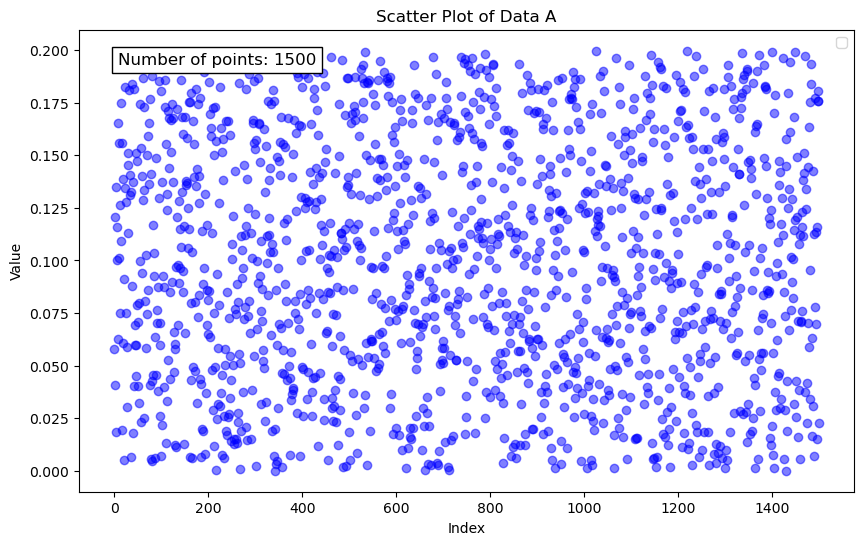

In [9]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


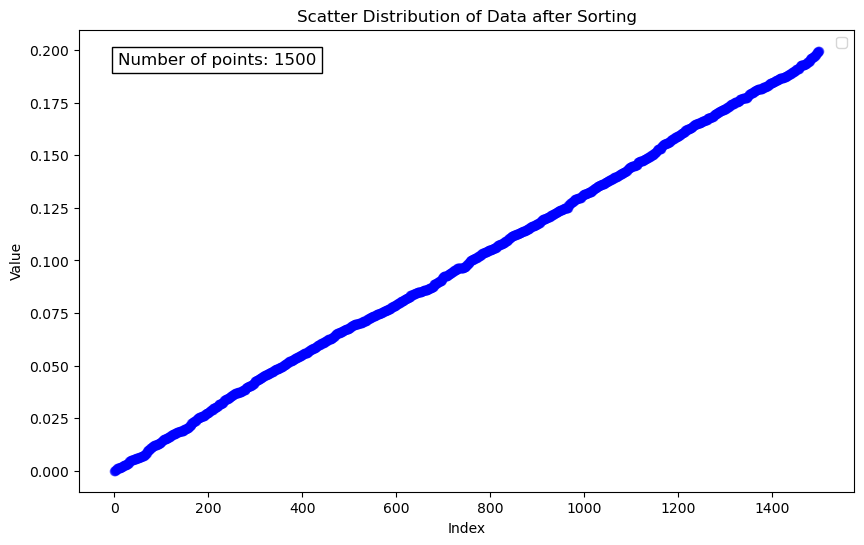

In [10]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.053306107381284856, 0.053370639754196245, 0.05328191060924125, 0.053294103692282595, 0.05330693696812269, 0.05333267076631746, 0.05337993449610886, 0.05326097131142464, 0.05328614379073692, 0.053372016925906686]
Error u of fuhe active learning(LHS sampling): 5.331914e-02
[0.004537715764889254, 0.004545612101335859, 0.004537030046753459, 0.004537038606826104, 0.004537879559329448, 0.004540388744407543, 0.004546965904167303, 0.004535014313291852, 0.004535988216965398, 0.004544387121941139]
MAE of fuhe active learning(LHS sampling): 4.539802e-03
[0.00034709854174915303, 0.0003479384780671915, 0.0003467817922445346, 0.0003469421215978175, 0.00034710888246039143, 0.0003474446166092497, 0.00034805944938748996, 0.00034651249431497095, 0.0003468391702087479, 0.00034795613192342917]
MSE of fuhe active learning(LHS sampling): 3.472682e-04
[3.674629e-05, 3.3043434e-05, 4.445955e-05, 0.00011349763, 3.5123547e-05, 4.331788e-05, 4.4284698e-05, 7.66822e-05, 0.00011136012, 8.4254134e-05]
Chaos of f

/tmp/ipykernel_1426296/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.053306107381284856, 0.053370639754196245, 0.05328191060924125, 0.053294103692282595, 0.05330693696812269, 0.05333267076631746, 0.05337993449610886, 0.05326097131142464, 0.05328614379073692, 0.053372016925906686]
mean Error u: 5.331914e-02
Variance Error u: 1.613120e-09


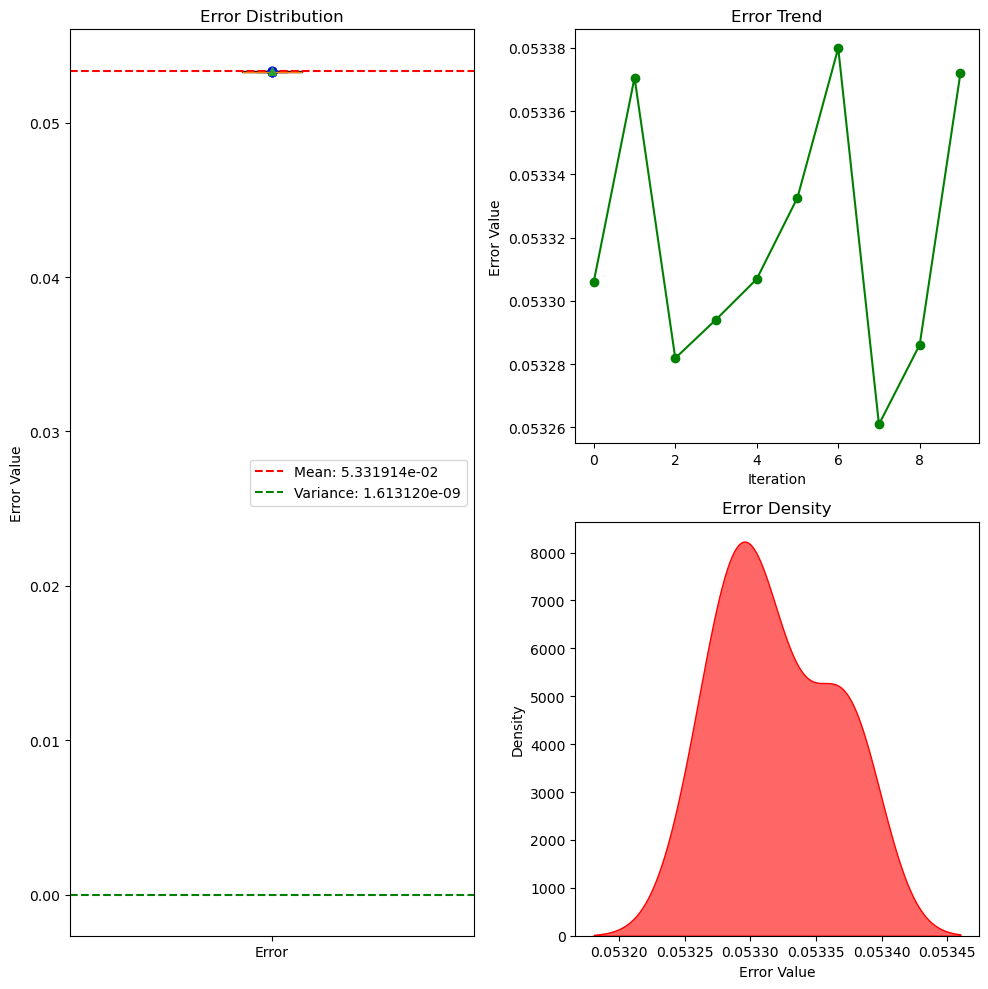

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.004537715764889254, 0.004545612101335859, 0.004537030046753459, 0.004537038606826104, 0.004537879559329448, 0.004540388744407543, 0.004546965904167303, 0.004535014313291852, 0.004535988216965398, 0.004544387121941139]
mean MAE: 4.539802e-03
Variance MAE: 1.672815e-11


/tmp/ipykernel_1426296/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


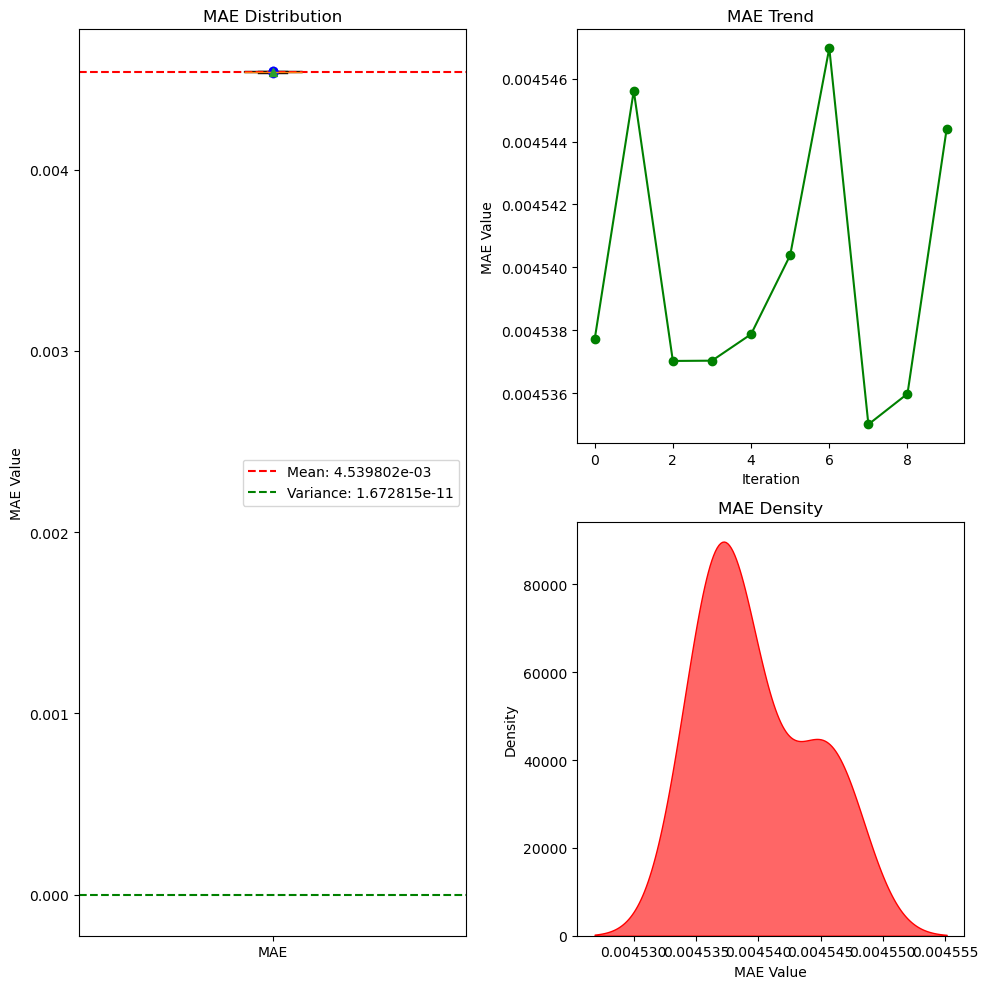

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00034709854174915303, 0.0003479384780671915, 0.0003467817922445346, 0.0003469421215978175, 0.00034710888246039143, 0.0003474446166092497, 0.00034805944938748996, 0.00034651249431497095, 0.0003468391702087479, 0.00034795613192342917]
mean MSE: 3.472682e-04
Variance MSE: 2.731965e-13


/tmp/ipykernel_1426296/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


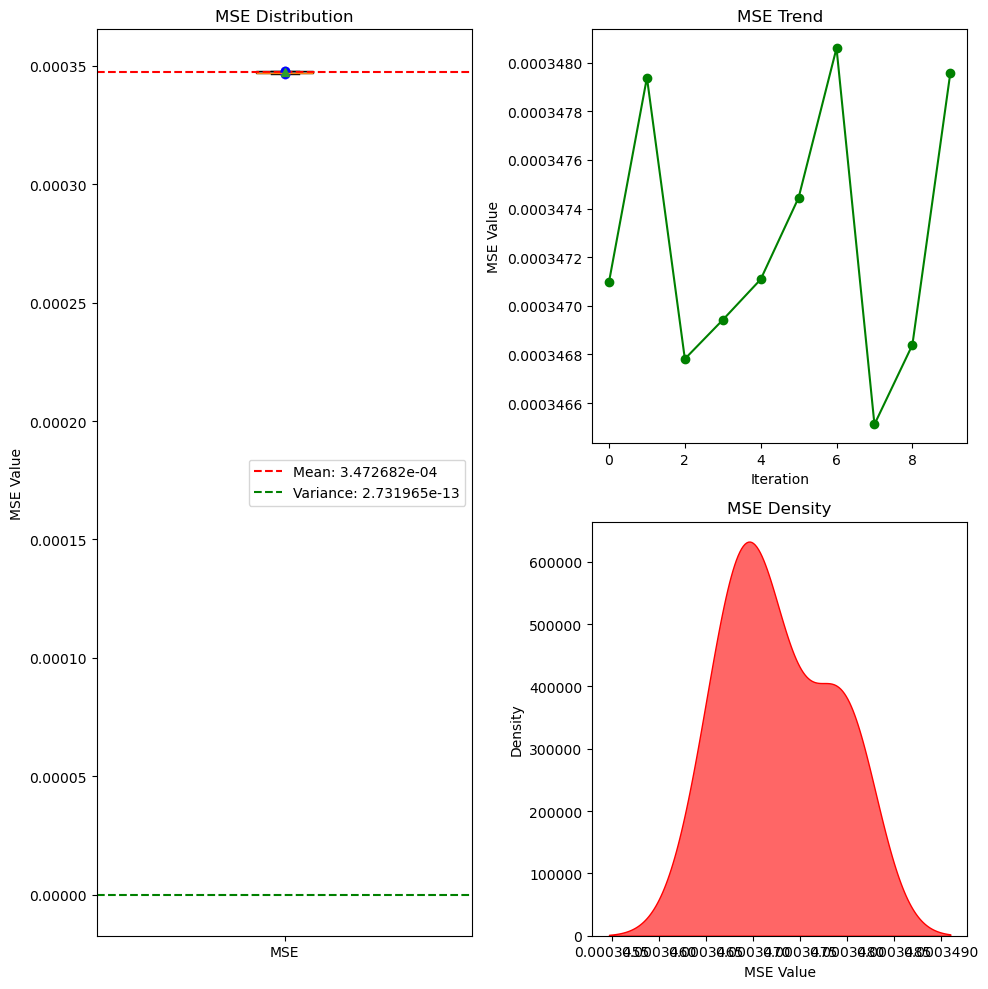

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.674629e-05, 3.3043434e-05, 4.445955e-05, 0.00011349763, 3.5123547e-05, 4.331788e-05, 4.4284698e-05, 7.66822e-05, 0.00011136012, 8.4254134e-05]
mean CHAOS: 6.227694e-05
Variance CHAOS: 8.967571e-10


/tmp/ipykernel_1426296/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


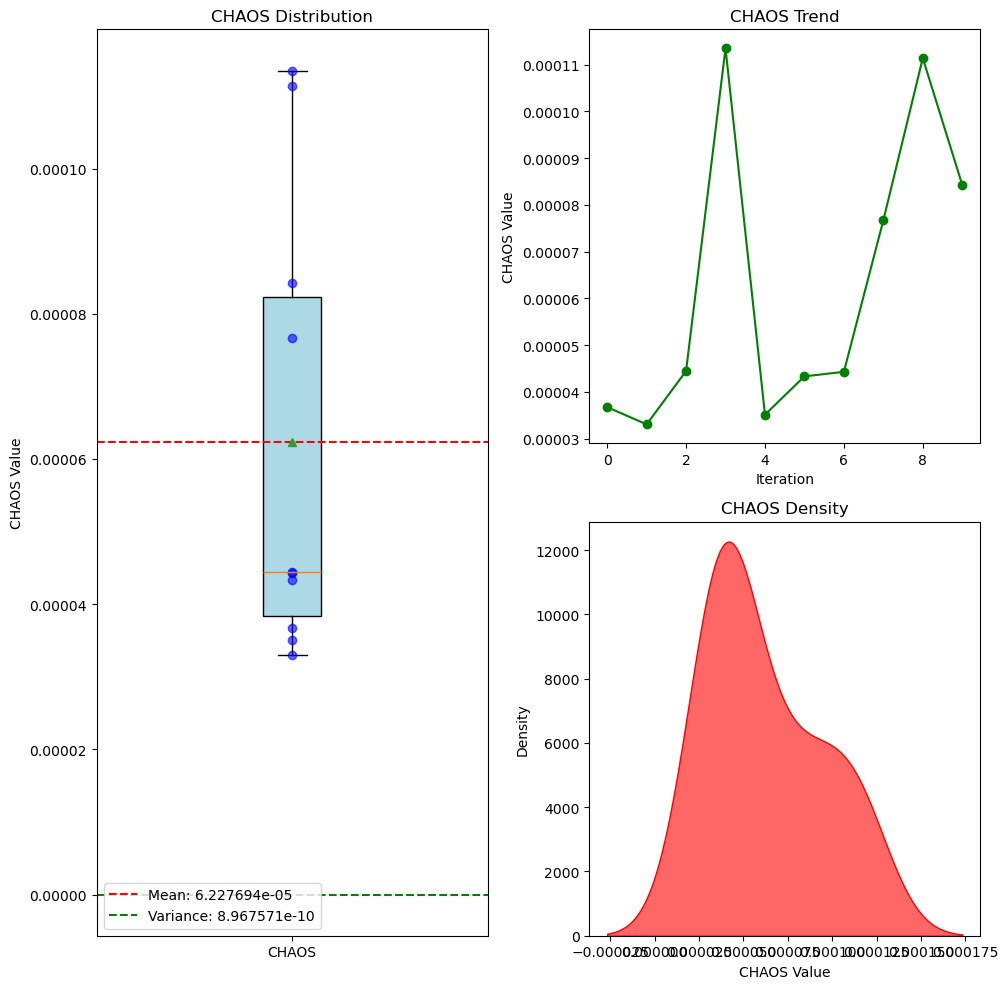

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00033722143, 0.00033313266, 0.0003497264, 0.0003319922, 0.00035131385, 0.00036825452, 0.00034636952, 0.00033275504, 0.00033048133, 0.00034382453]
mean RESIDUAL: 3.425071e-04
Variance RESIDUAL: 1.275365e-10


/tmp/ipykernel_1426296/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


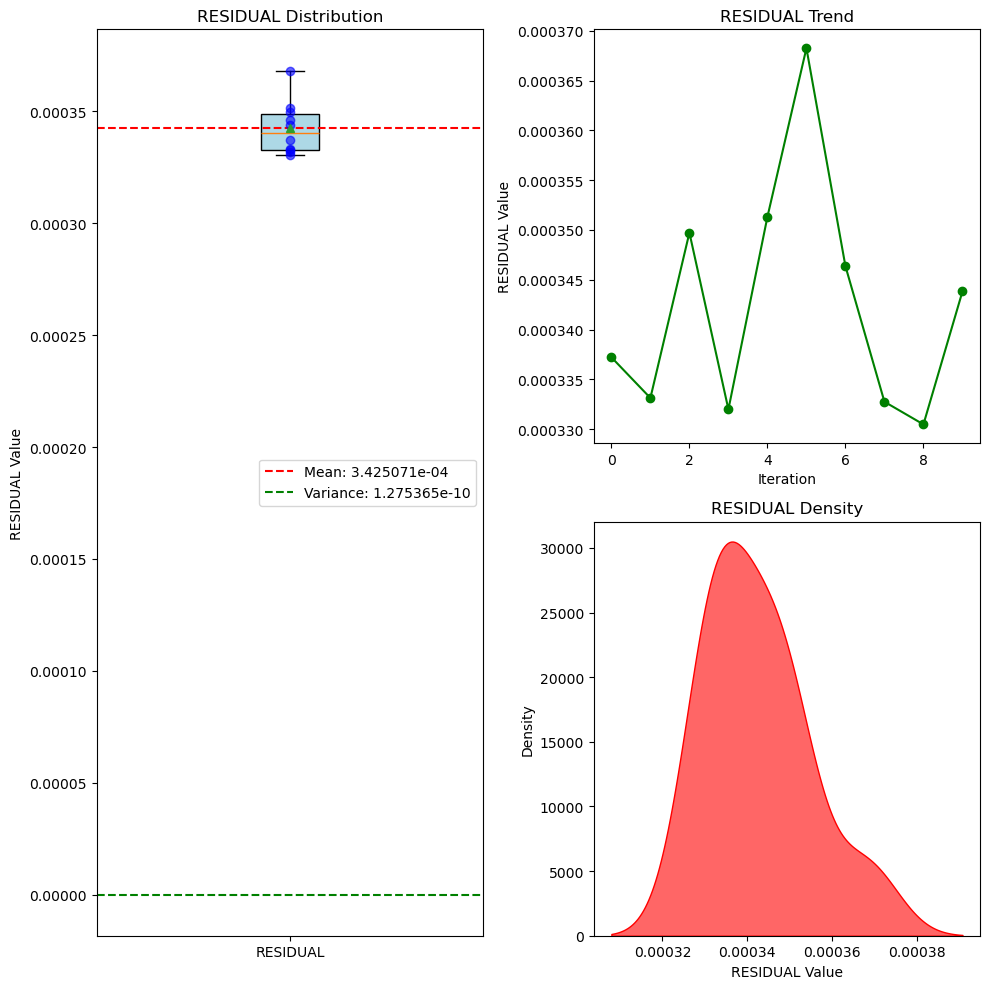

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.7938877e+03 1.7115417e+03 1.6429584e+03 ... 6.2720189e-03 6.2720147e-03
 6.2720072e-03]


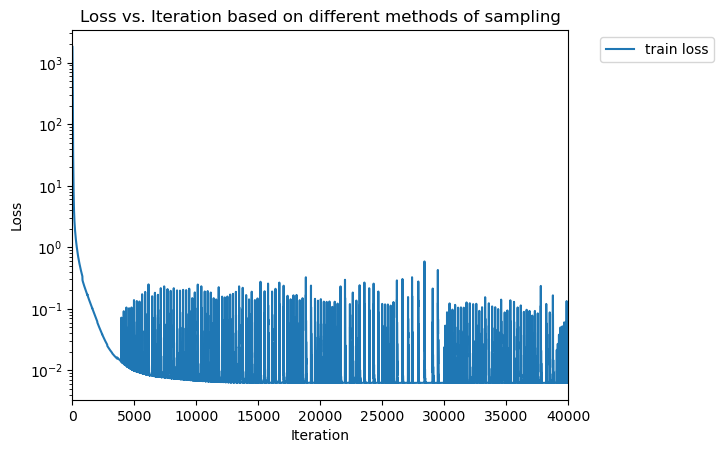

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1  state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758071  0.05305  0.094601  0.068873  0.006609  0.004818  0.008588   
1  0.758067  0.05305  0.094604  0.068874  0.006610  0.004818  0.008588   
2  0.758063  0.05305  0.094607  0.068874  0.006610  0.004818  0.008589   
3  0.758058  0.05305  0.094610  0.068874  0.006611  0.004817  0.008589   
4  0.758054  0.05305  0.094613  0.068874  0.006611  0.004817  0.008590   

    state_8   state_9  state_10  state_11  state_12  
0  0.004004  0.000594  0.000273  0.000489  0.000029  
1  0.004004  0.000594  0.000273  0.000489  0.000029  
2  0.004004  0.000594  0.000273  0.000489  0.000029  
3  0.004004  0.000594  0.000274  0.000489  0.000029  
4  0.004004  0.000594  0.000274  0.000489  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757811  0.053038  0.094714  0.068887  0.006638  0.004825  0.008622   
496  0.757808  0.053038  0.094714  0.068887  0.006639  0.004825  0.008623   


Text(0, 0.5, 'Probability')

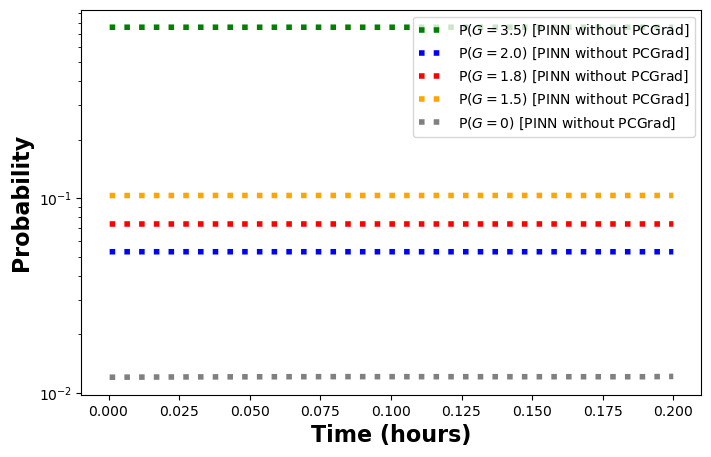

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

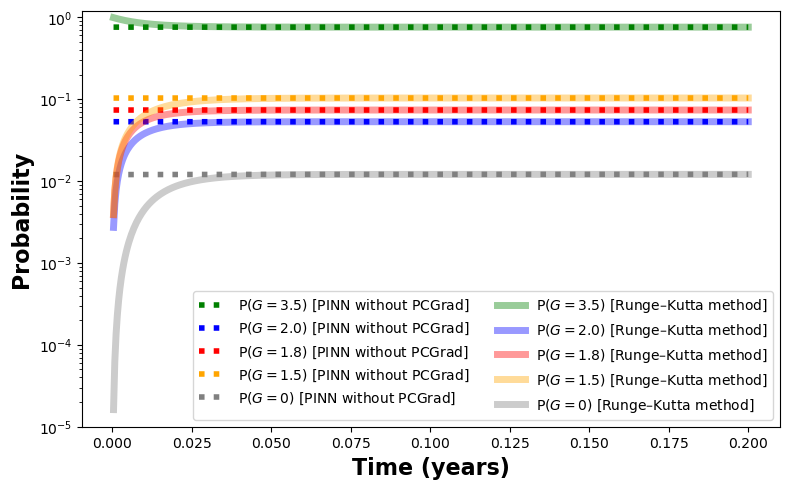

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0017397806596171463
RMSE of between PINN without PCGrad and the analytical solution is 0.0017397806596171322


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.013148021581336856
RMSE of between PINN without PCGrad and the analytical solution is 0.013148021581336215
